In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from Battleship import *

sns.set()

# Let's generate visualizations

1) Model predictions given that we see
 * a single hit
 * a single miss

2) Play a bunch of games and make gifs of 
 * a typical game
 * a long game
 * a short game

3) Plot the sum of remaining probabilities to confirm that our model 
    "counts" the number of ship tiles left over.

4) Play many games, plot cdf and pdf.

In [3]:
def show_board(board: Board, history: List[Tuple[int, int]]) -> Board:
    """A tool to show the board using the information we currently have.

    Args:
        board (Board): Ground truth board.
        history (List[Tuple[int, int]]): History of choices made.
    """
    output_board = np.ones((10, 10, 3))
    output_board[..., :] = np.array([190, 147, 229]) / 256

    for i, j in history:
        output_board[i, j, :] = 1 - board[i, j]
    return output_board

In [4]:
def format_model_output(
    model: Battleship_Model, board: Board, history: List[Tuple[int, int]]
) -> Board:
    """Make an array which is properly formatted to show a pretty image depicting the probabilities
    that the model assigns to the board tiles. Importantly, this DOES NOT give probabilities, it just
    makes differences in probabilities more apparent.

    Args:
        model (Battleship_Model): A battleship model
        board (Board): A 10x10 array of 1's and 0's giving the board.
        history (List[Tuple[int, int]]): A list of integer tuples indicating the squares chosen.

    Returns:
        [Board]: A board which when passed to imshow will show probabilities in a pretty way.
    """
    input_board = np.zeros((1, 10, 10, 3))
    input_board[..., -1] = 1

    hit_indices = []
    miss_indices = []

    for i, j in history:
        input_board[0, i, j, -1] = 0
        if board[i, j]:
            input_board[0, i, j, 0] = 1
            hit_indices.append((i, j))
        else:
            input_board[0, i, j, 1] = 1
            miss_indices.append((i, j))

    predictions = model(input_board)[0, ...].numpy()

    predictions = 0.2 + sigmoid(predictions) * 0.6

    # To make visualizations more clear
    for i, j in hit_indices:
        predictions[i, j] = 1
    for i, j in miss_indices:
        predictions[i, j] = 0

    return predictions

In [5]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

## load model

In [6]:
trained_model = Battleship_Model()
trained_model.load_weights("final_trained_battleship_model_weights")

## How does a single hit look? a single miss?

In [7]:
single_hit_output = format_model_output(
    model=trained_model, board=np.ones((10, 10)), history=[(4, 4)]
)
single_miss_output = format_model_output(
    model=trained_model, board=np.zeros((10, 10)), history=[(4, 4)]
)

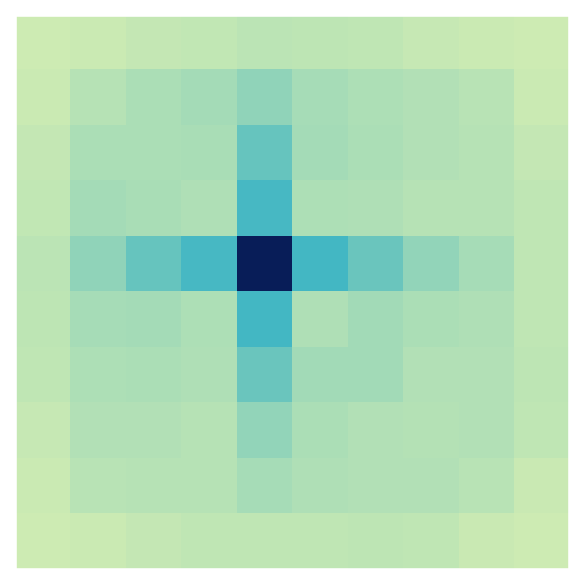

In [8]:
fig, ax = plt.subplots(dpi=150)

ax.imshow(single_hit_output, cmap="YlGnBu", vmin=0, vmax=1)

ax.set_xticks([], [])
ax.set_yticks([], [])

fig.savefig("single_hit.png", bbox_inches="tight")

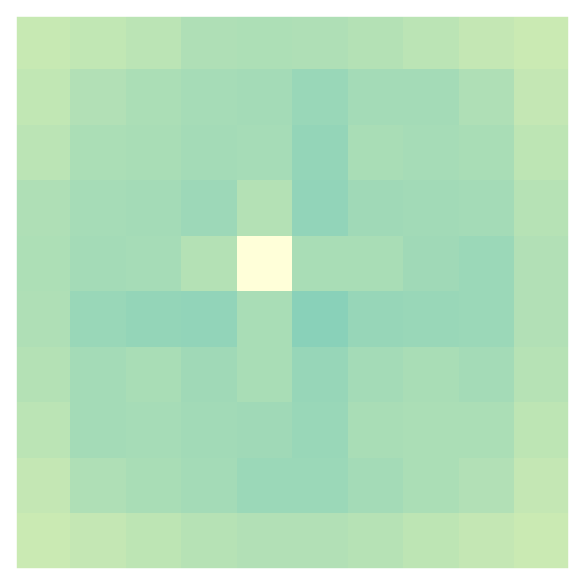

In [9]:
fig, ax = plt.subplots(dpi=150)

ax.imshow(single_miss_output, cmap="YlGnBu", vmin=0, vmax=1)

ax.set_xticks([], [])
ax.set_yticks([], [])

fig.savefig("single_miss.png", bbox_inches="tight")

In [11]:
# animate history
def save_pics(
    model: Battleship_Model, history: List[Tuple[int, int]], board: Board, name: str
):
    """Given a battlehip model, a history, and a board, plot and save all the steps of the game.
    Each plot is three images arranged horizontally.

    Args:
        model (Battleship_Model): A battleship model
        history (List[Tuple[int, int]]): A list of integer tuples indicating the squares chosen.
        board (Board): A 10x10 array of 1's and 0's giving the board.
        name (str): The name of this game.
    """
    # initialize with no knowledge
    input_board = np.zeros((10, 10, 3))
    input_board[..., -1] = 1

    predictions = [format_model_output(model=model, board=input_board, history=[])]
    knowledge = [show_board(board=board, history=[])]

    for index, (i, j) in enumerate(history):

        input_board[i, j, -1] = 0
        if board[i, j]:
            input_board[i, j, 0] = 1
        else:
            input_board[i, j, 1] = 1

        predictions.append(
            format_model_output(model=model, board=board, history=history[: index + 1])
        )
        knowledge.append(show_board(board=board, history=history[: index + 1]))

    for index, (current_prediction, current_knowledge) in enumerate(
        zip(predictions, knowledge)
    ):

        fig, axs = plt.subplots(1, 3, dpi=350)

        axs[0].set_aspect(1)
        axs[0].set_xticks([], [])
        axs[0].set_yticks([], [])
        axs[0].imshow(current_knowledge)

        axs[1].set_aspect(1)
        axs[1].set_xticks([], [])
        axs[1].set_yticks([], [])
        axs[1].imshow(current_prediction, cmap="YlGnBu", vmin=0, vmax=1)

        axs[2].set_aspect(1)
        axs[2].set_xticks([], [])
        axs[2].set_yticks([], [])
        axs[2].imshow(board, cmap="Greys")

        fig.savefig(f"game_{name}/board_{index}.png", bbox_inches="tight")

        plt.show()
        plt.close()

# Finally, get a histogram

In [24]:
num_games = 2_500

histories = list(np.load("sample_histories.npy", allow_pickle=True))
boards = list(np.load("sample_boards.npy", allow_pickle=True))

time_0 = time.time()
for idx in range(num_games):
    history, board = player(
        model=trained_model, board=make_random_boards(num_boards=1)[0, ...]
    )

    histories.append(history)
    boards.append(board)

    if idx % 50 == 0 and idx > 0:
        np.save("sample_boards.npy", boards)
        np.save("sample_histories.npy", histories)

        seconds = time.time() - time_0
        seconds_remaining = (seconds / ((idx + 1) / num_games)) - seconds
        print("minutes remaining: ", round(seconds_remaining / 60, 2))

C:\Users\durrc\anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


minutes remaining:  49.28
minutes remaining:  48.18
minutes remaining:  49.39
minutes remaining:  49.48
minutes remaining:  47.8
minutes remaining:  46.64
minutes remaining:  44.7
minutes remaining:  42.77
minutes remaining:  41.75
minutes remaining:  40.54
minutes remaining:  39.15
minutes remaining:  37.77
minutes remaining:  36.64
minutes remaining:  35.6
minutes remaining:  34.53
minutes remaining:  33.4
minutes remaining:  32.59
minutes remaining:  31.73
minutes remaining:  31.01
minutes remaining:  30.36
minutes remaining:  30.14
minutes remaining:  29.37
minutes remaining:  28.18
minutes remaining:  27.02
minutes remaining:  25.98
minutes remaining:  24.88
minutes remaining:  23.86
minutes remaining:  22.94
minutes remaining:  22.07
minutes remaining:  21.08
minutes remaining:  20.09
minutes remaining:  19.1
minutes remaining:  18.0
minutes remaining:  16.9
minutes remaining:  15.85
minutes remaining:  14.83
minutes remaining:  13.8
minutes remaining:  12.74
minutes remaining:  

In [54]:
histories = list(np.load("sample_histories.npy", allow_pickle=True))
boards = list(np.load("sample_boards.npy", allow_pickle=True))

## Find shortest game, median game, and longest game

In [55]:
histories_boards = sorted(list(zip(histories, boards)), key=lambda x: len(x[0]) - 1)

In [56]:
short_history, short_board = histories_boards[0]
median_history, median_board = histories_boards[int(len(histories_boards) // 2)]
long_history, long_board = histories_boards[-1]

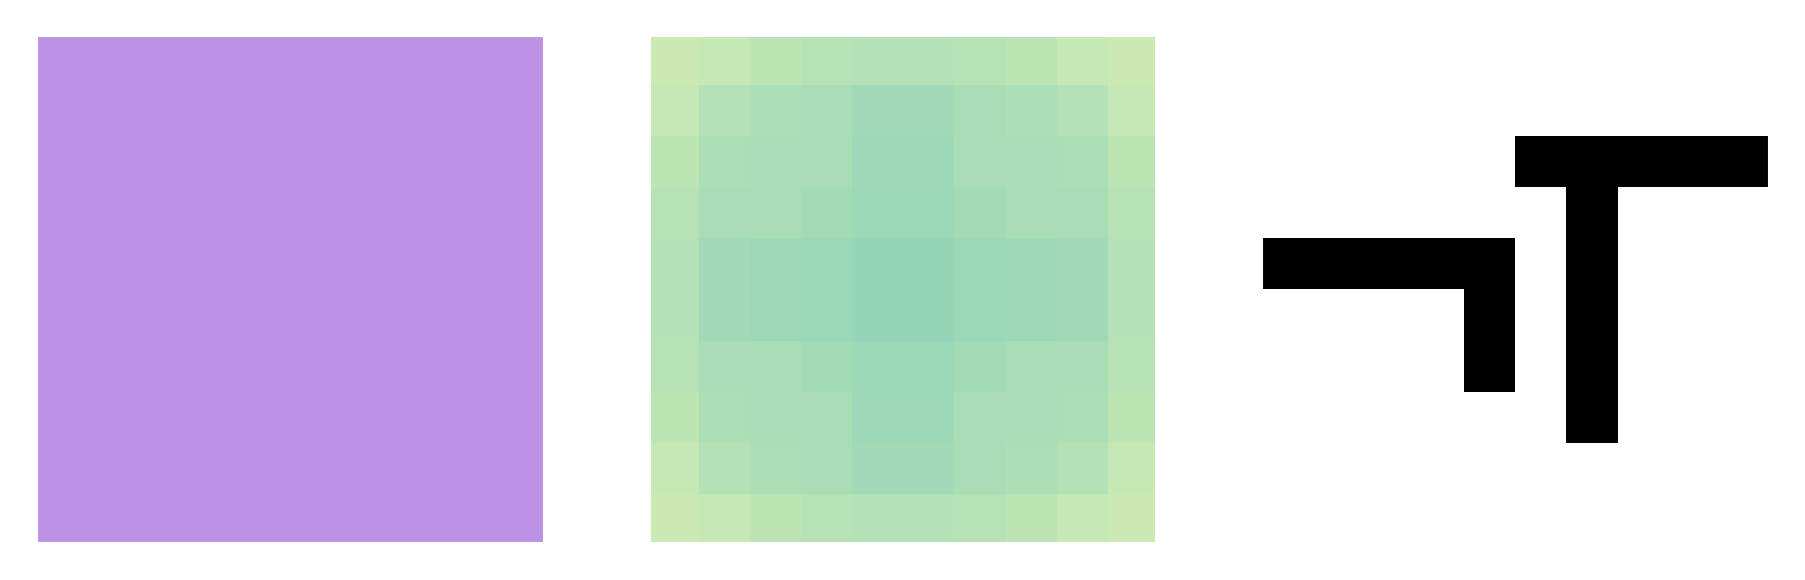

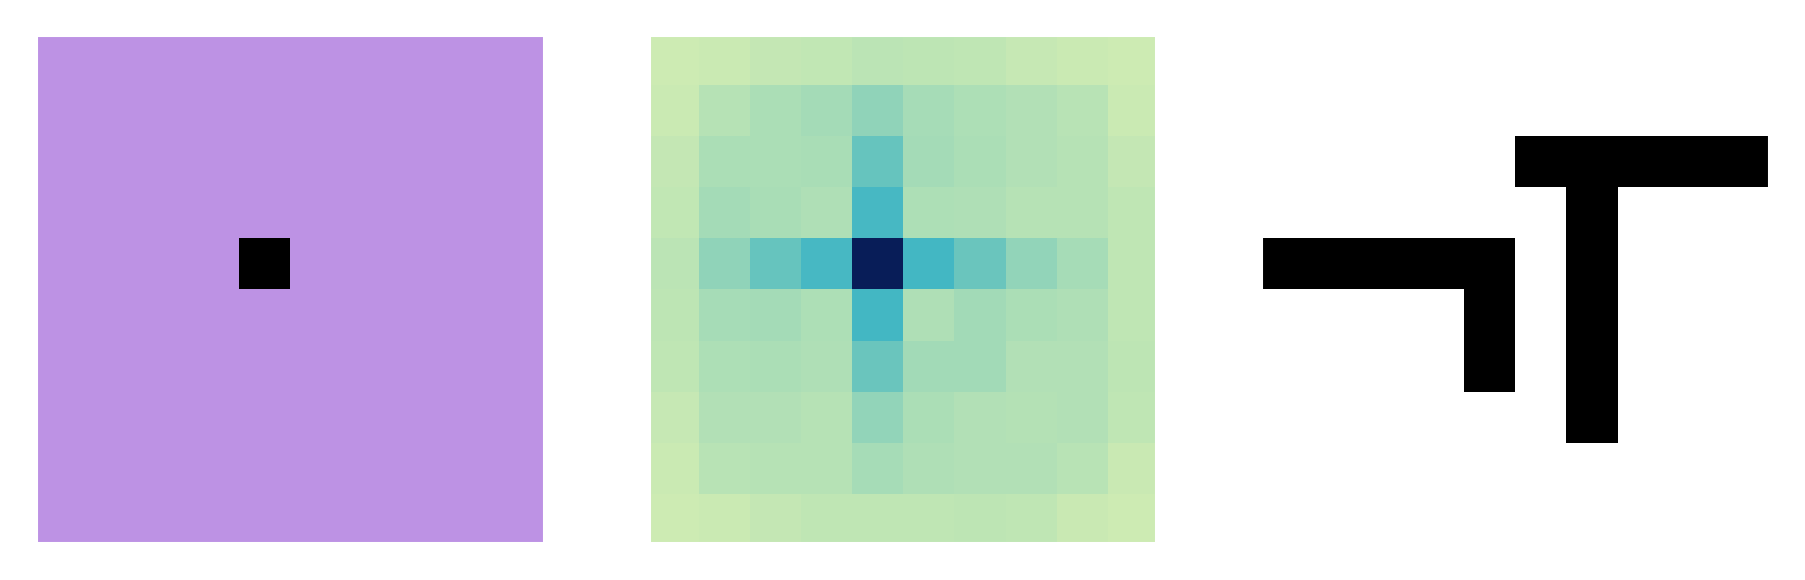

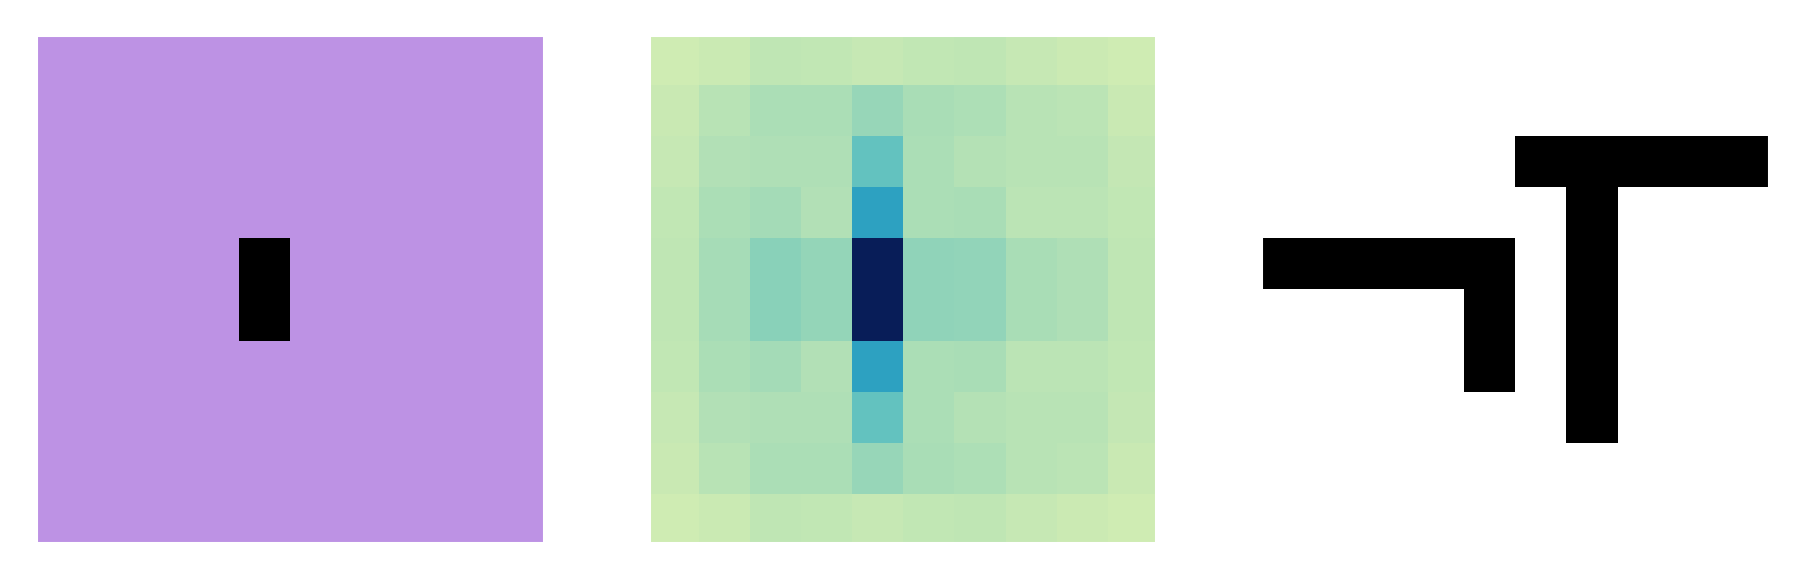

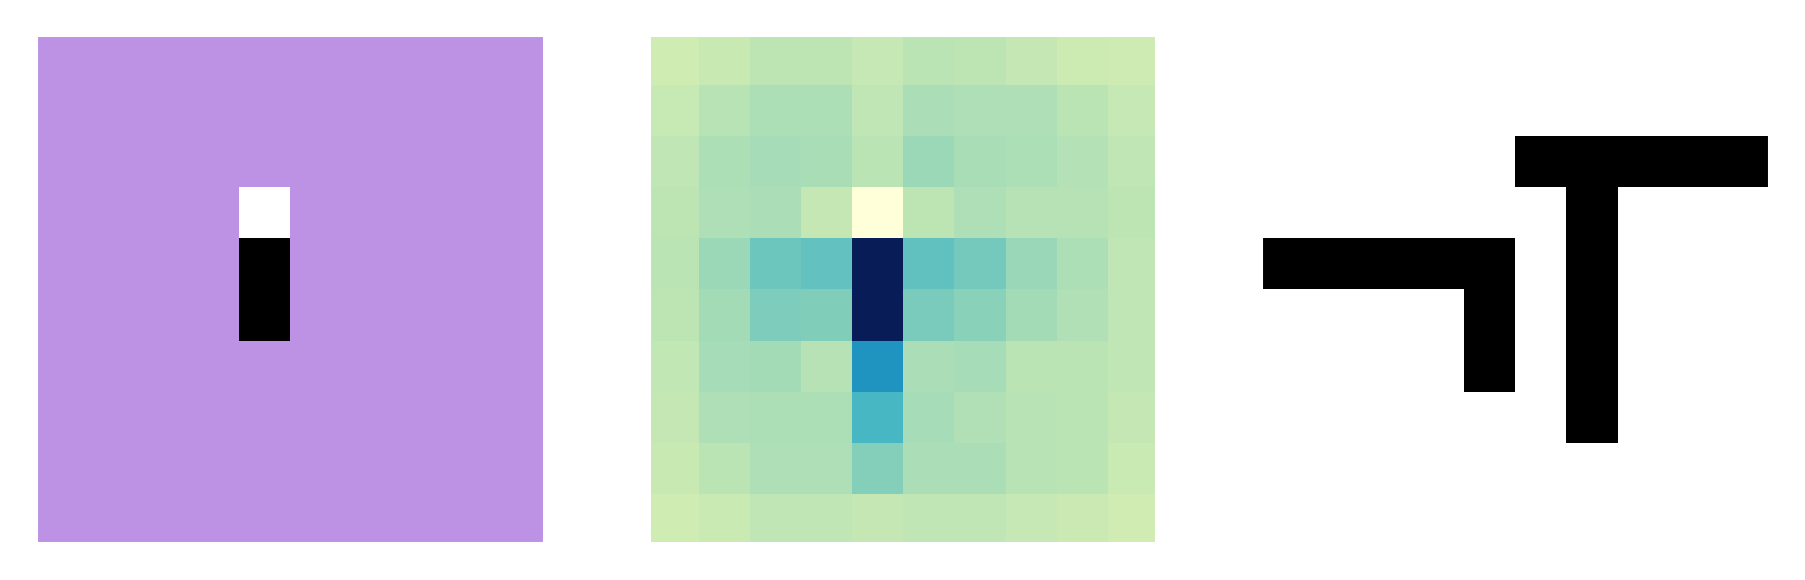

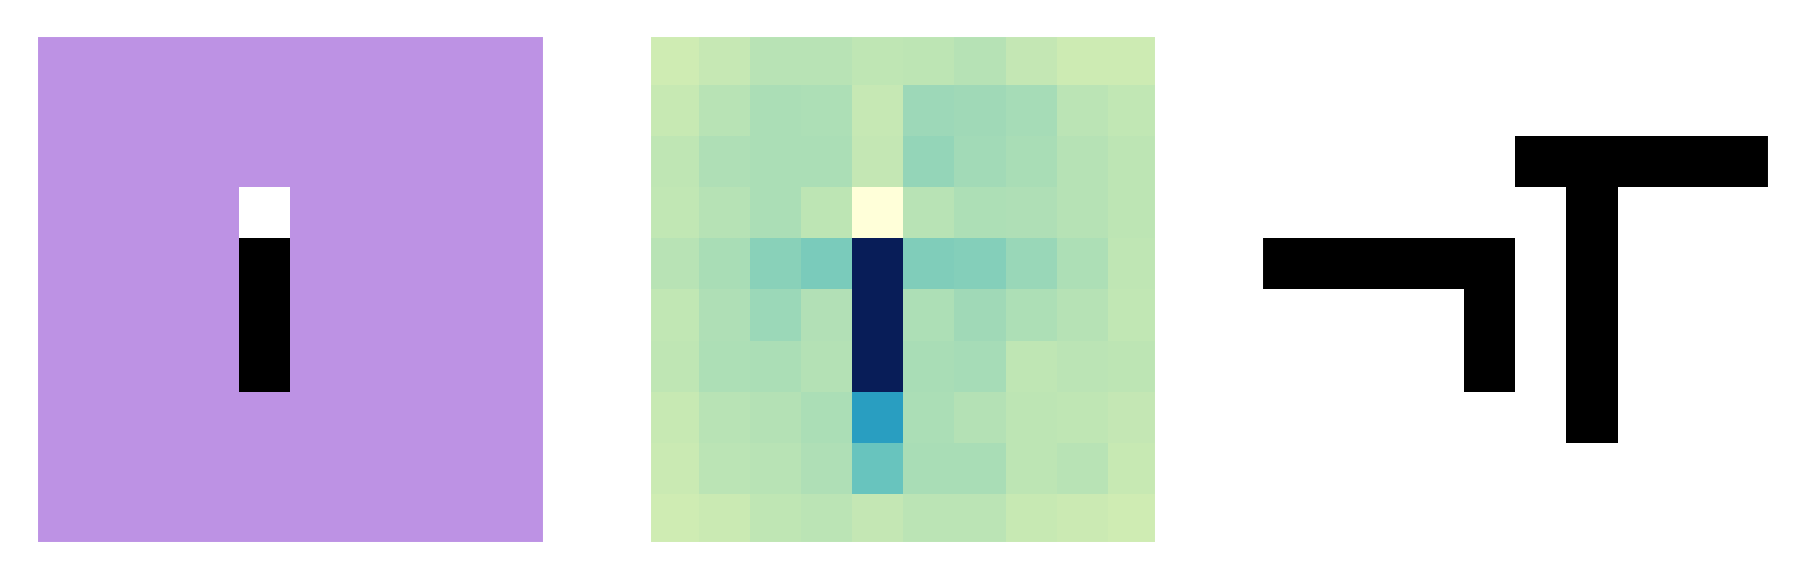

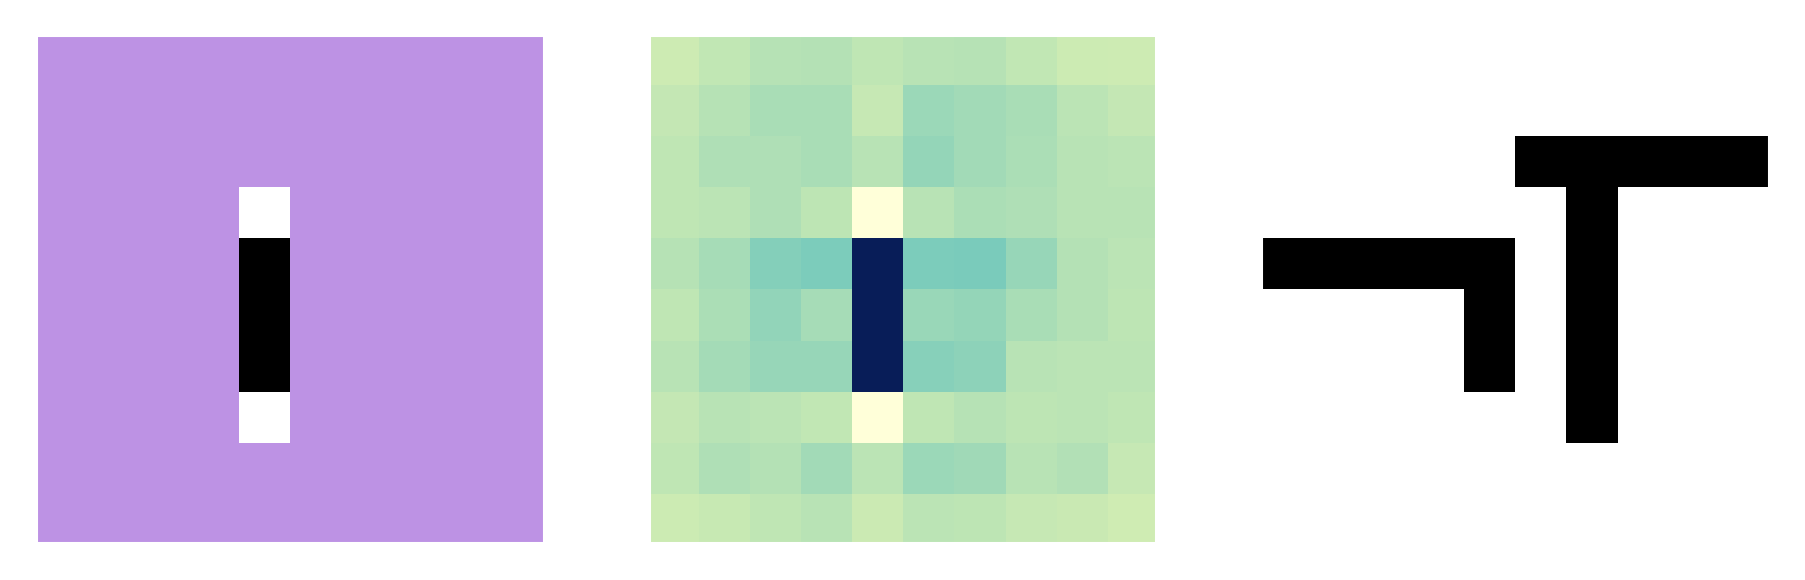

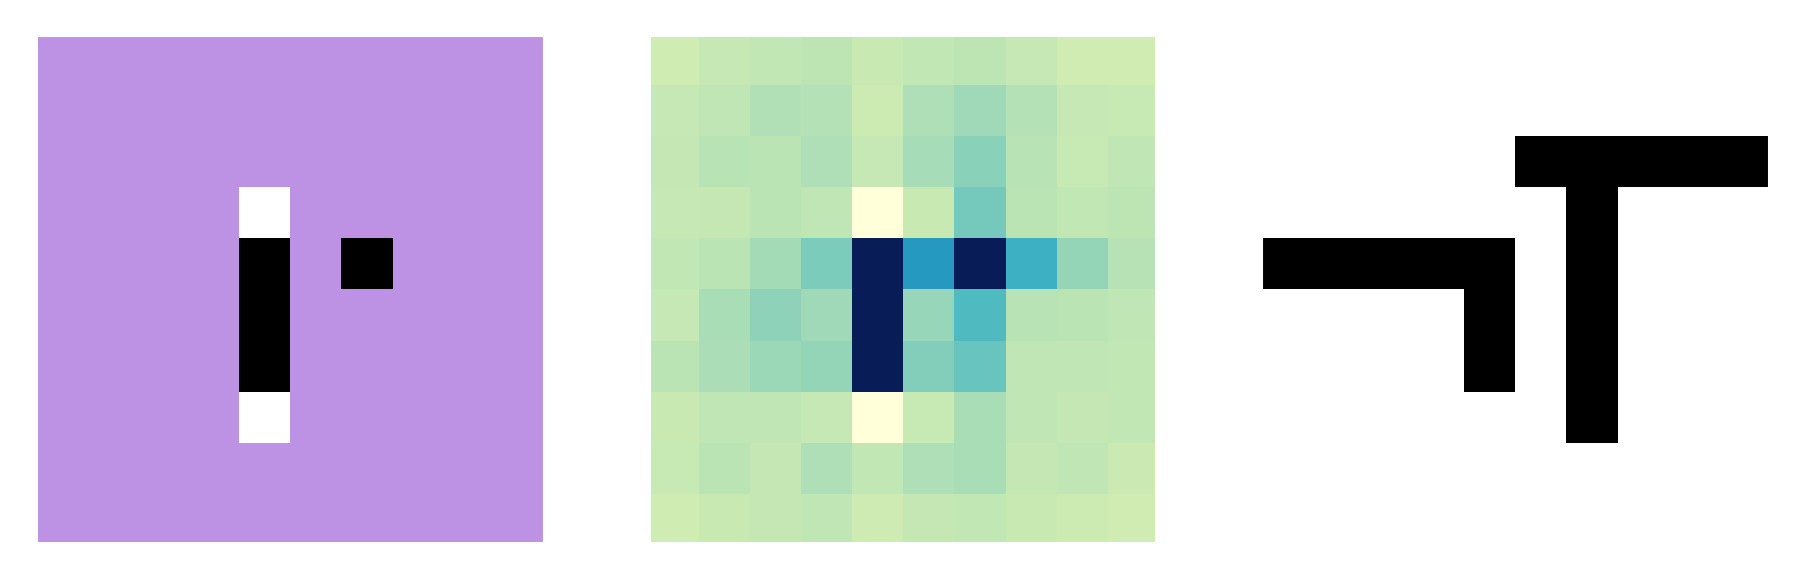

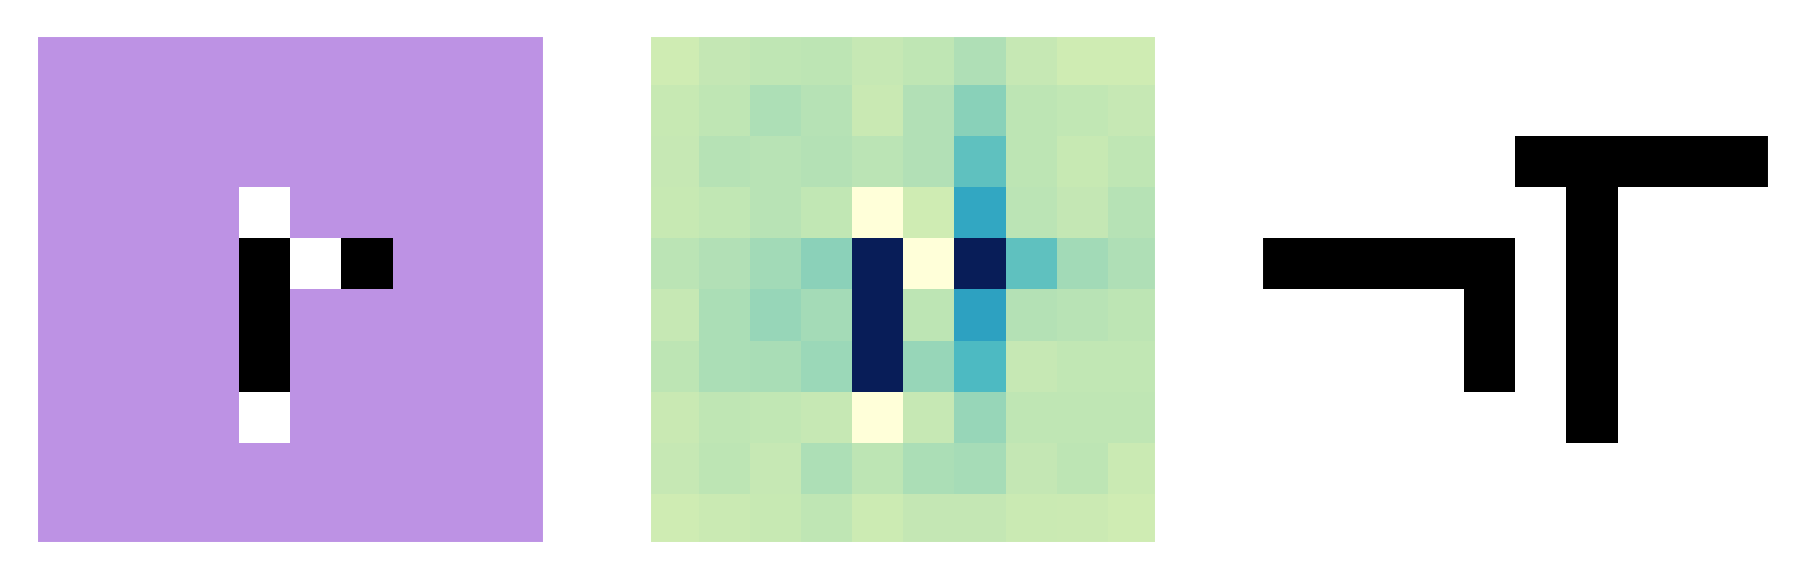

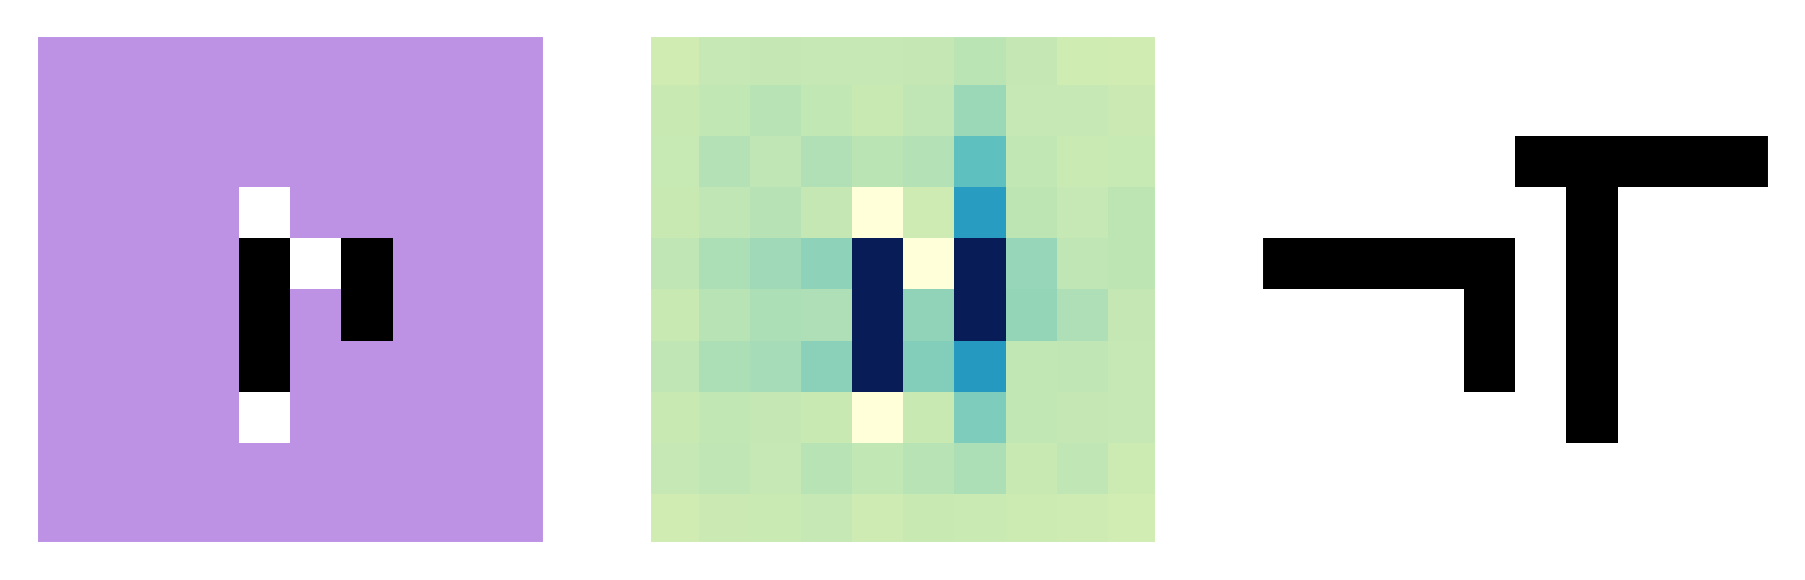

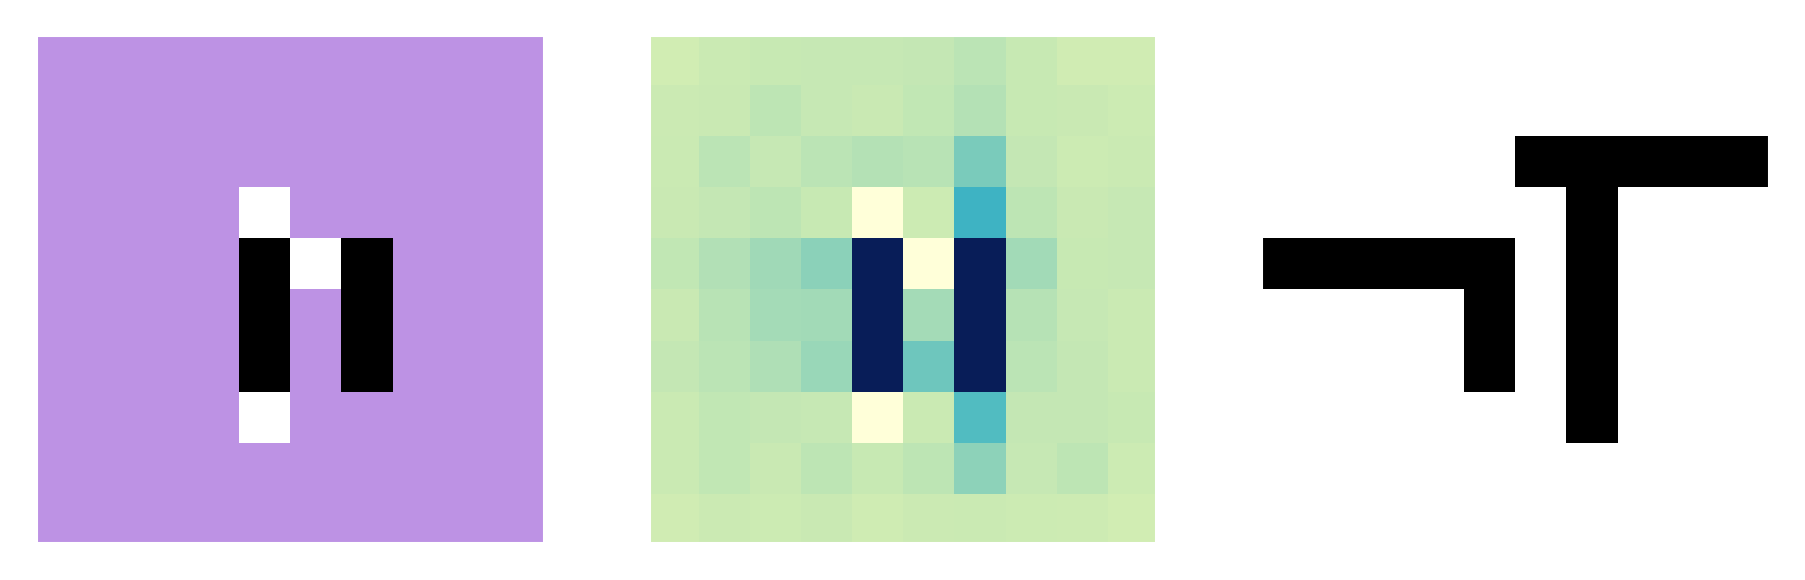

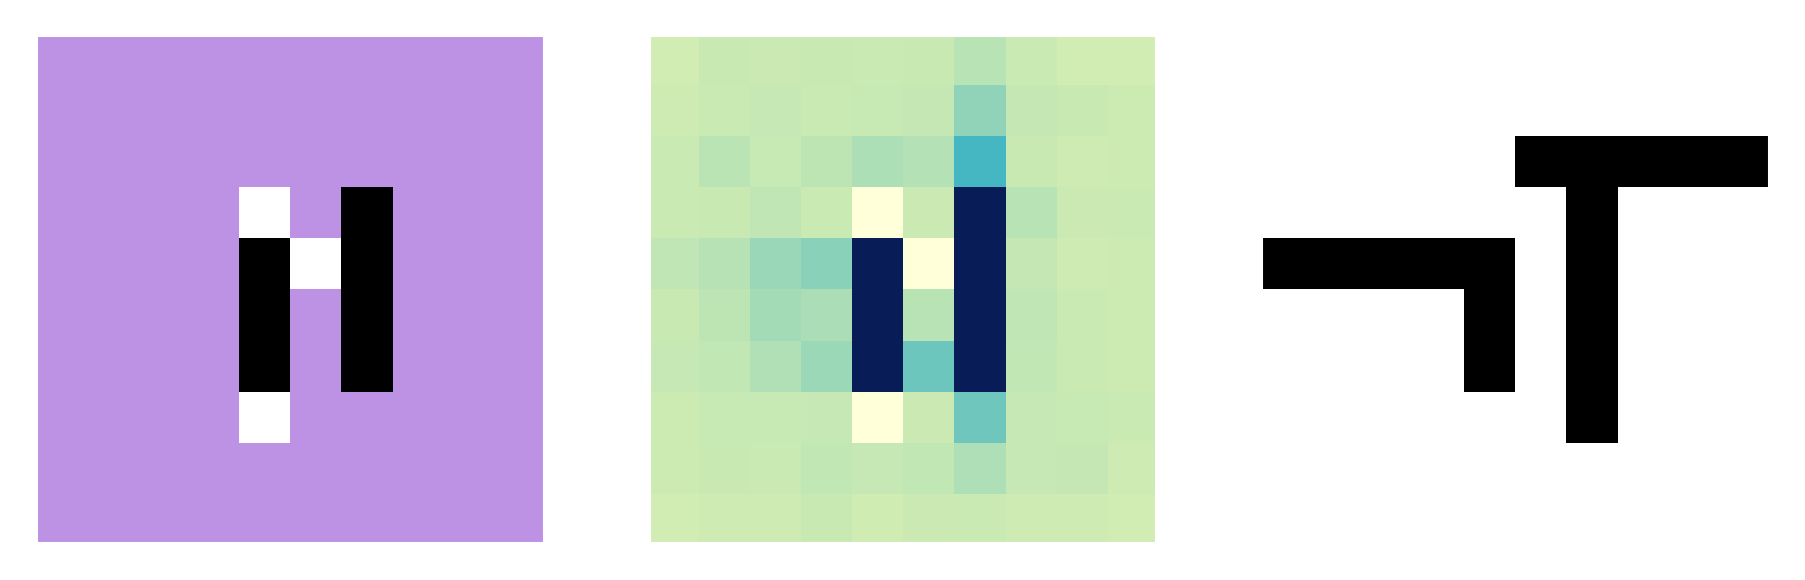

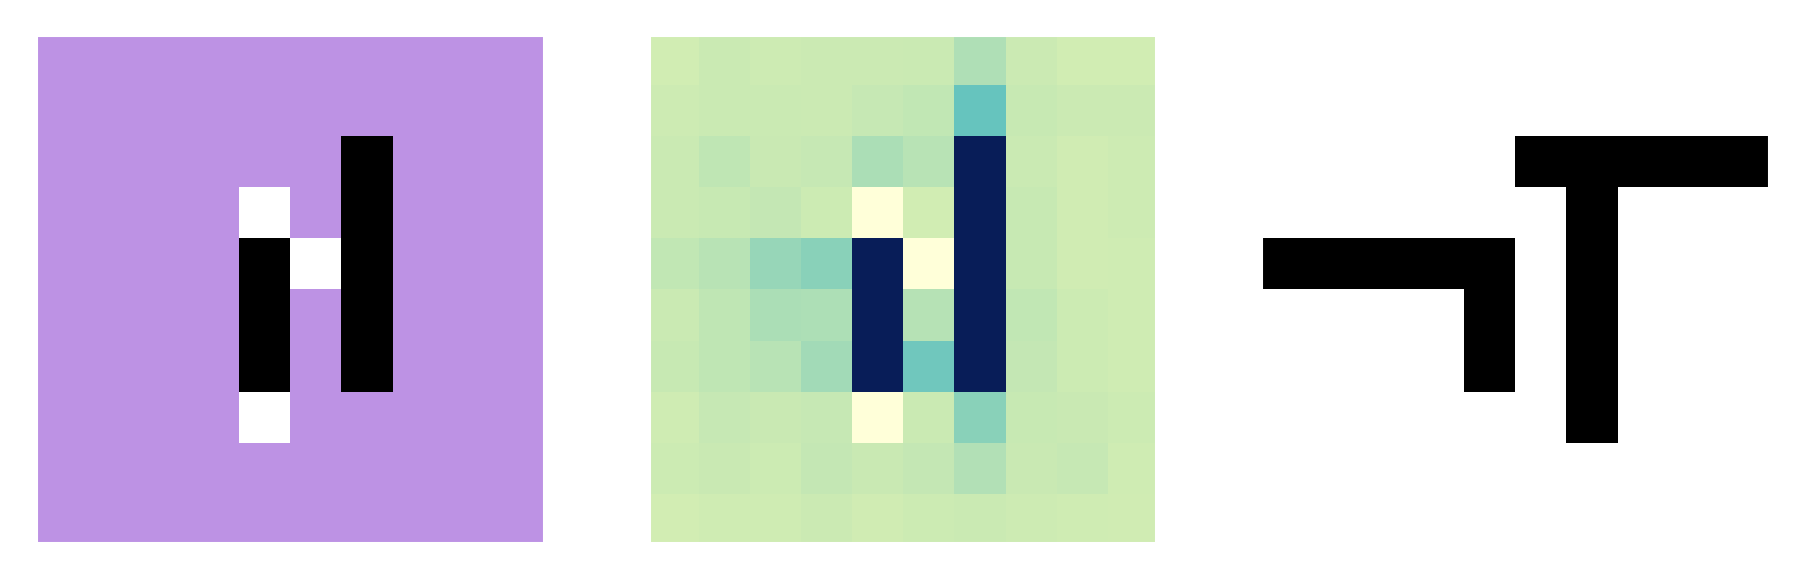

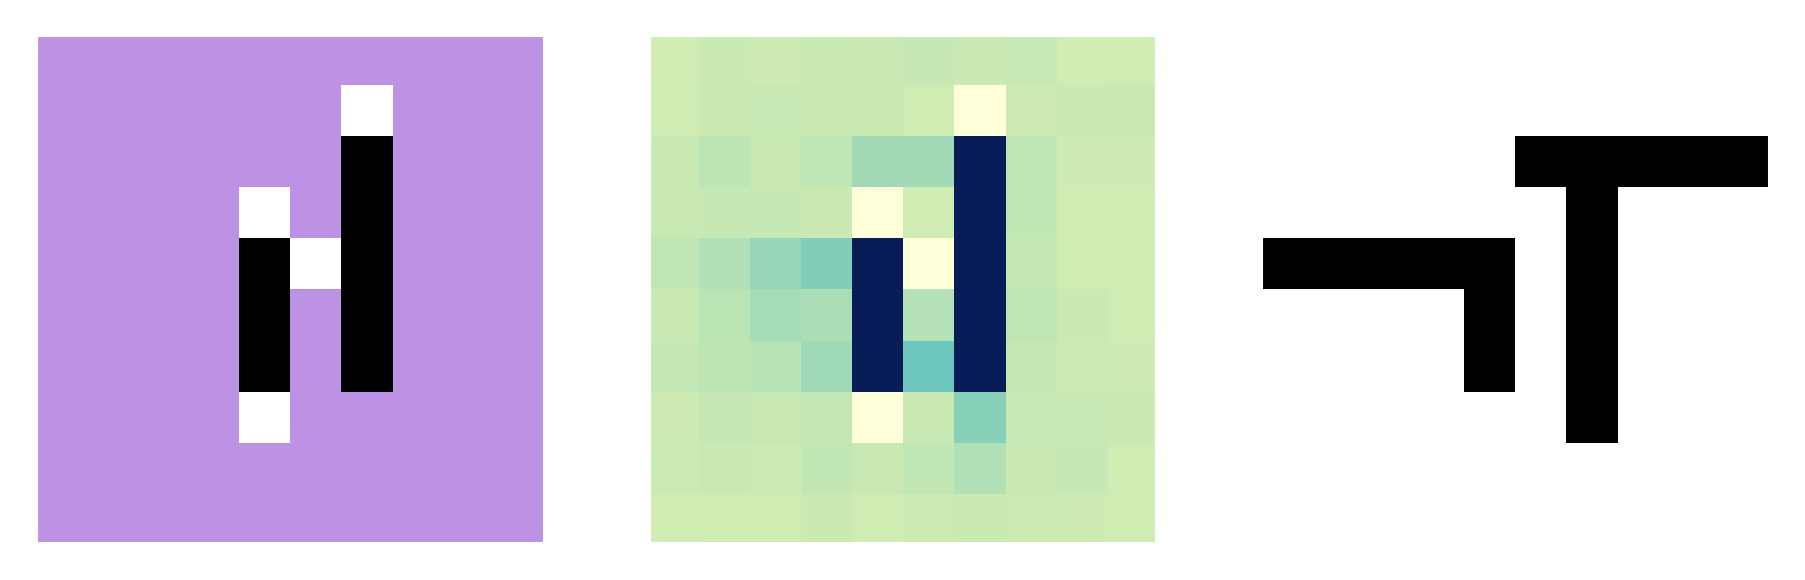

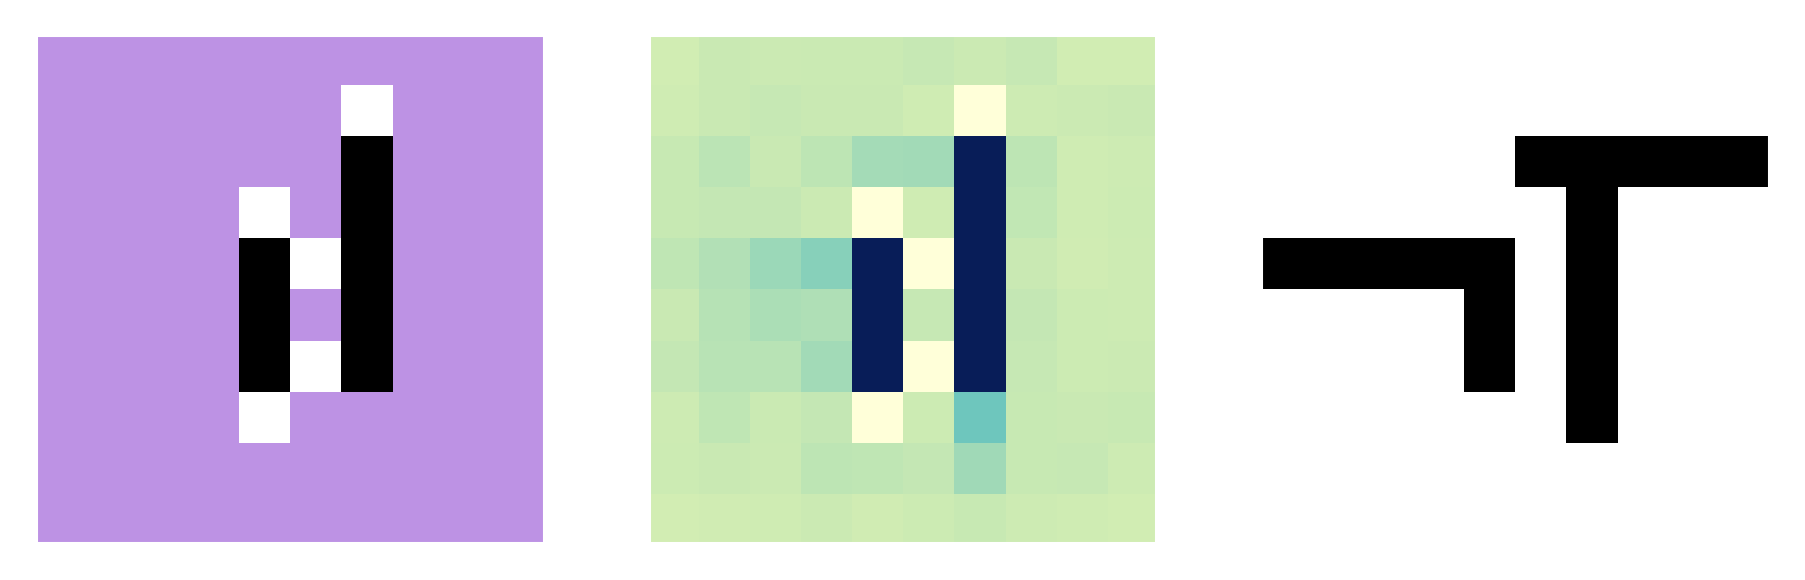

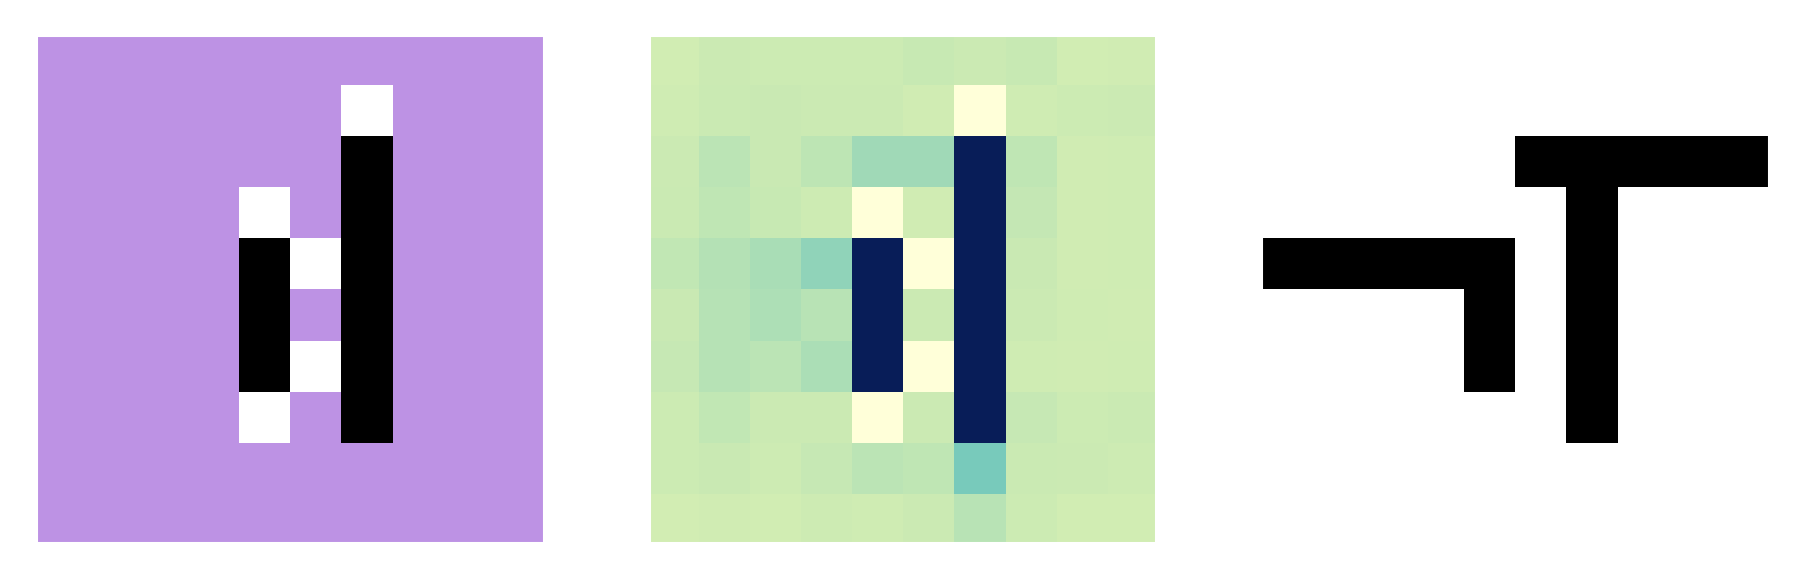

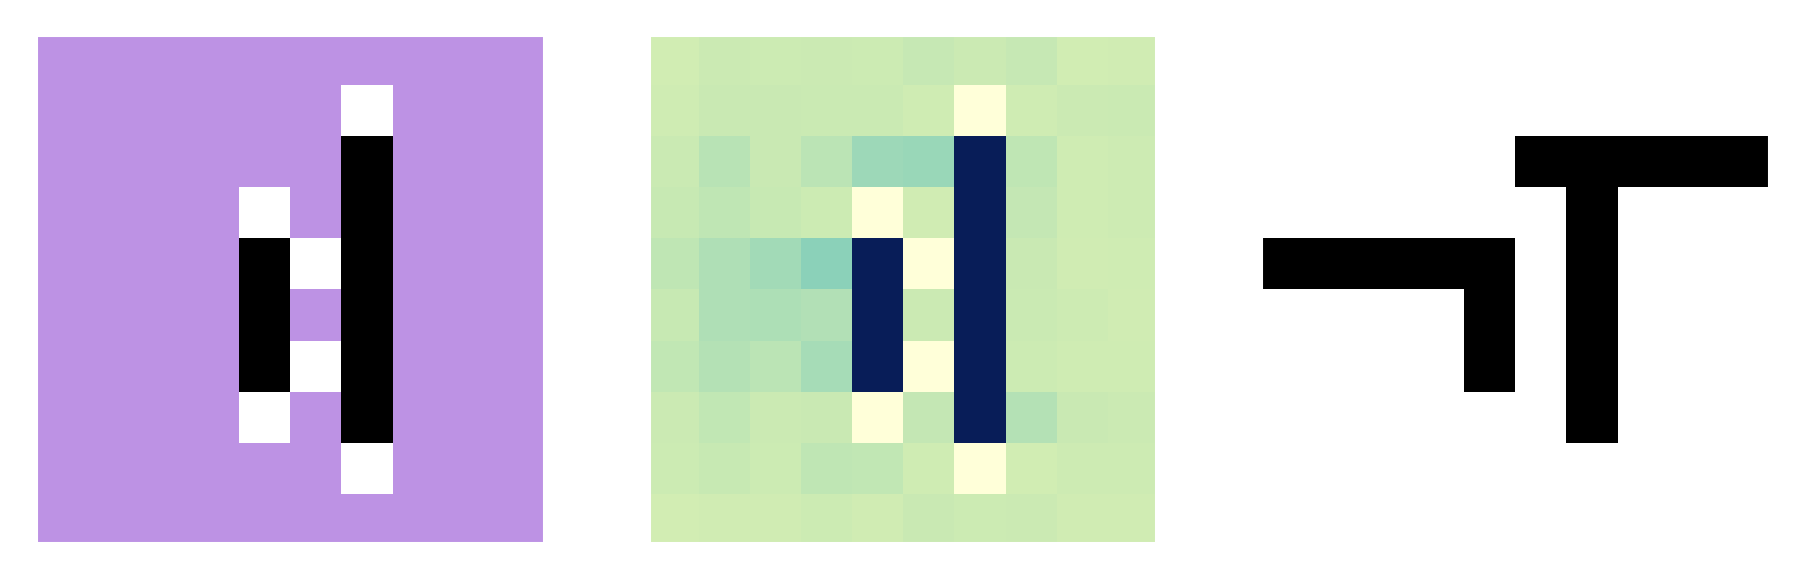

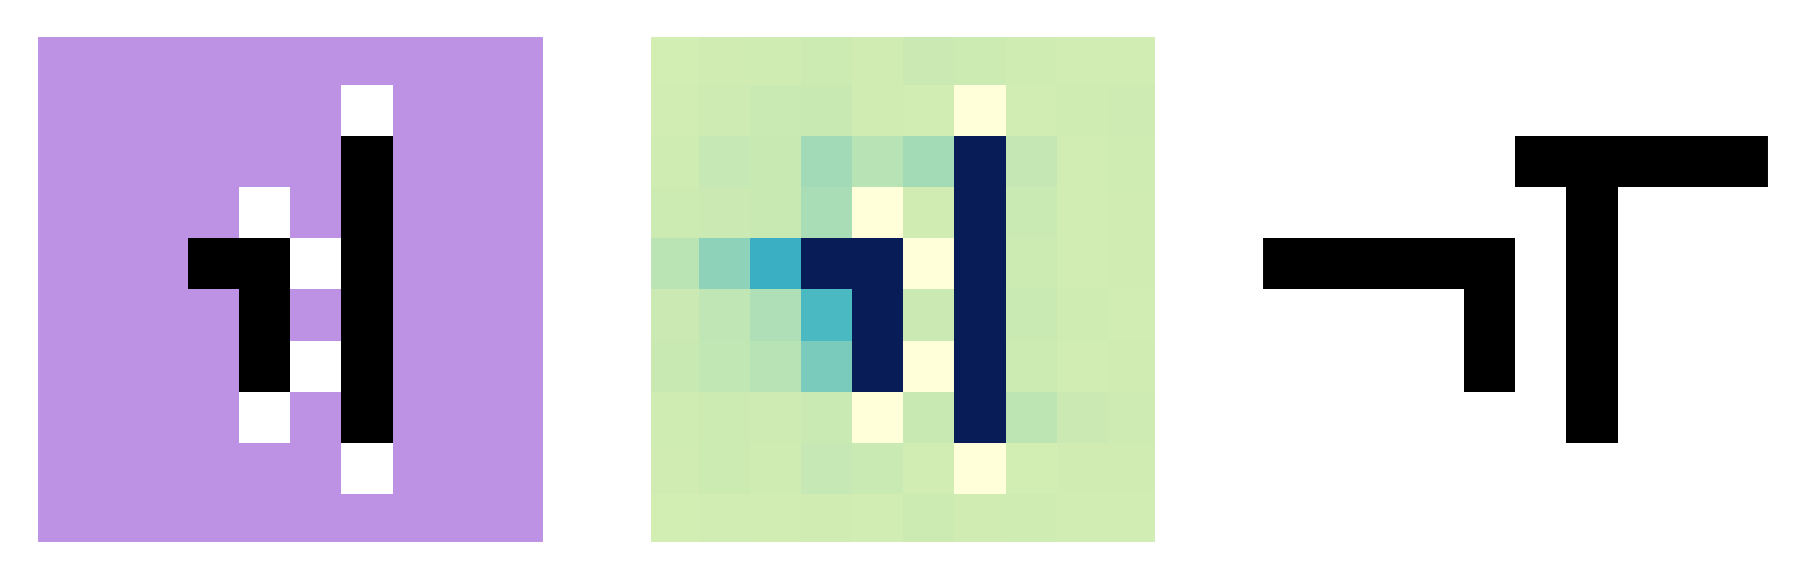

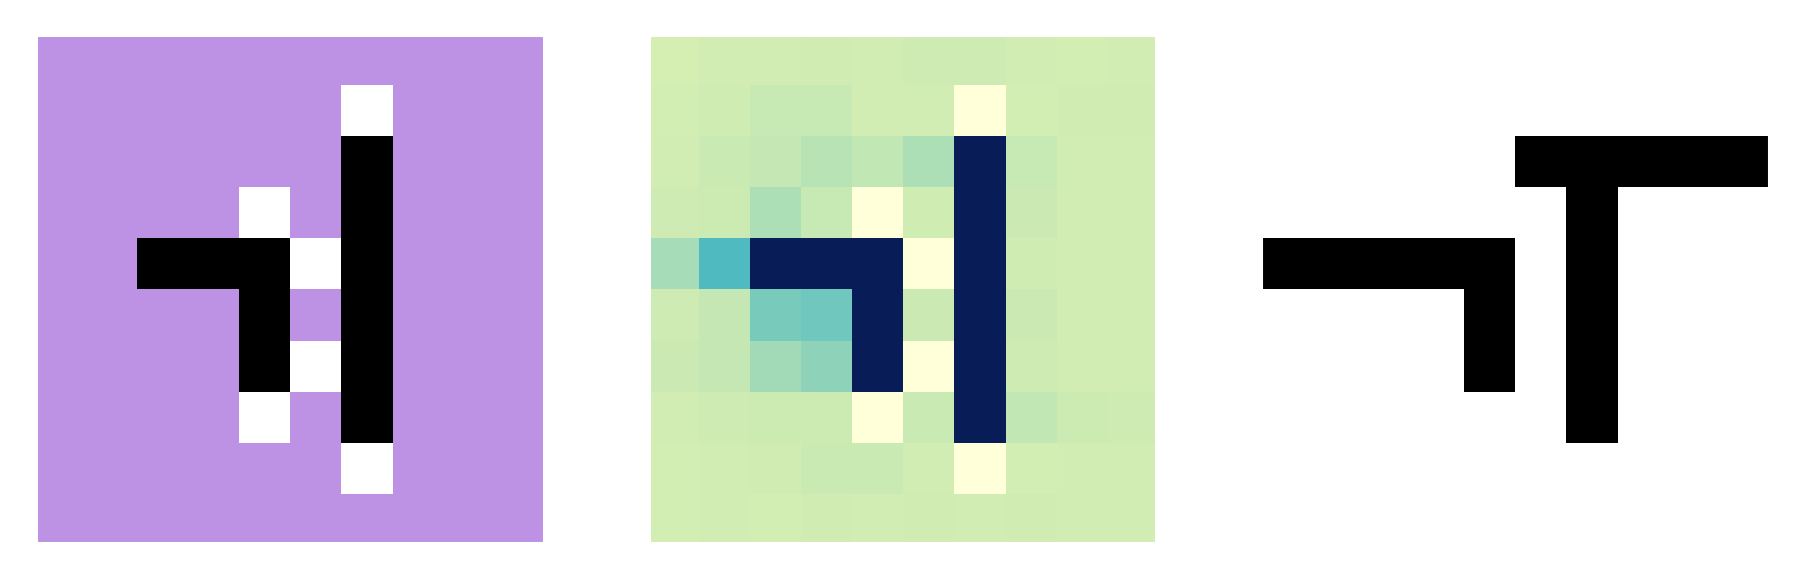

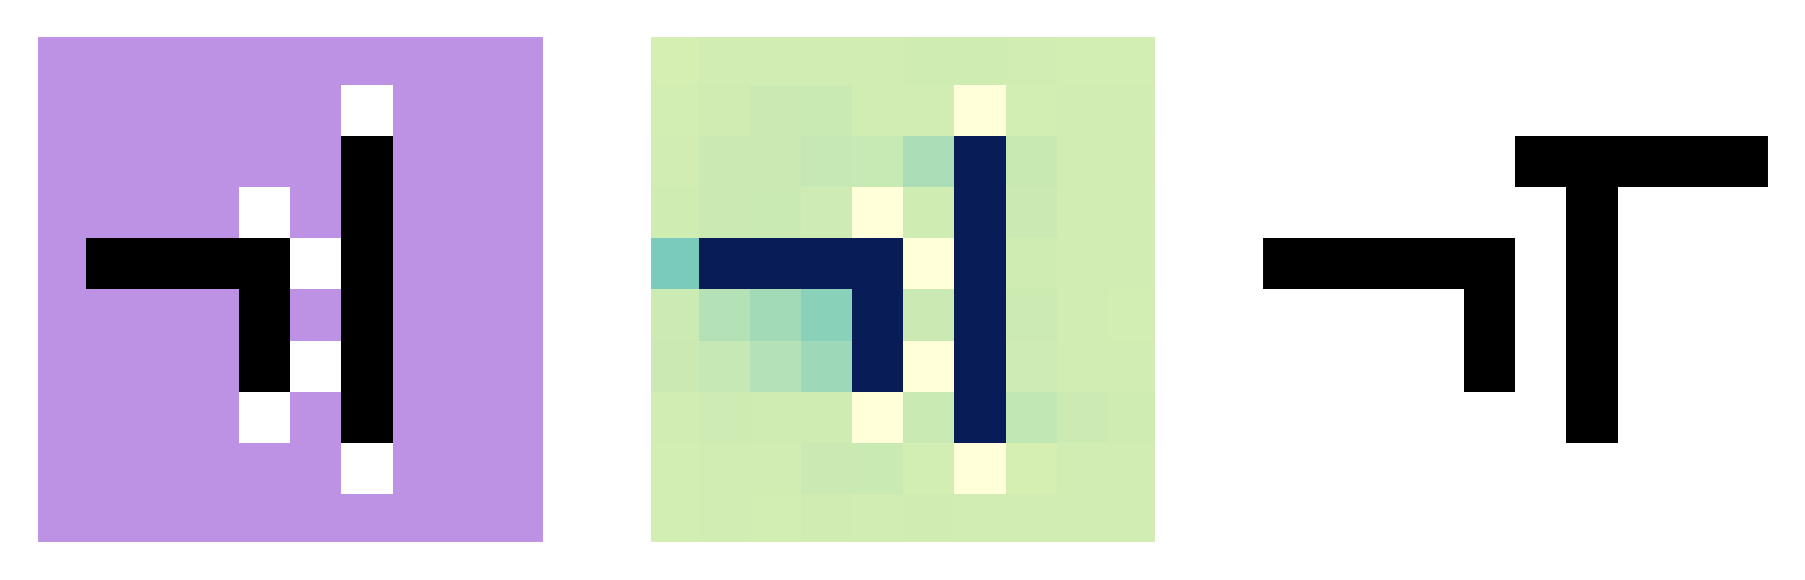

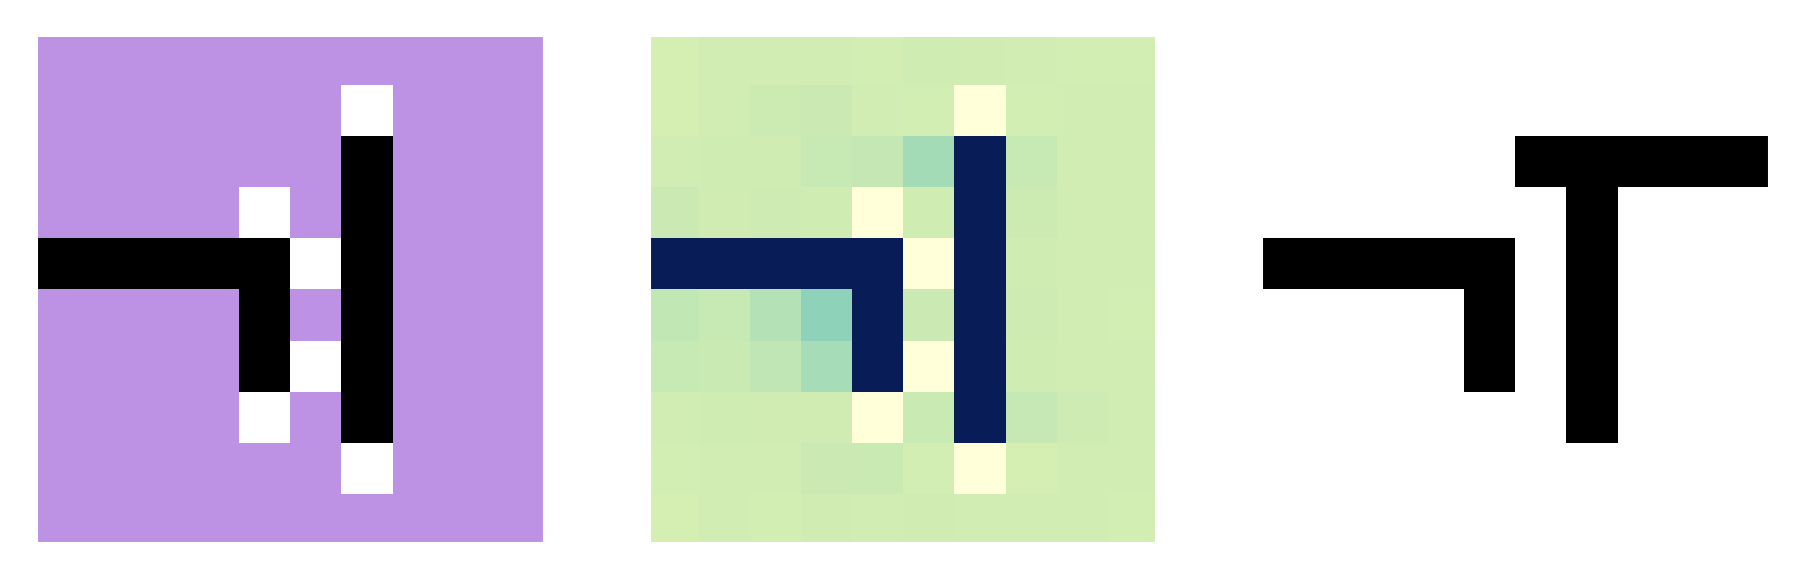

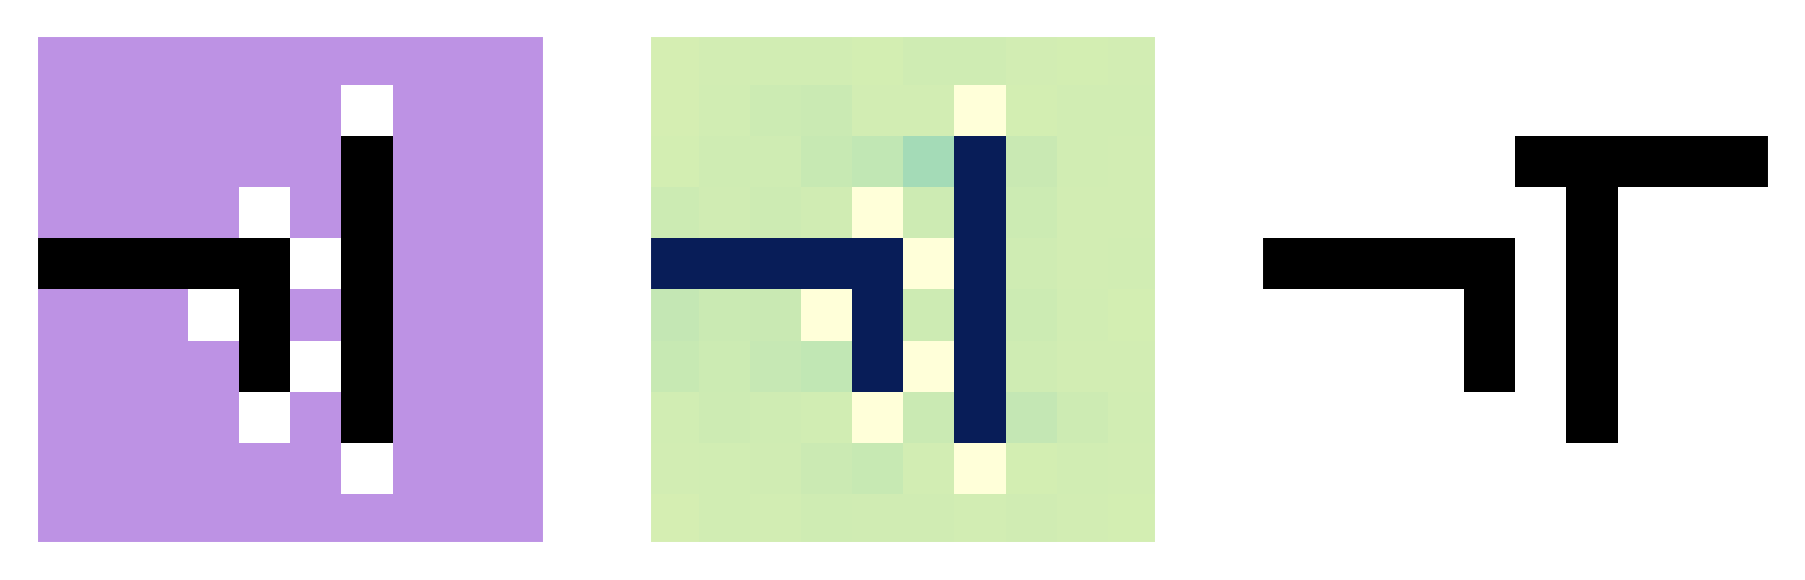

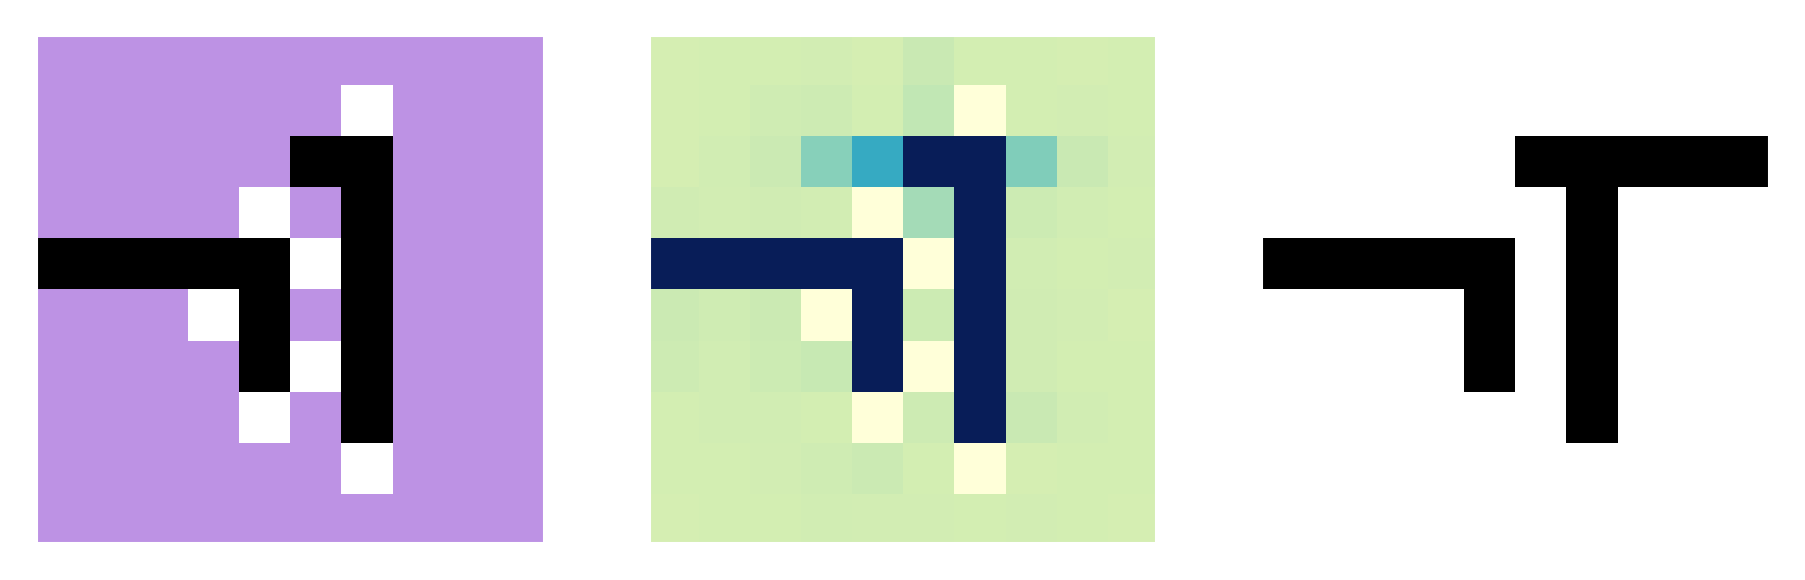

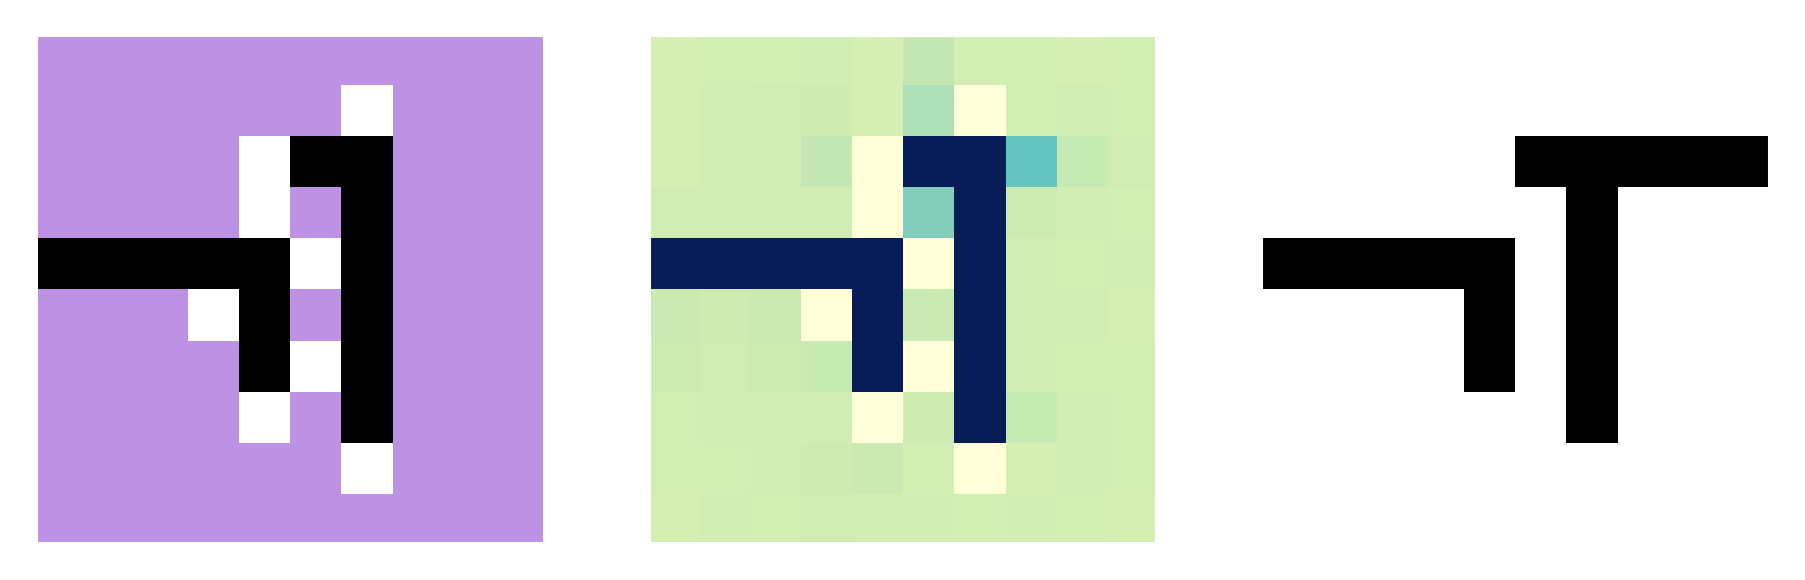

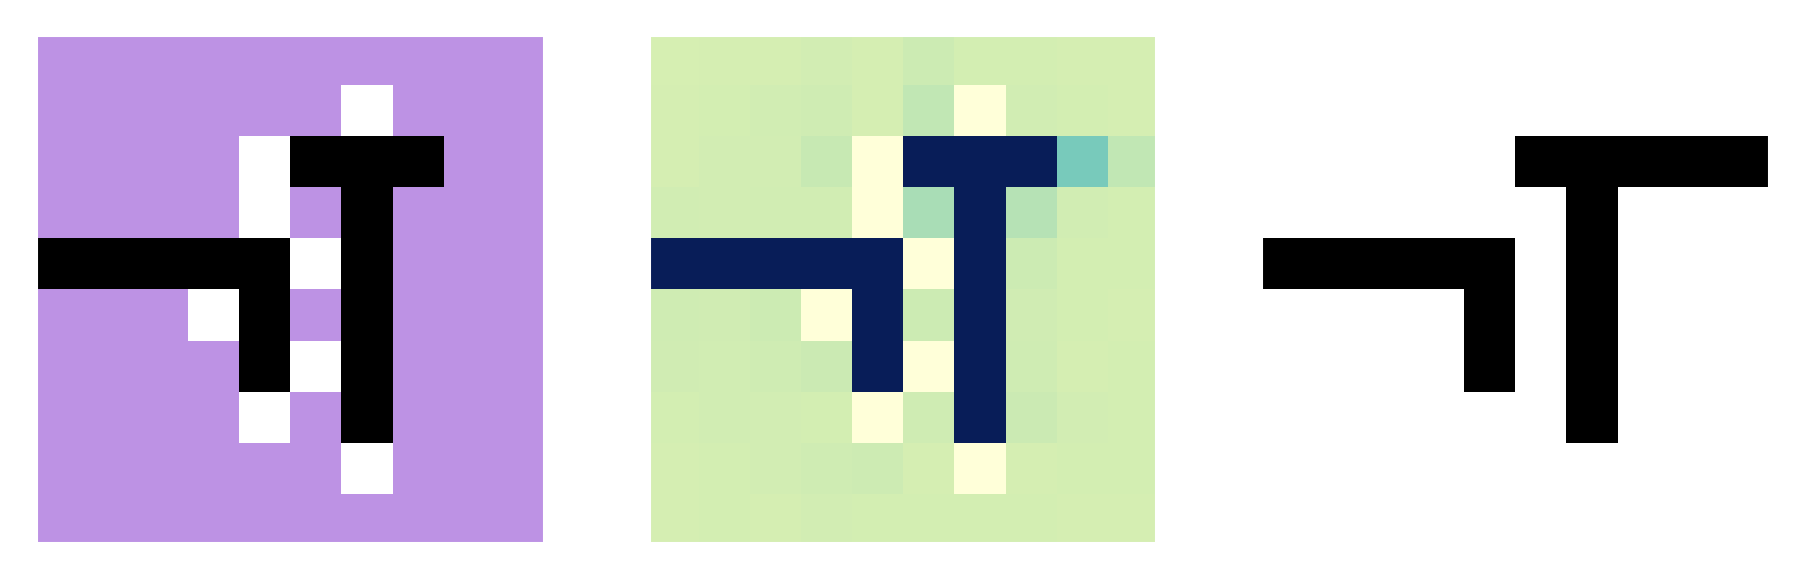

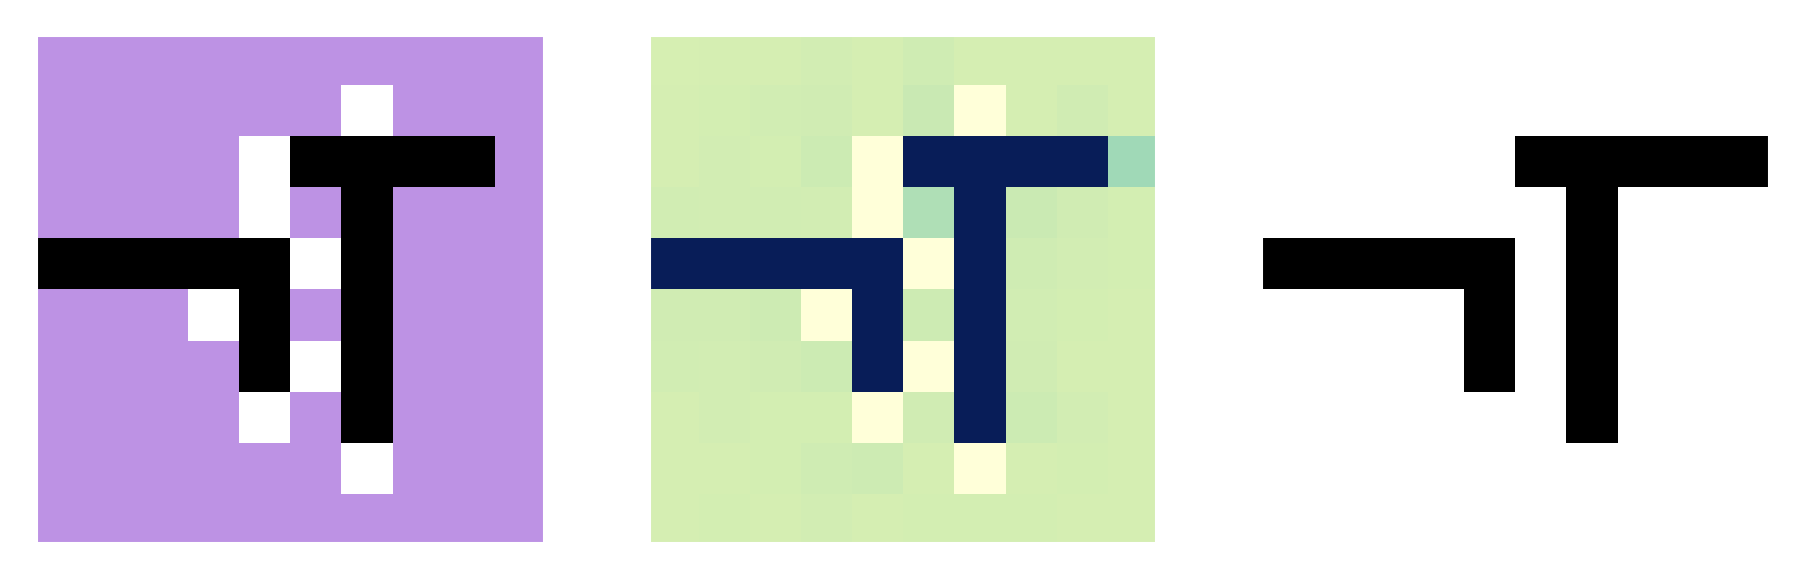

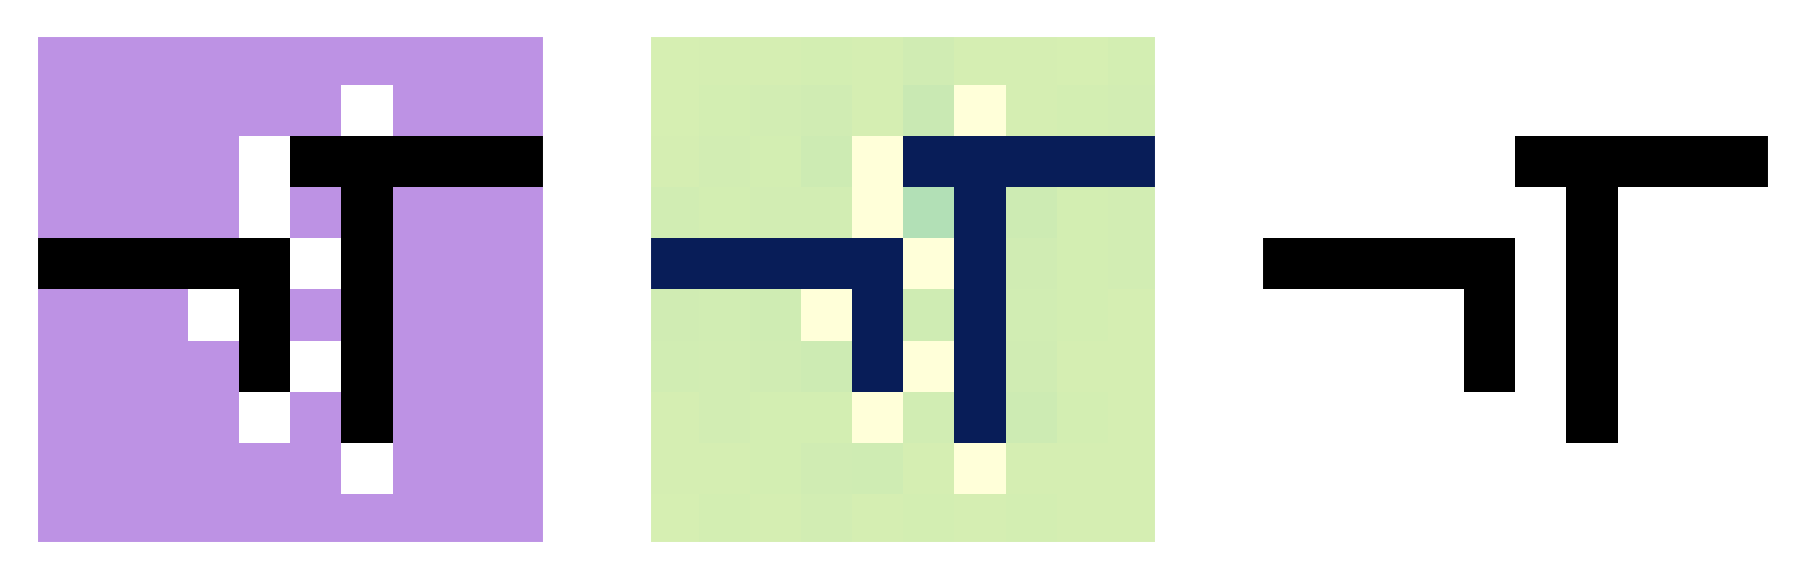

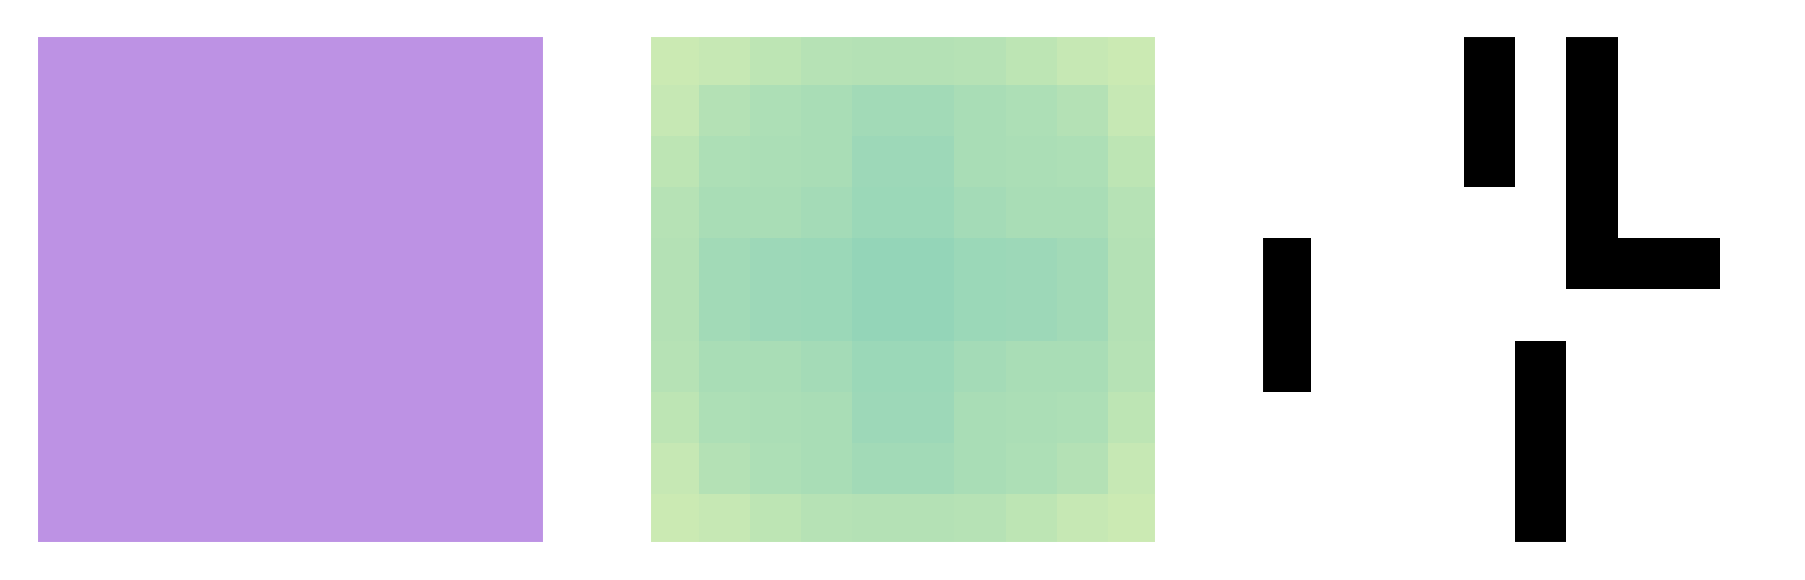

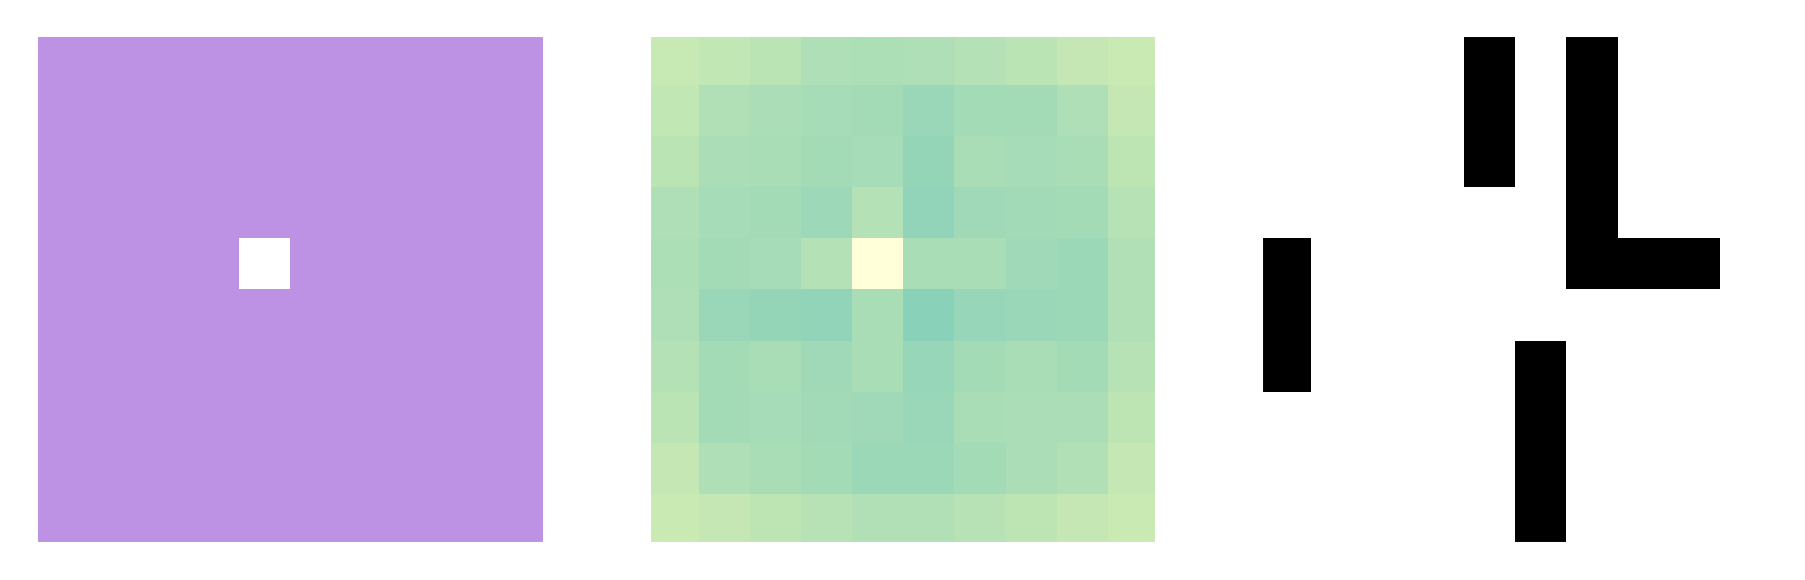

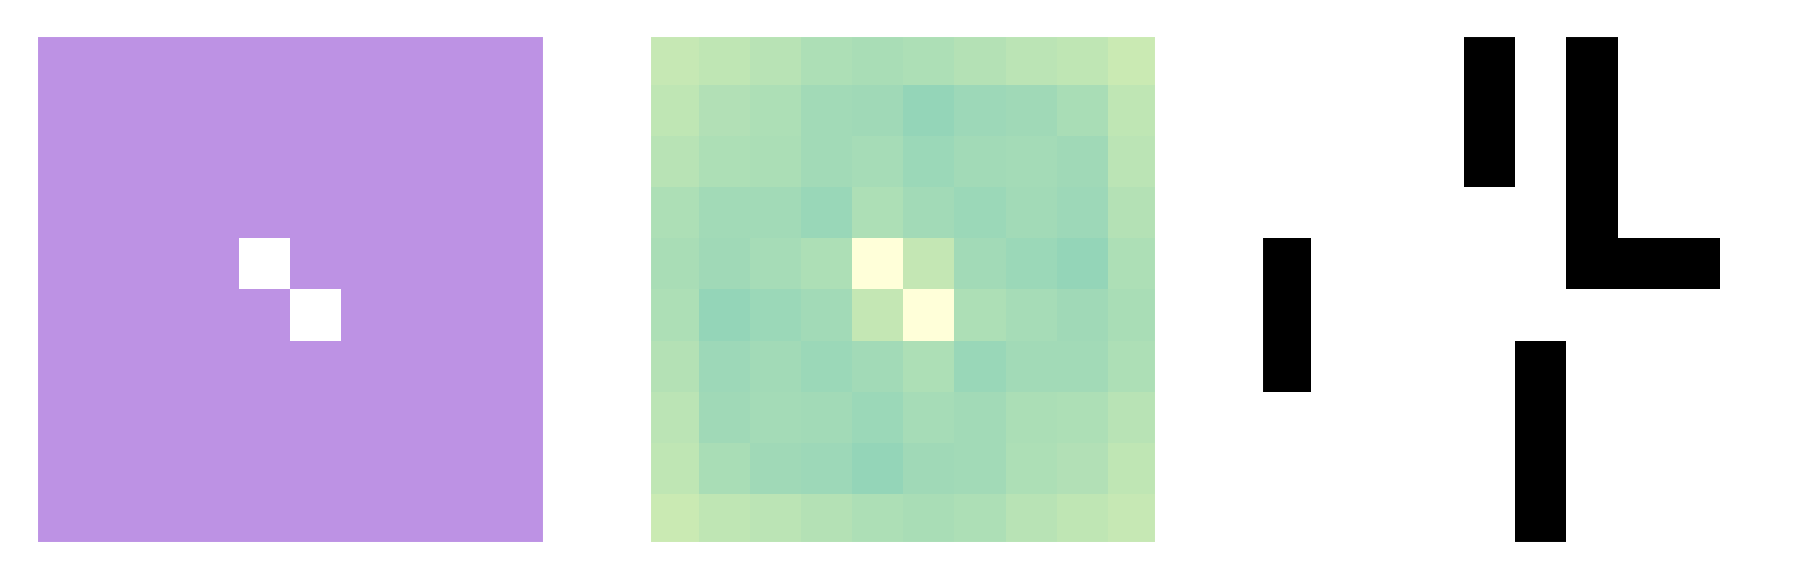

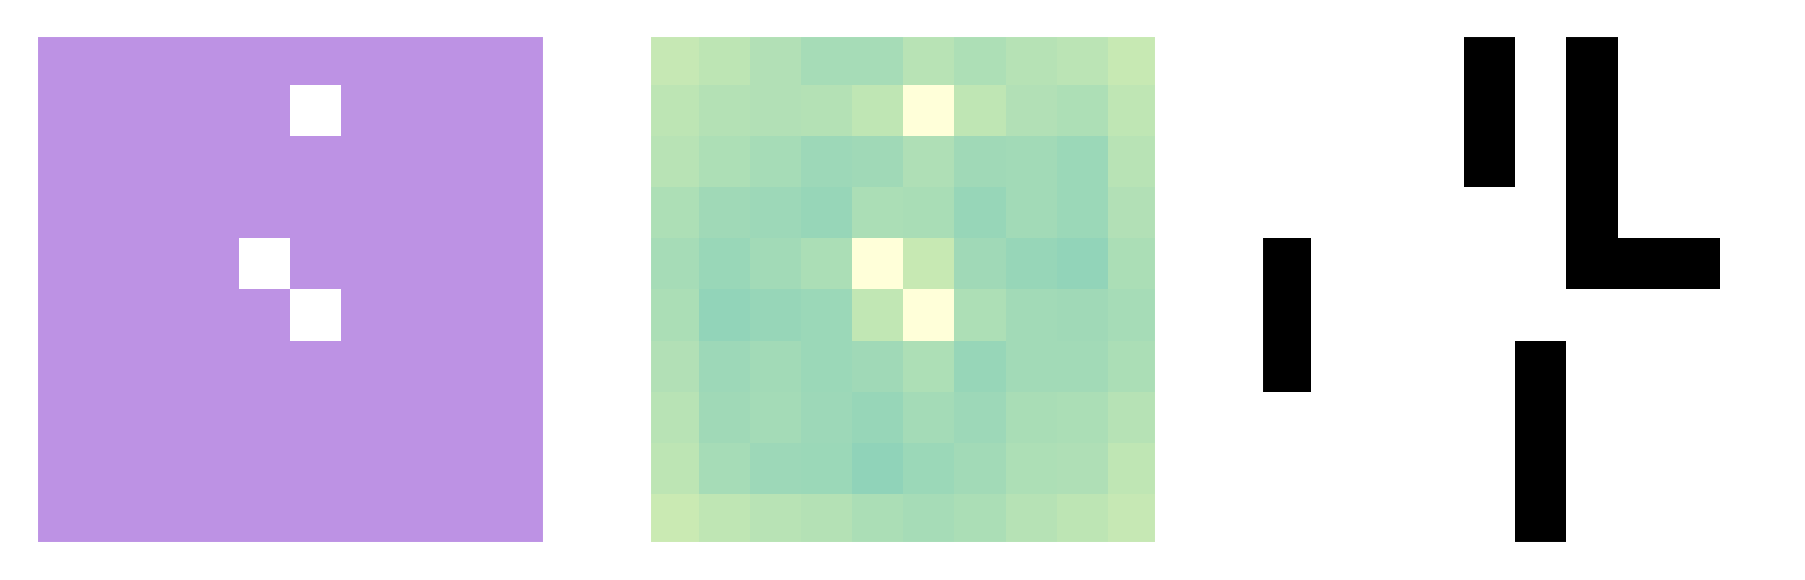

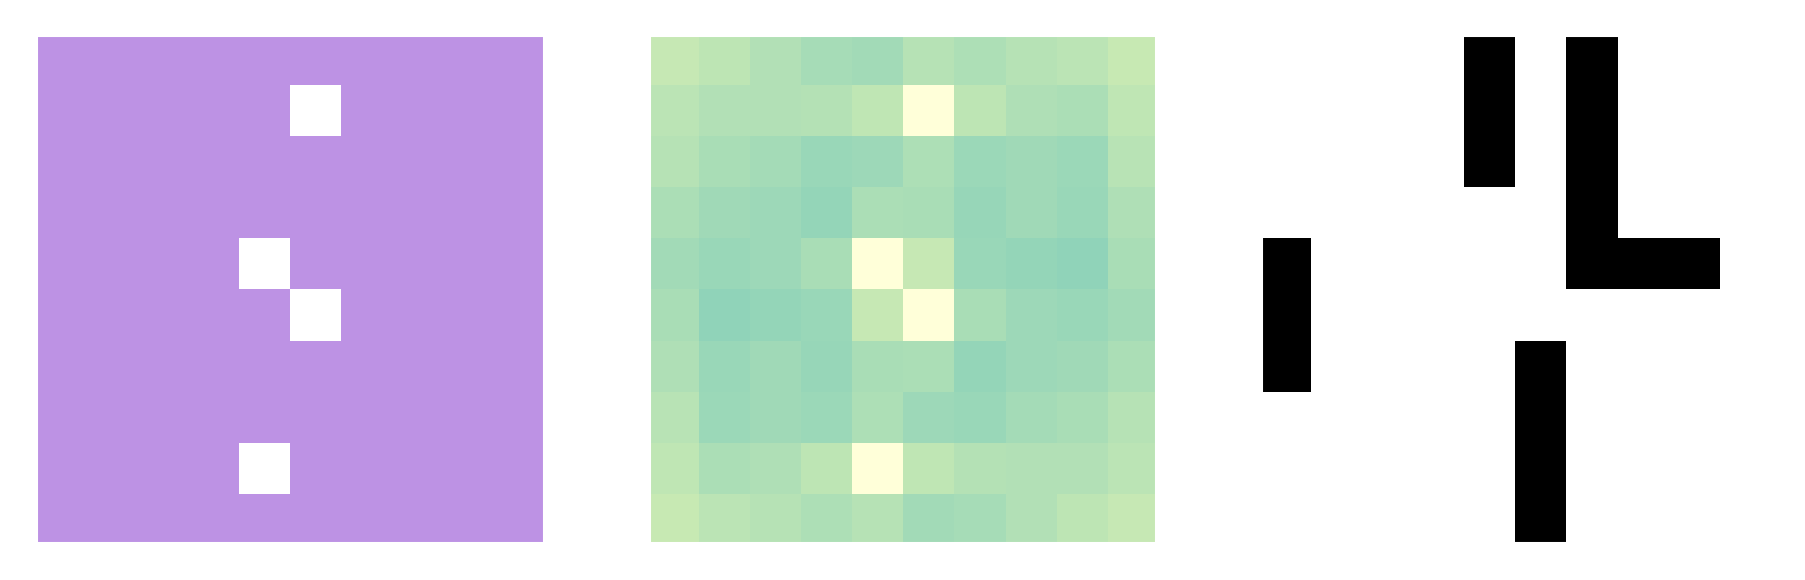

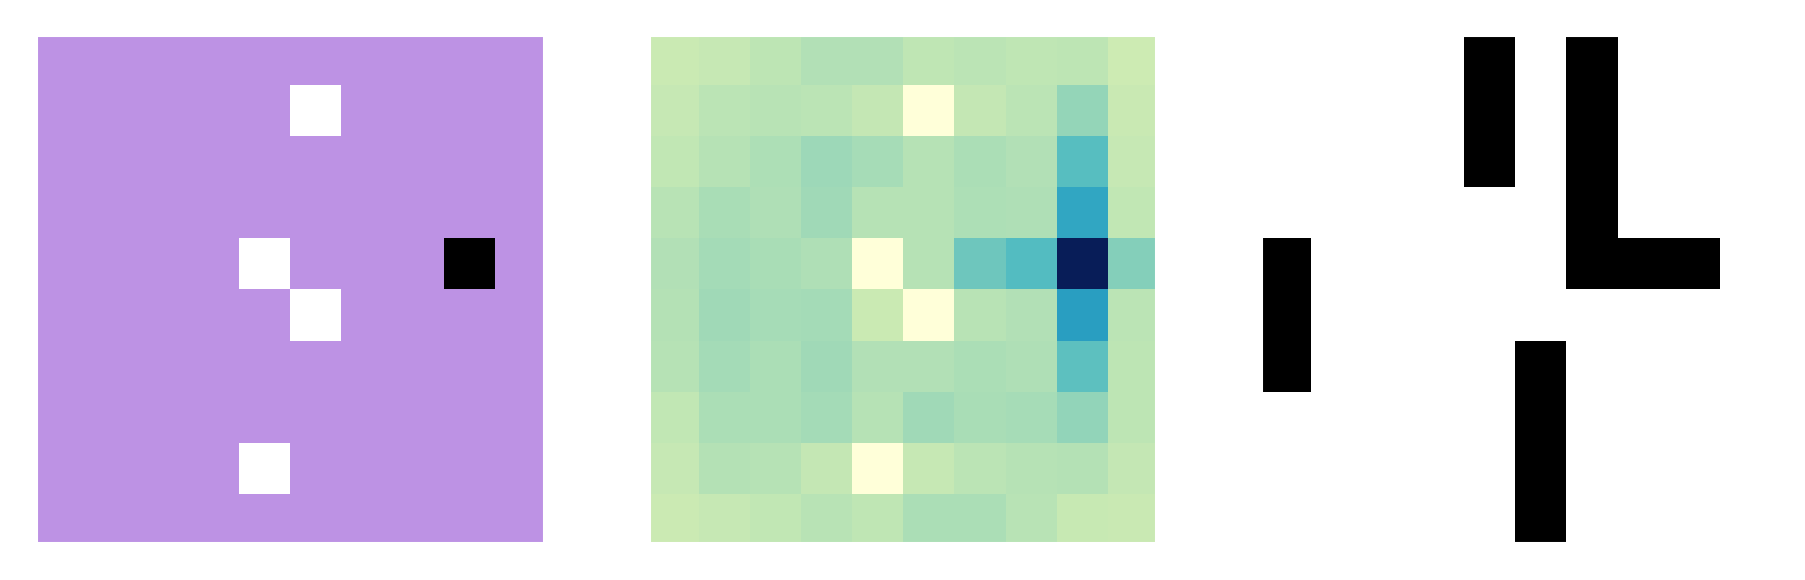

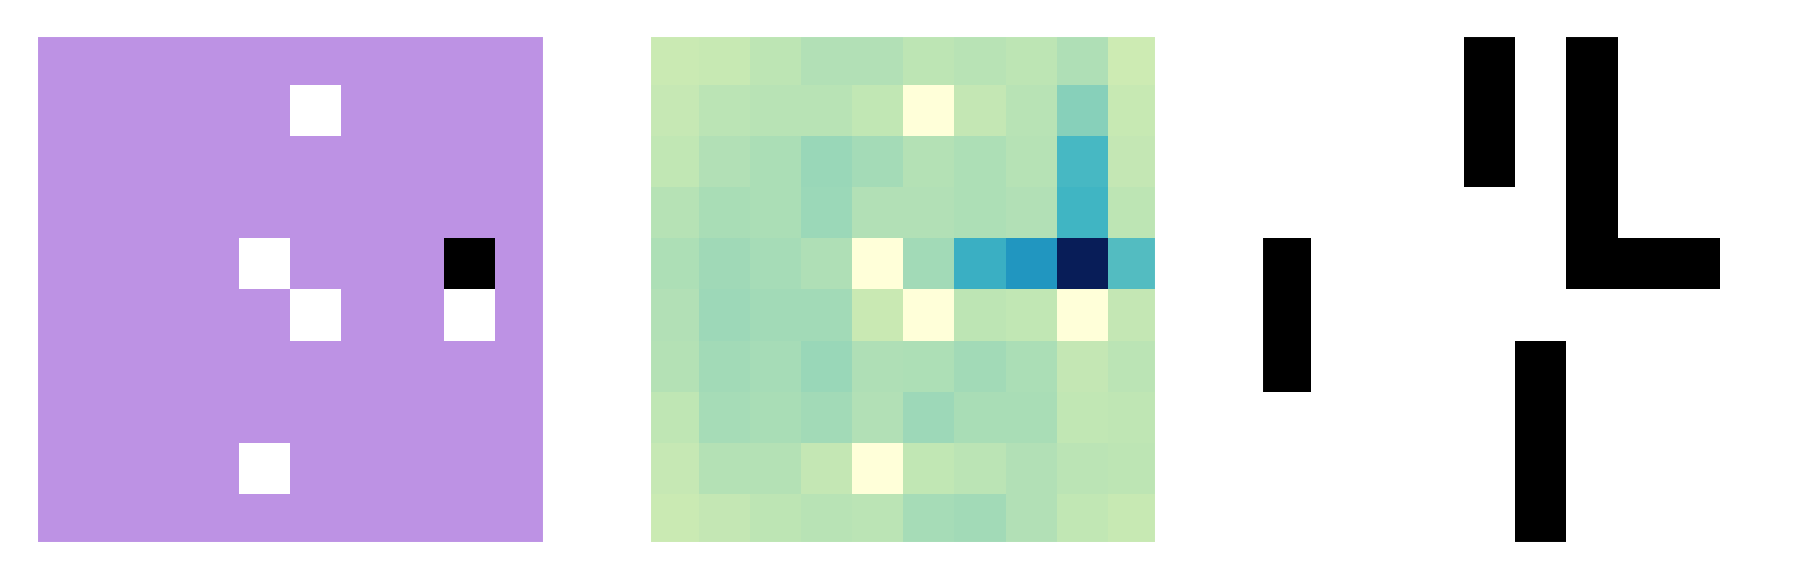

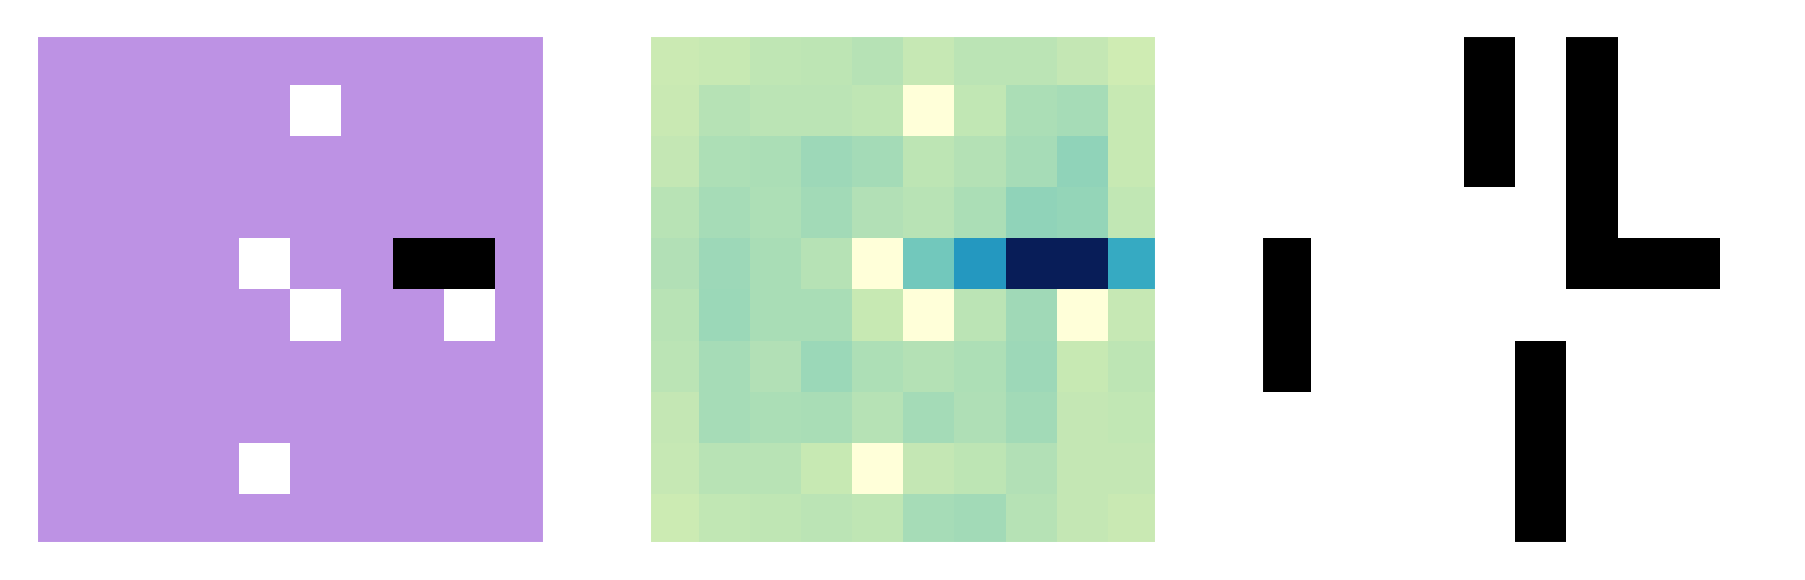

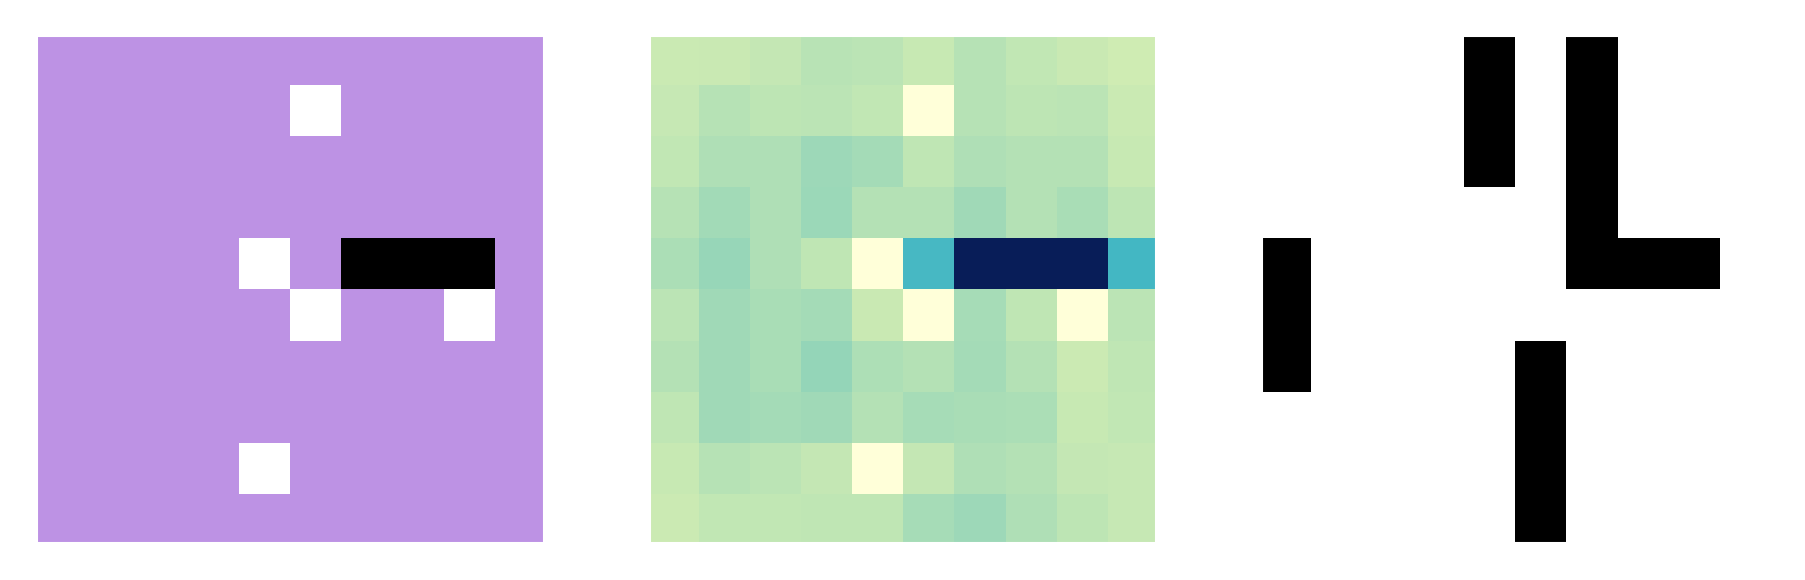

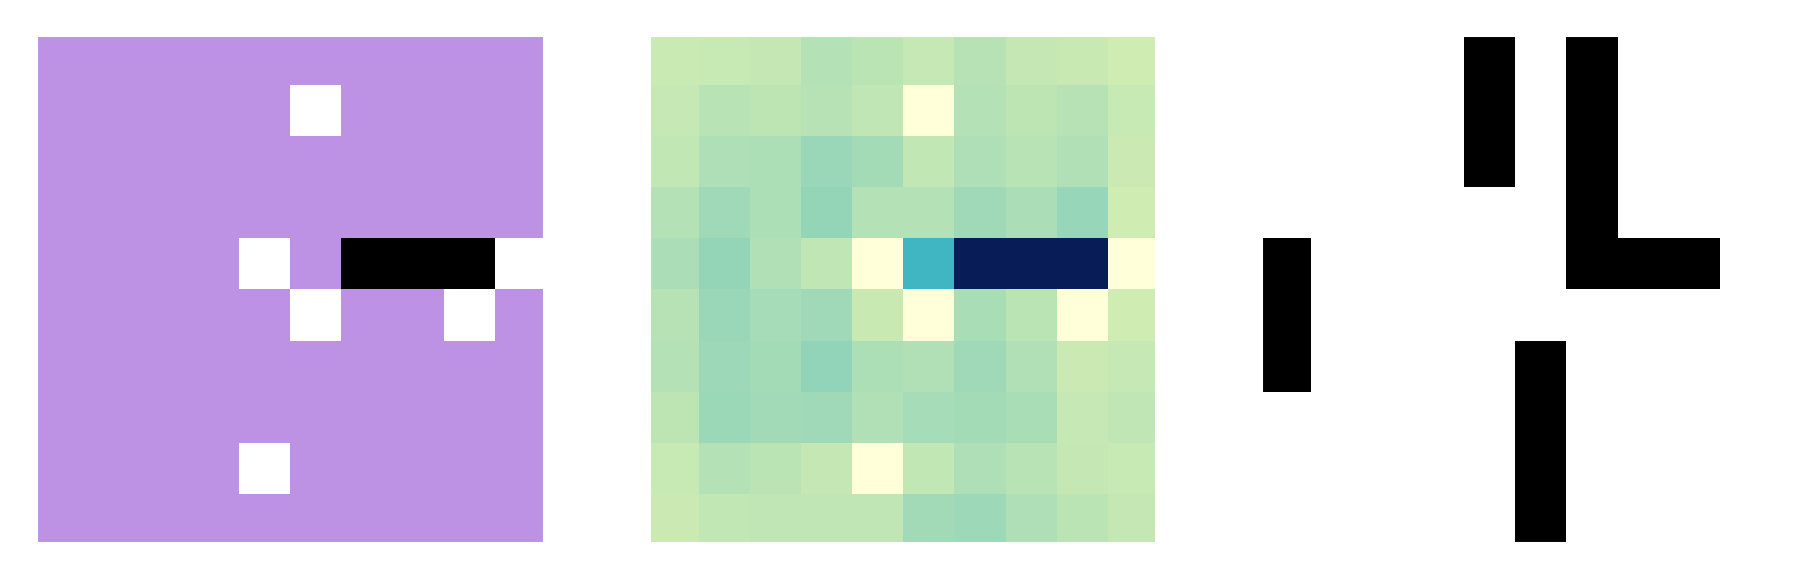

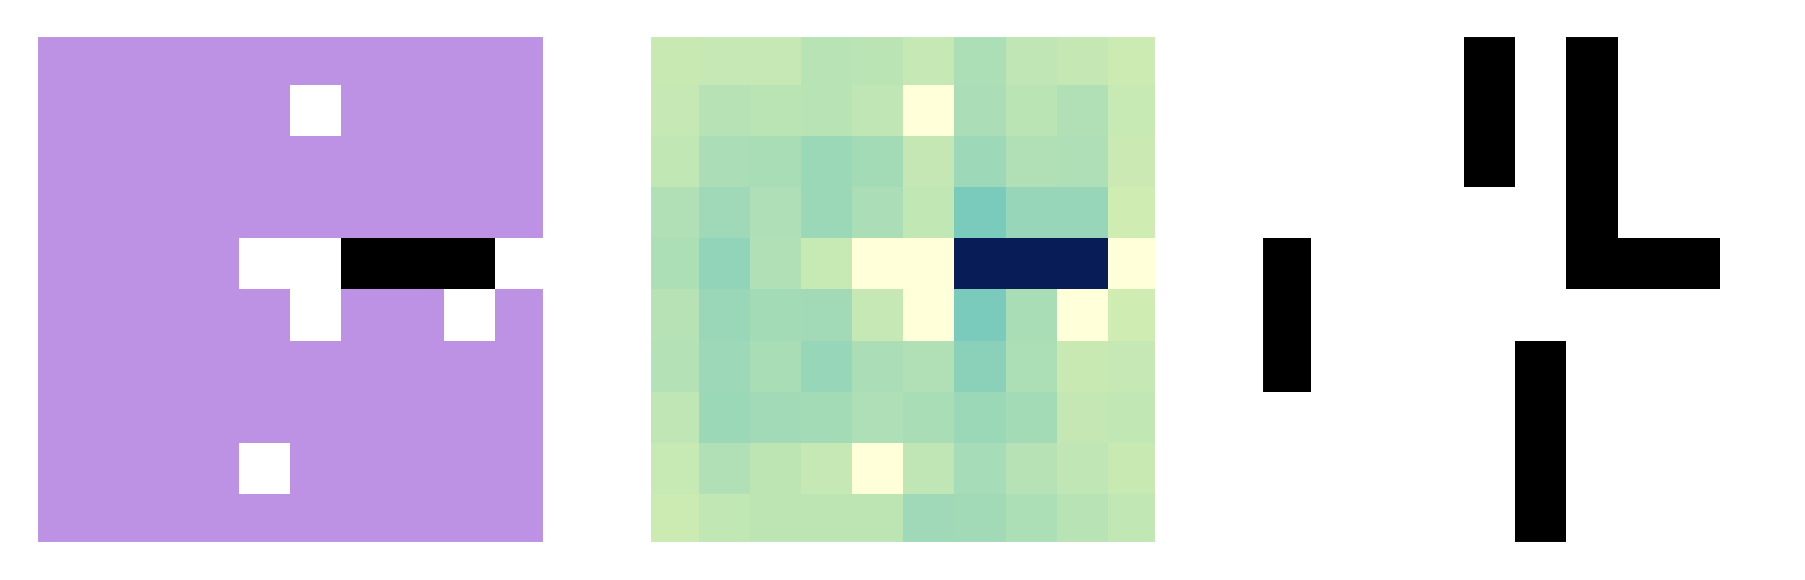

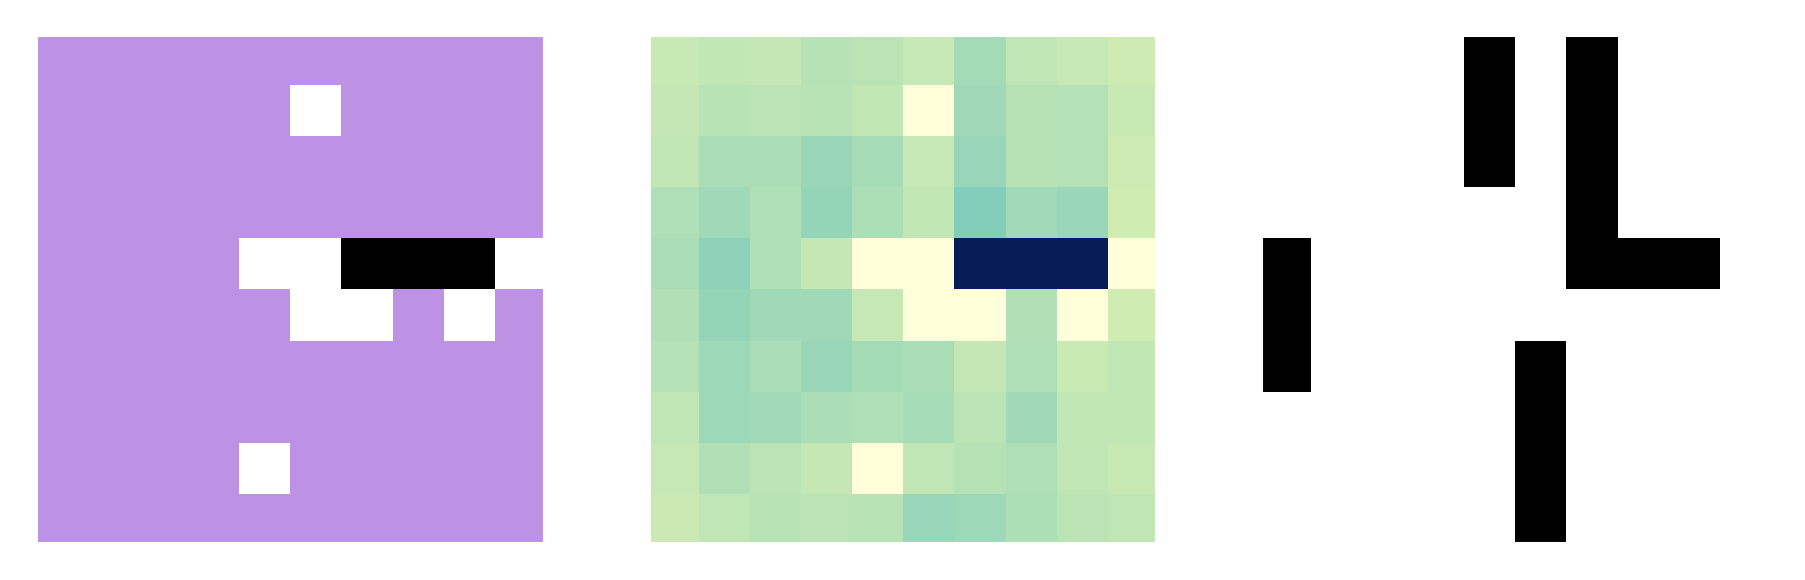

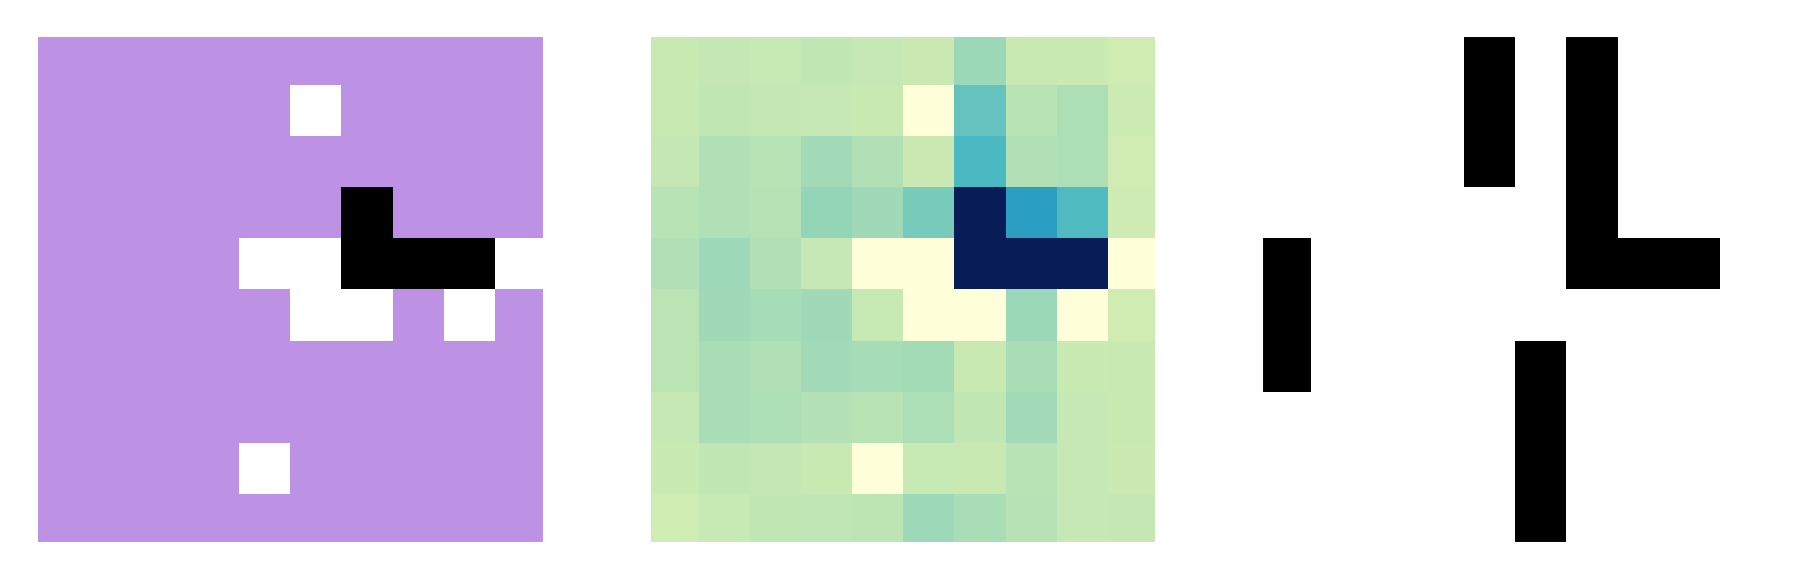

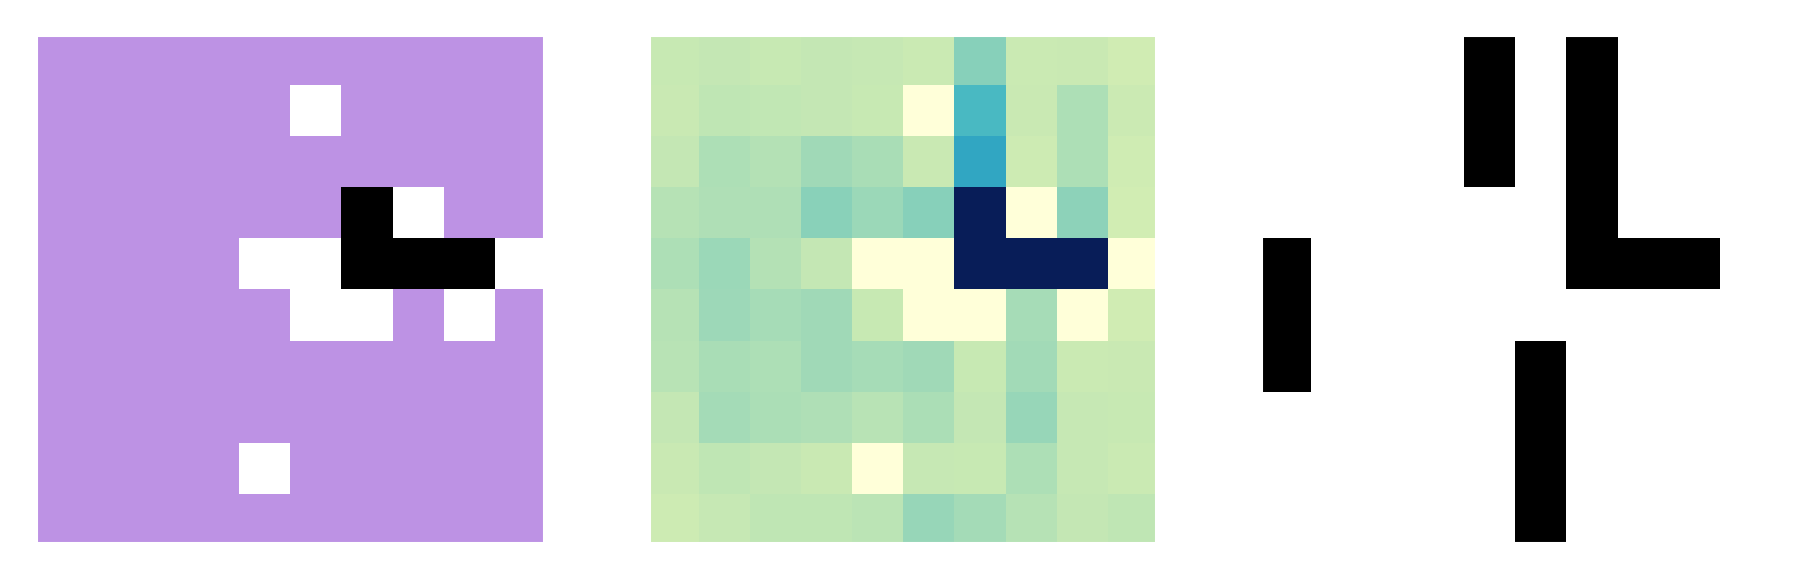

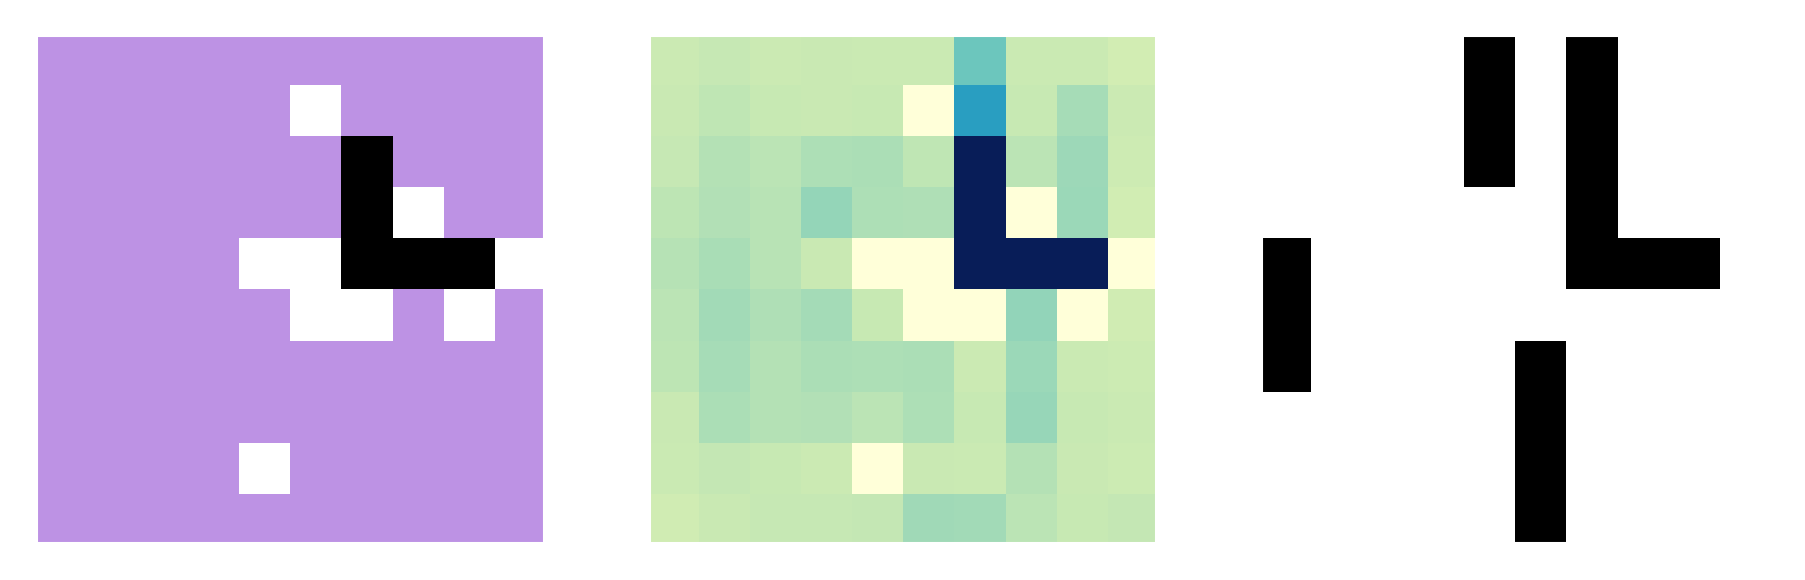

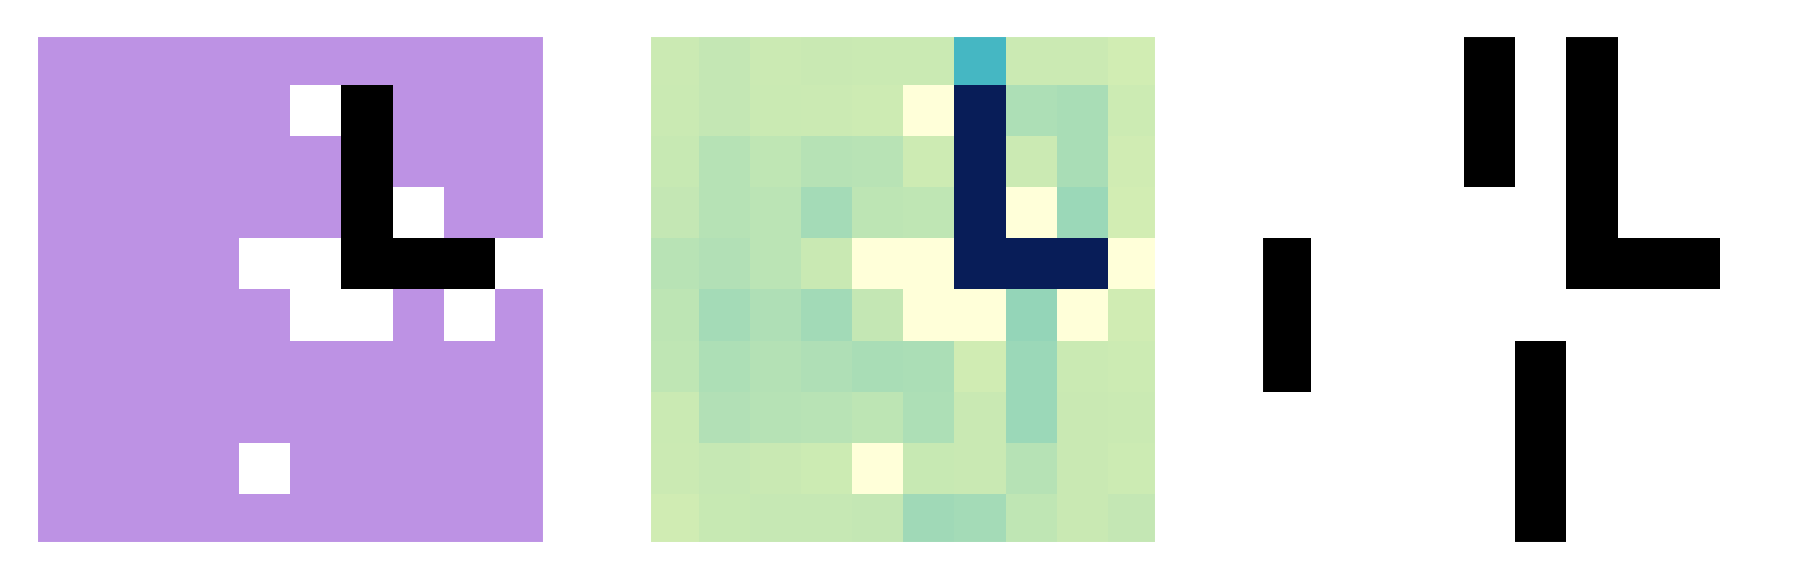

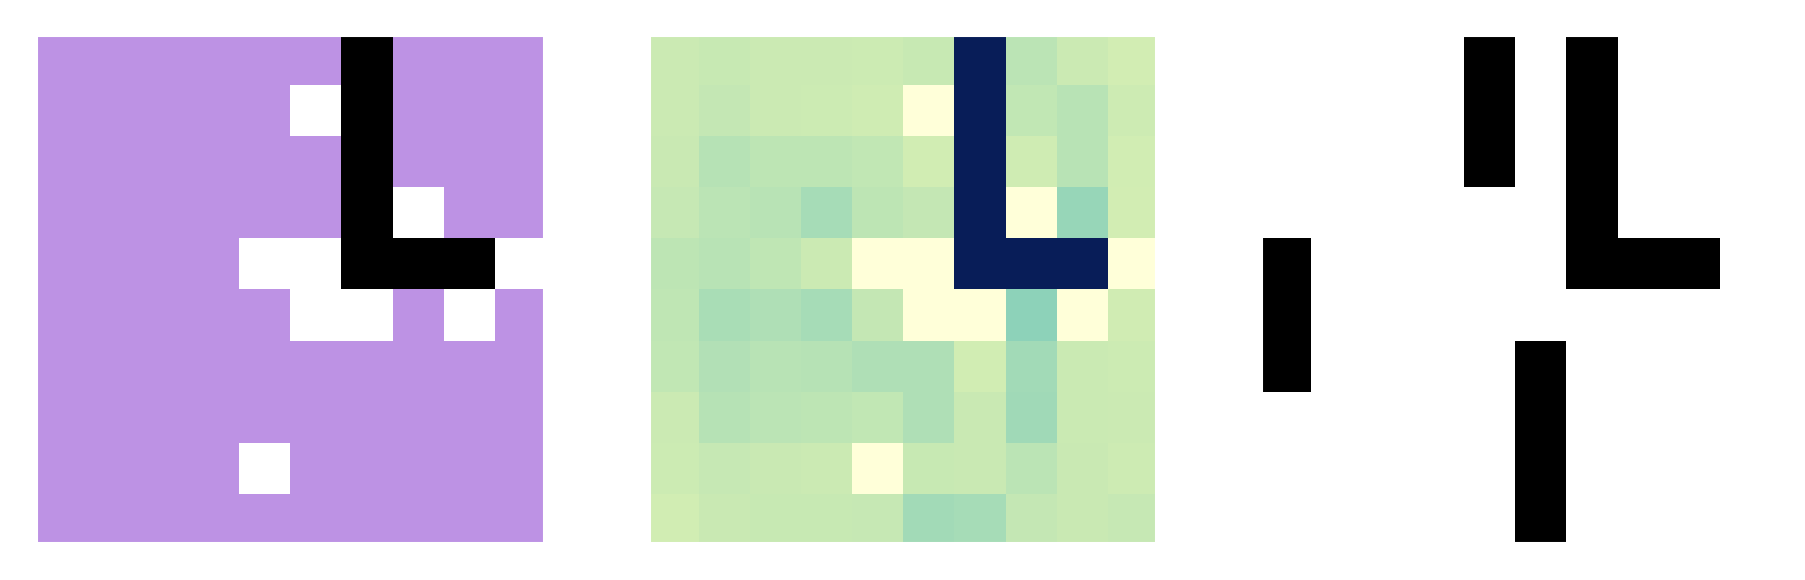

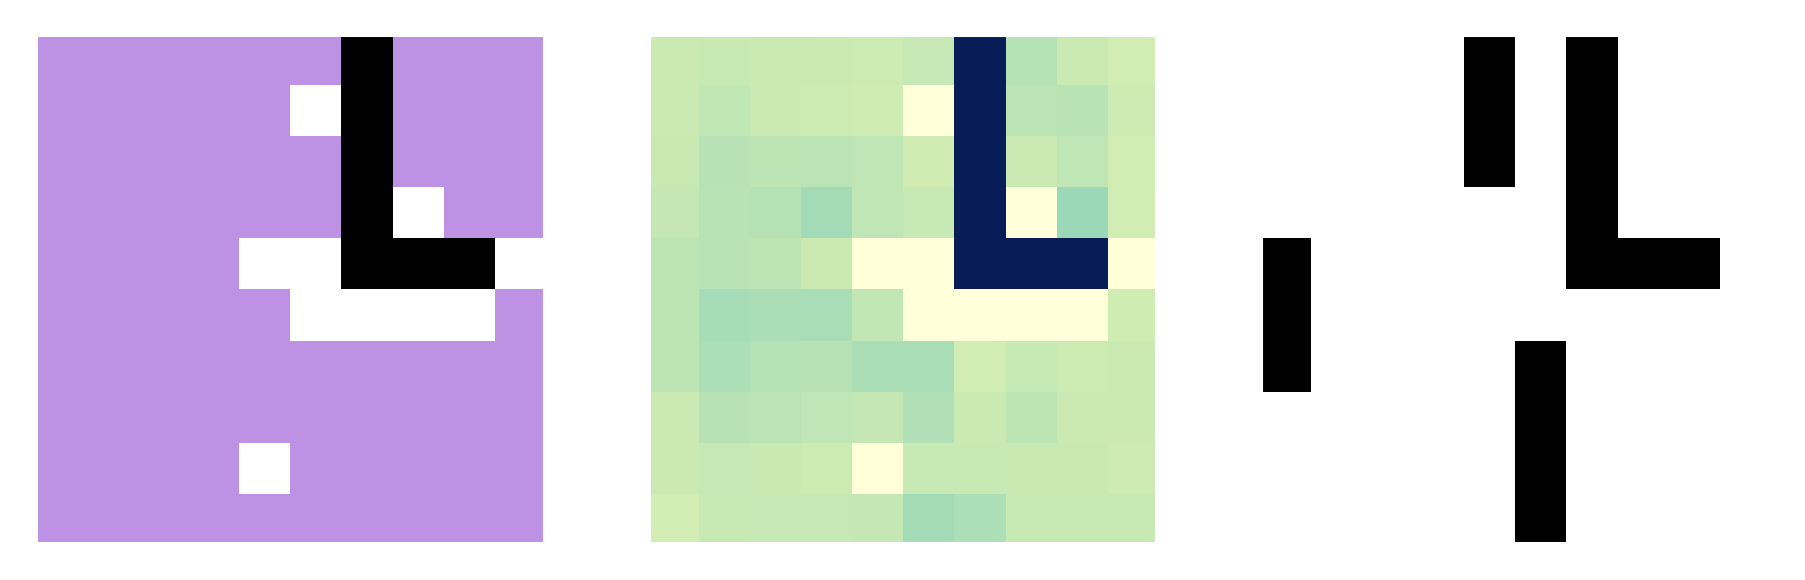

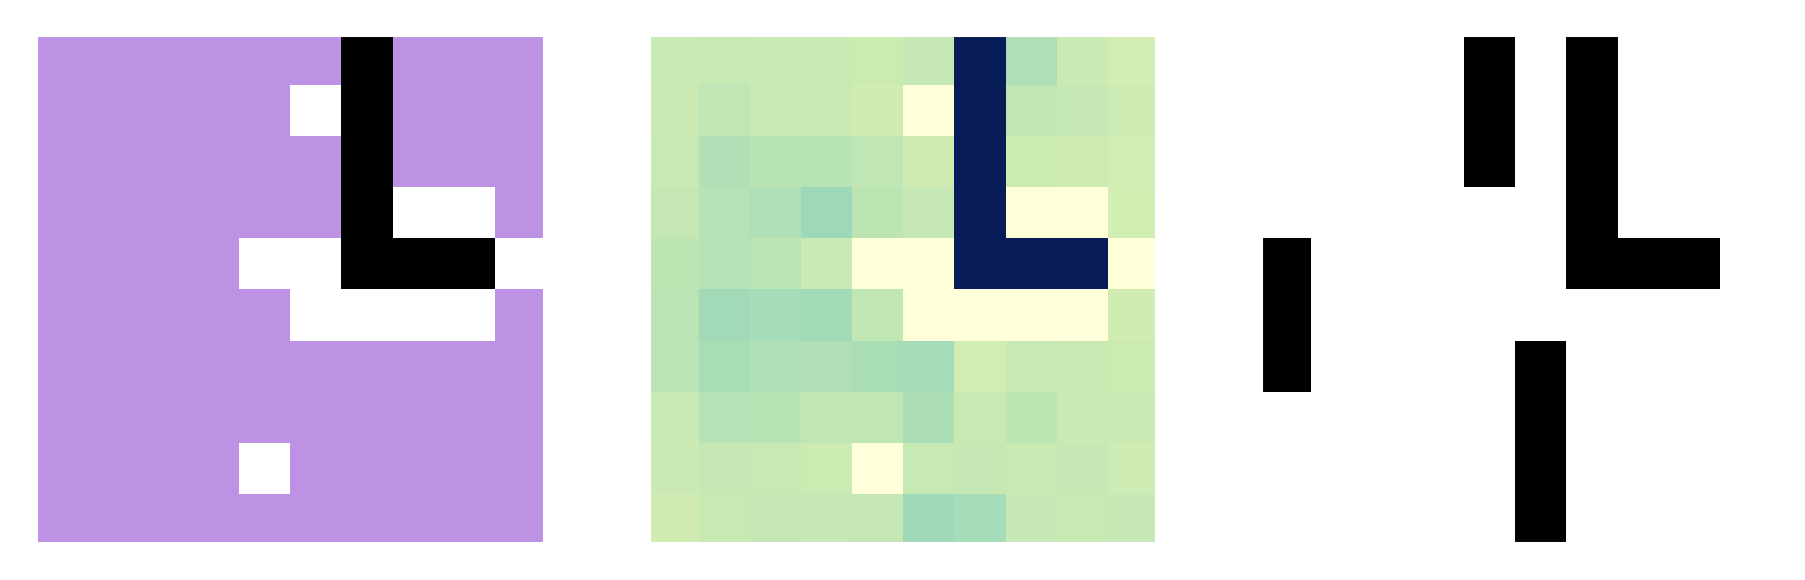

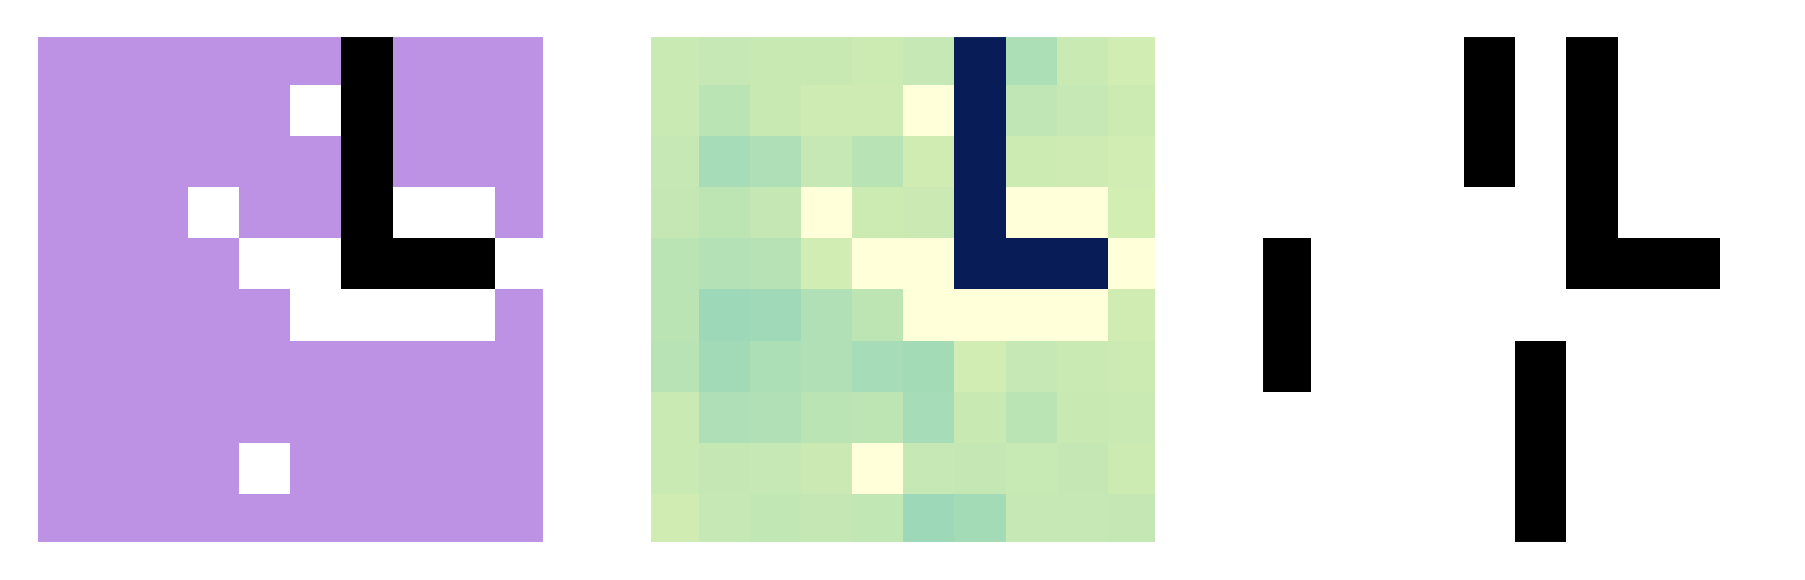

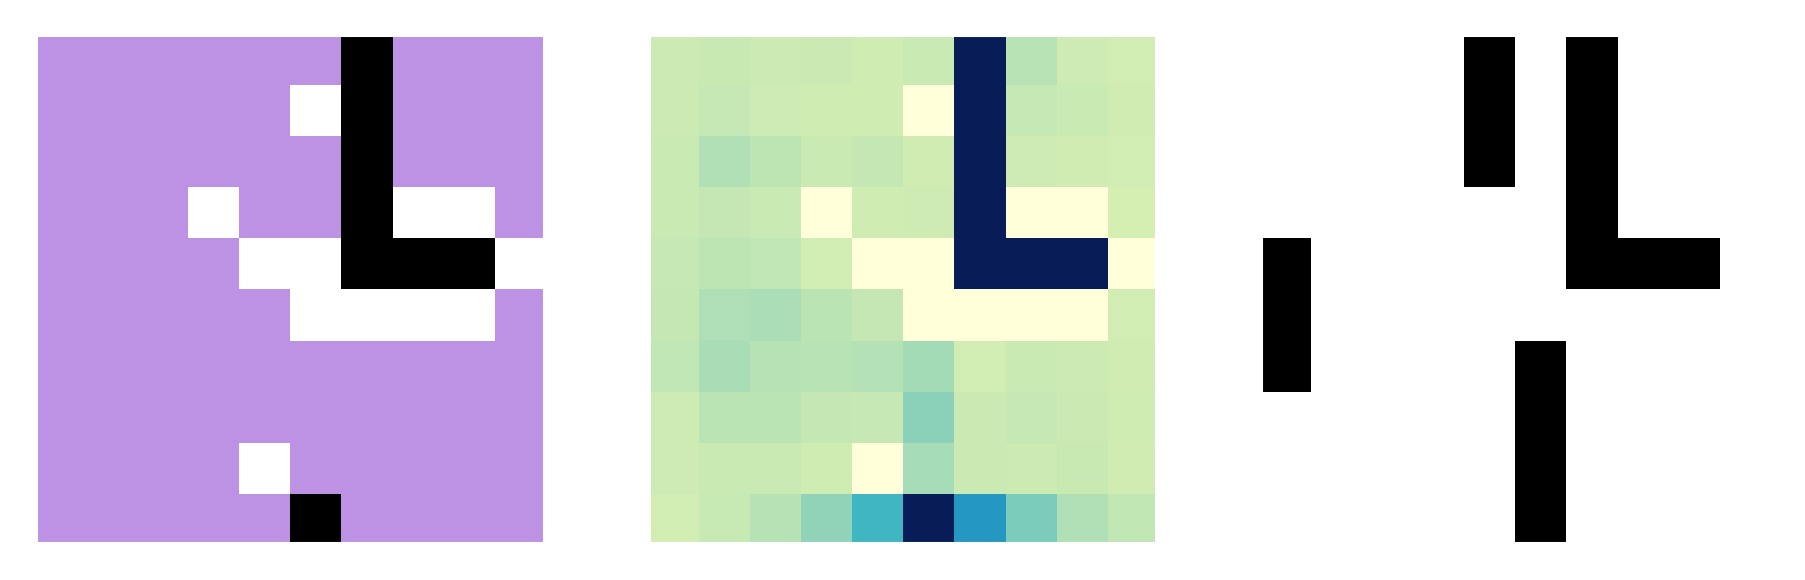

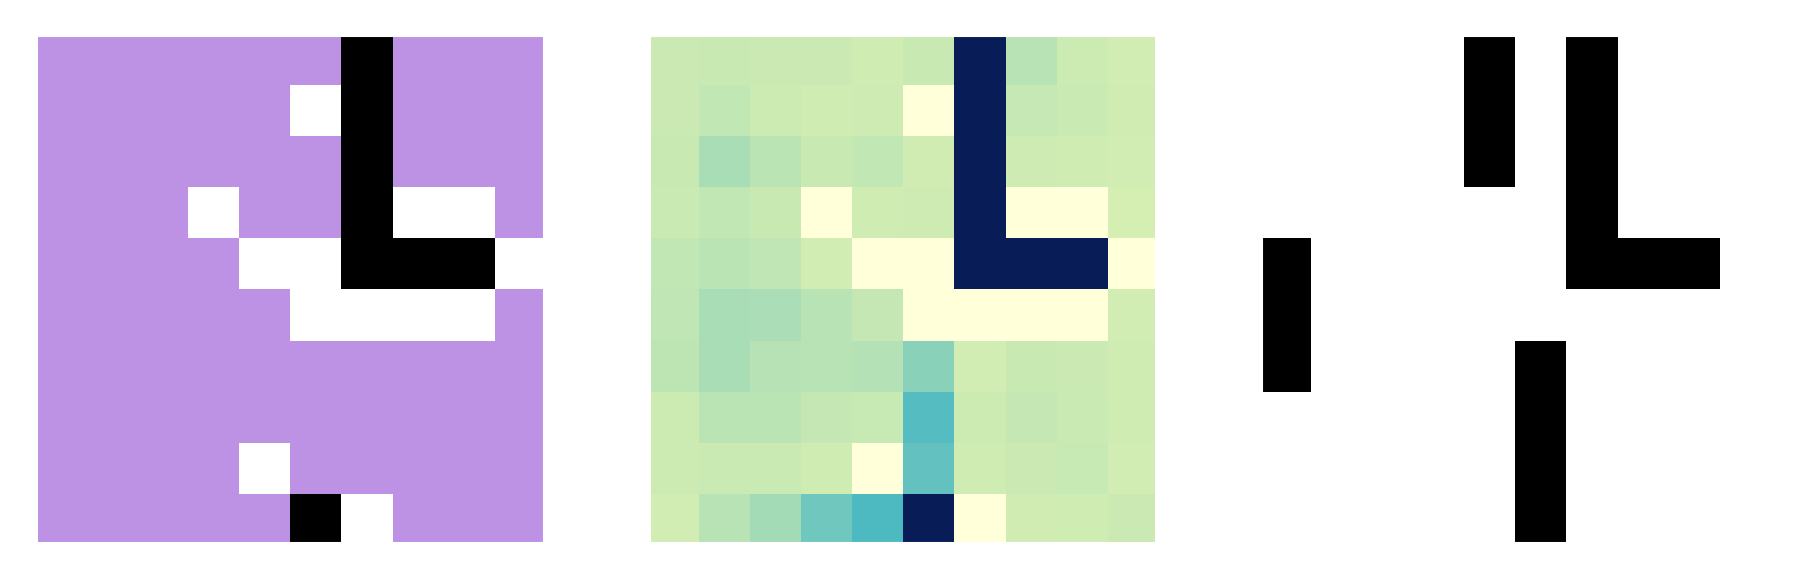

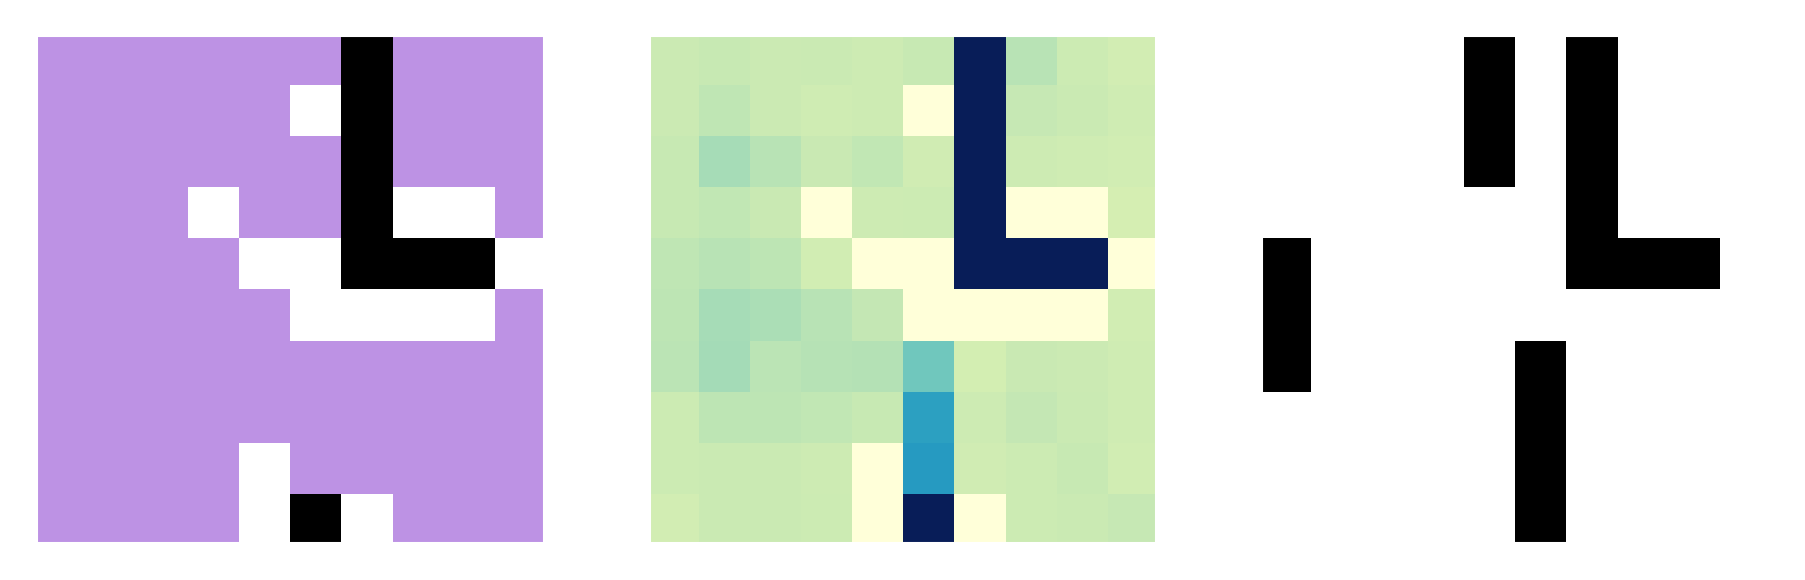

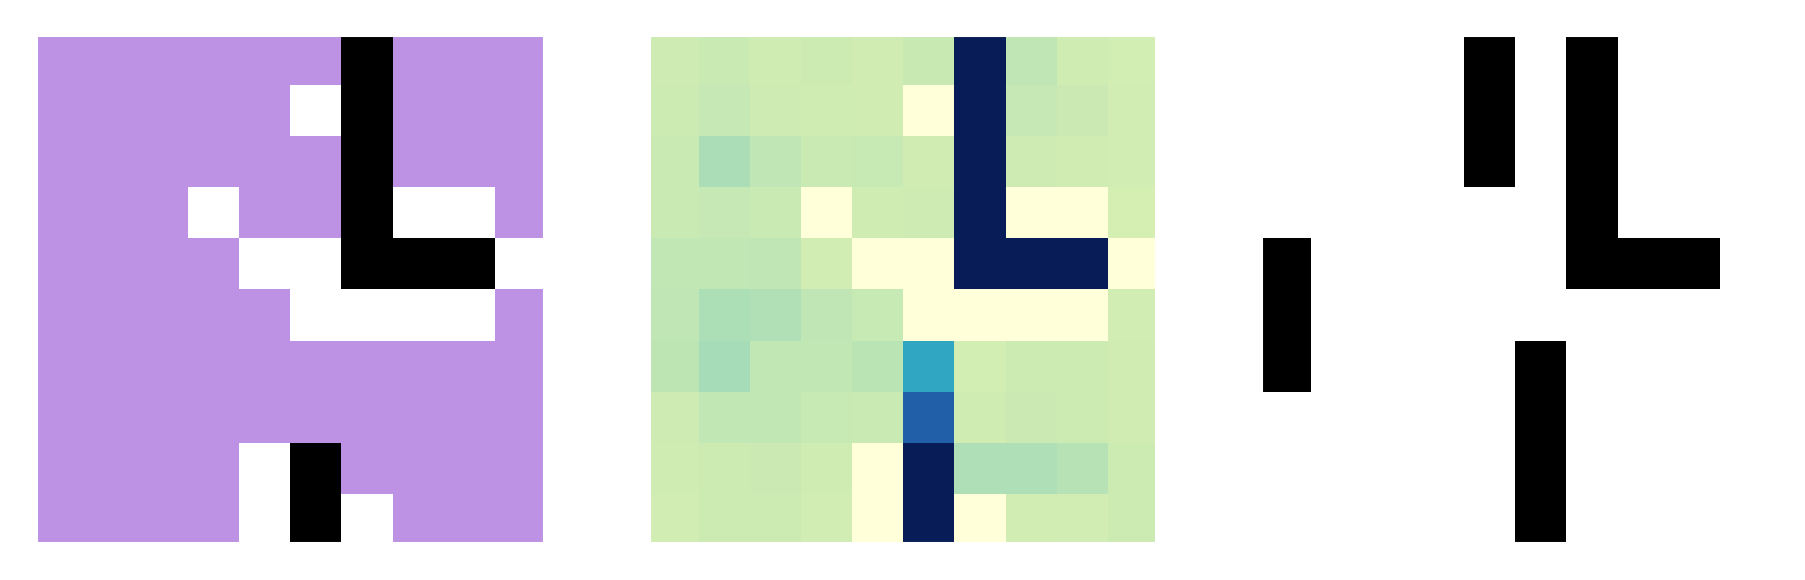

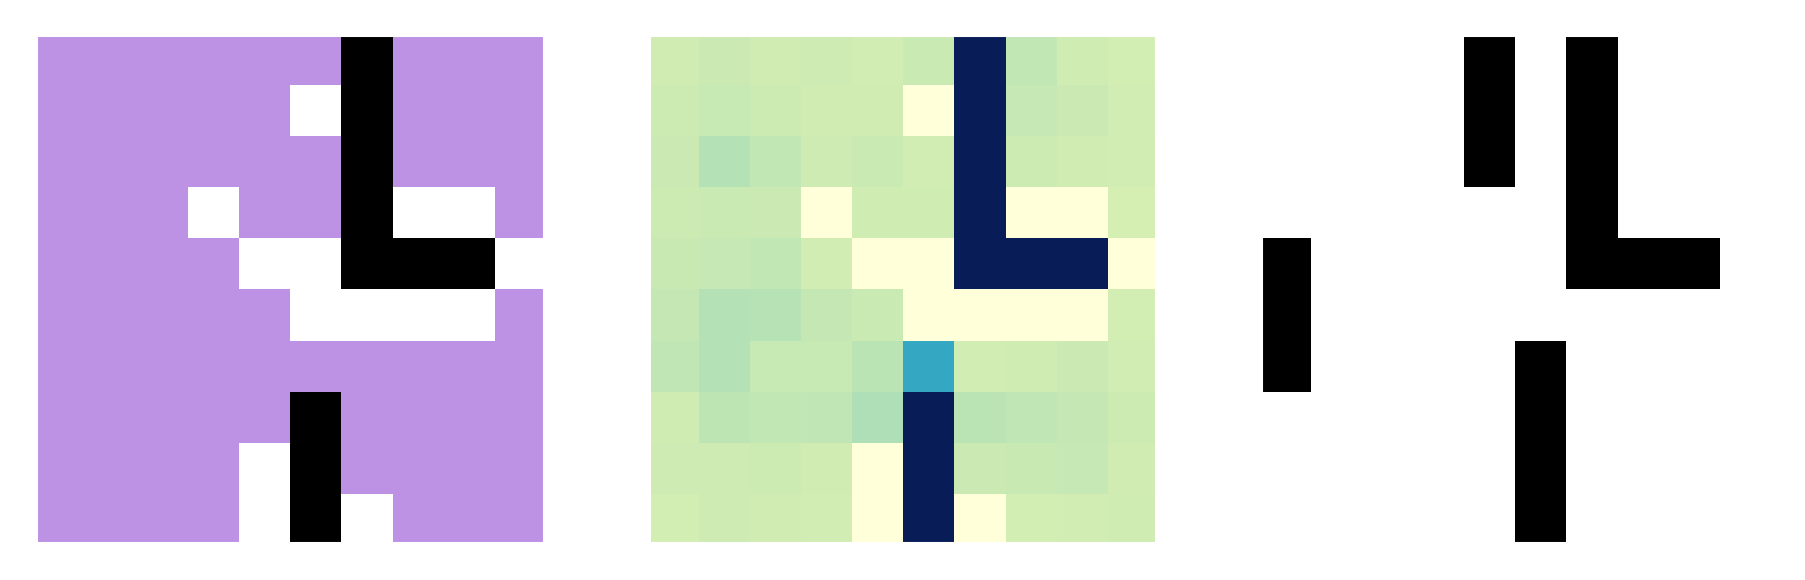

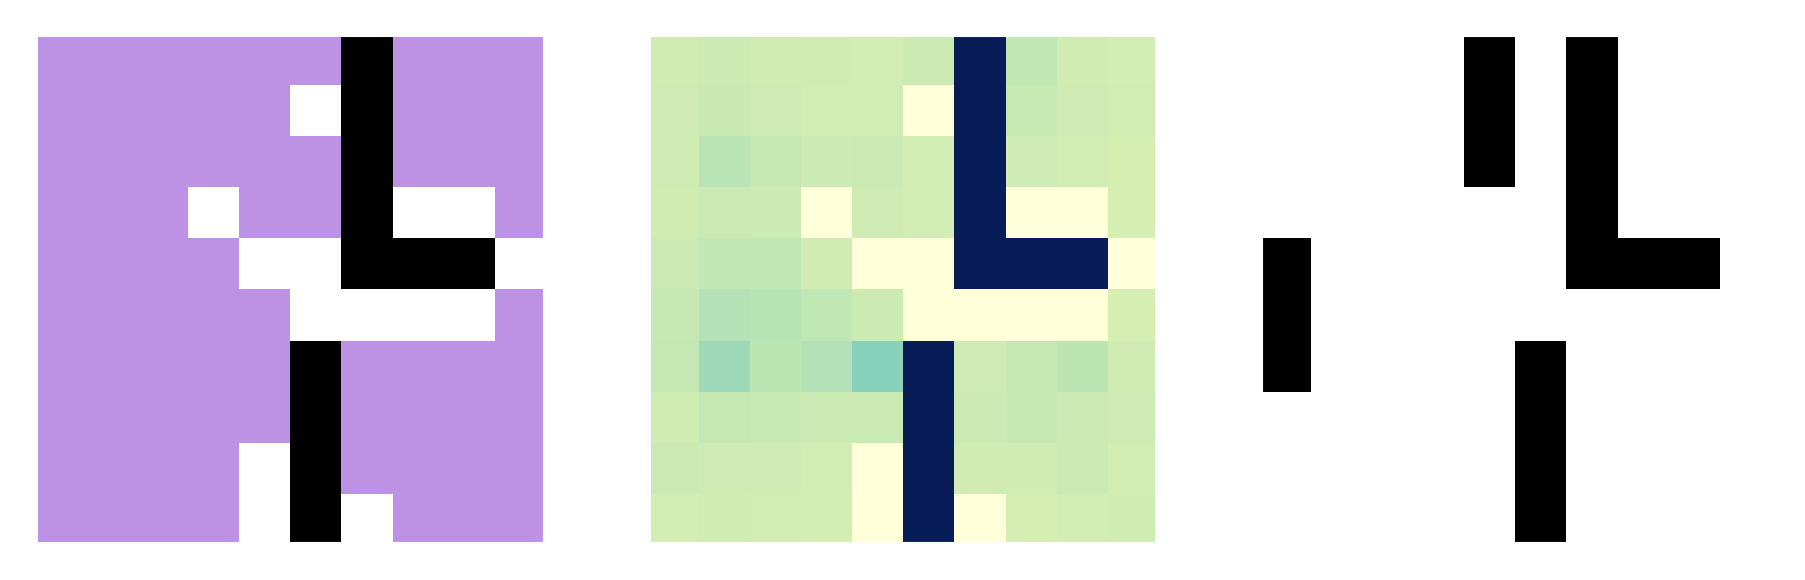

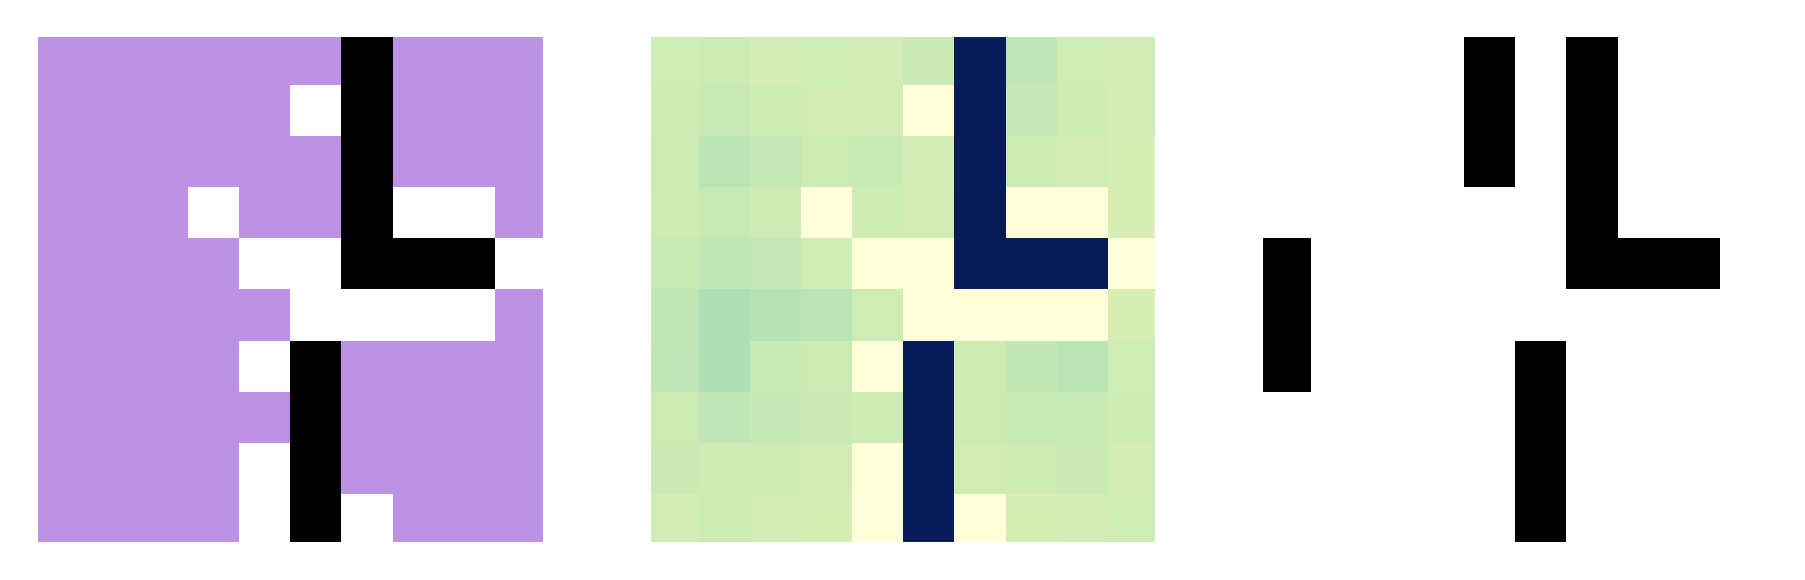

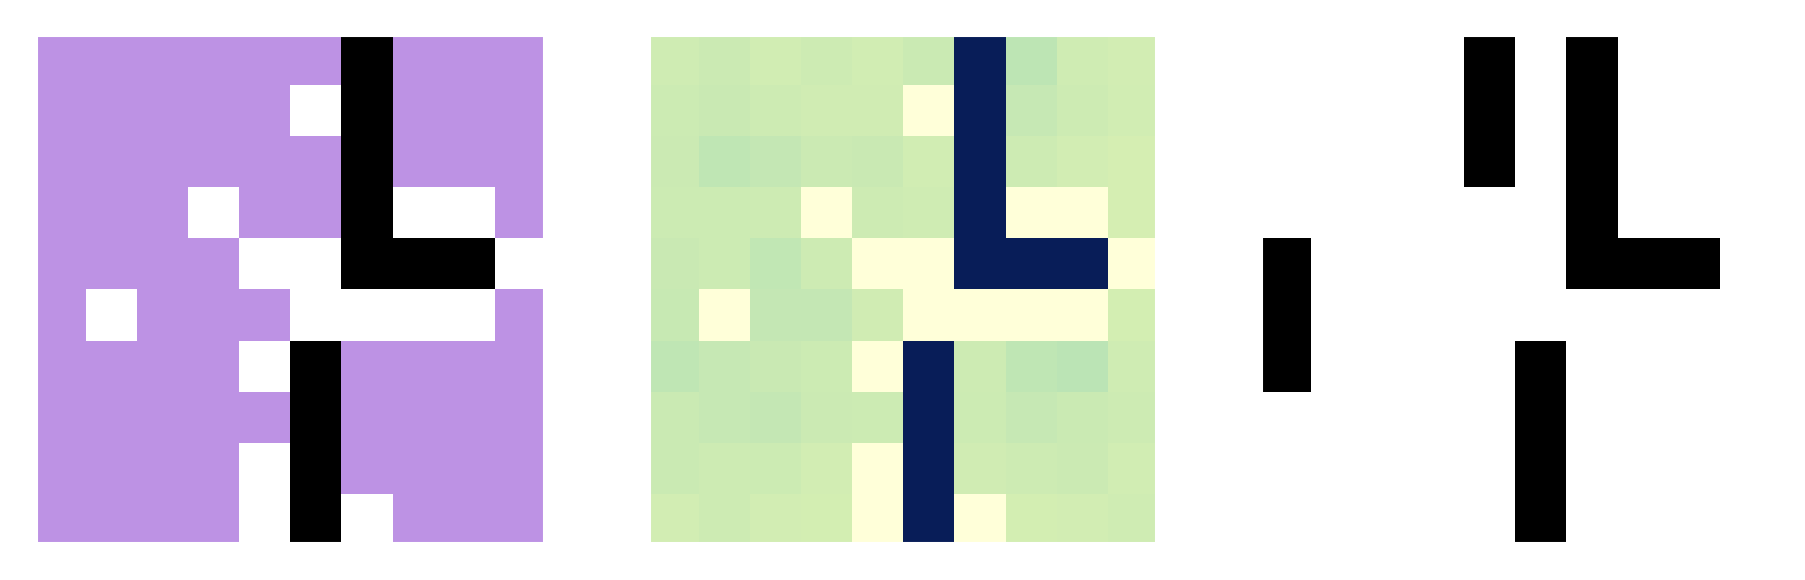

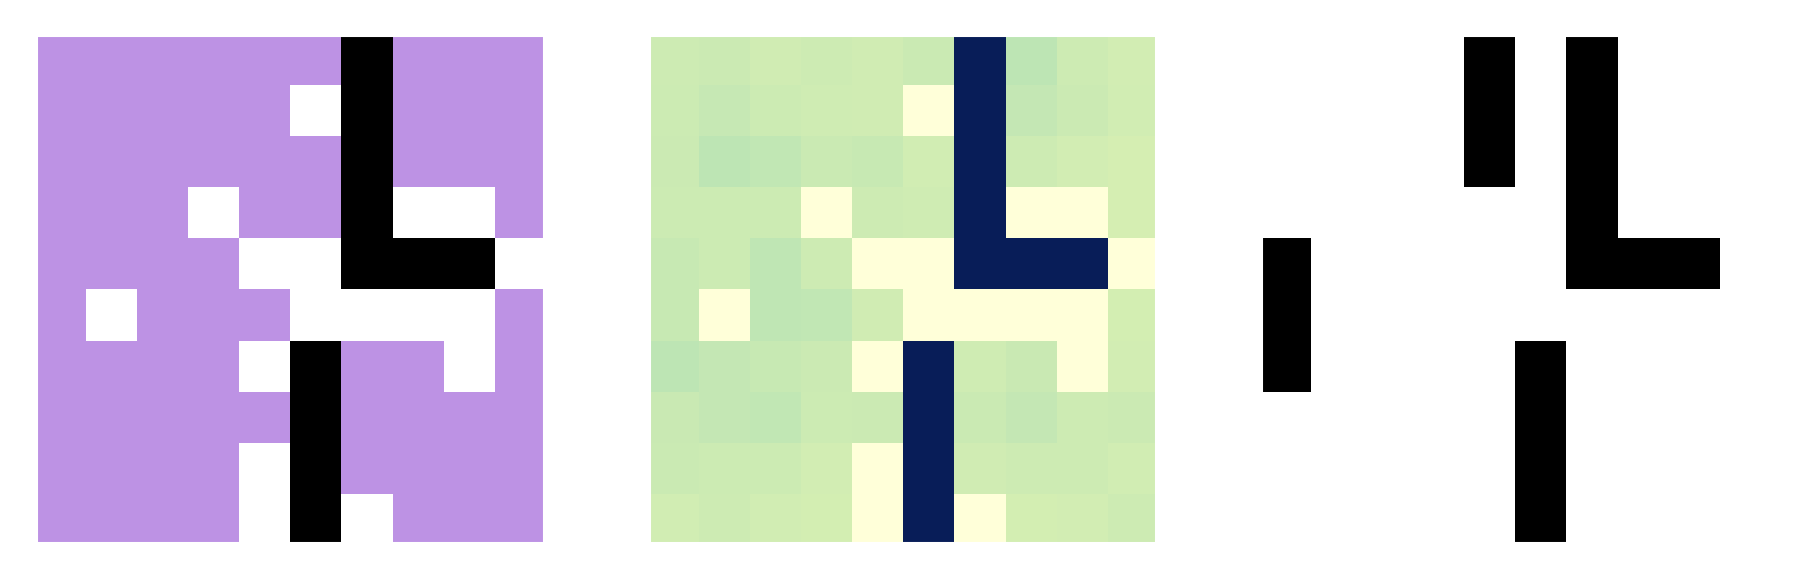

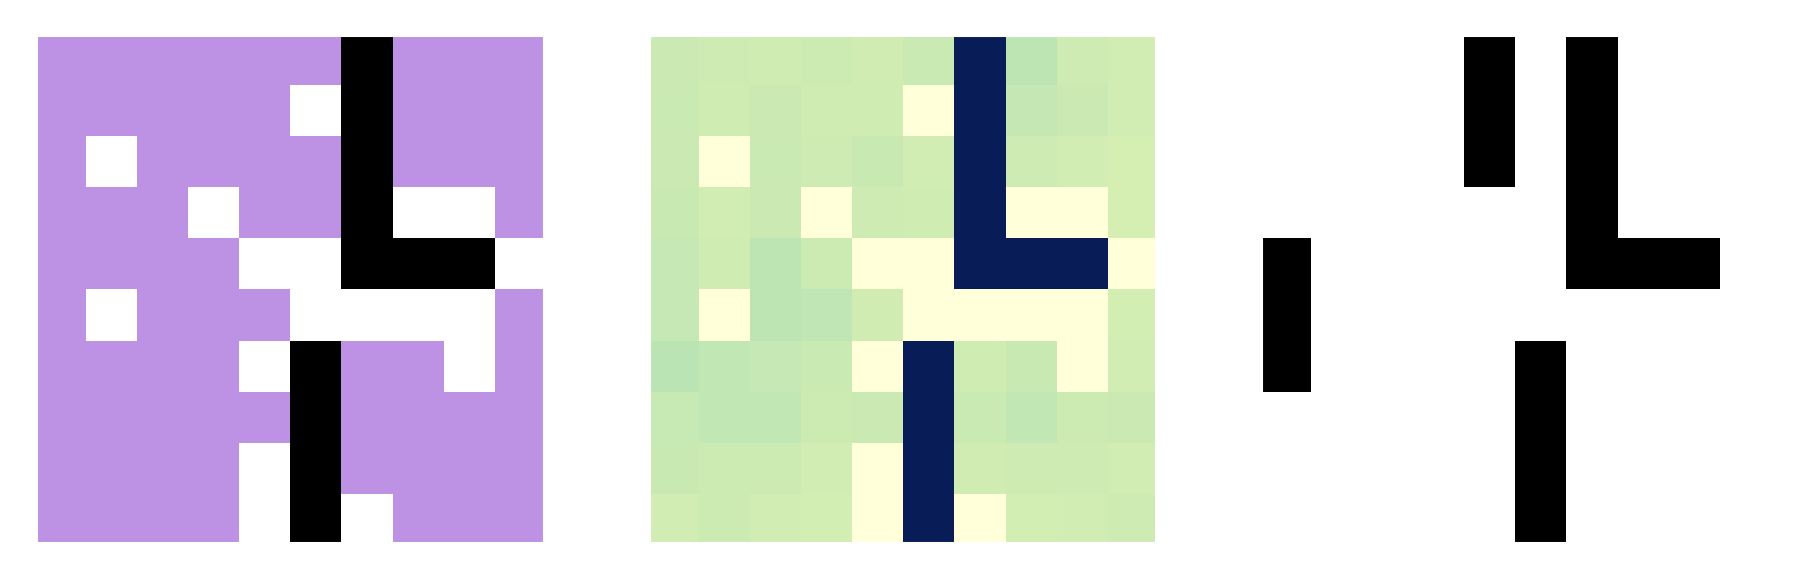

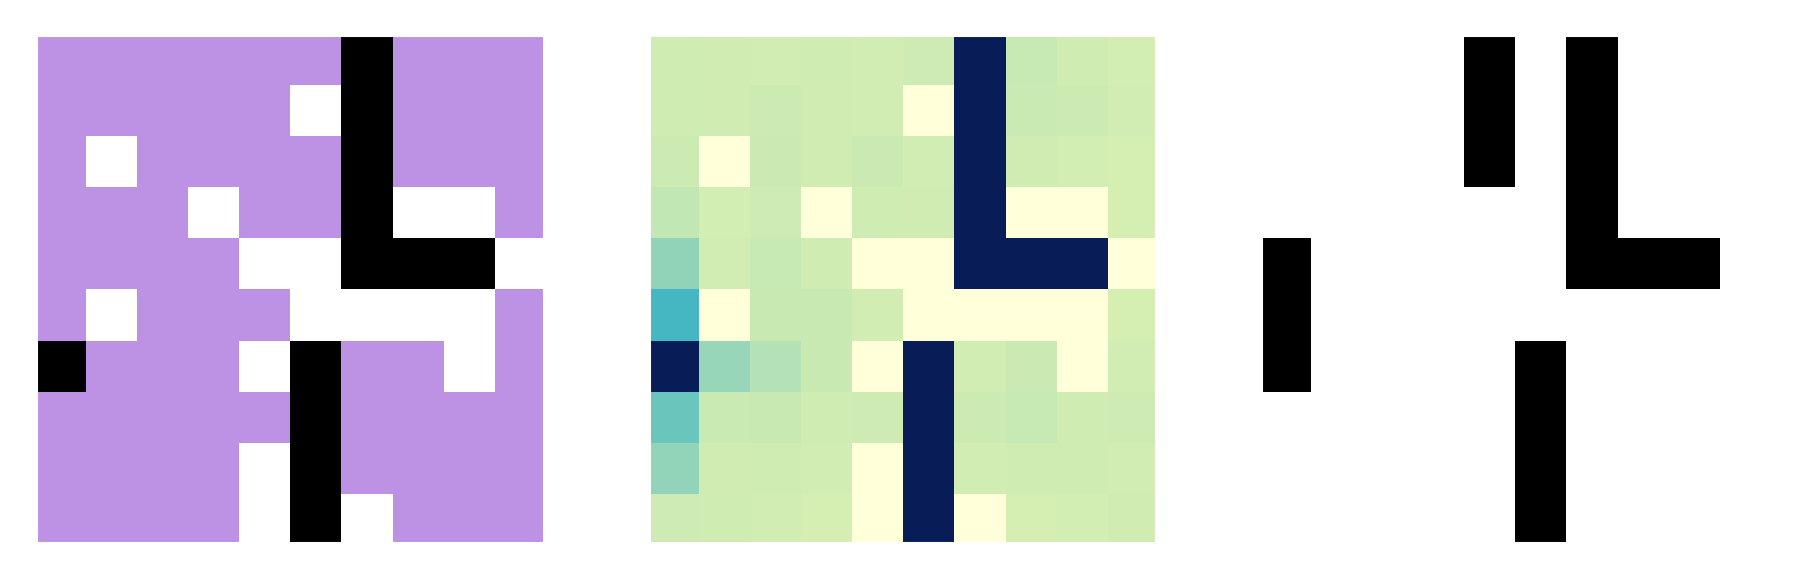

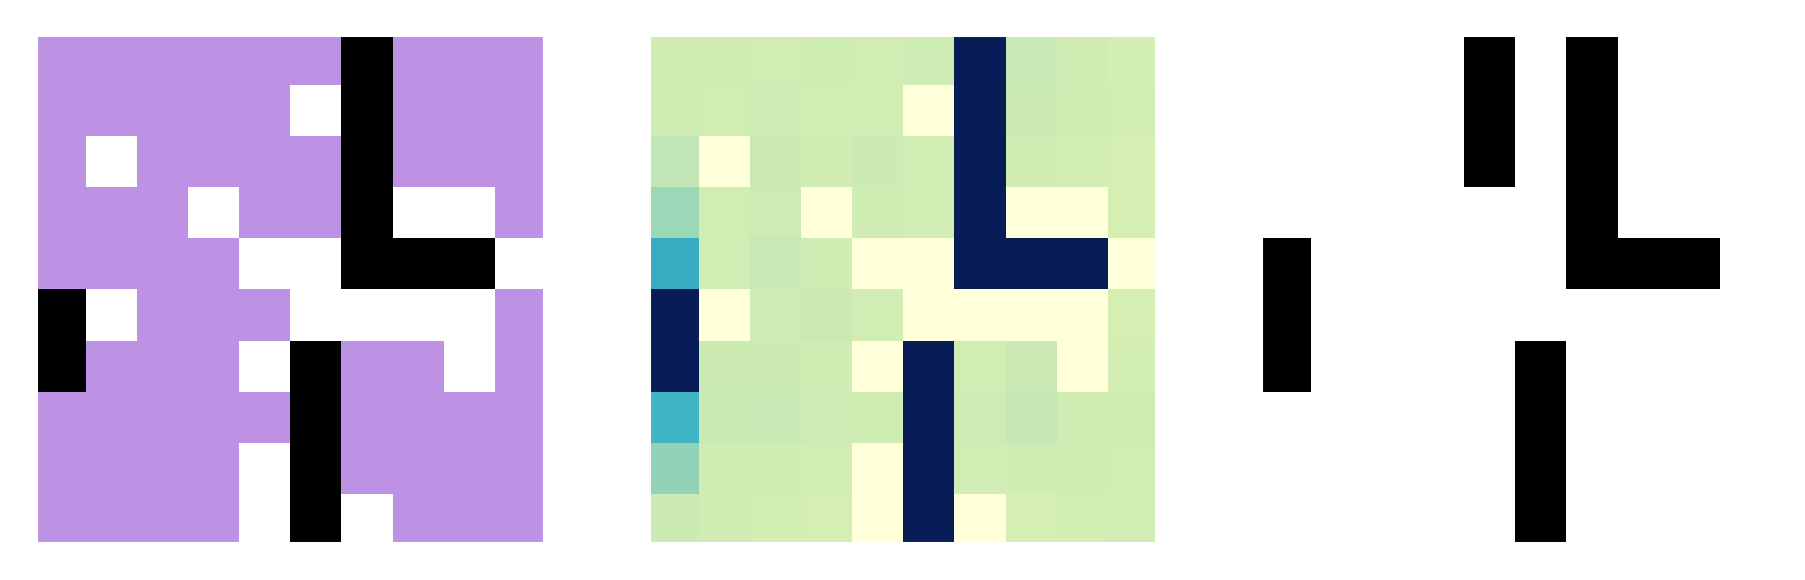

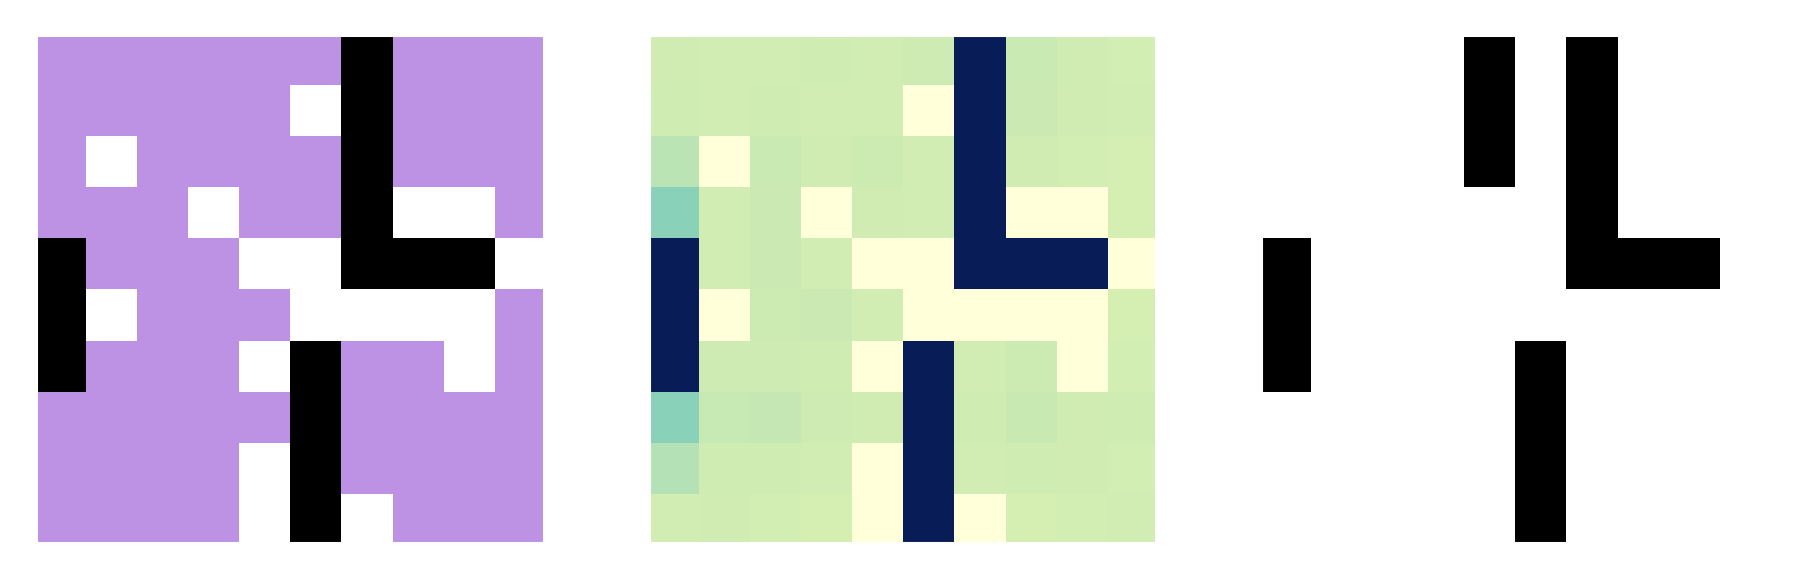

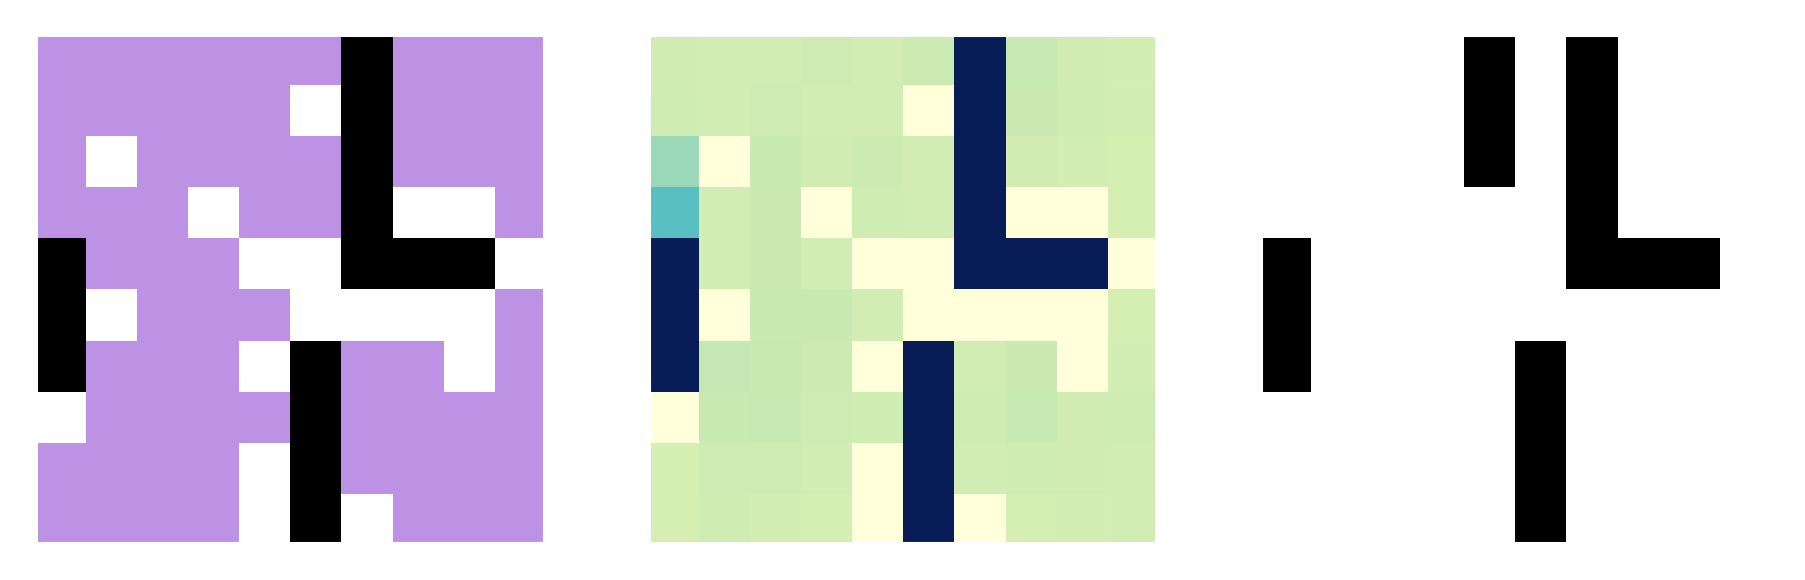

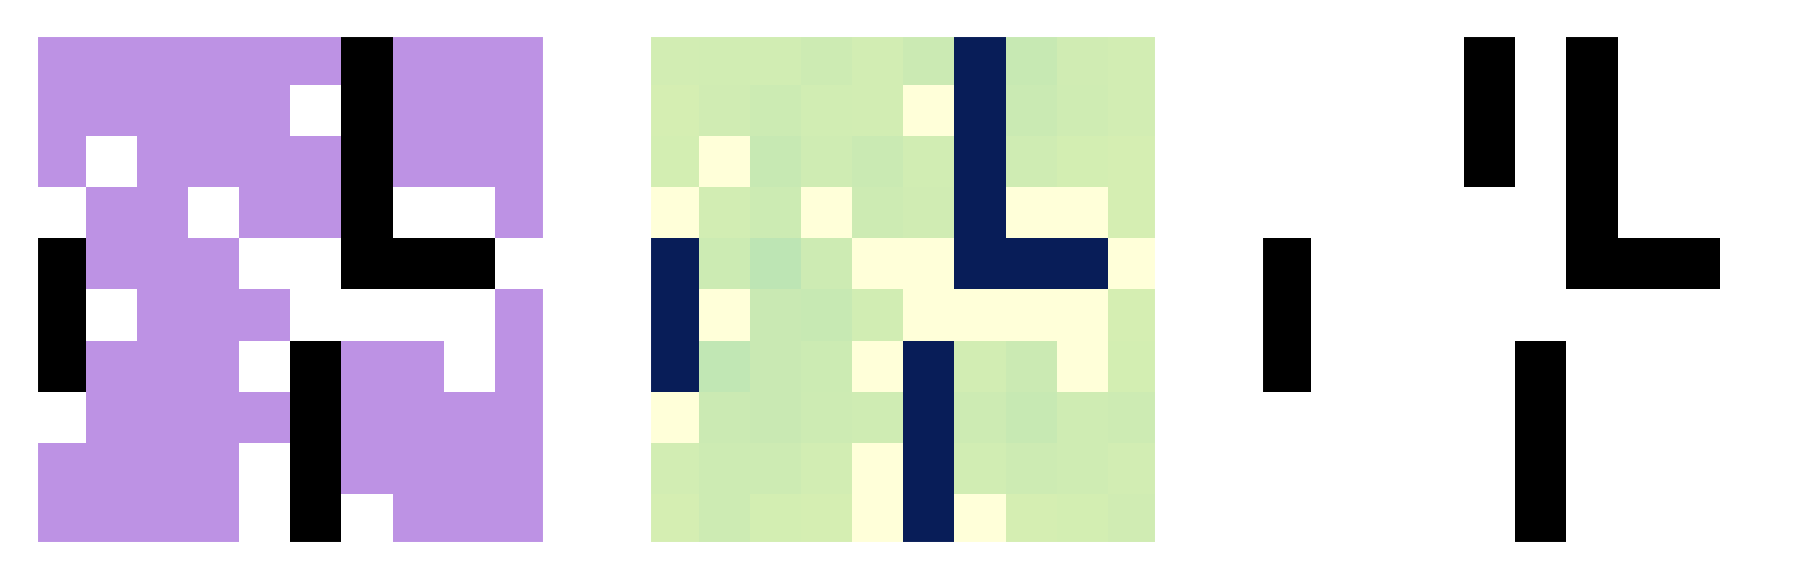

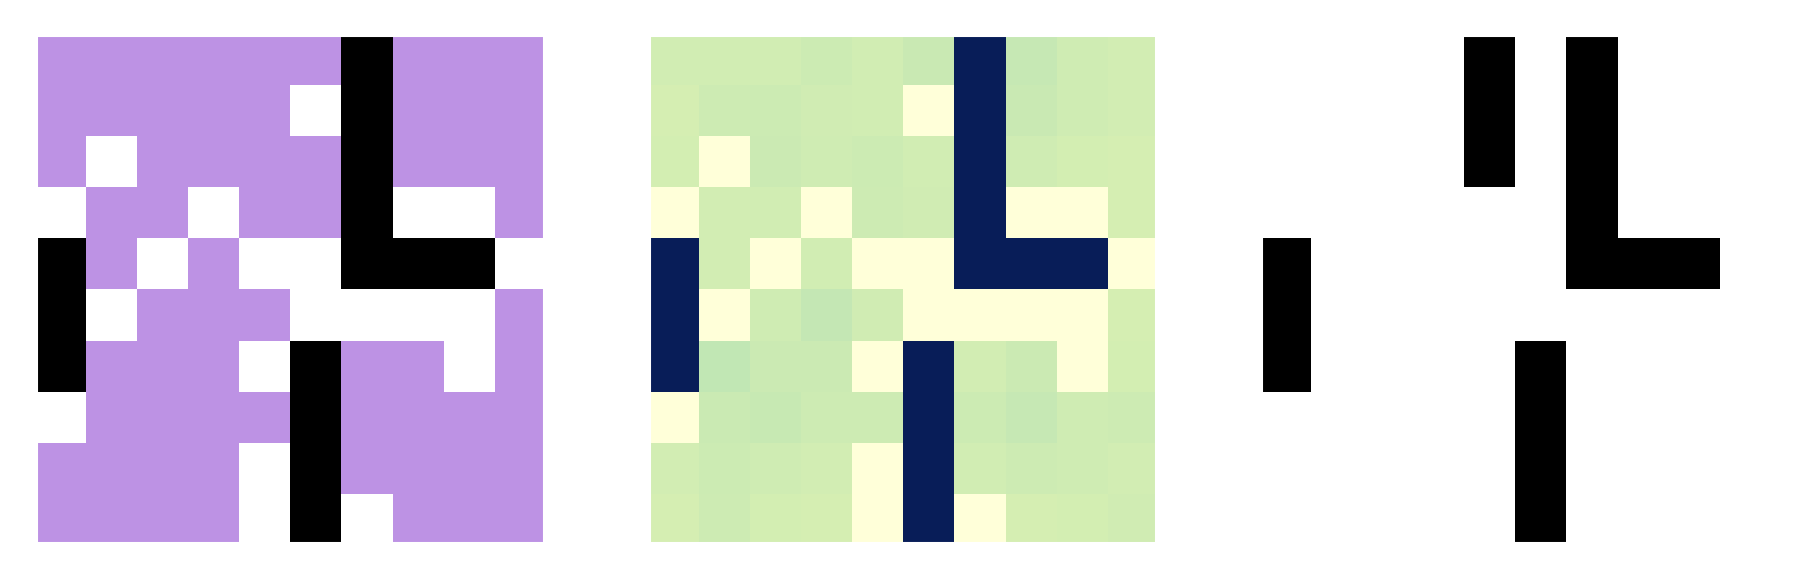

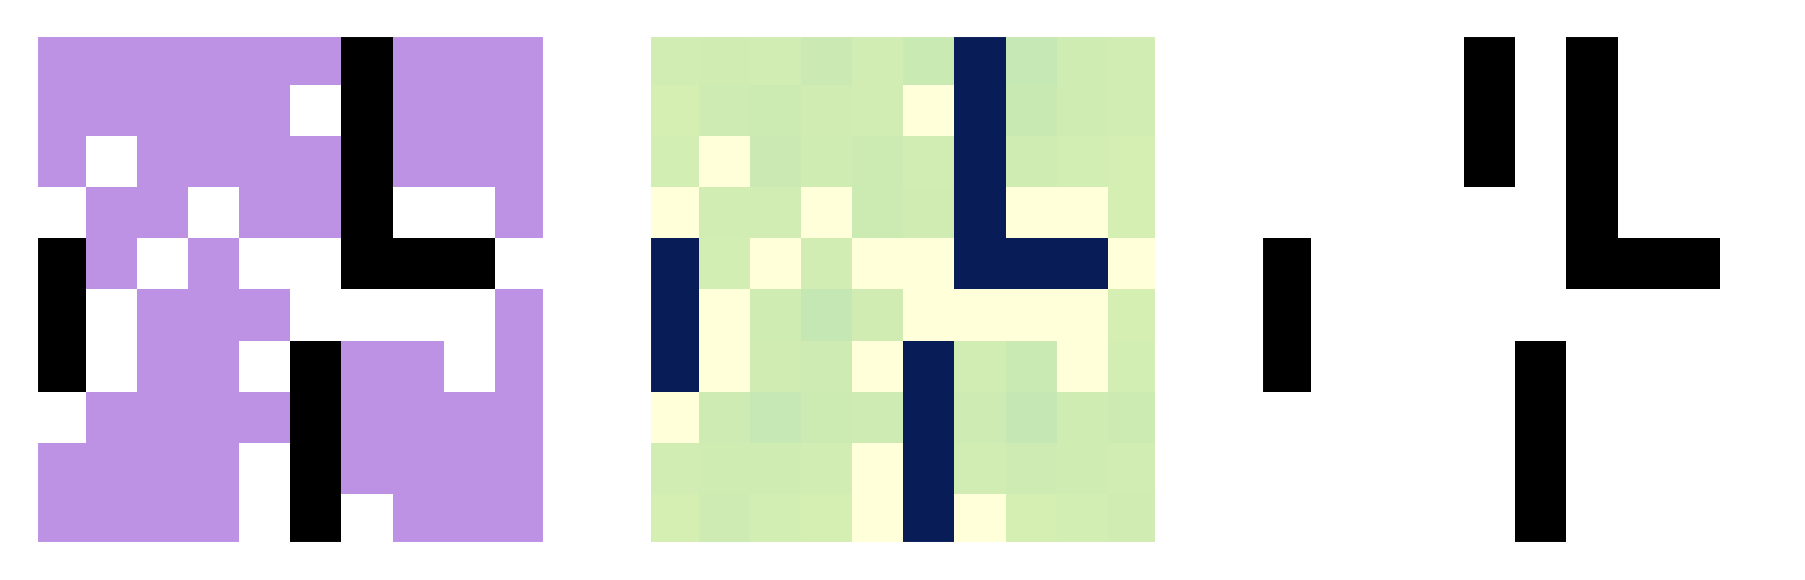

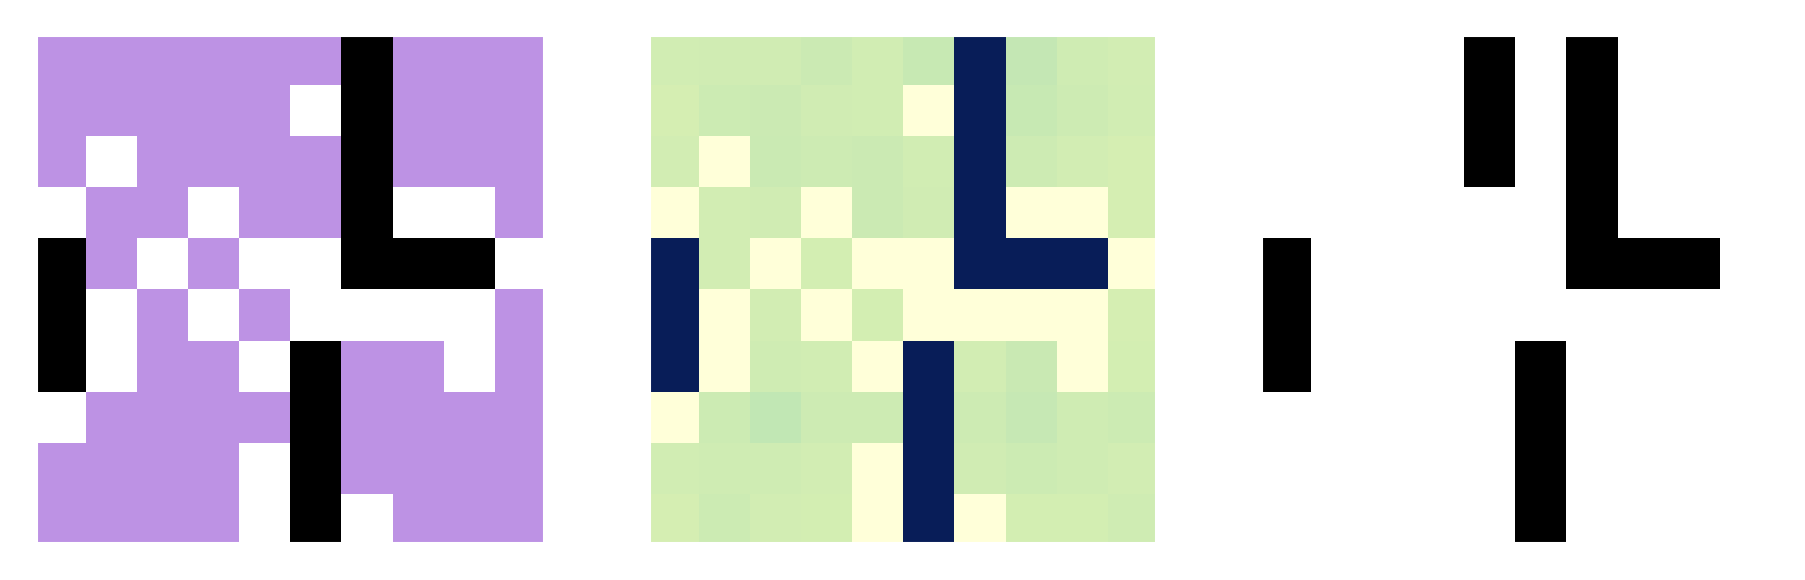

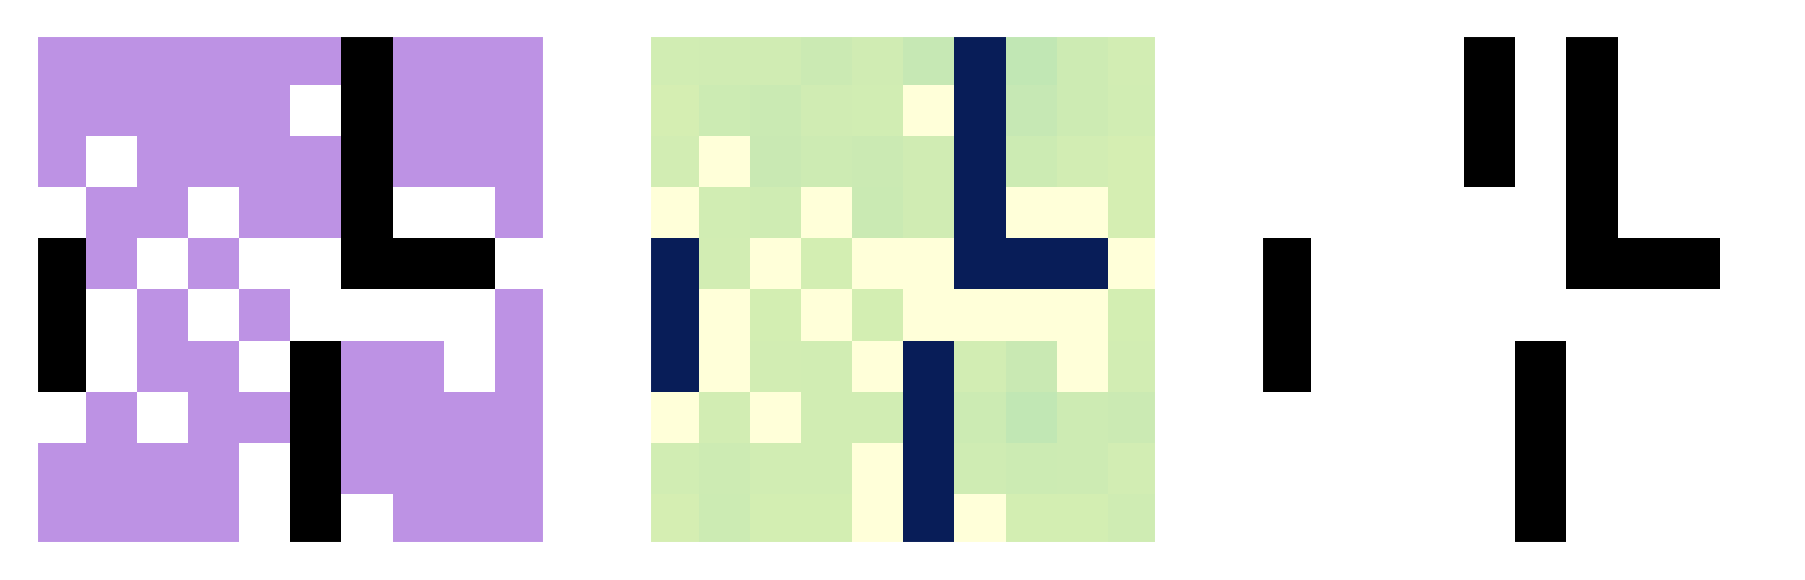

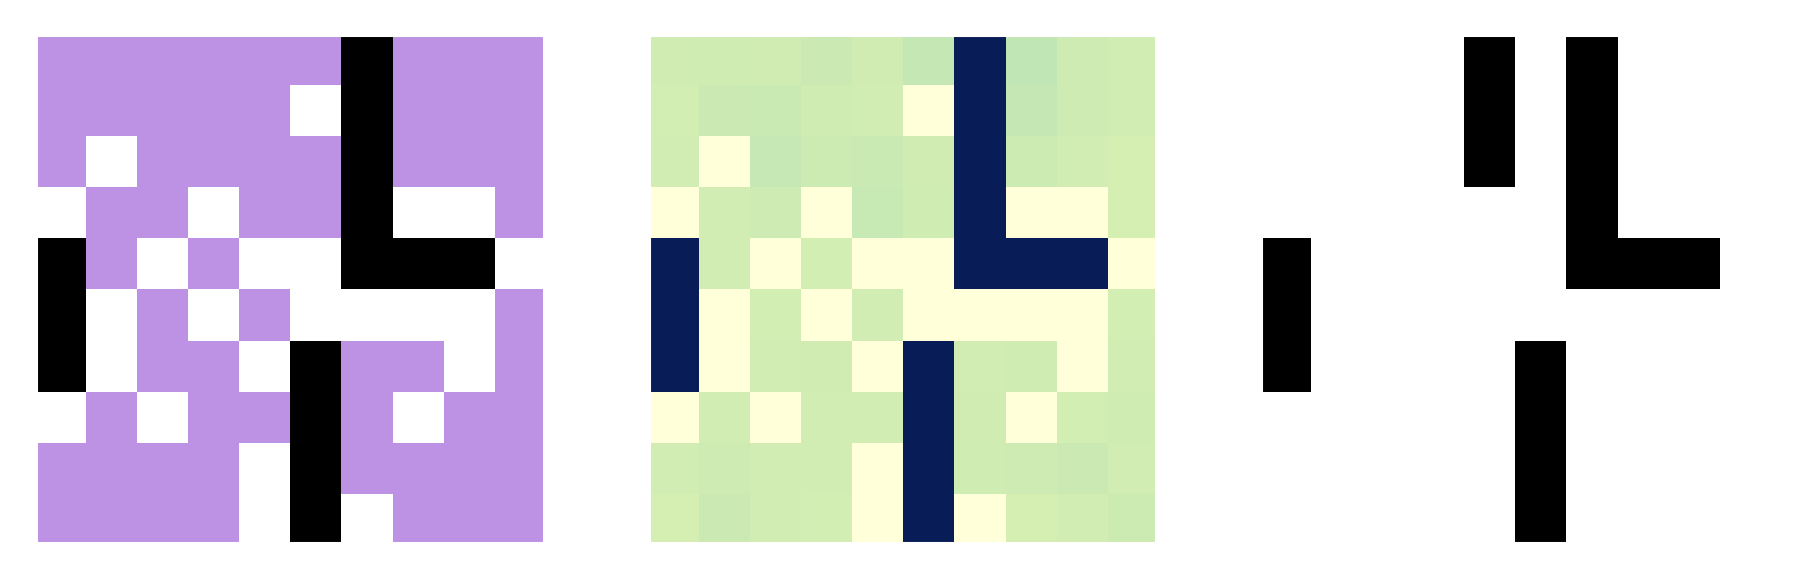

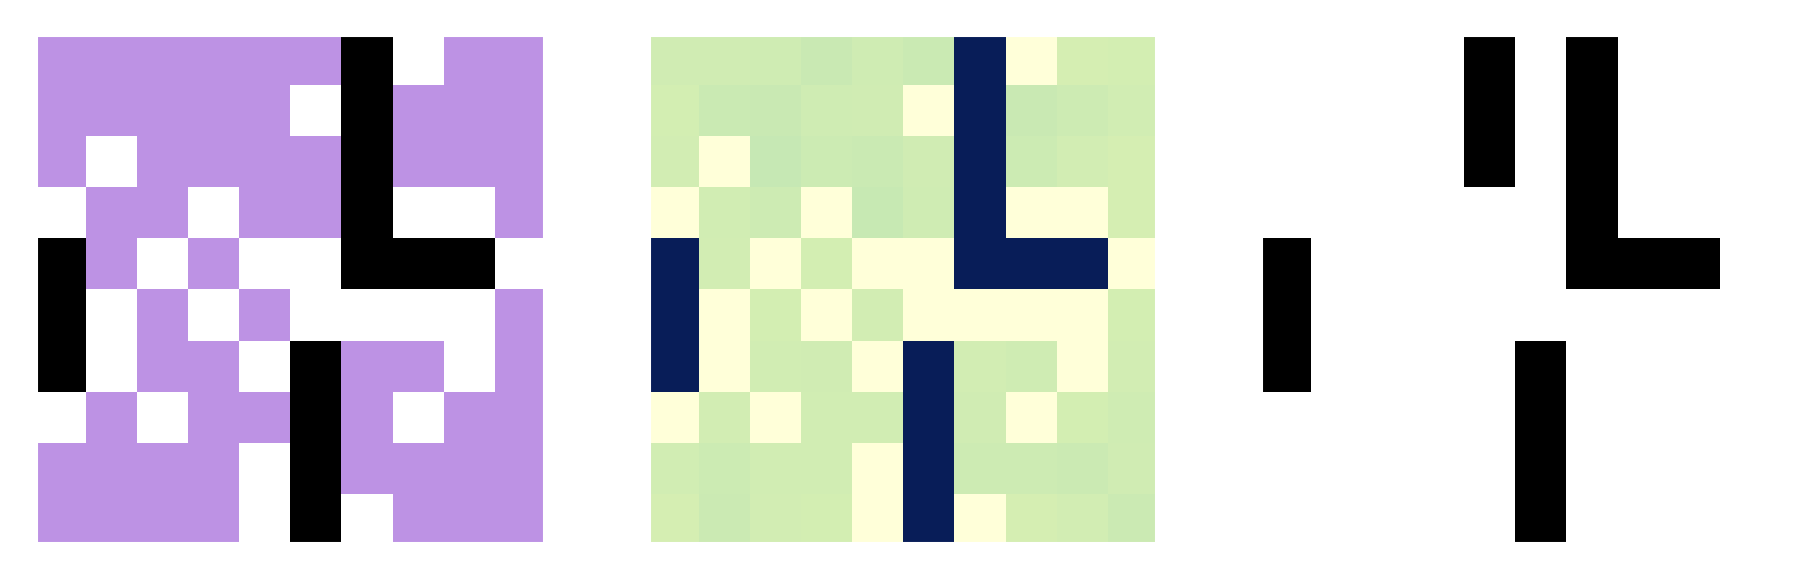

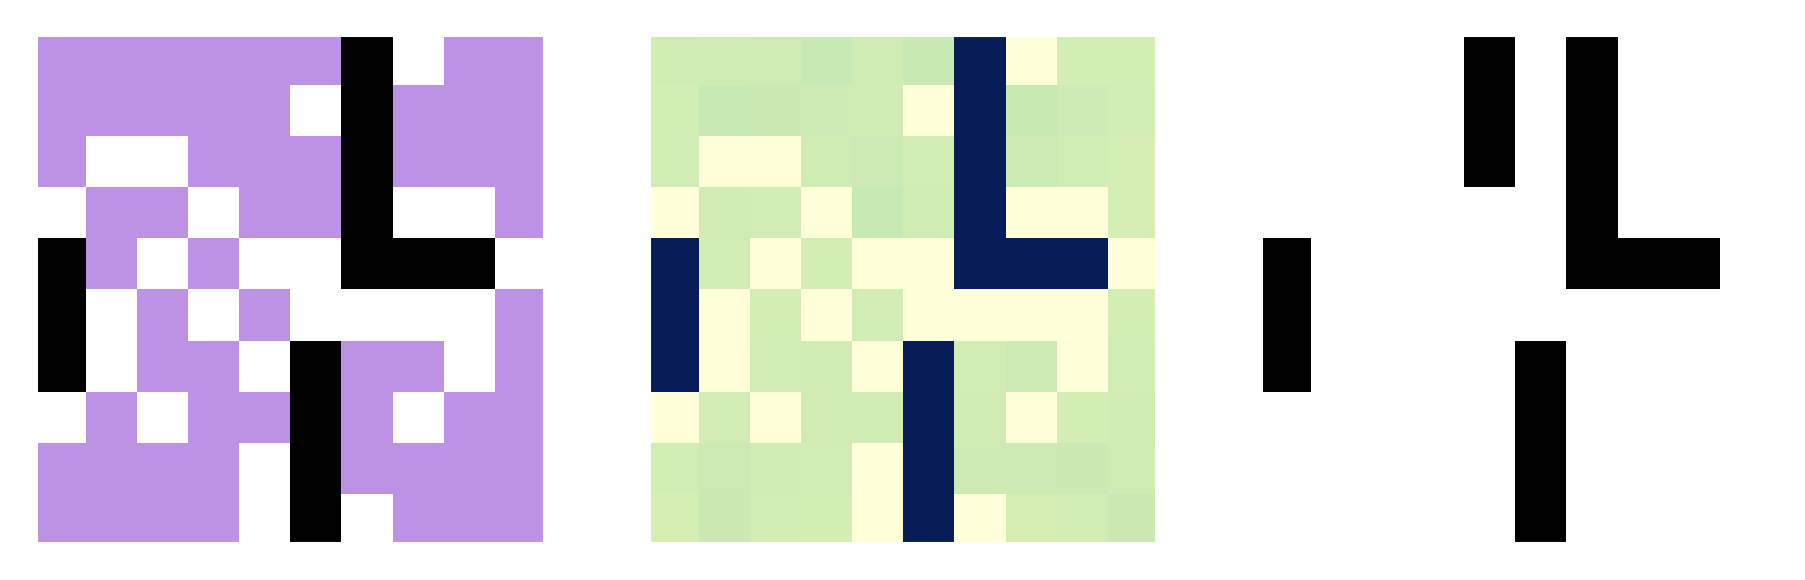

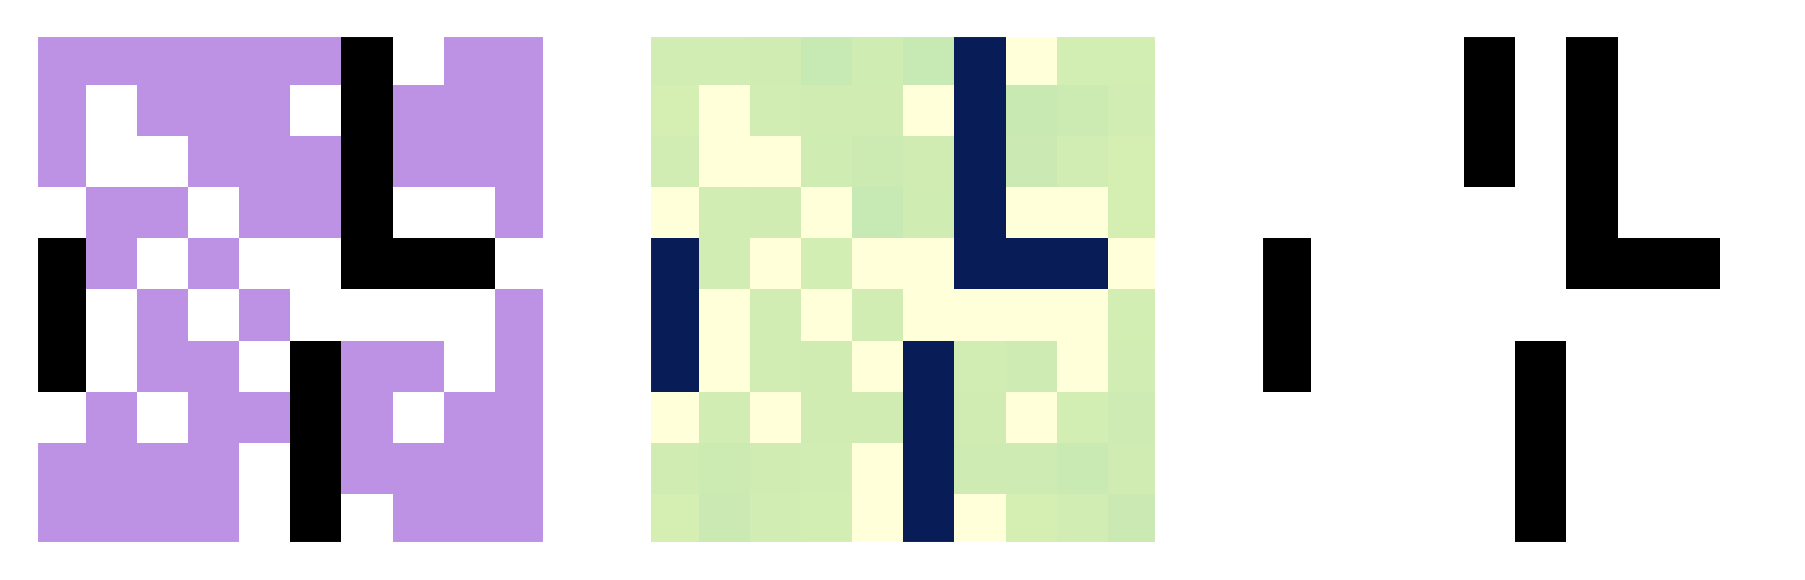

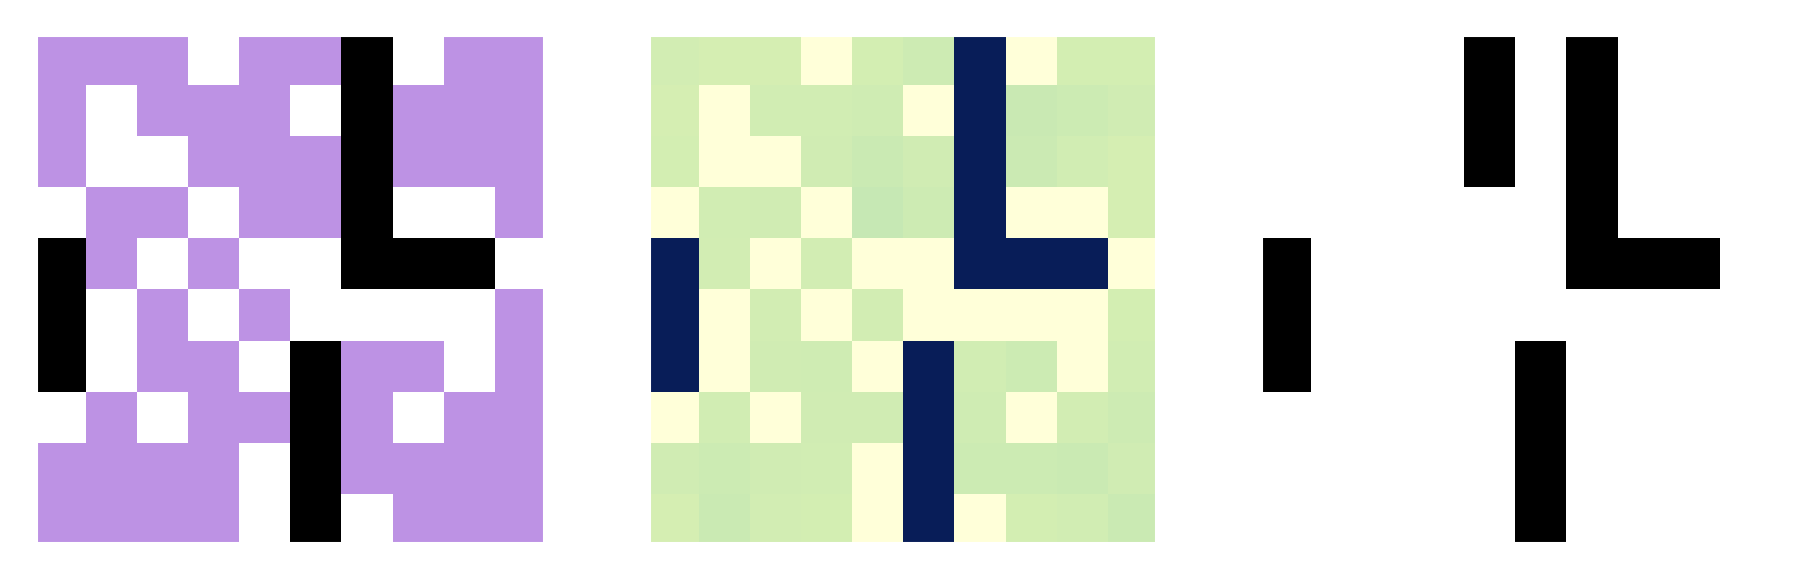

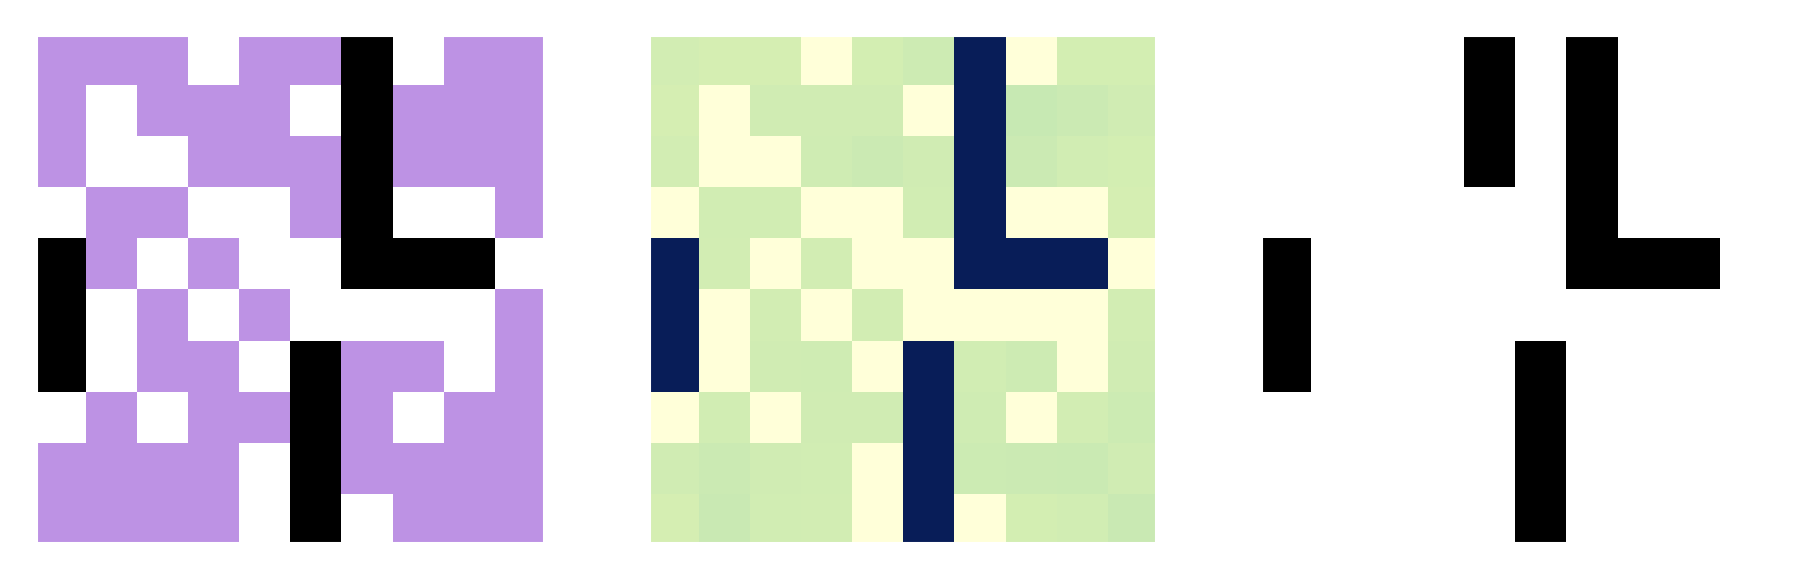

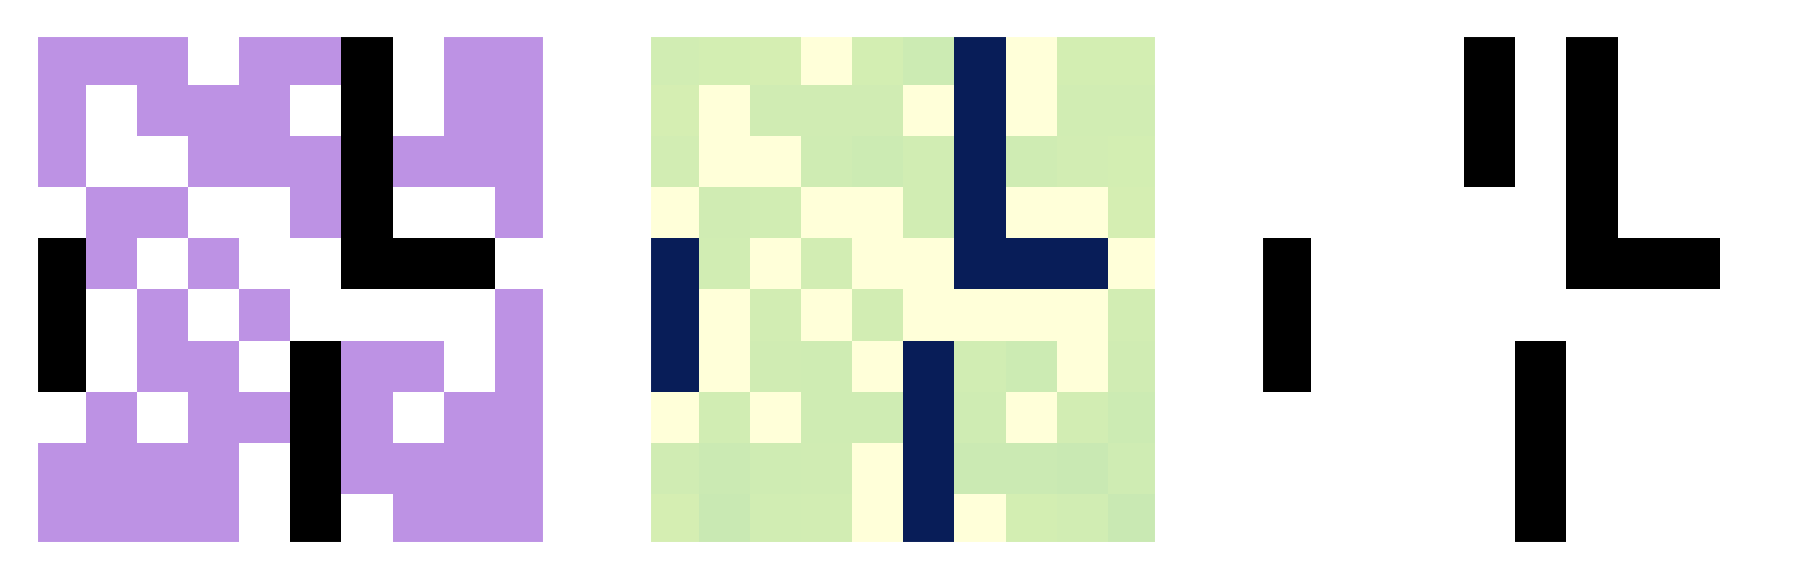

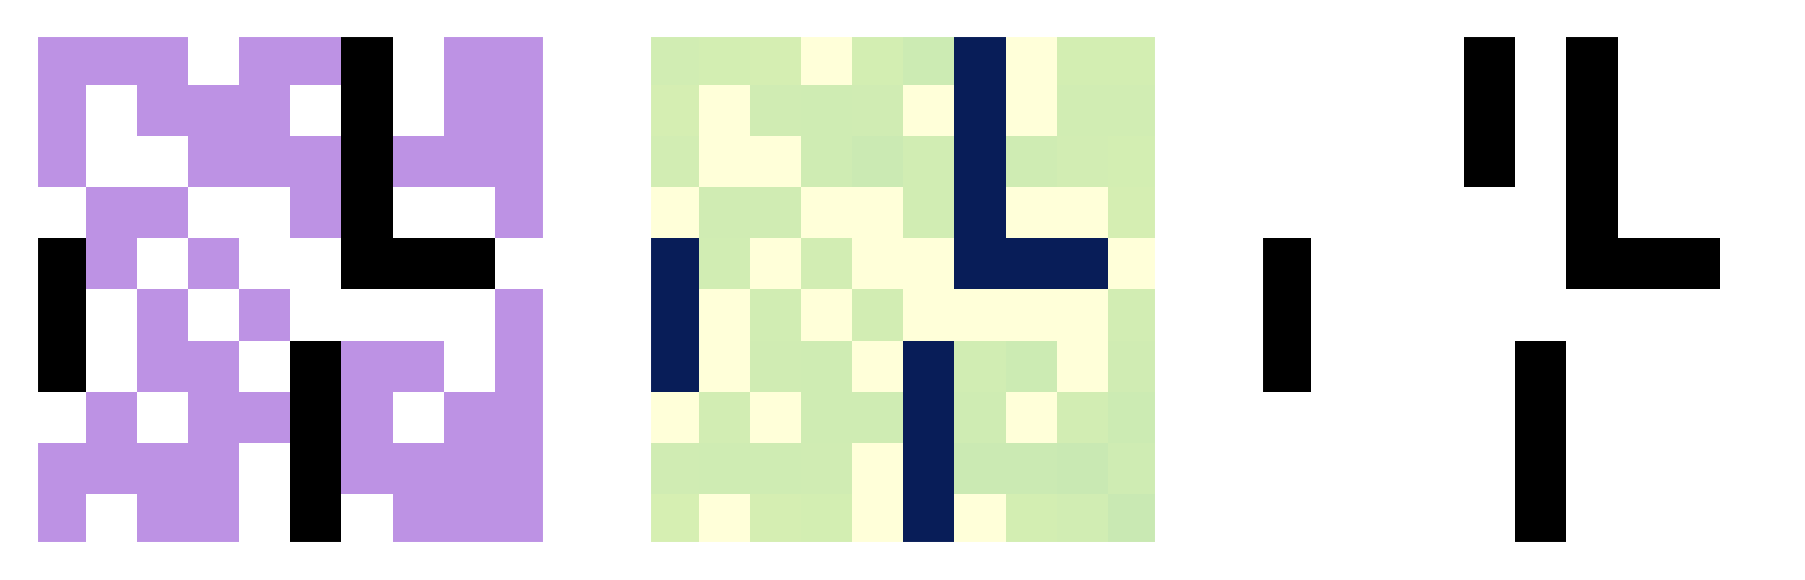

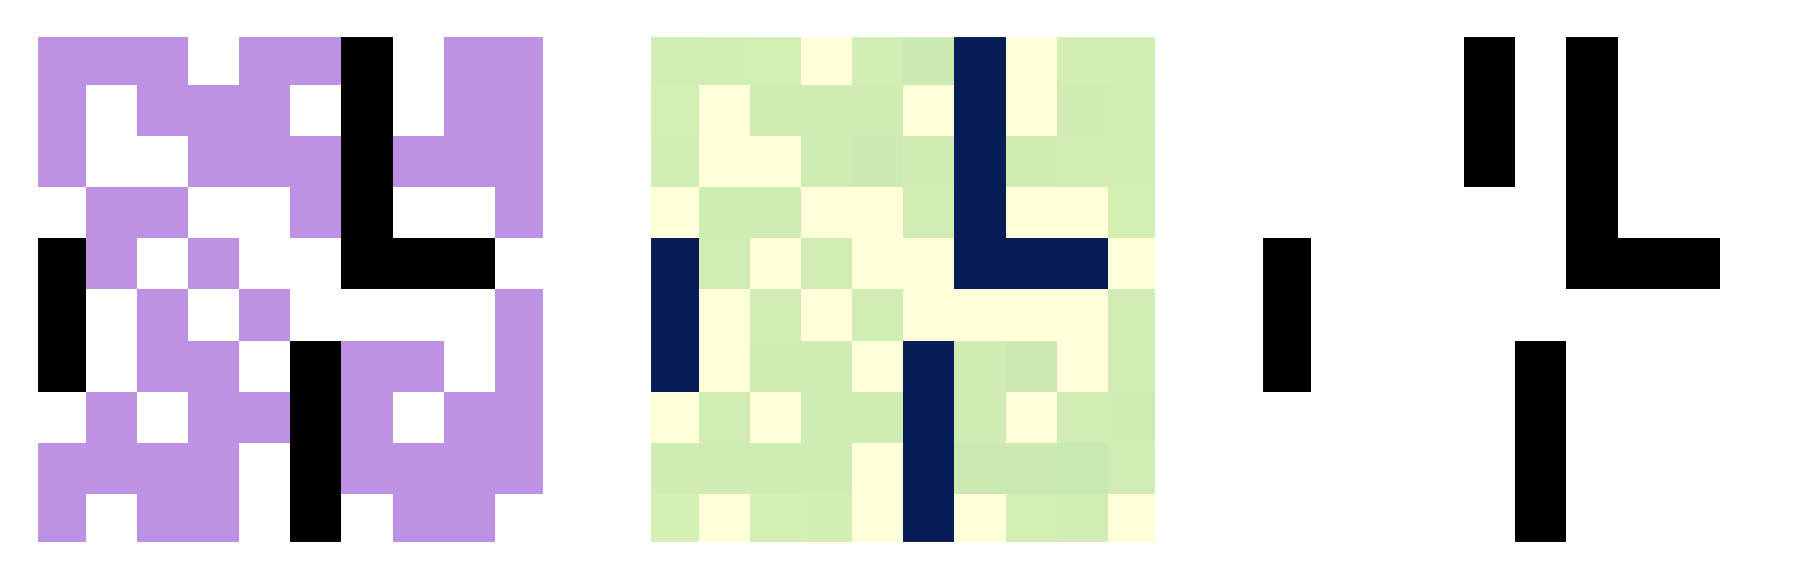

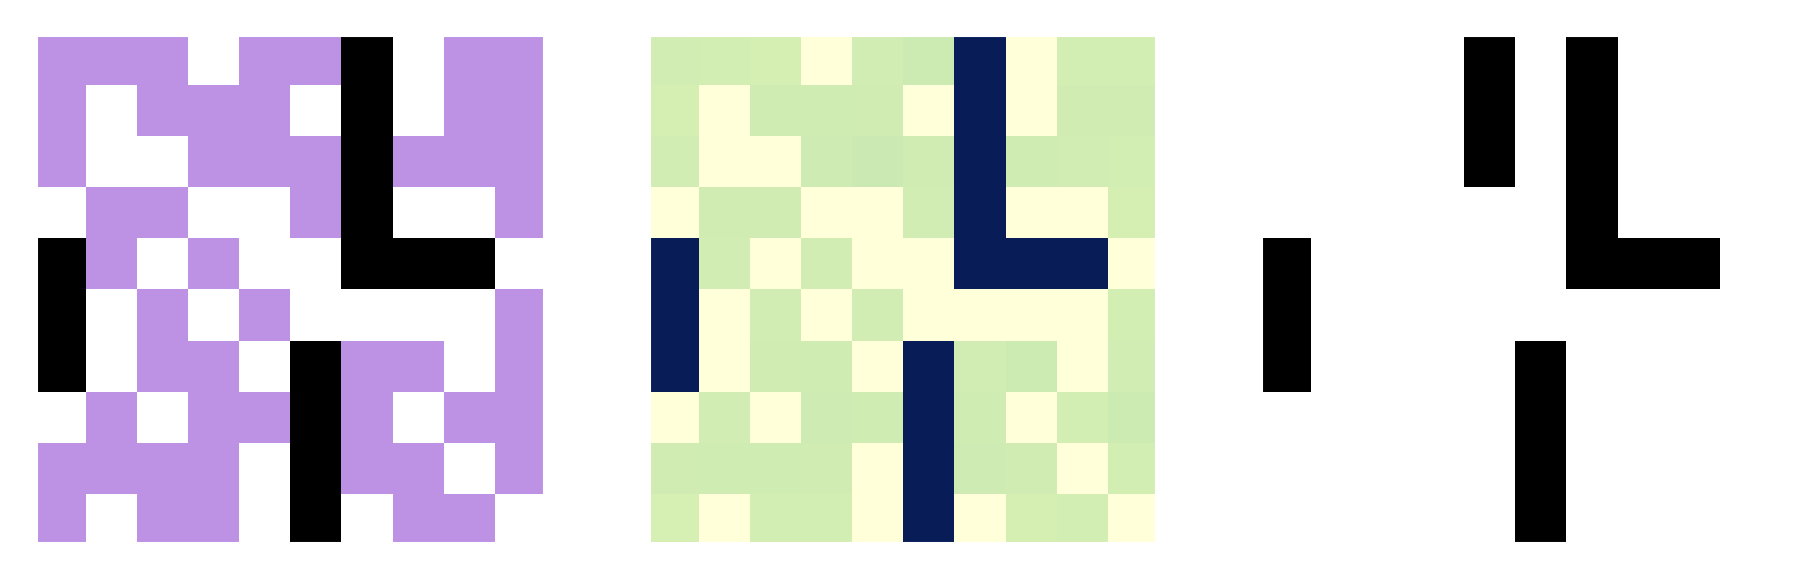

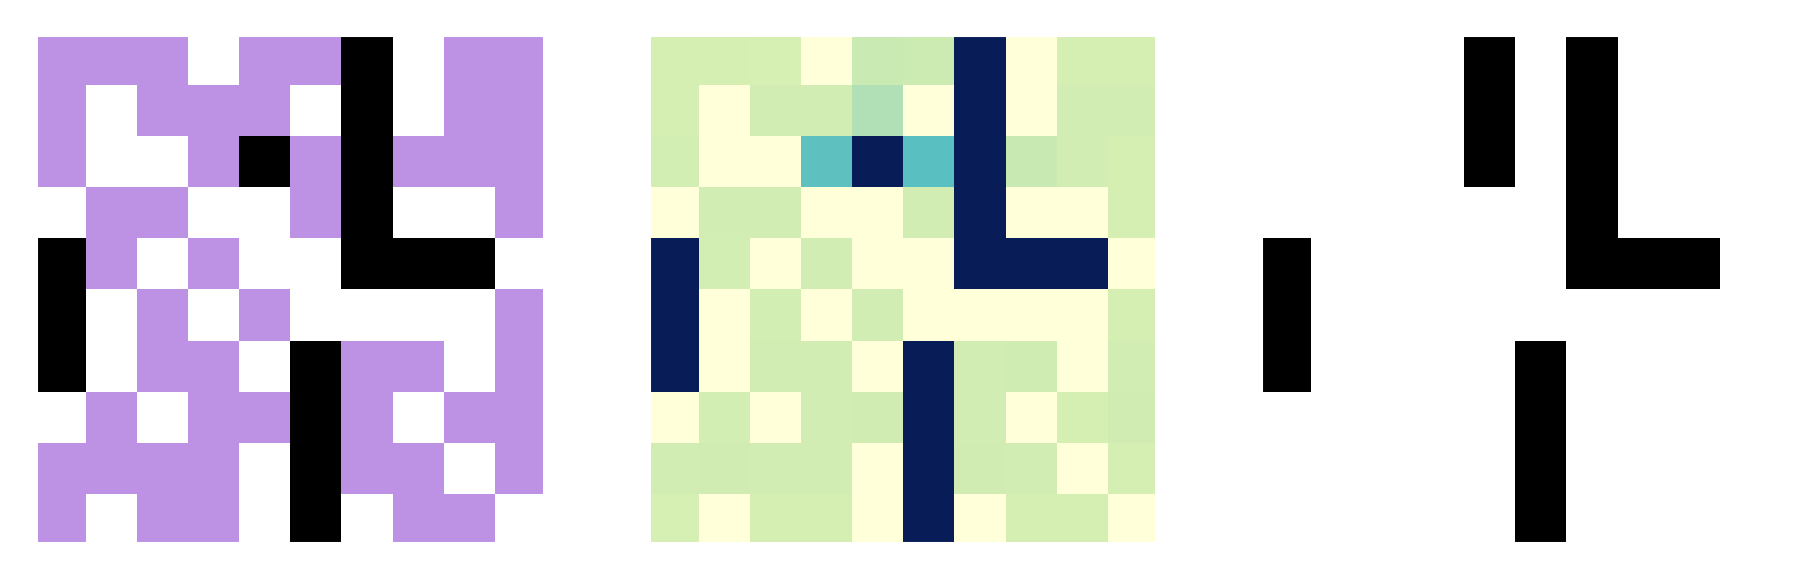

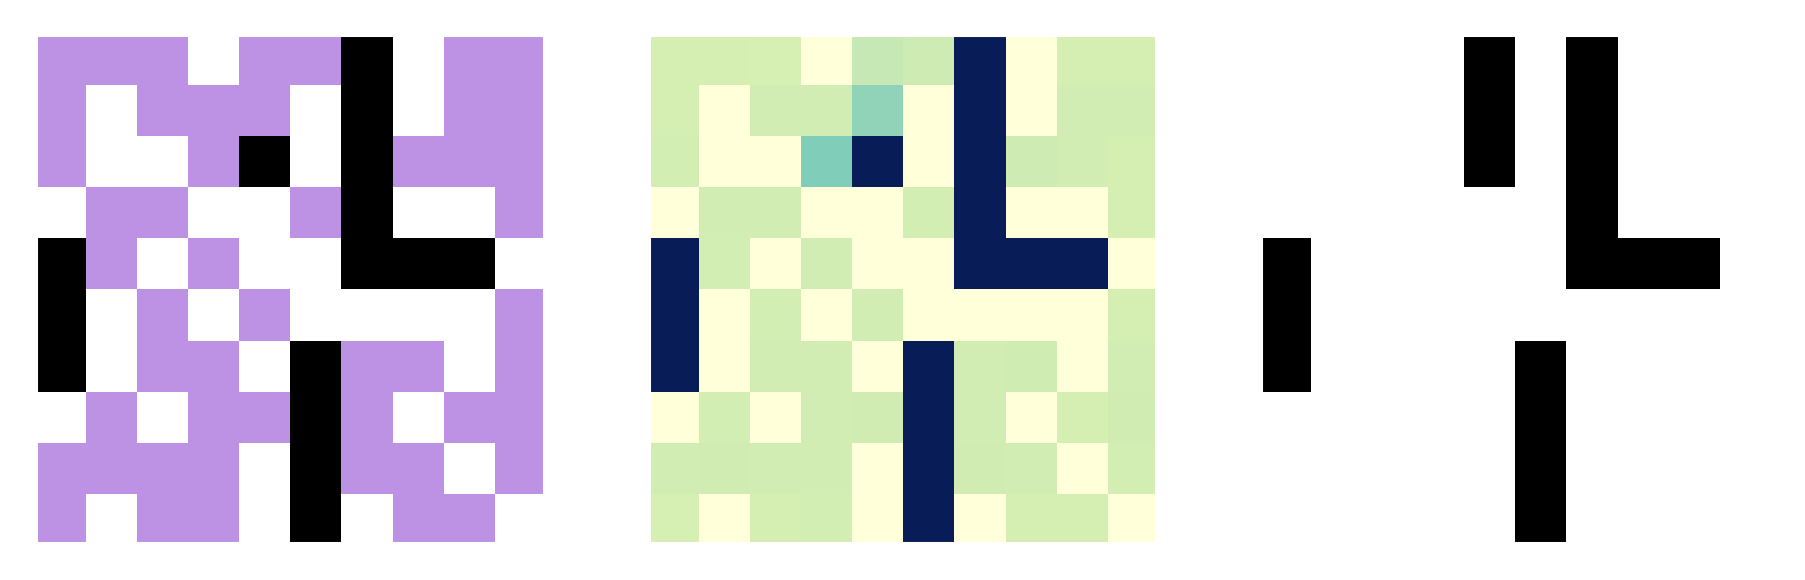

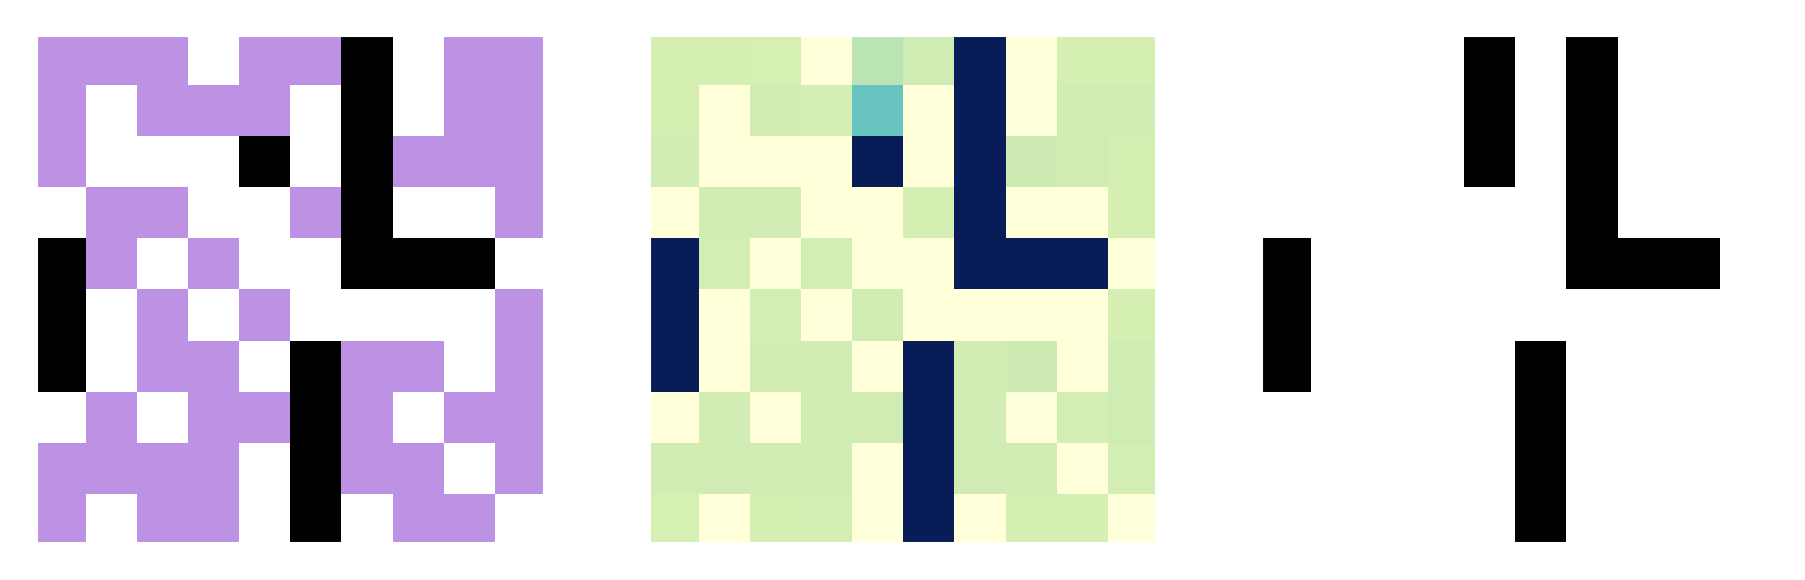

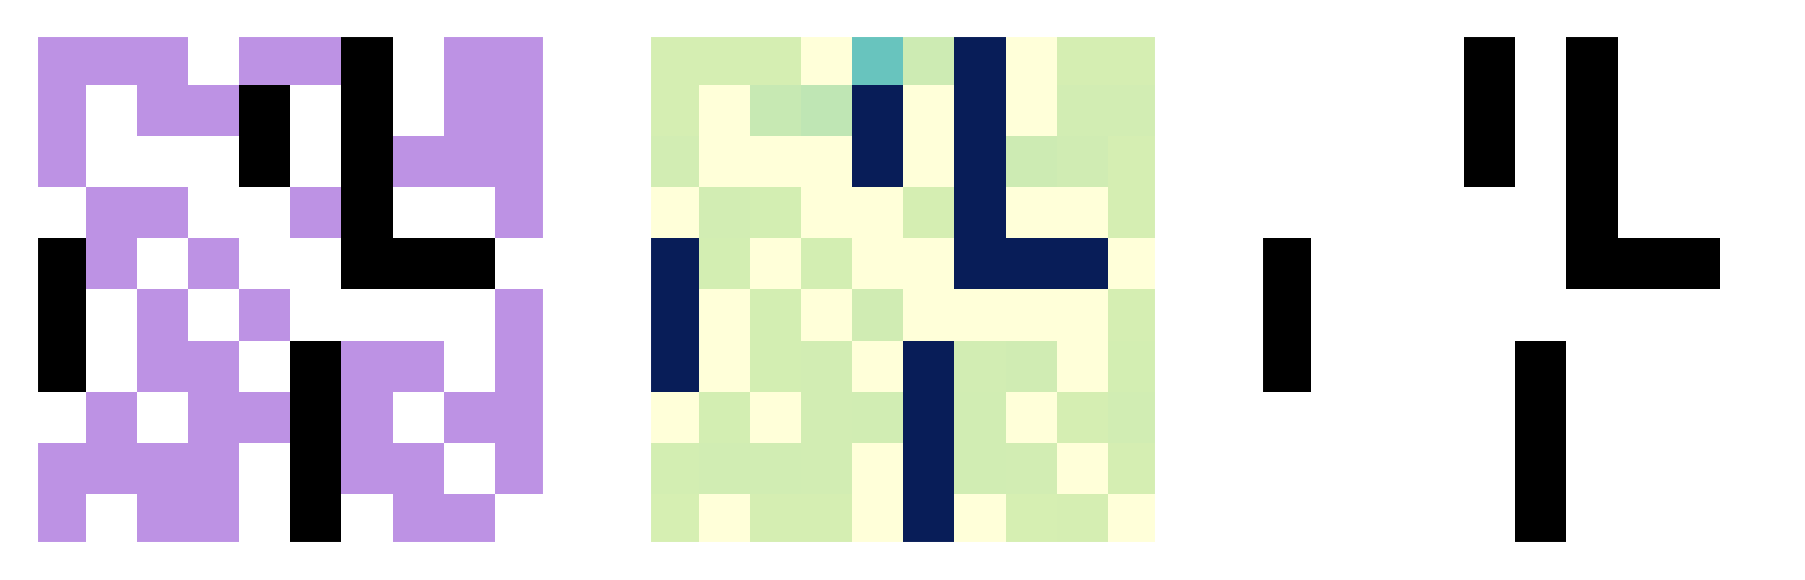

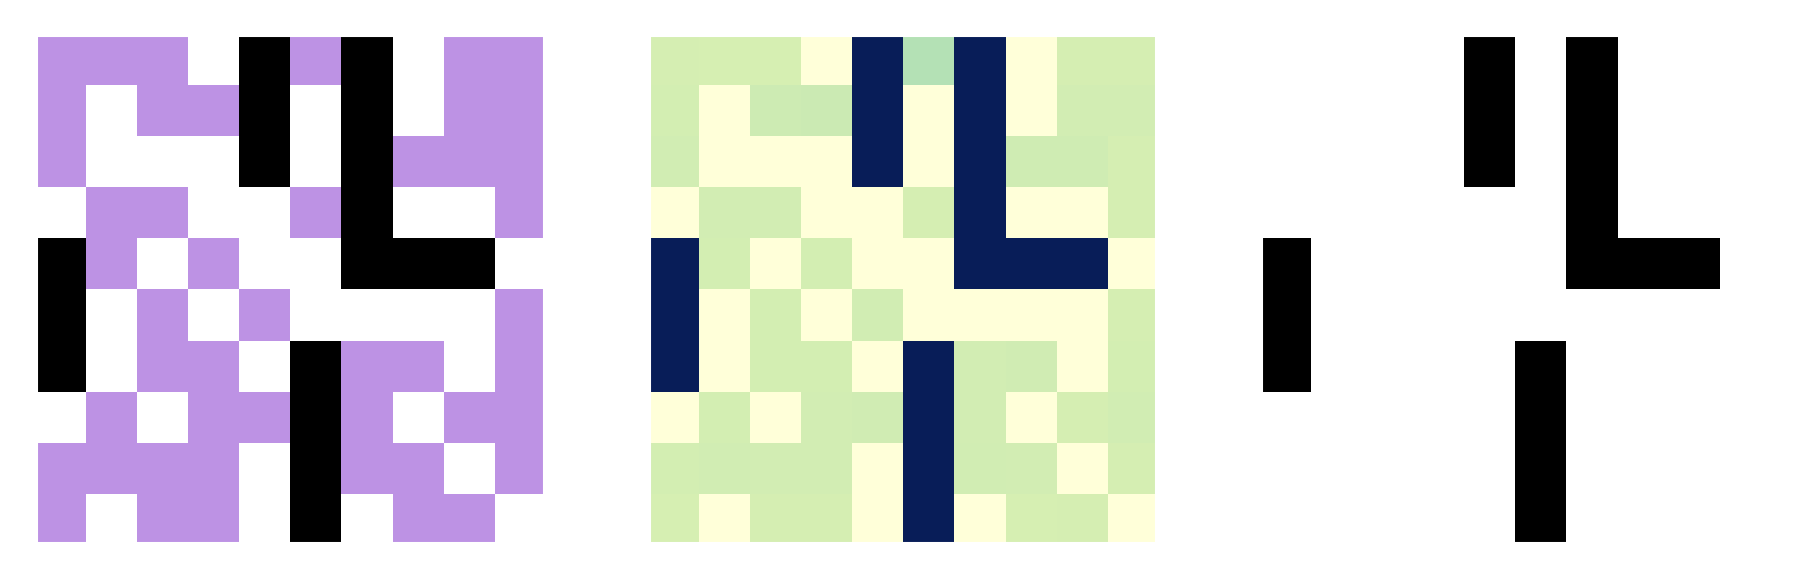

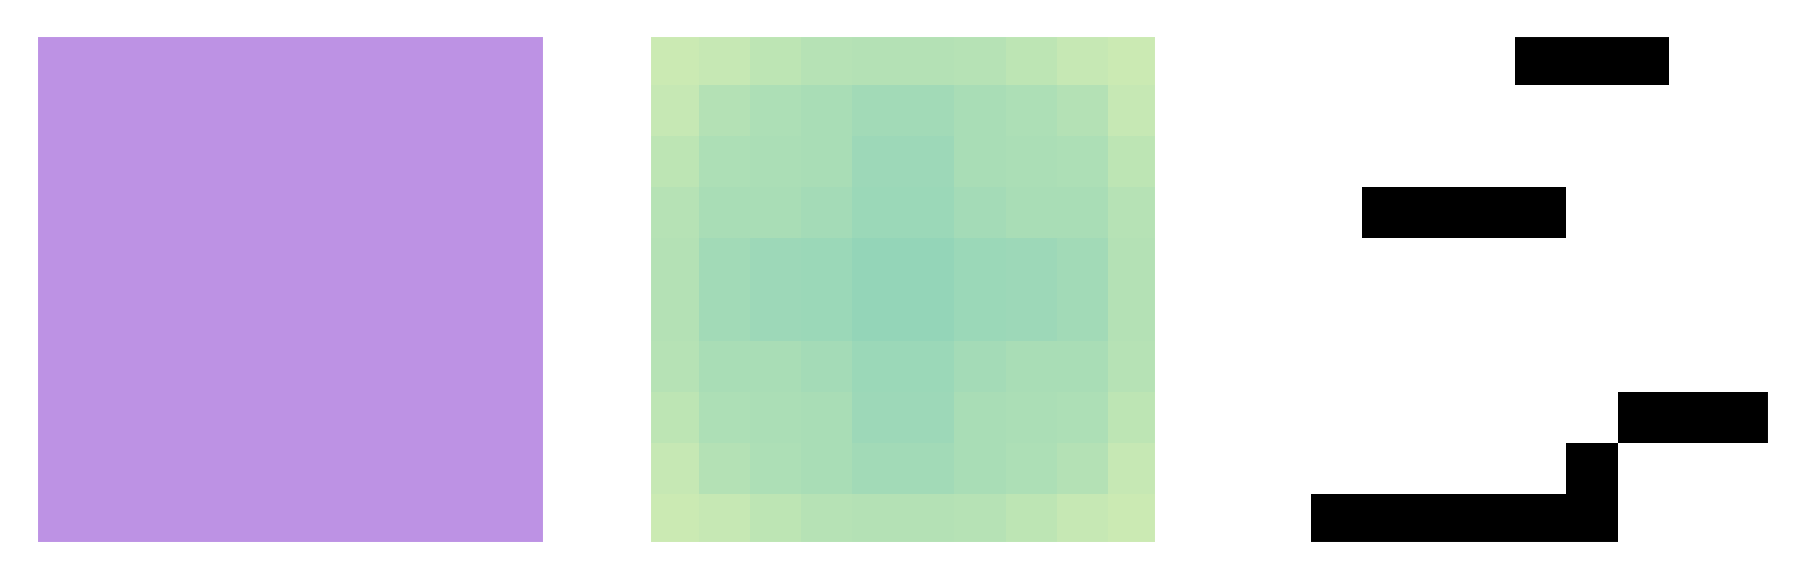

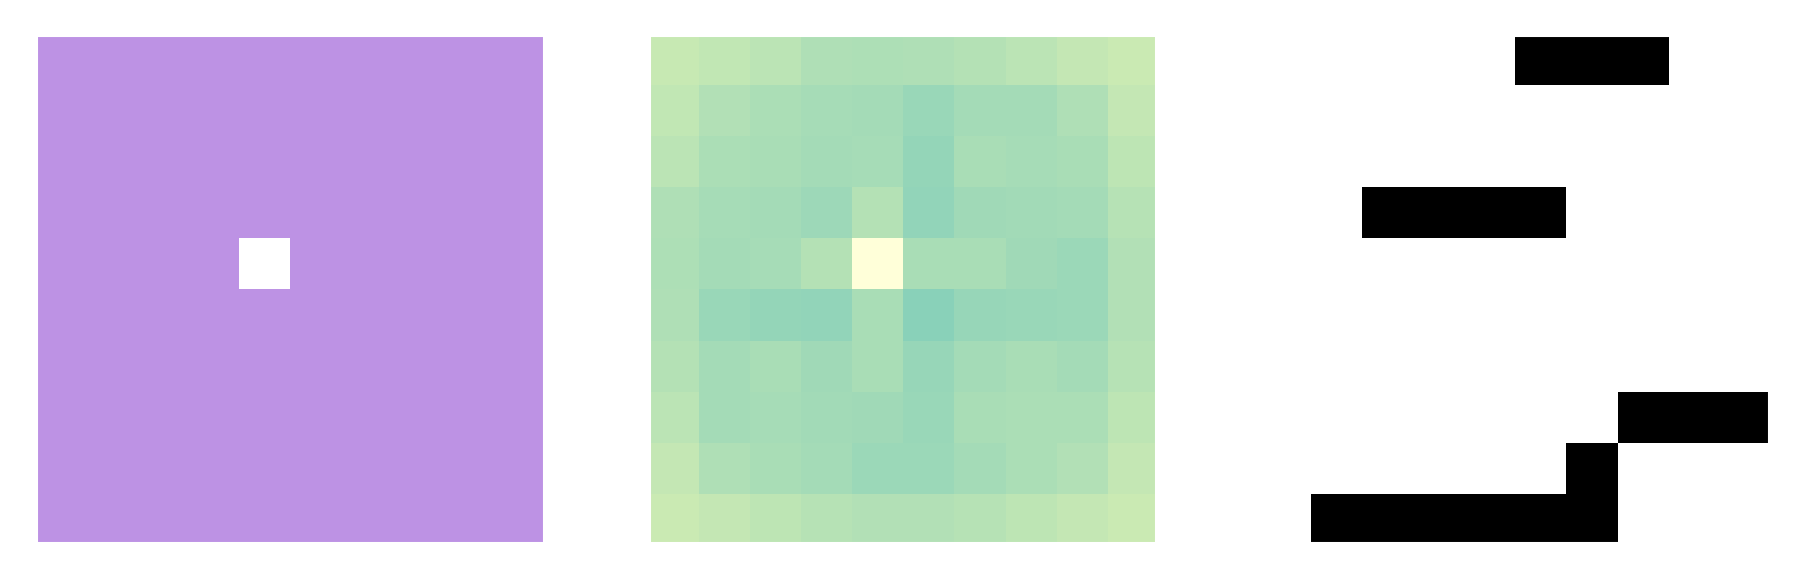

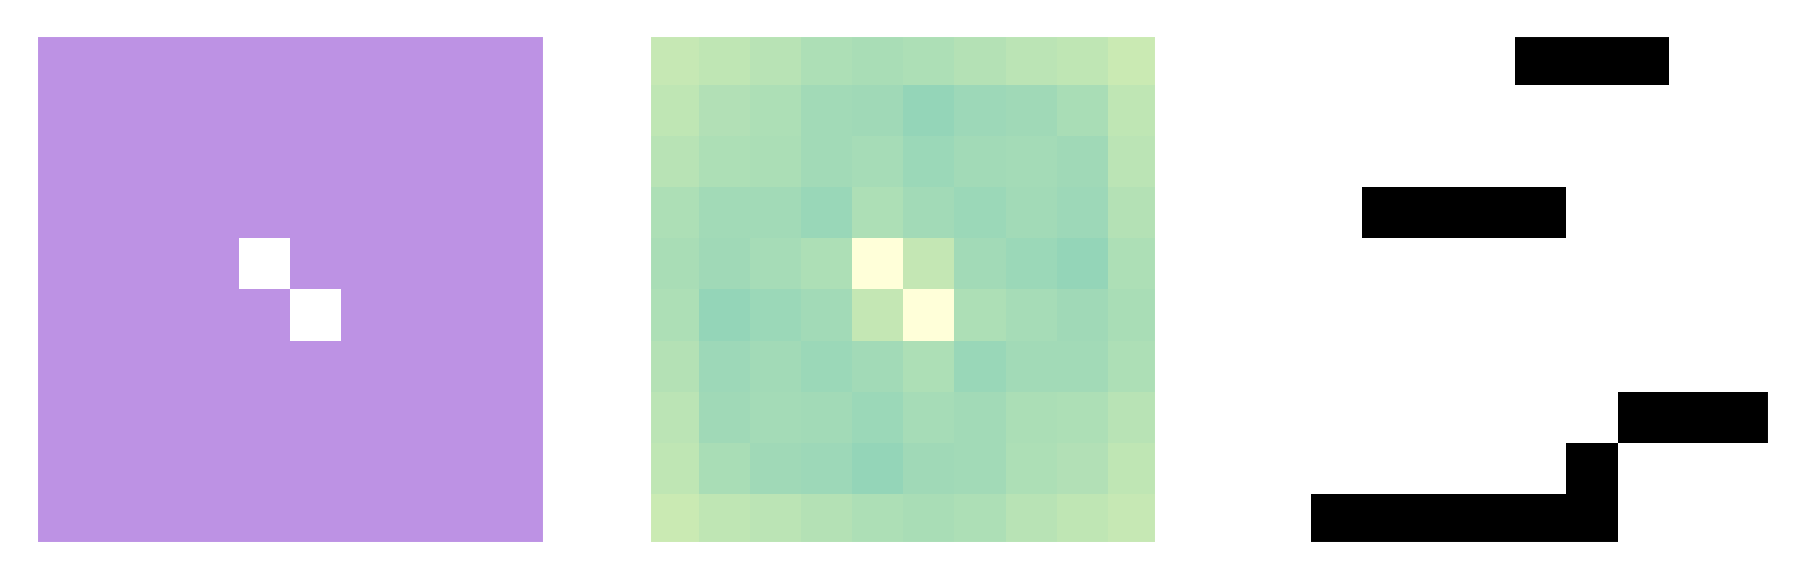

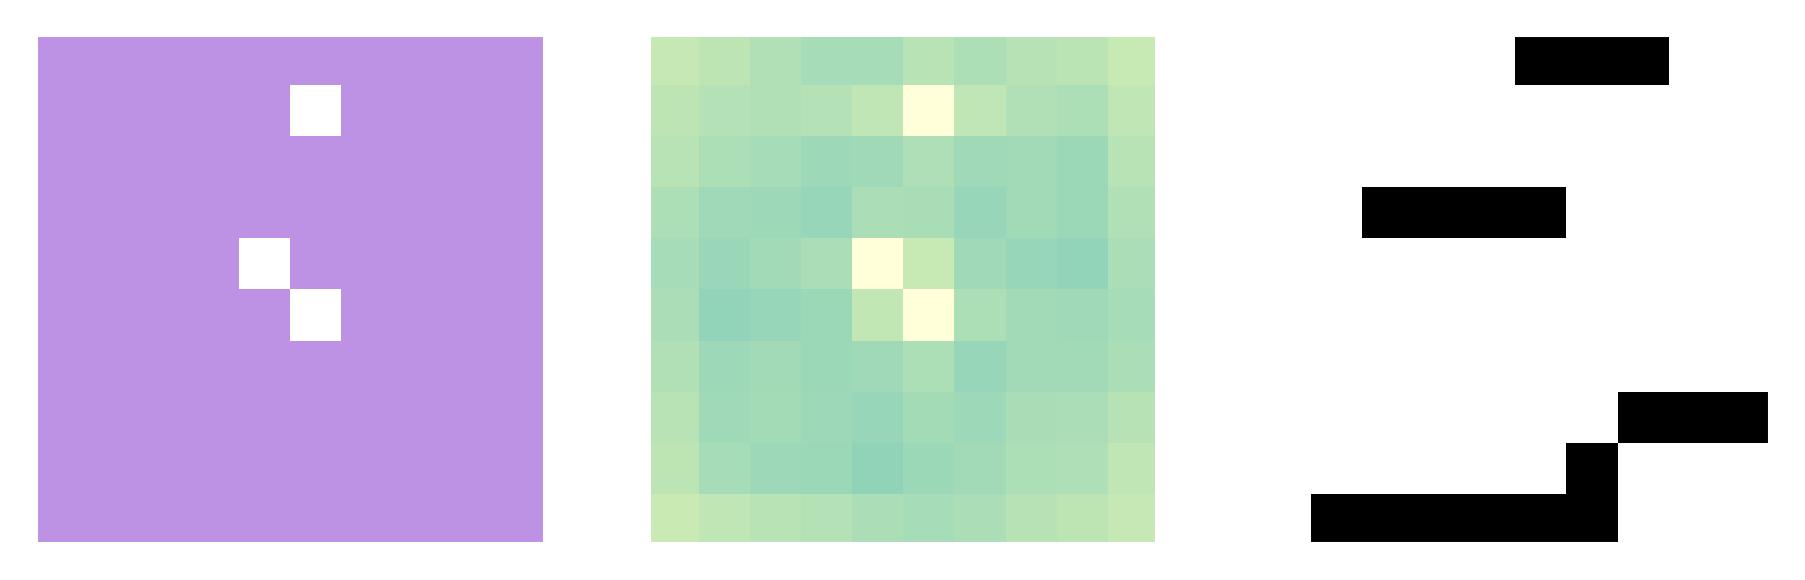

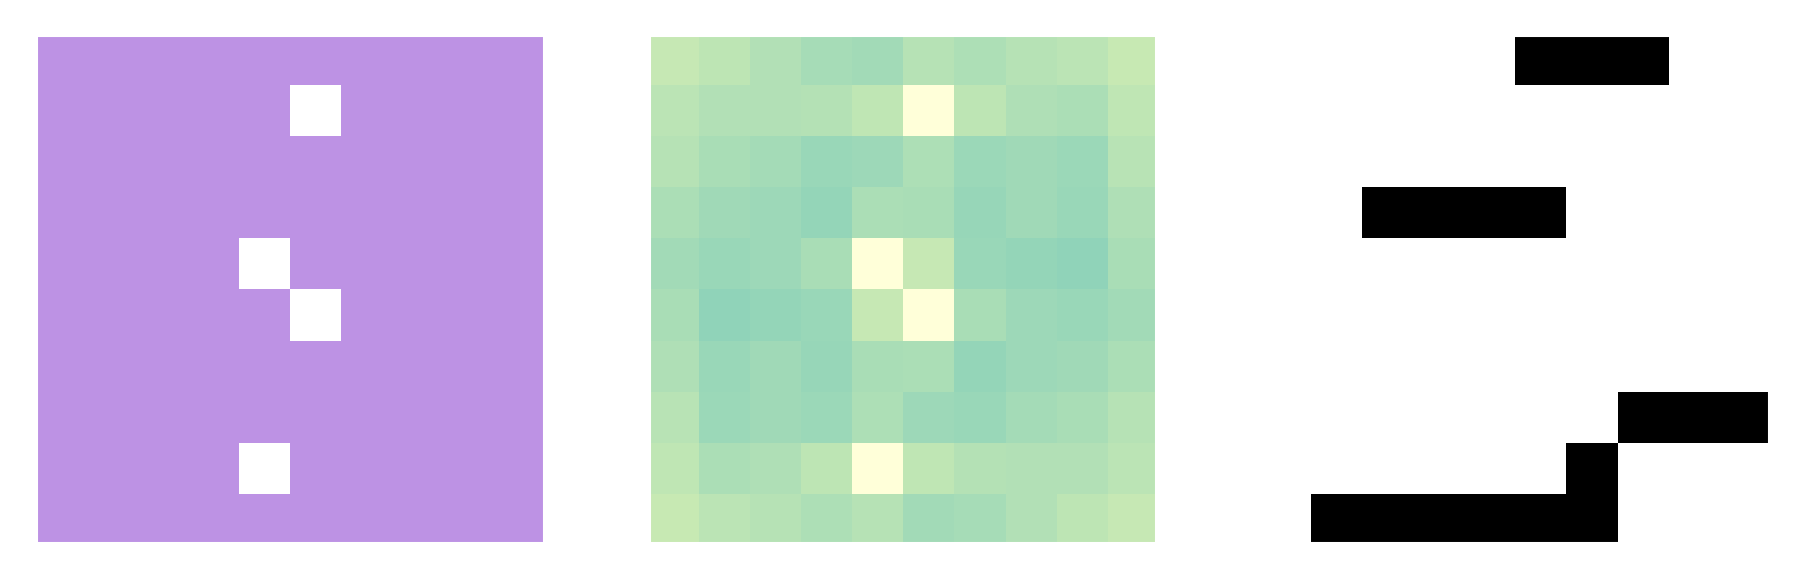

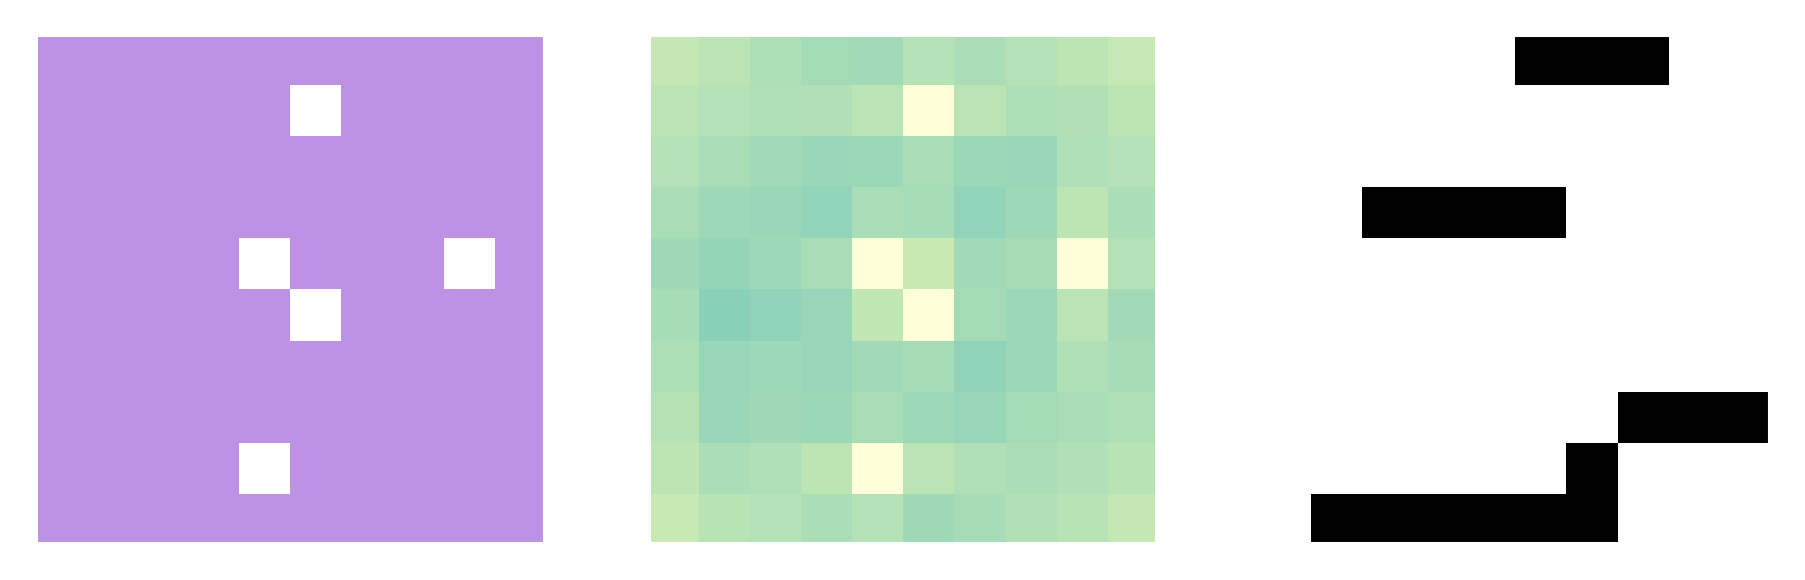

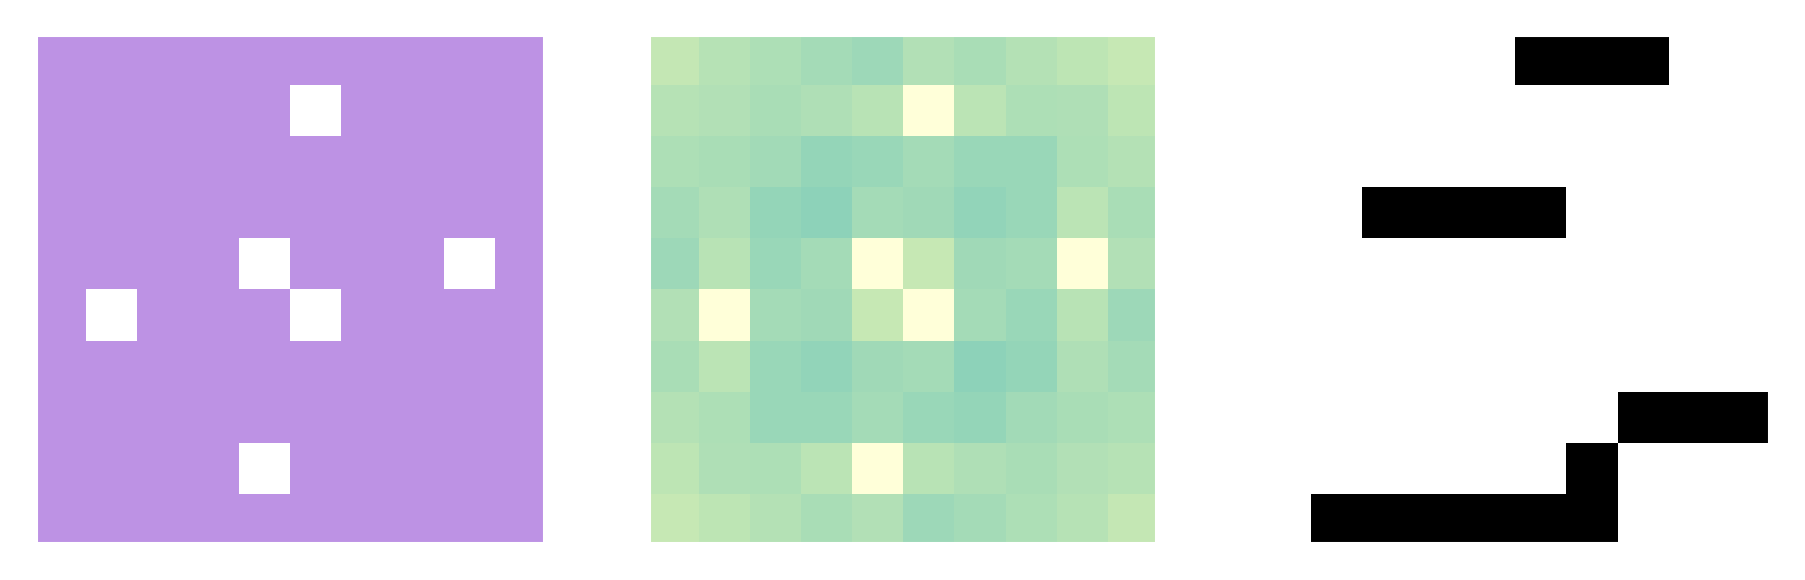

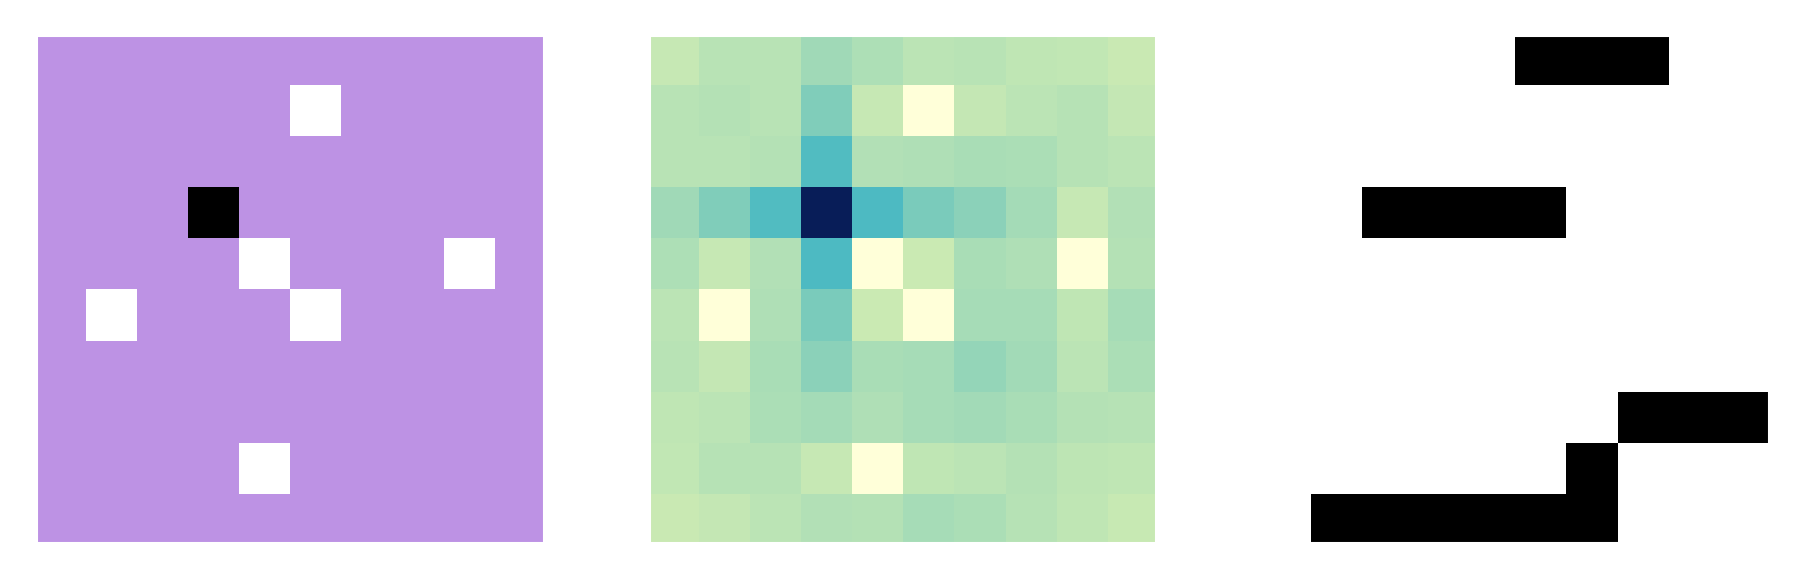

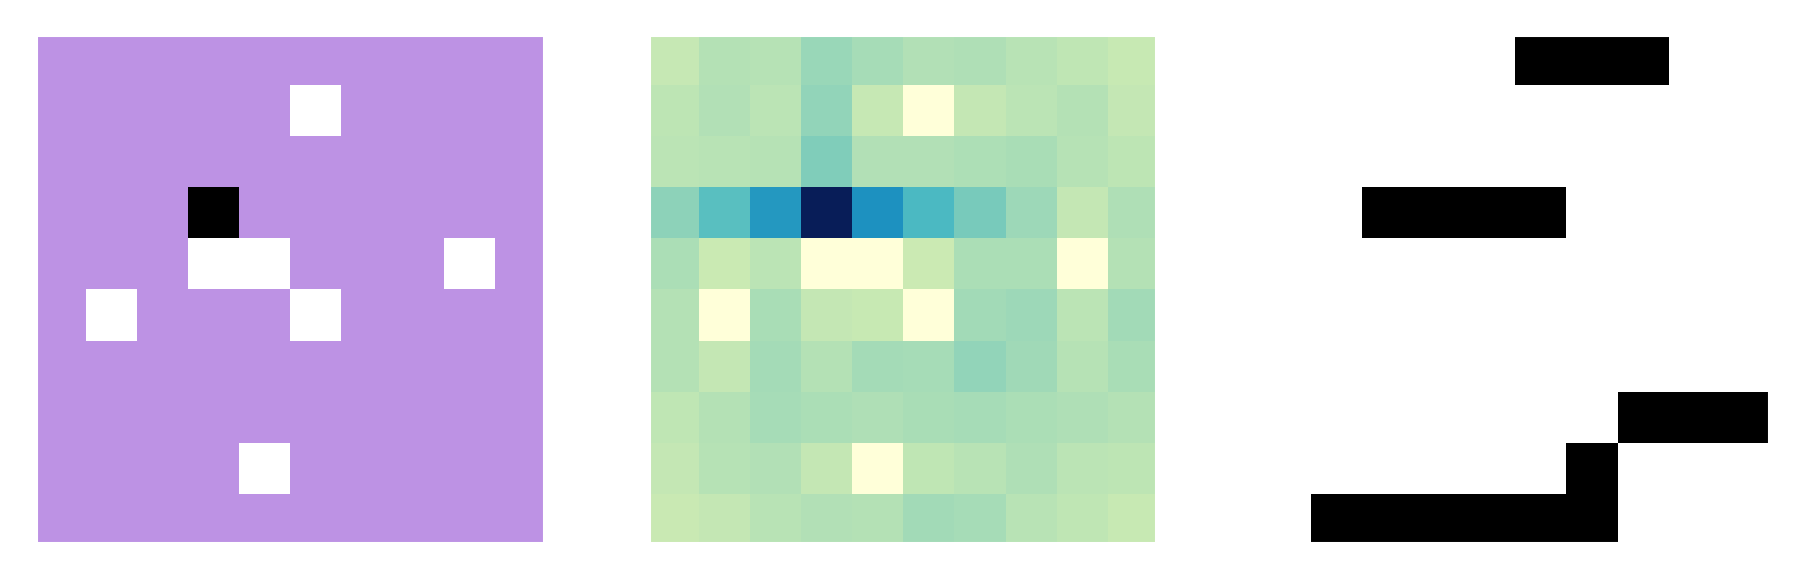

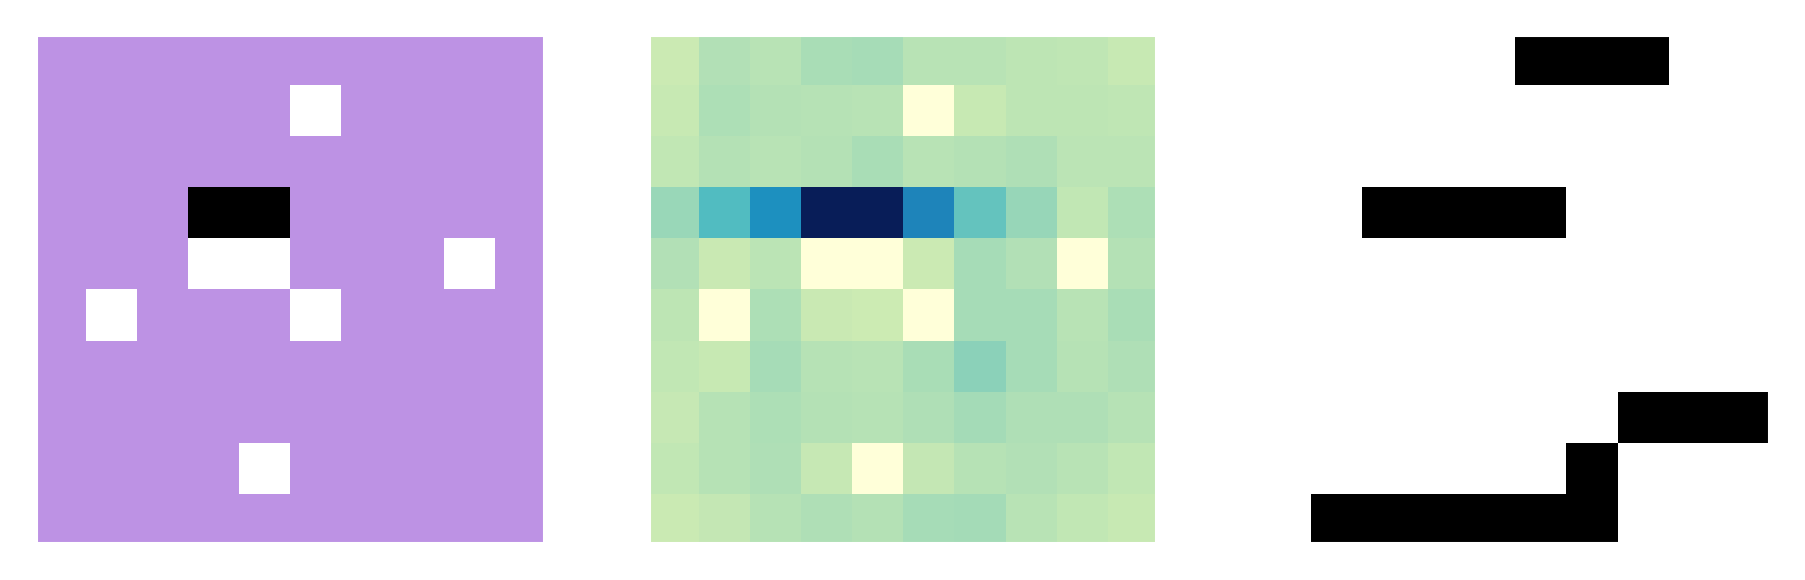

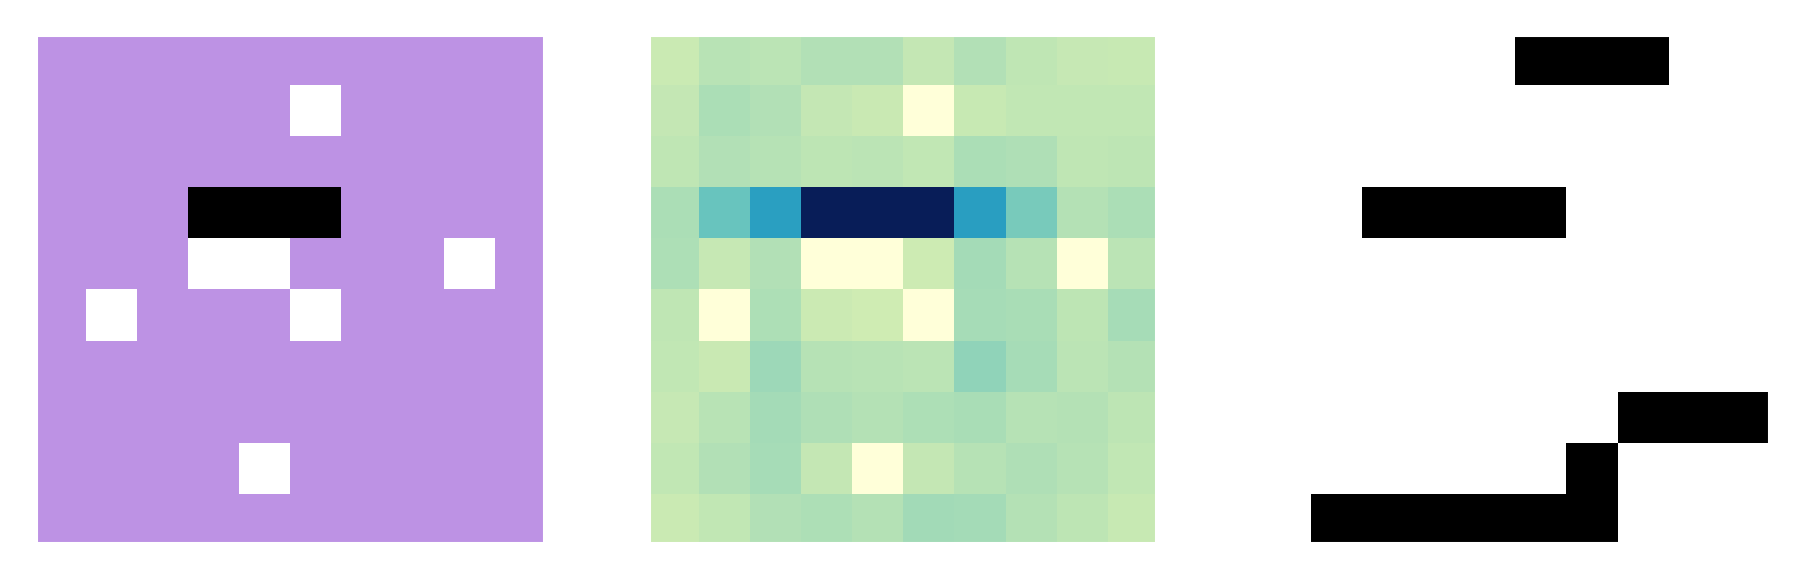

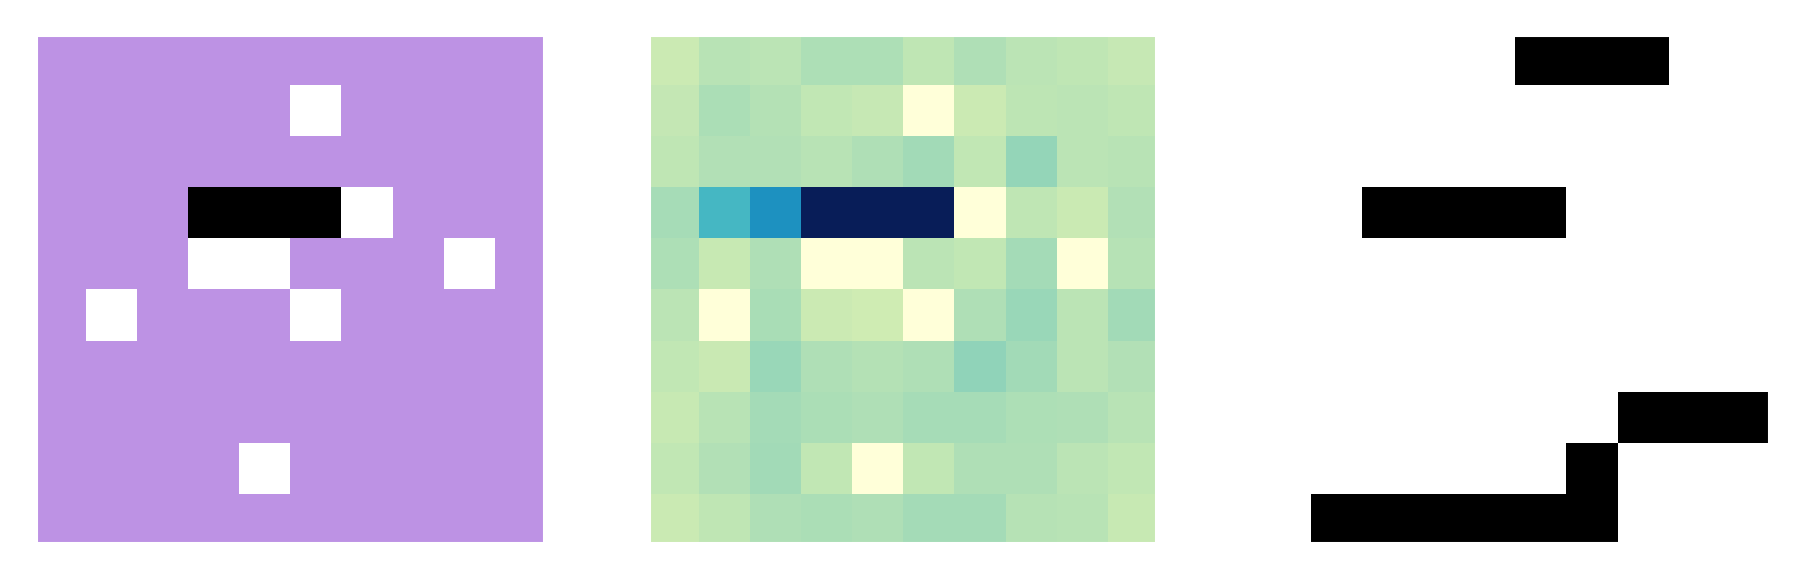

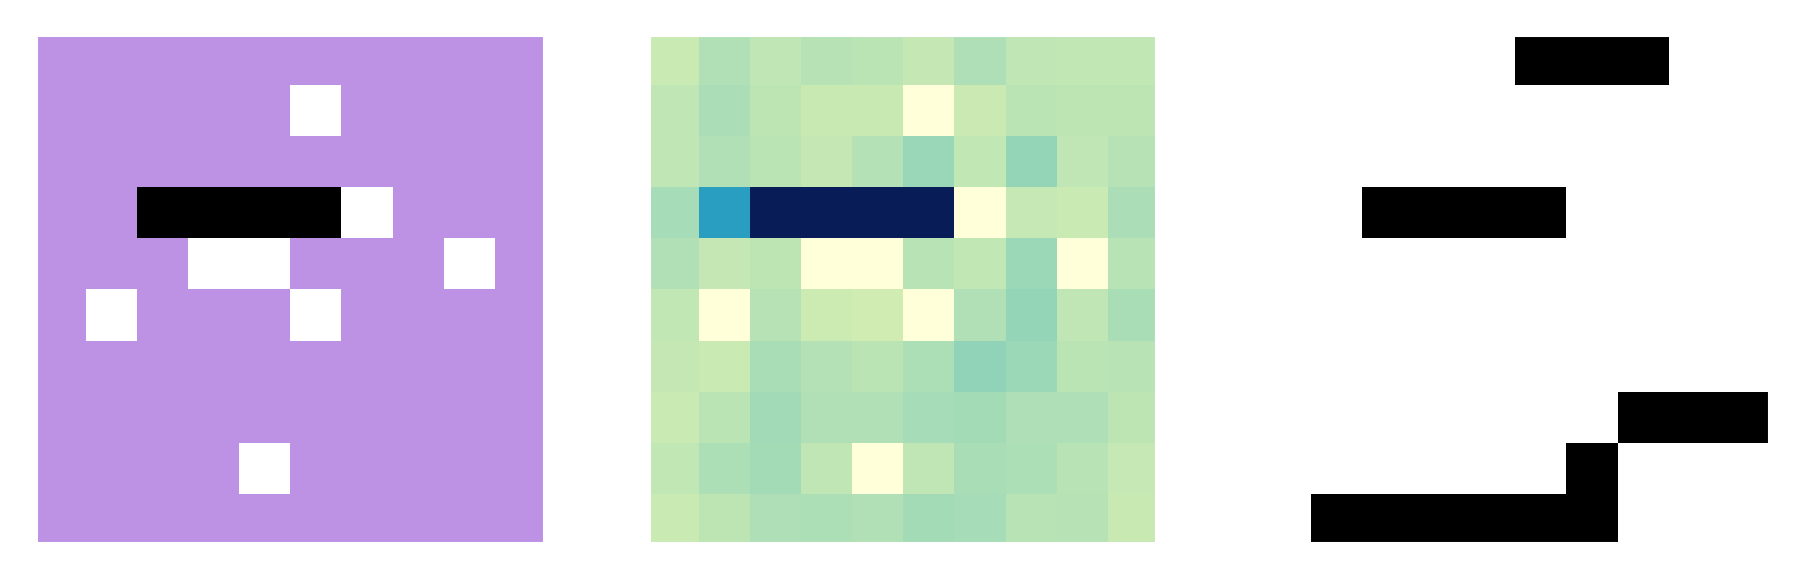

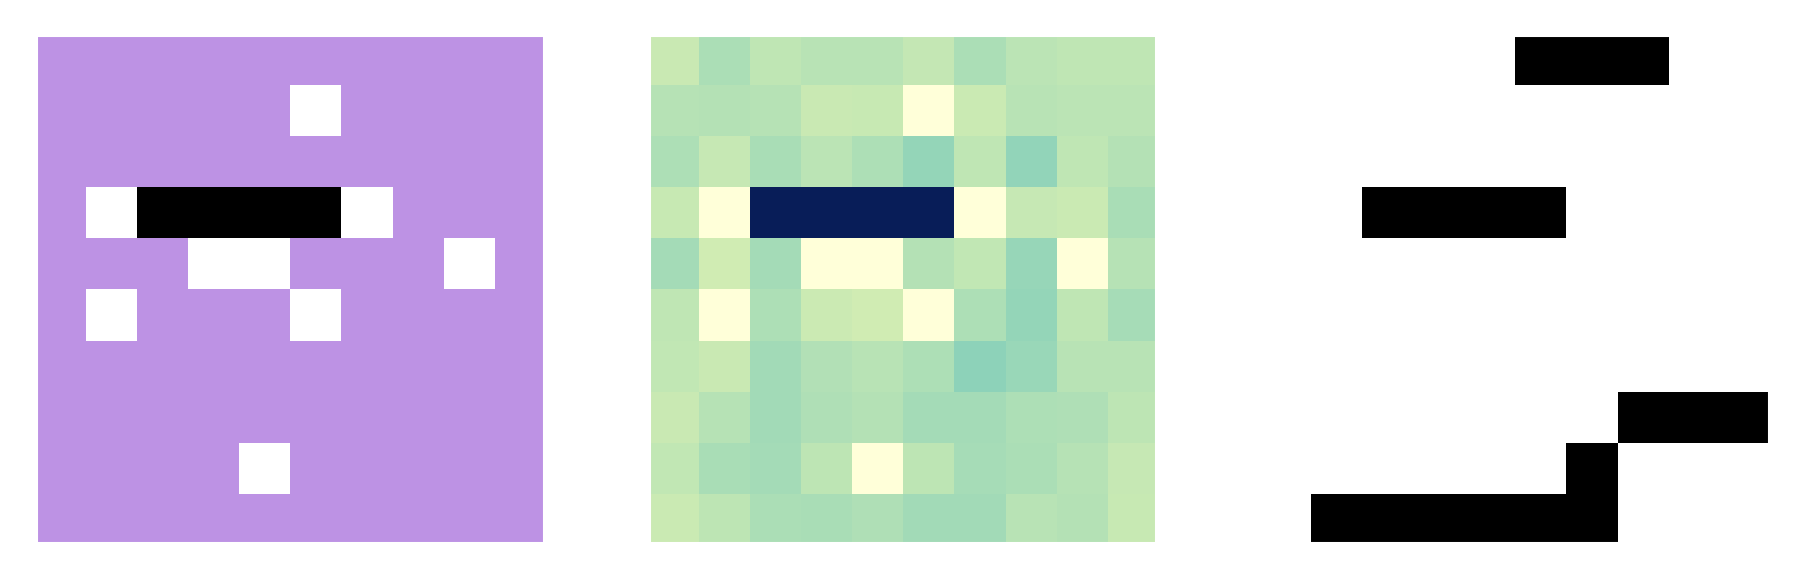

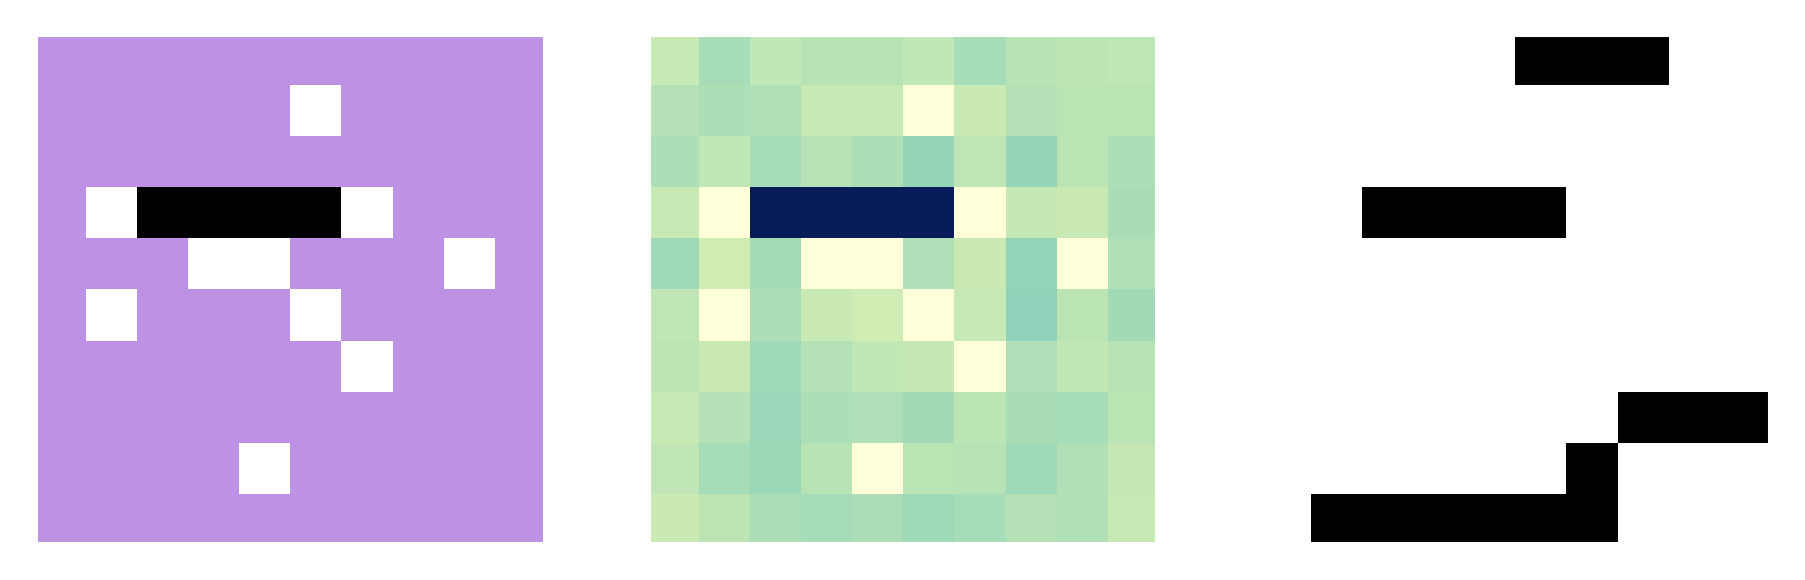

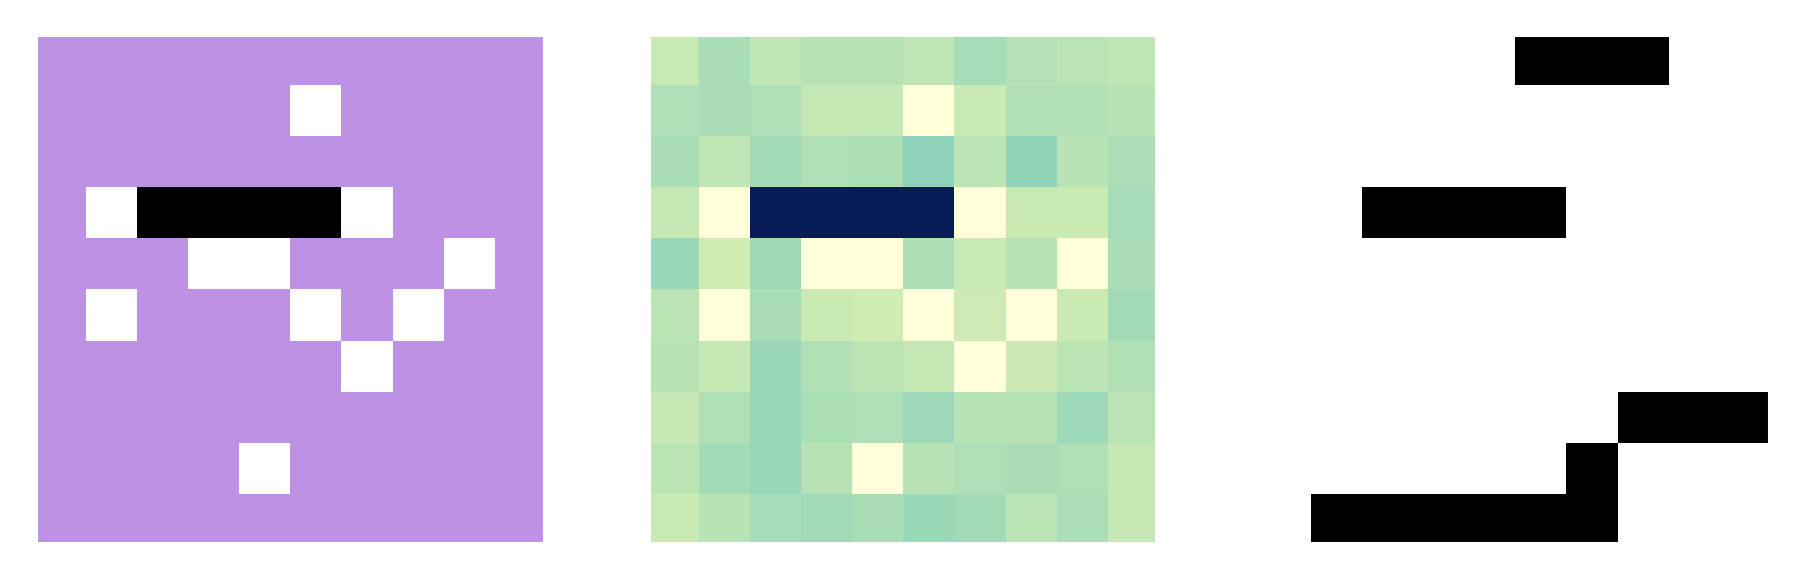

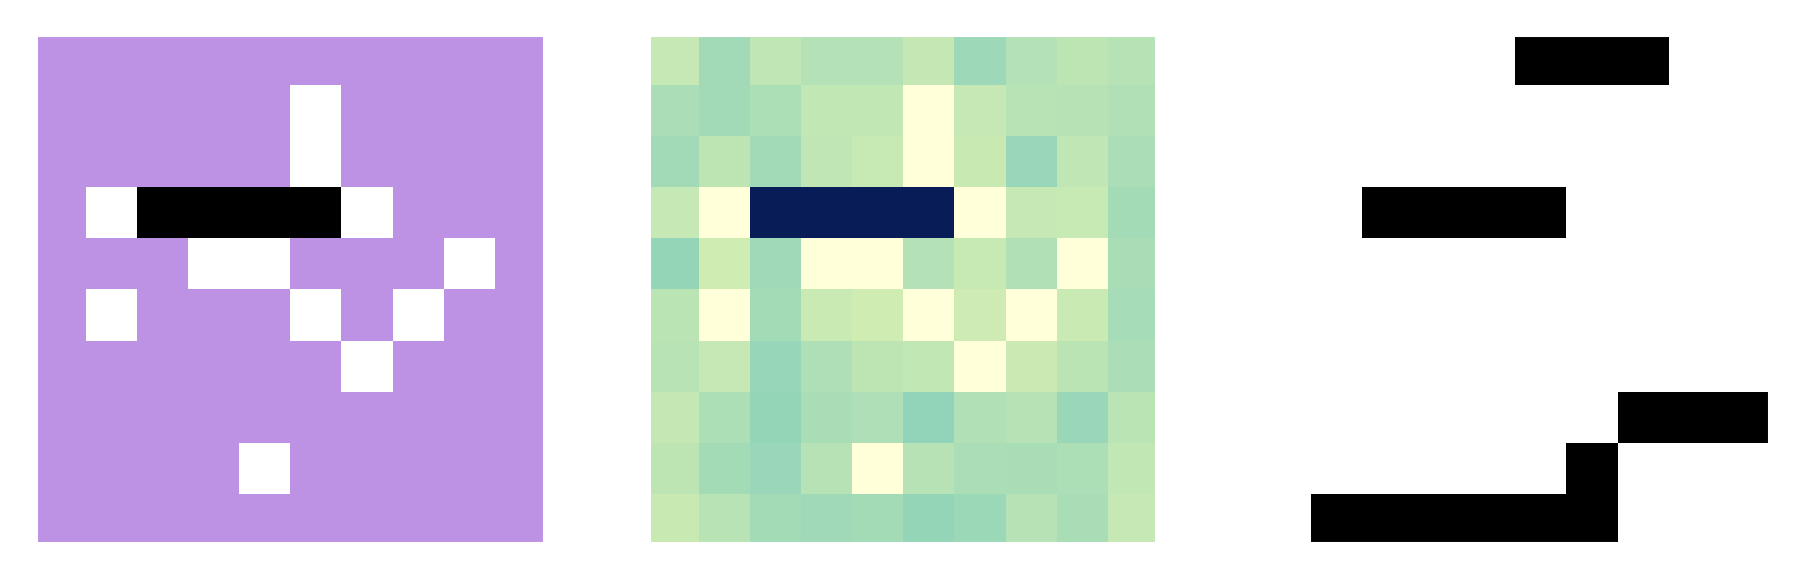

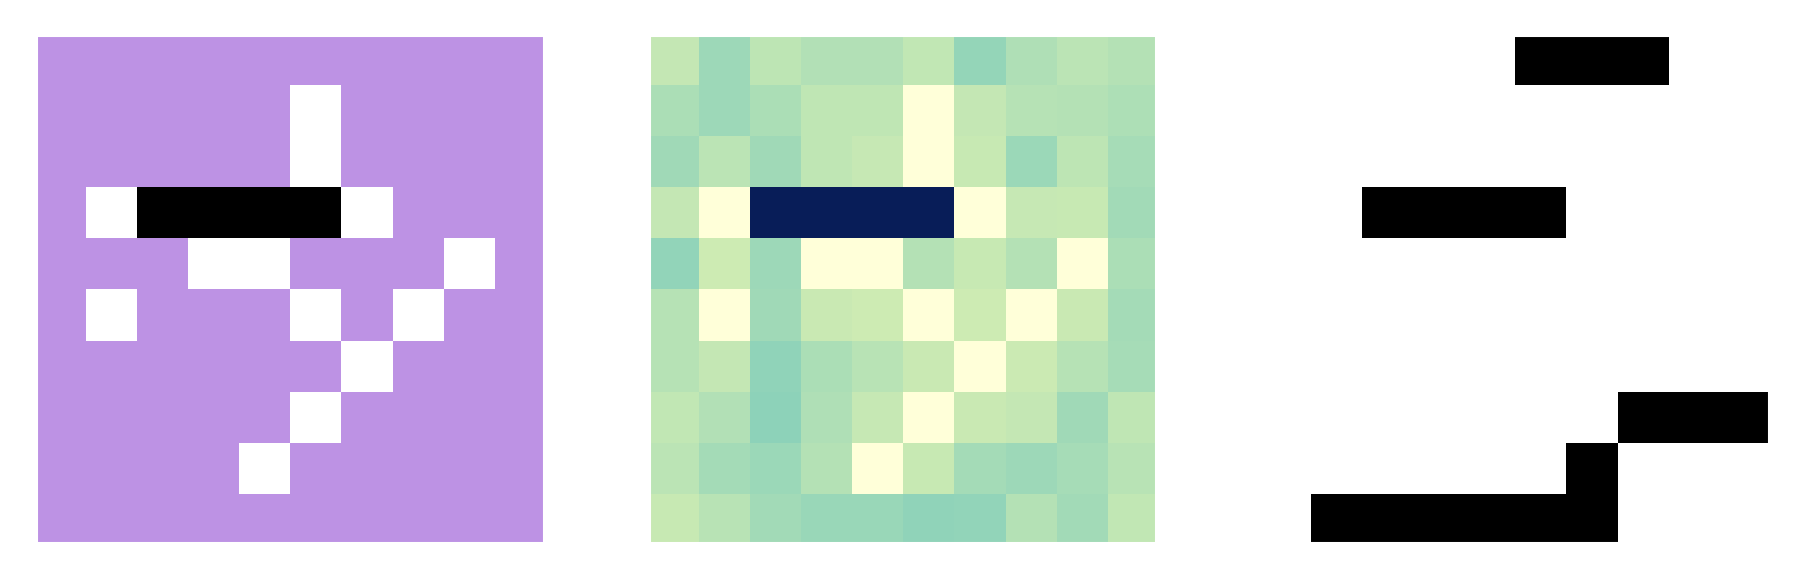

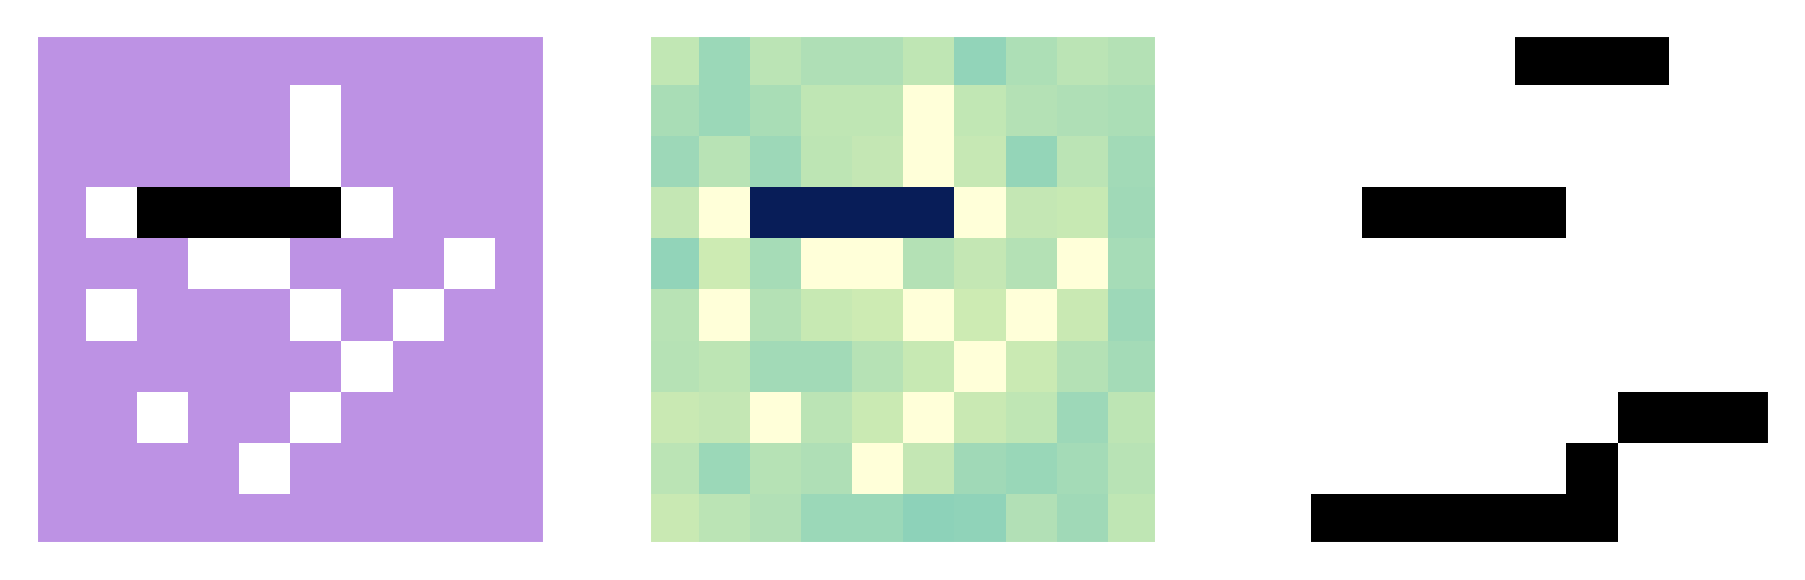

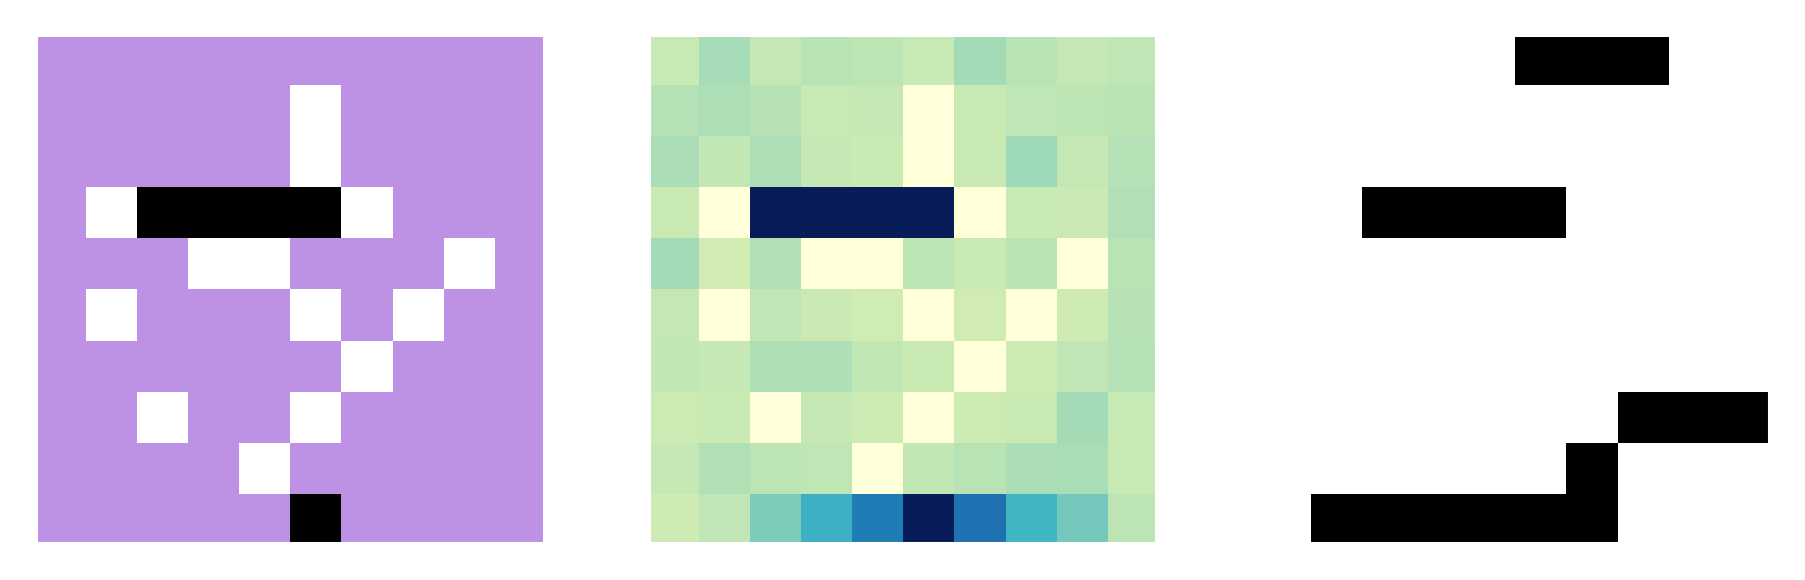

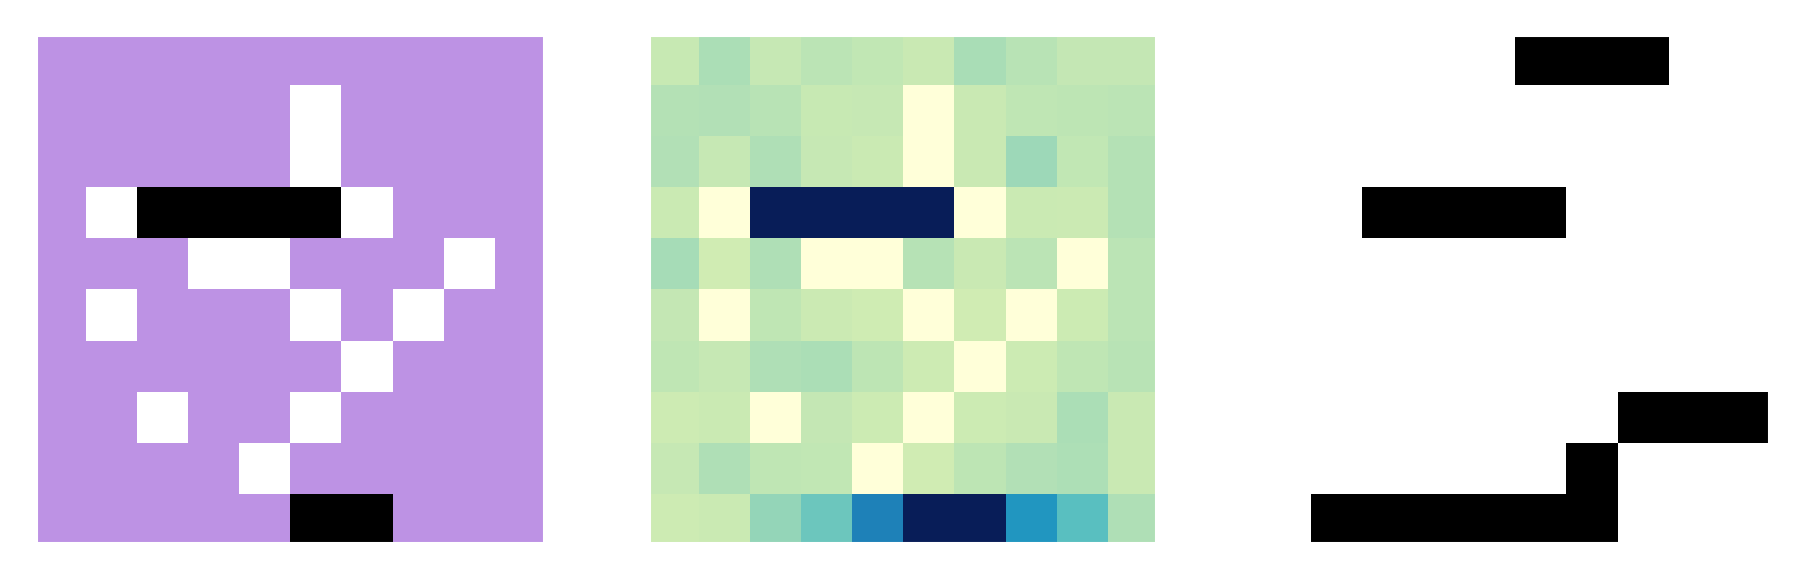

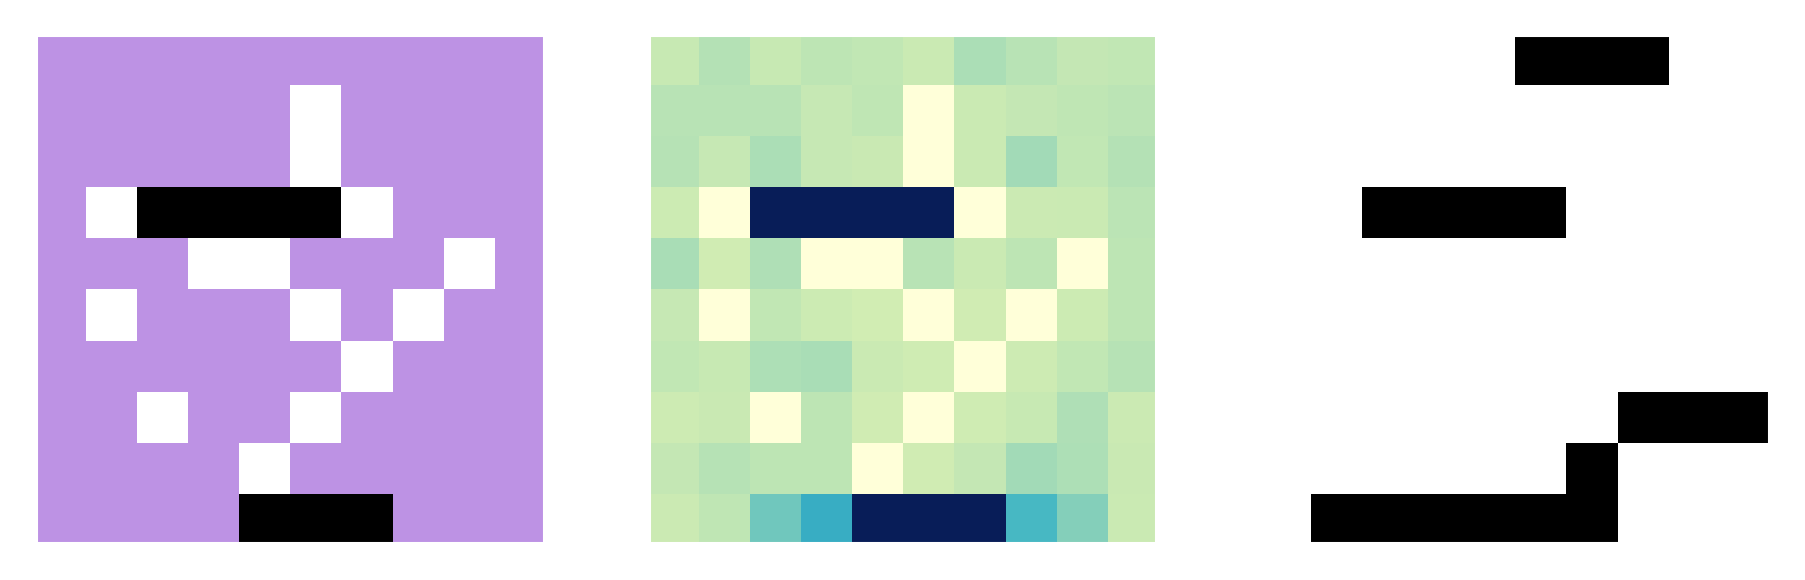

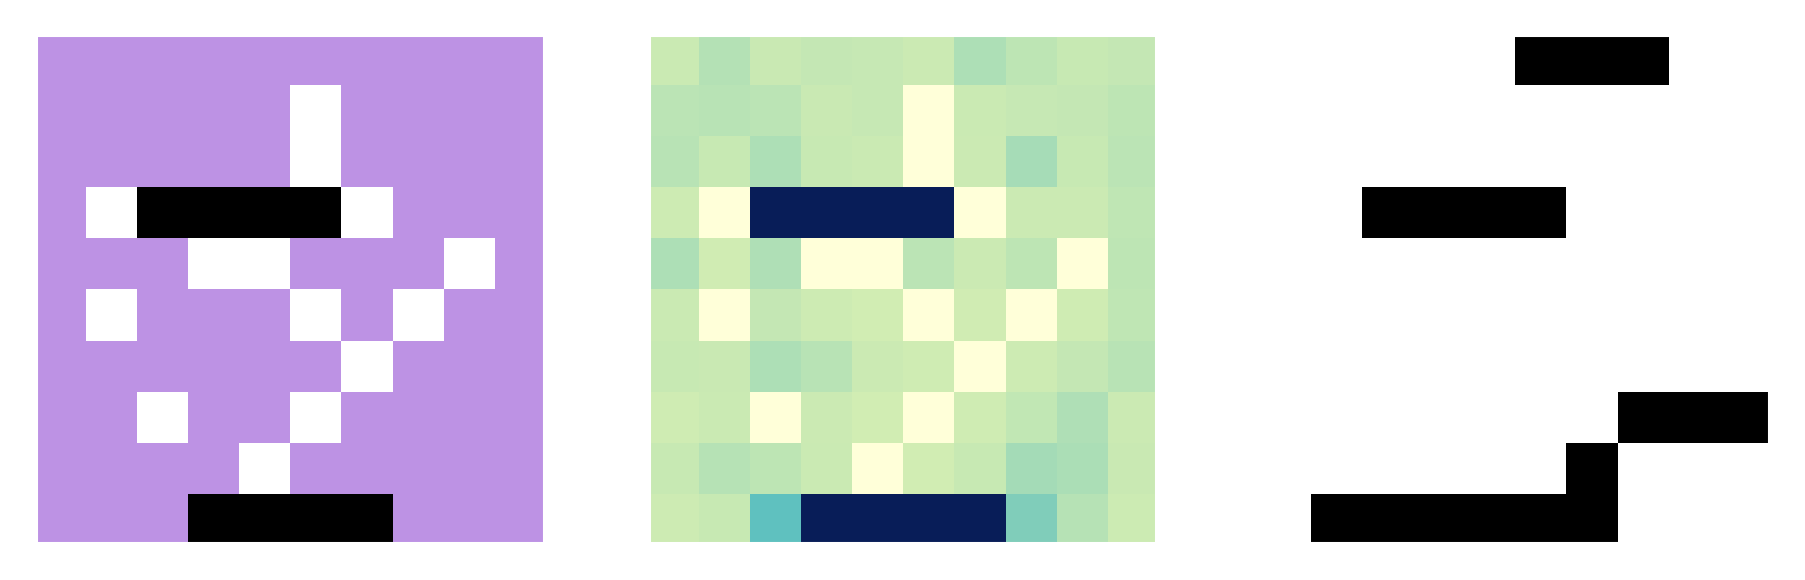

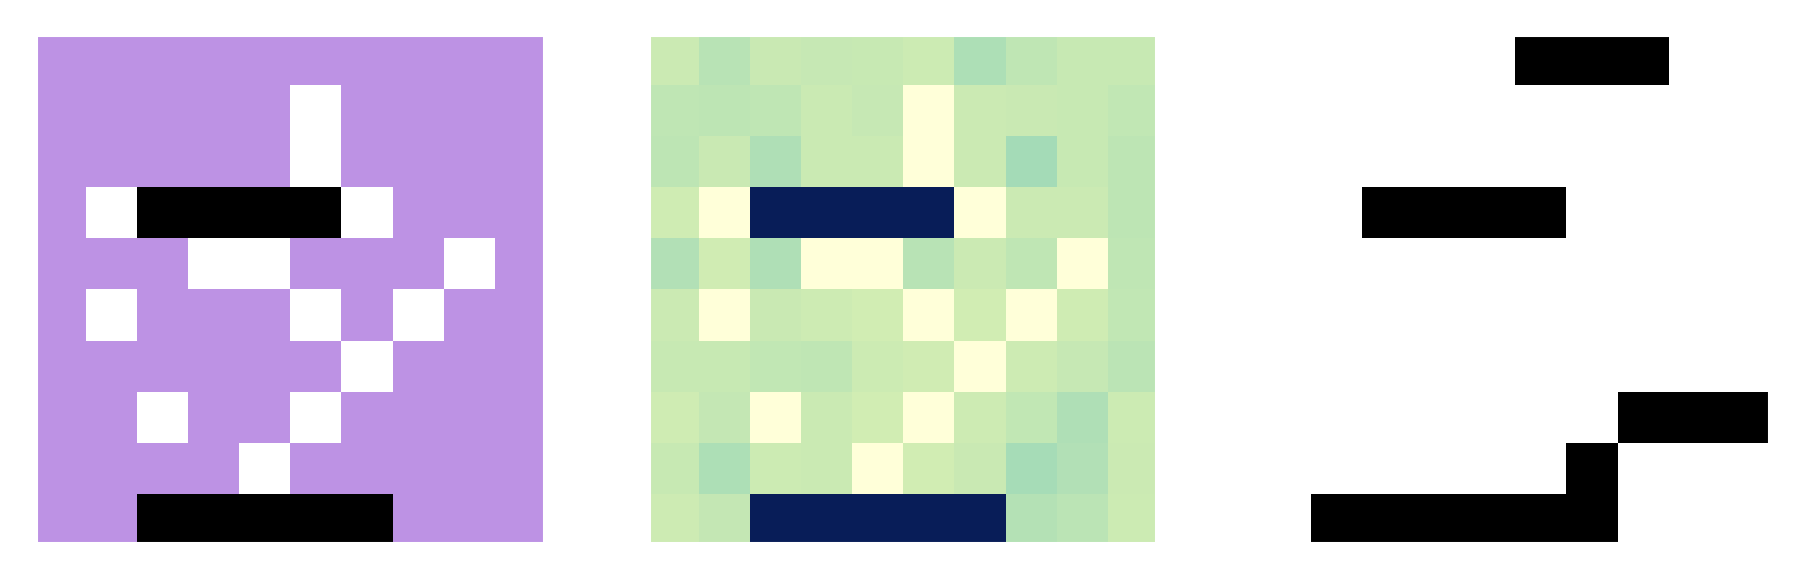

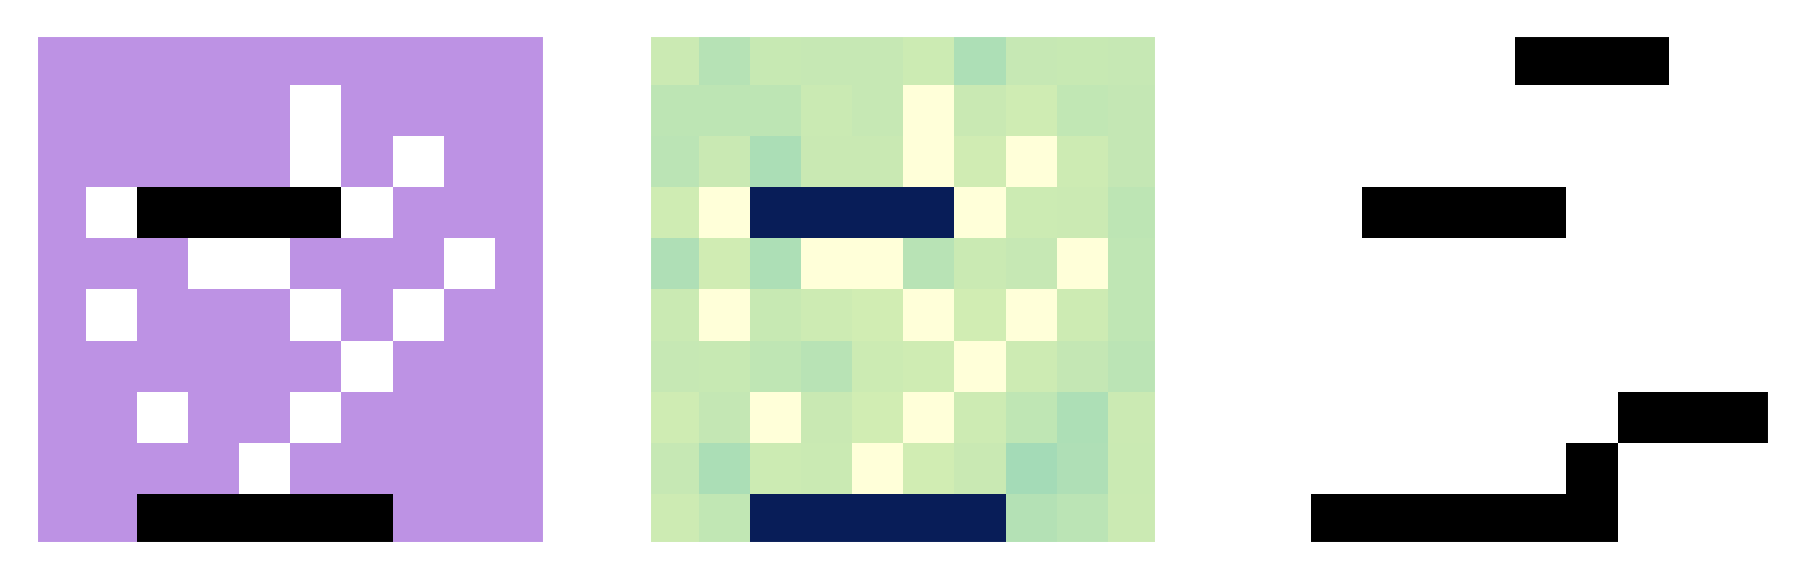

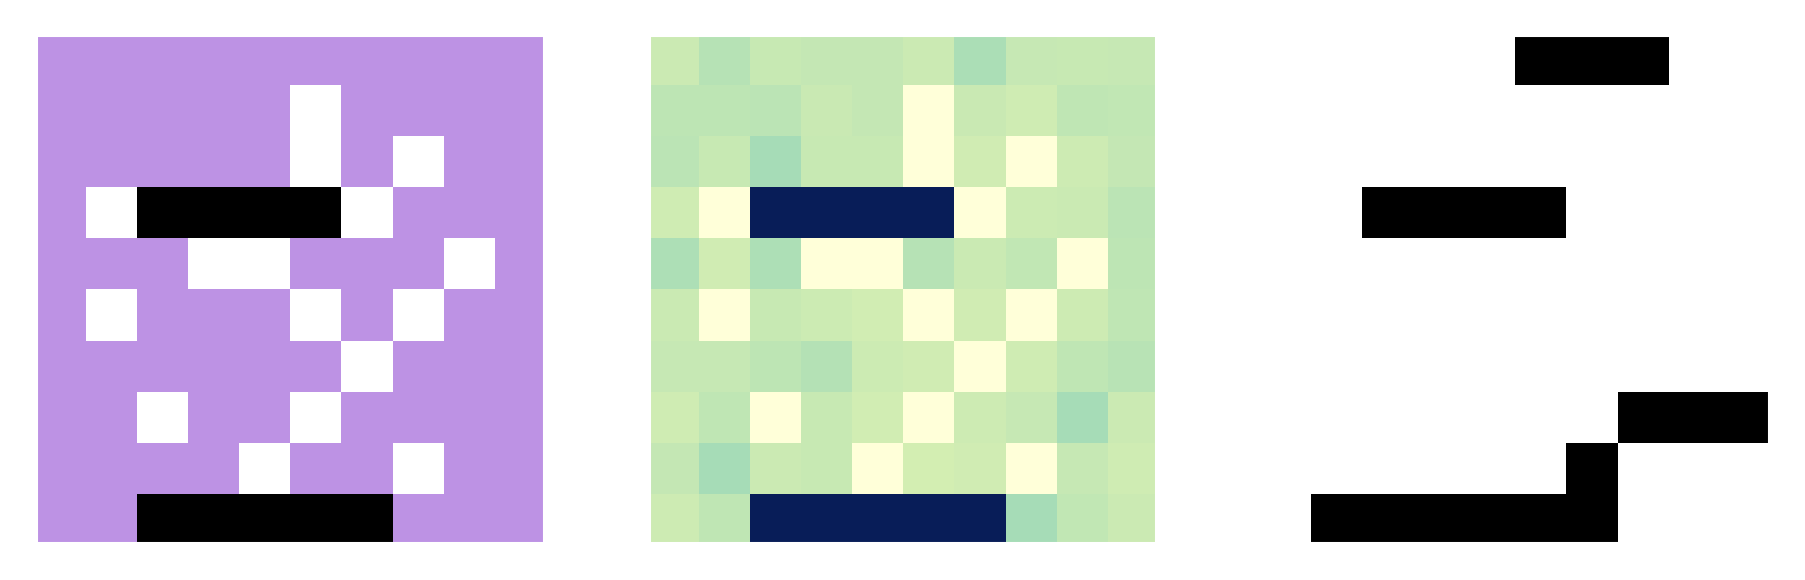

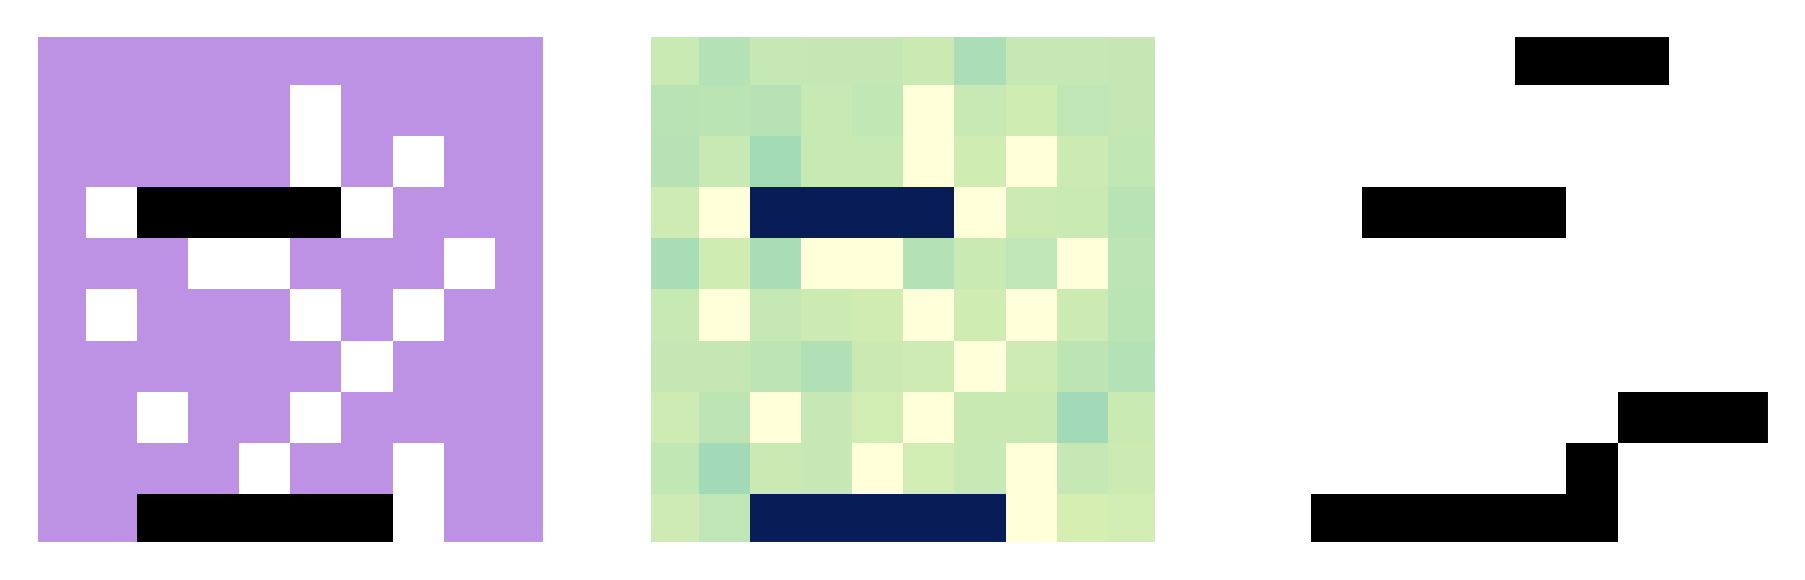

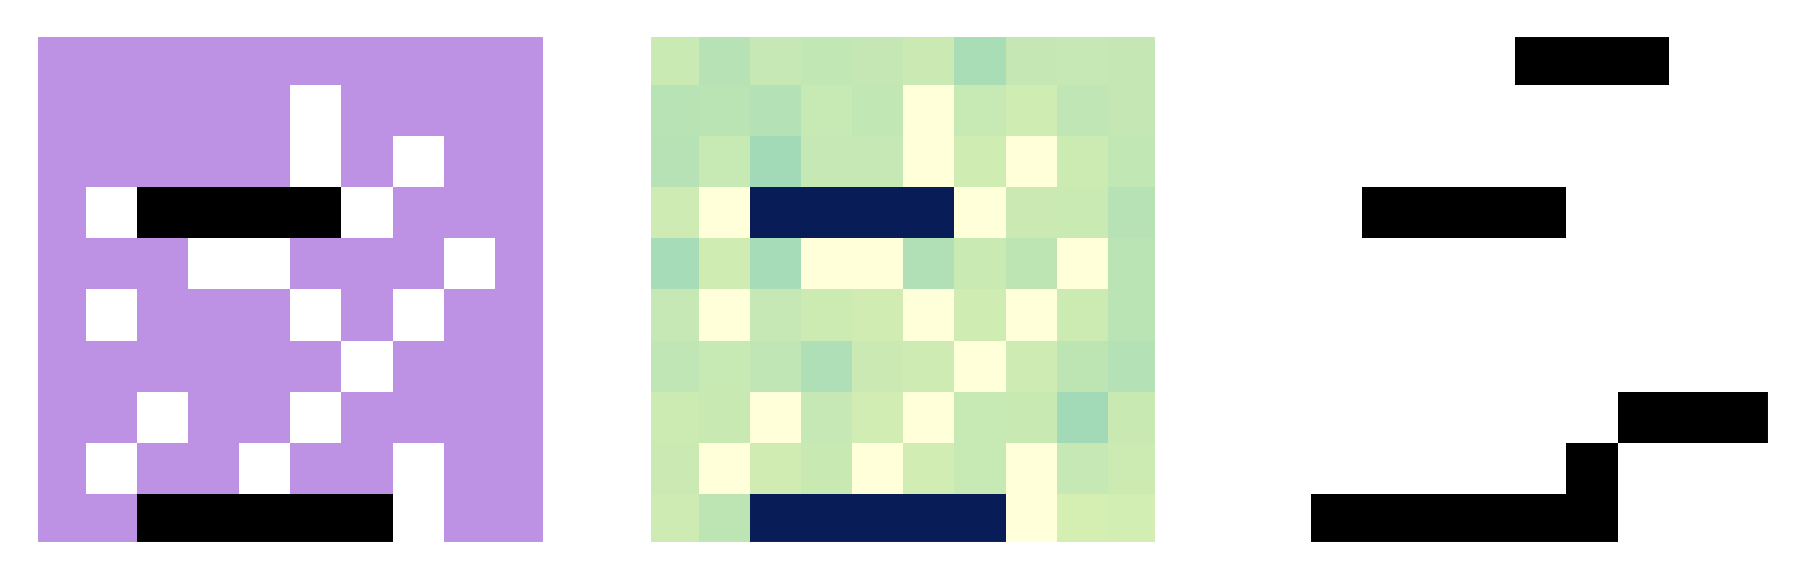

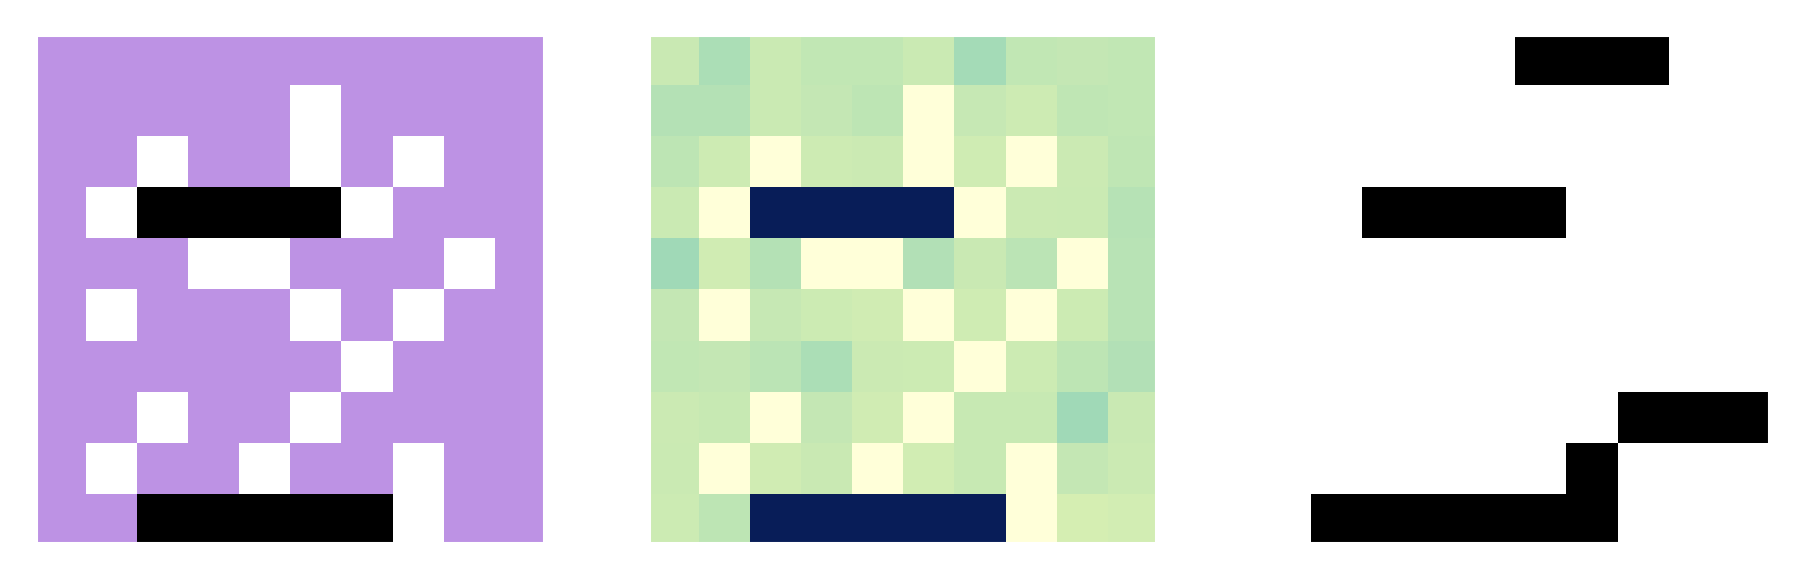

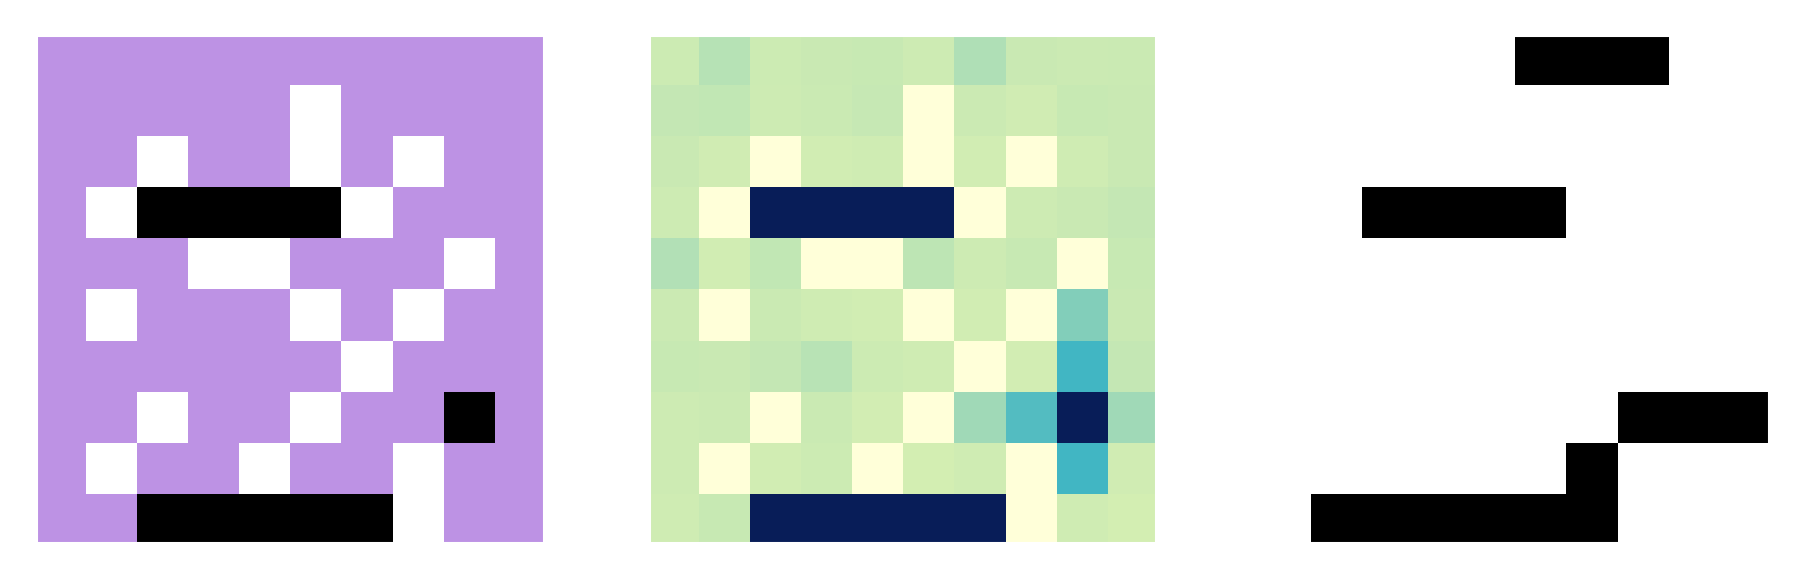

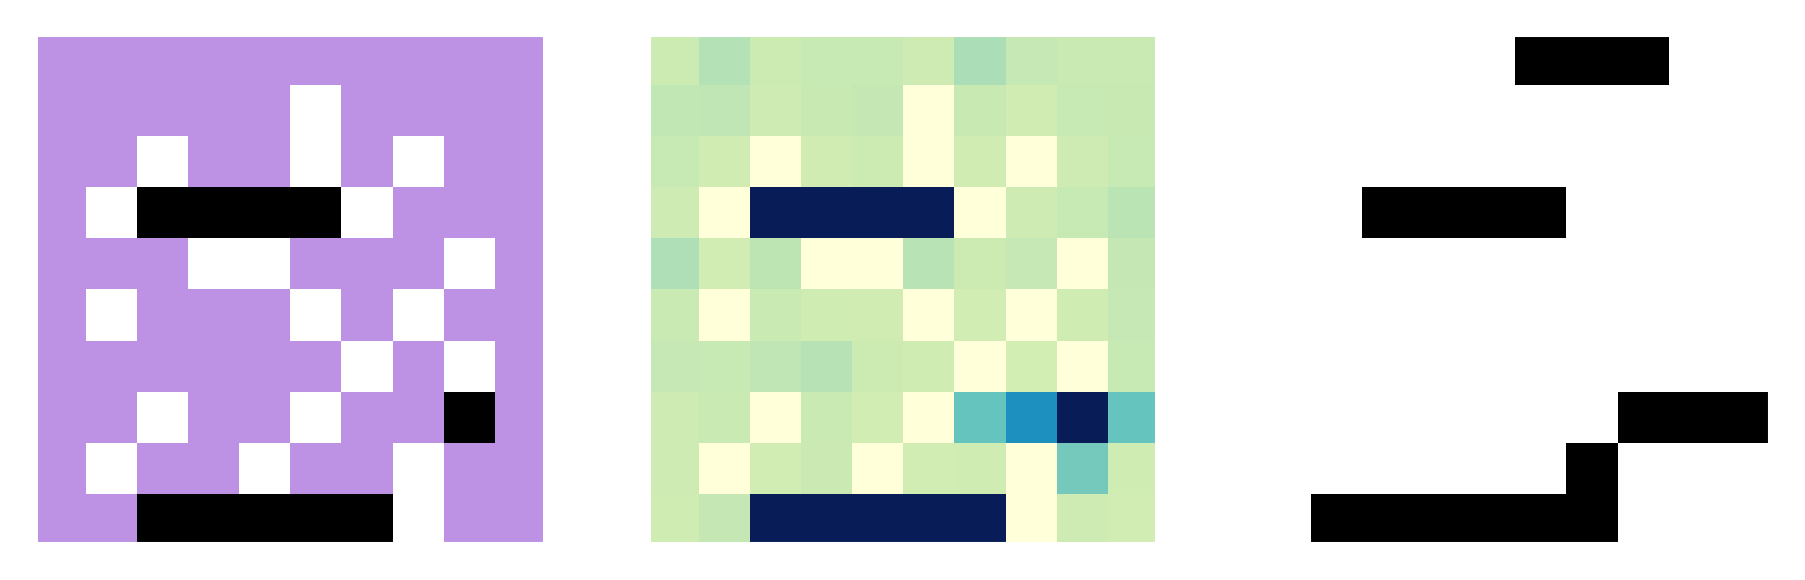

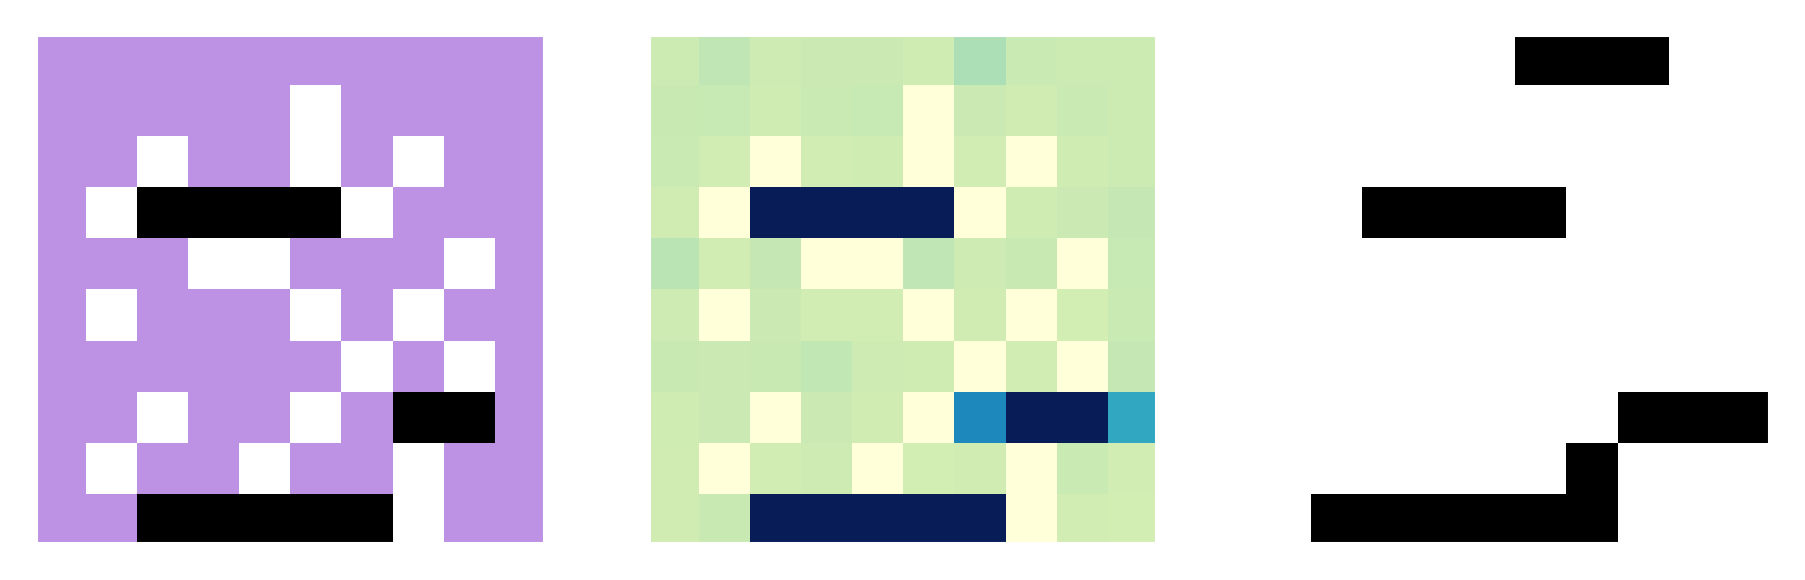

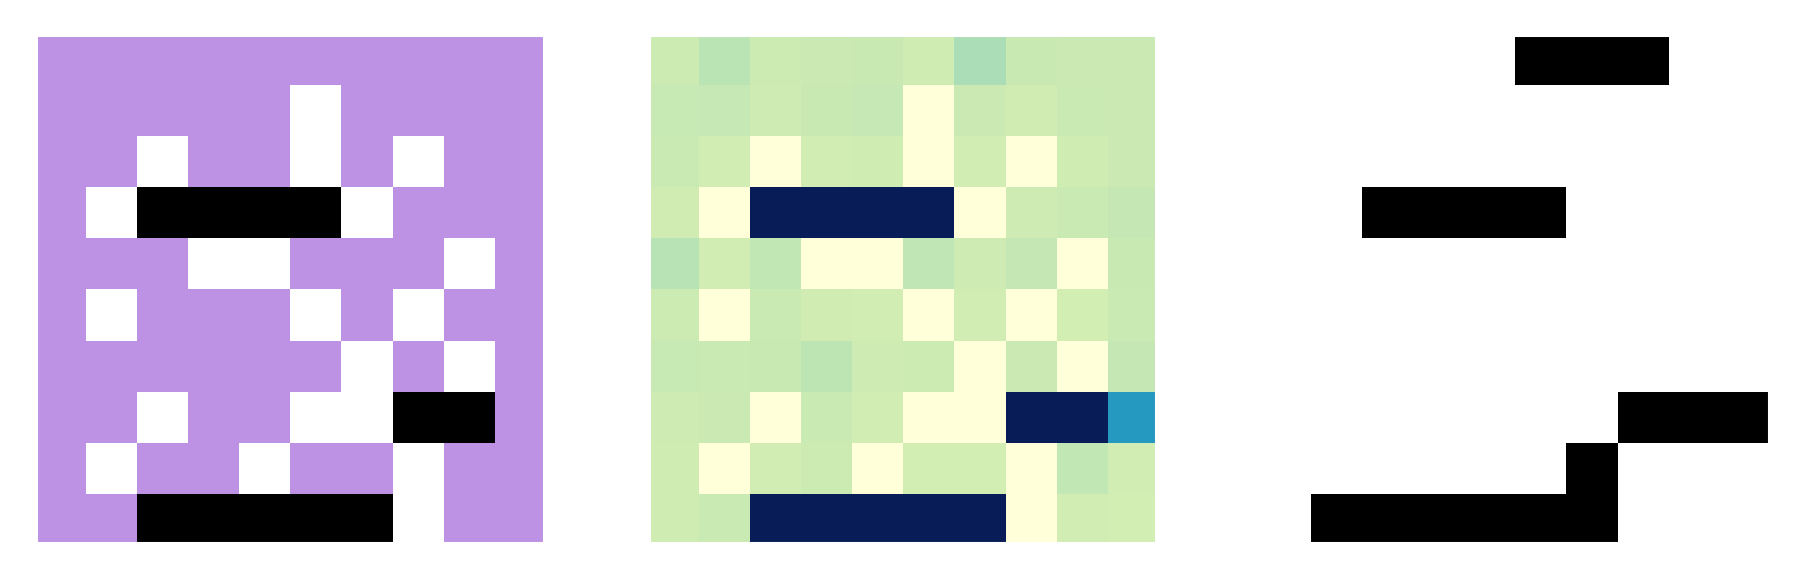

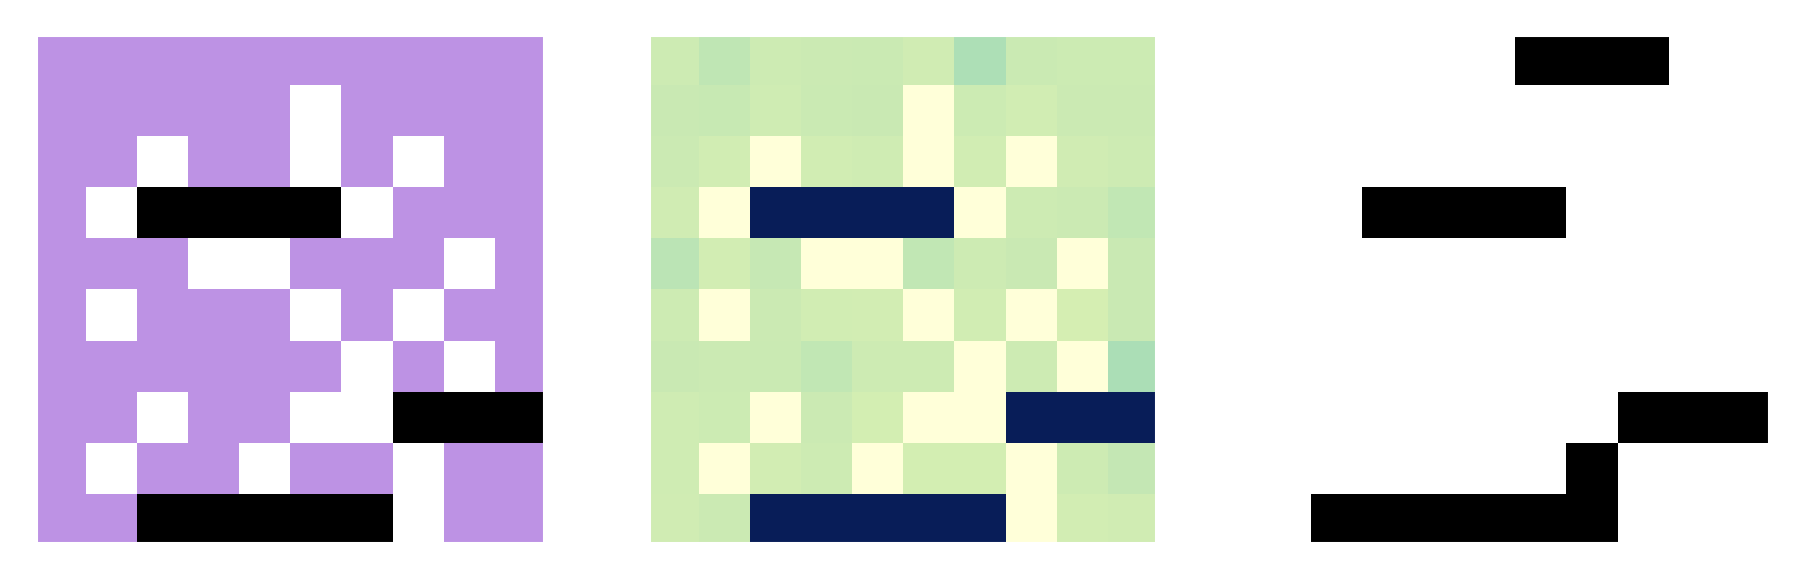

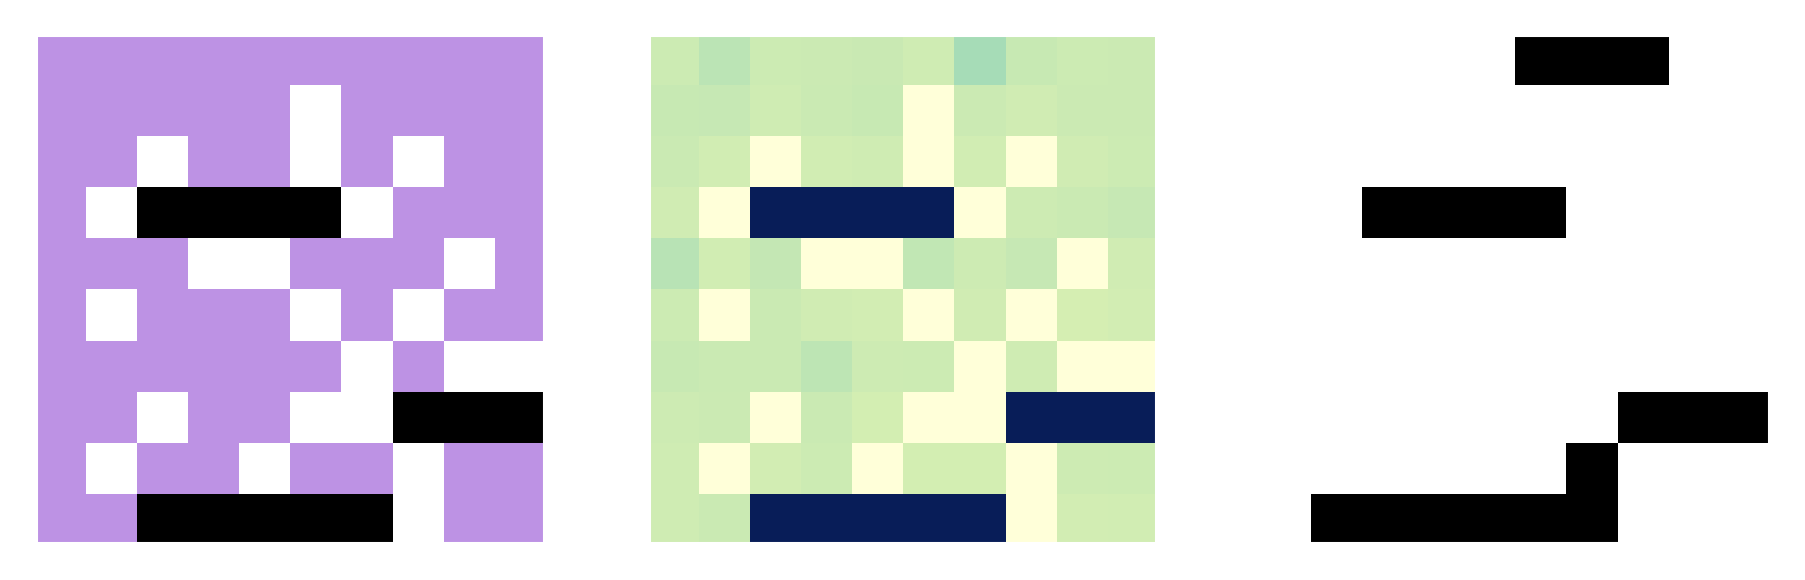

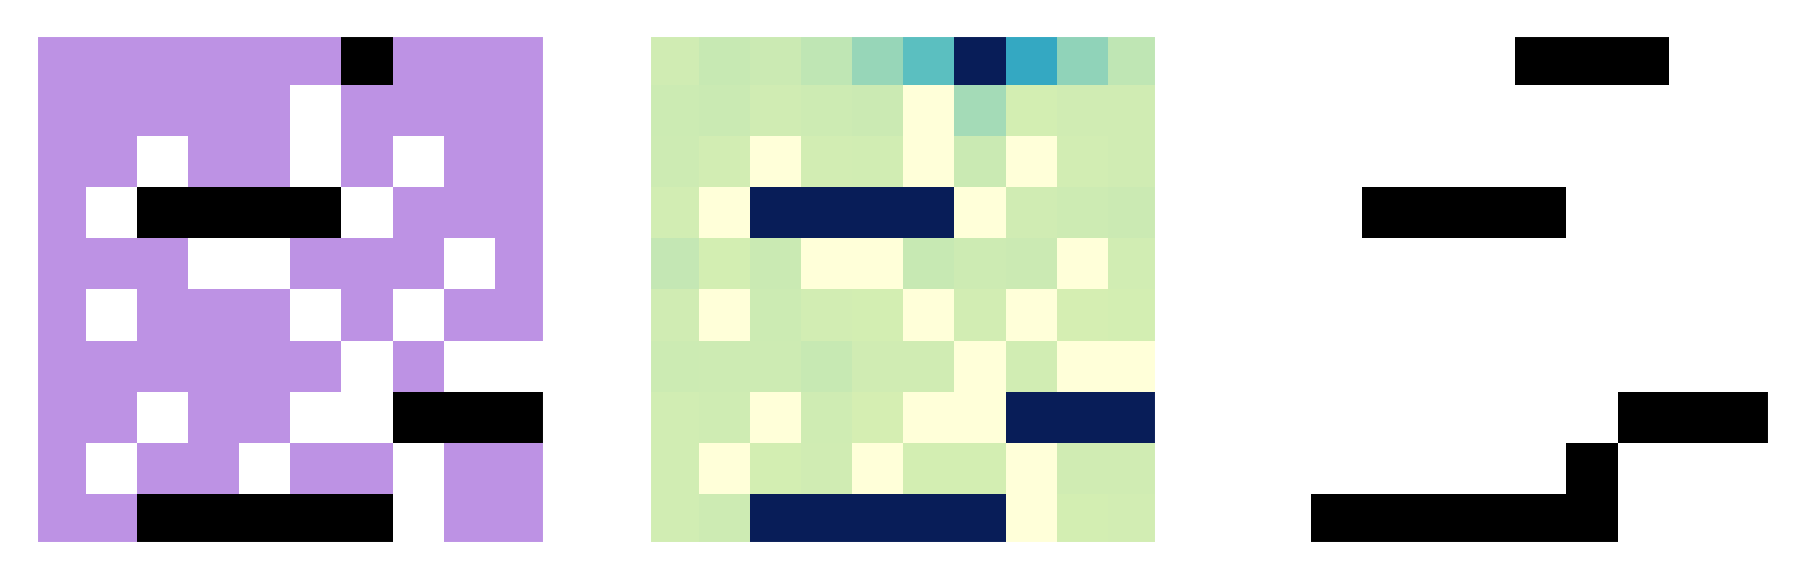

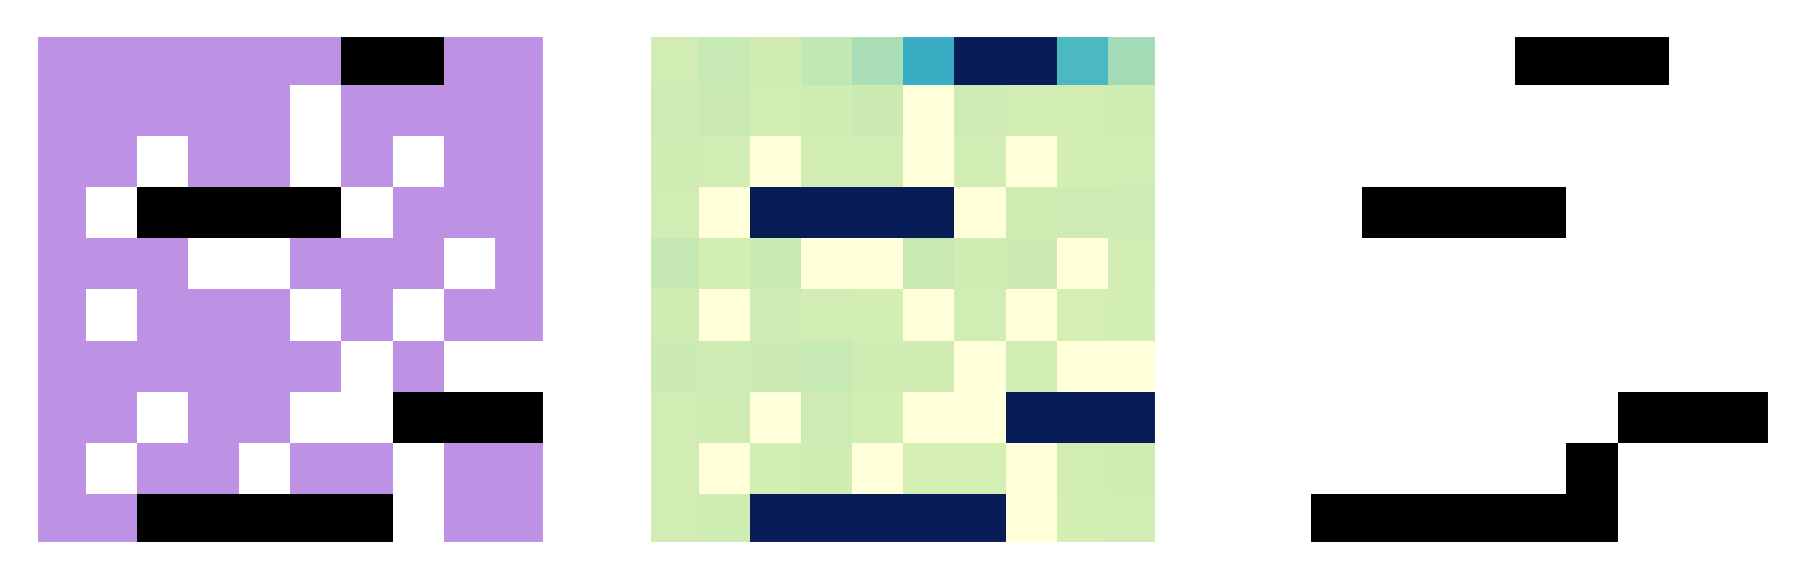

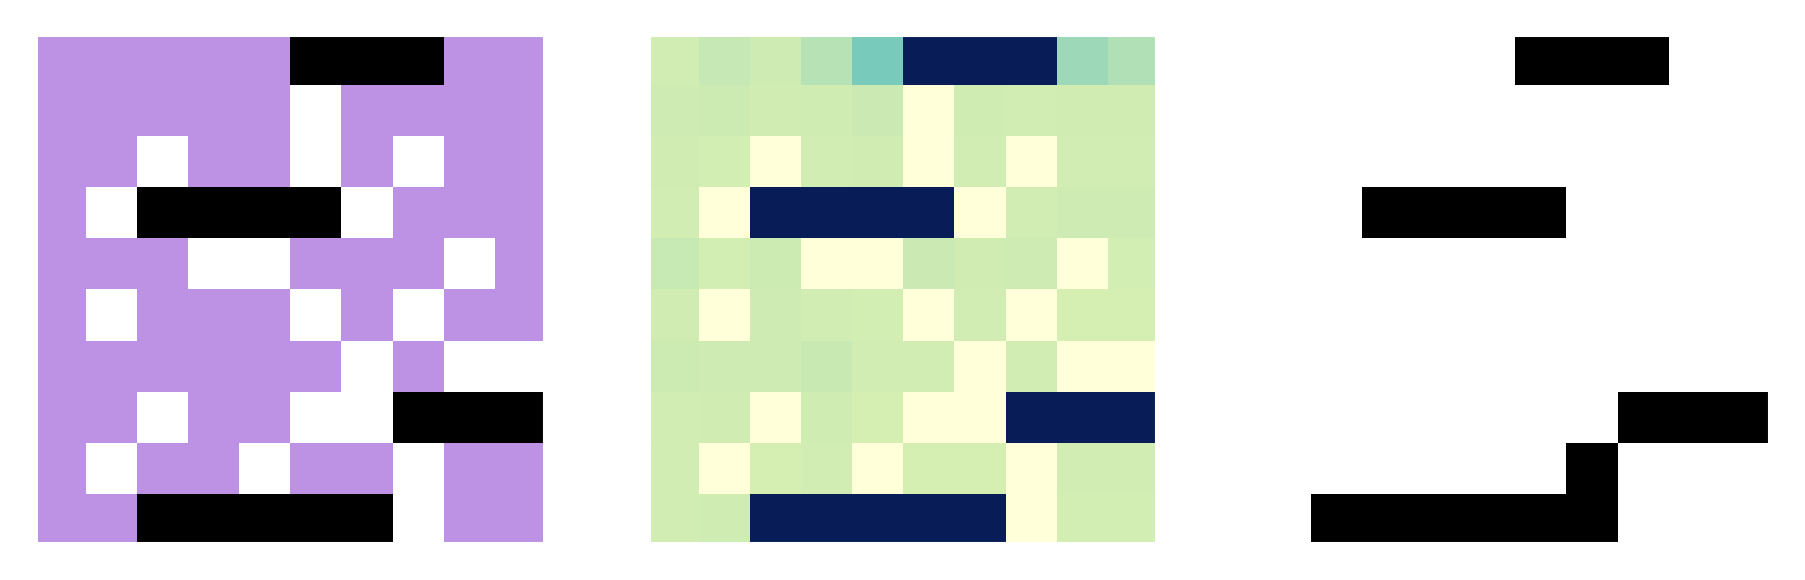

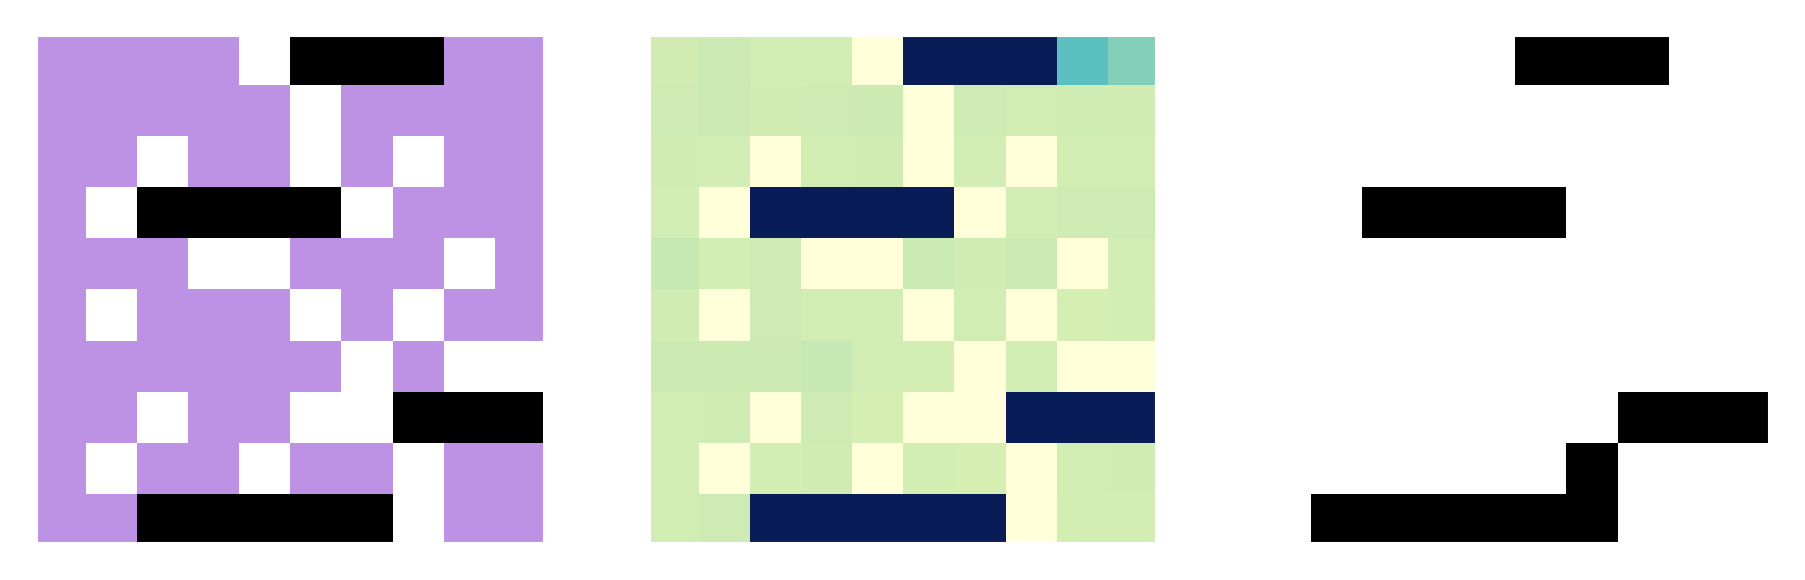

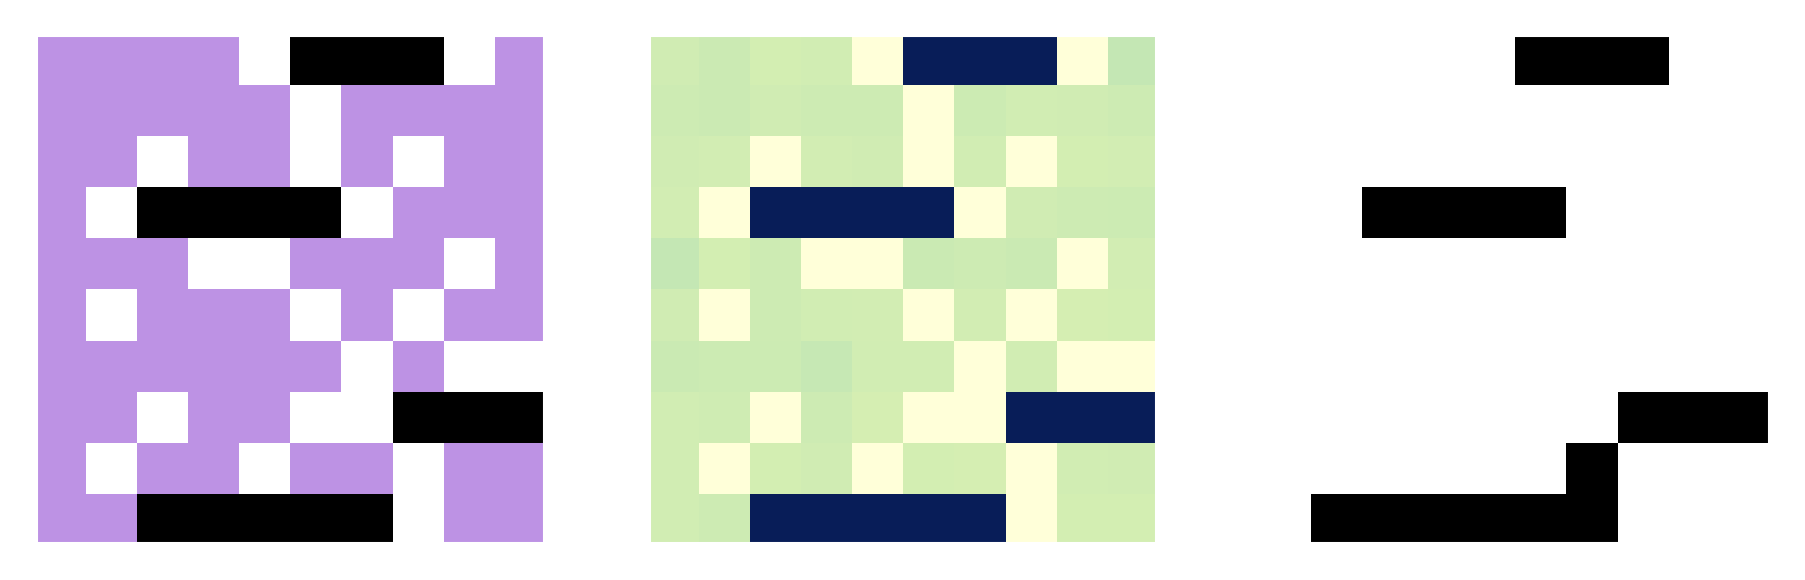

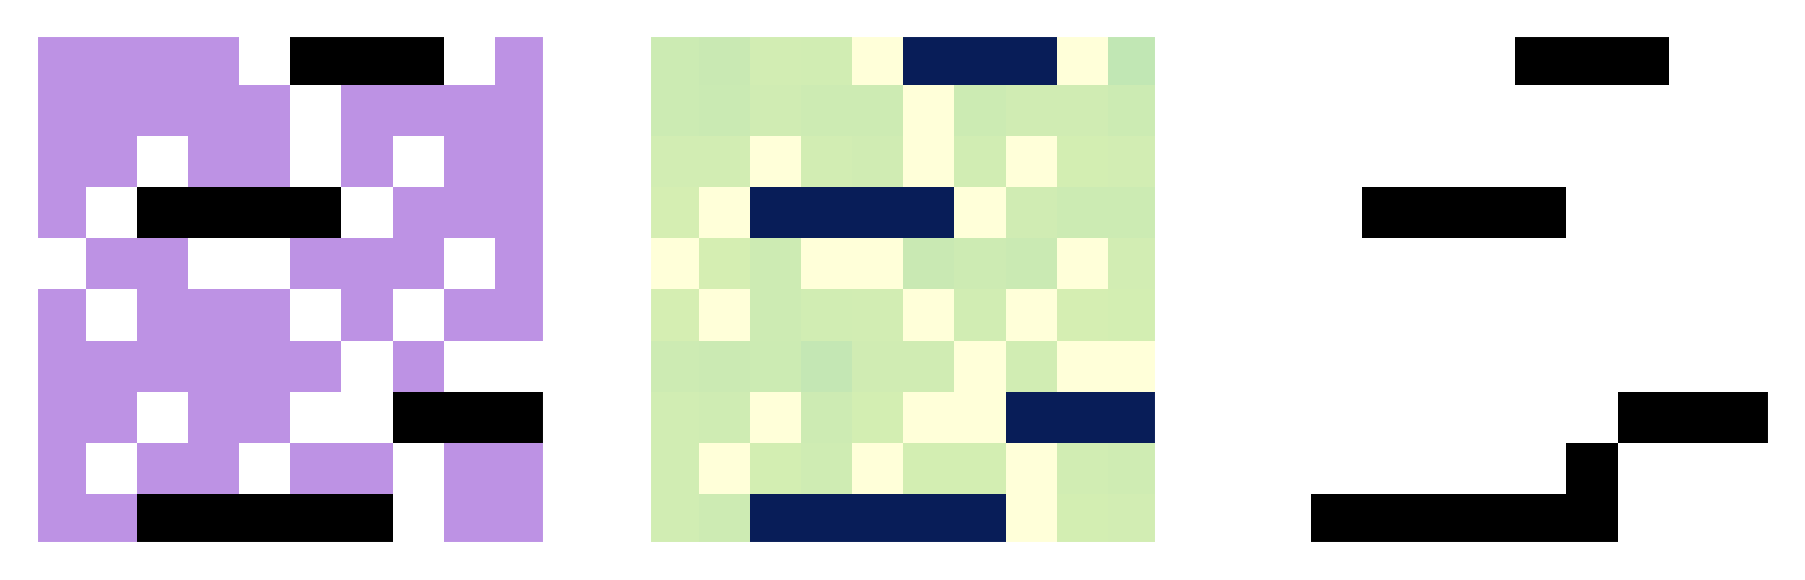

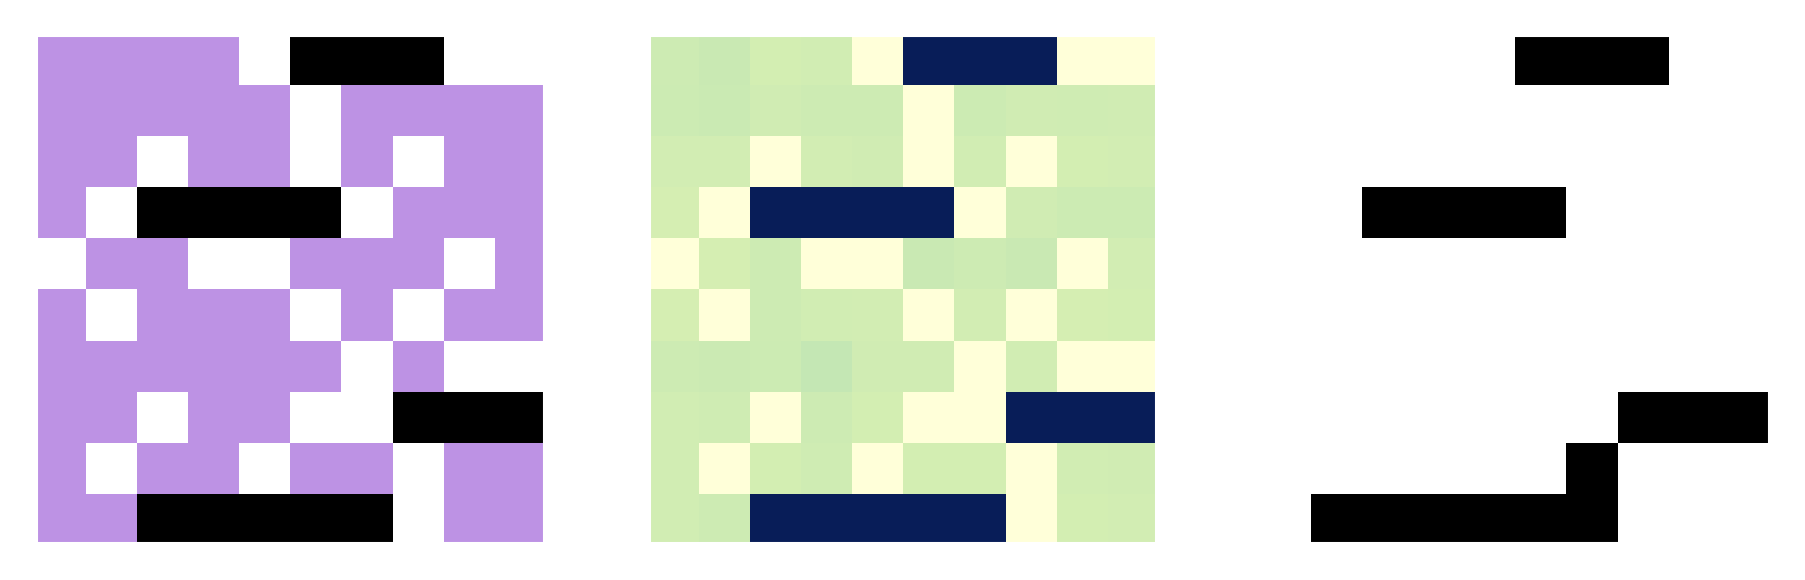

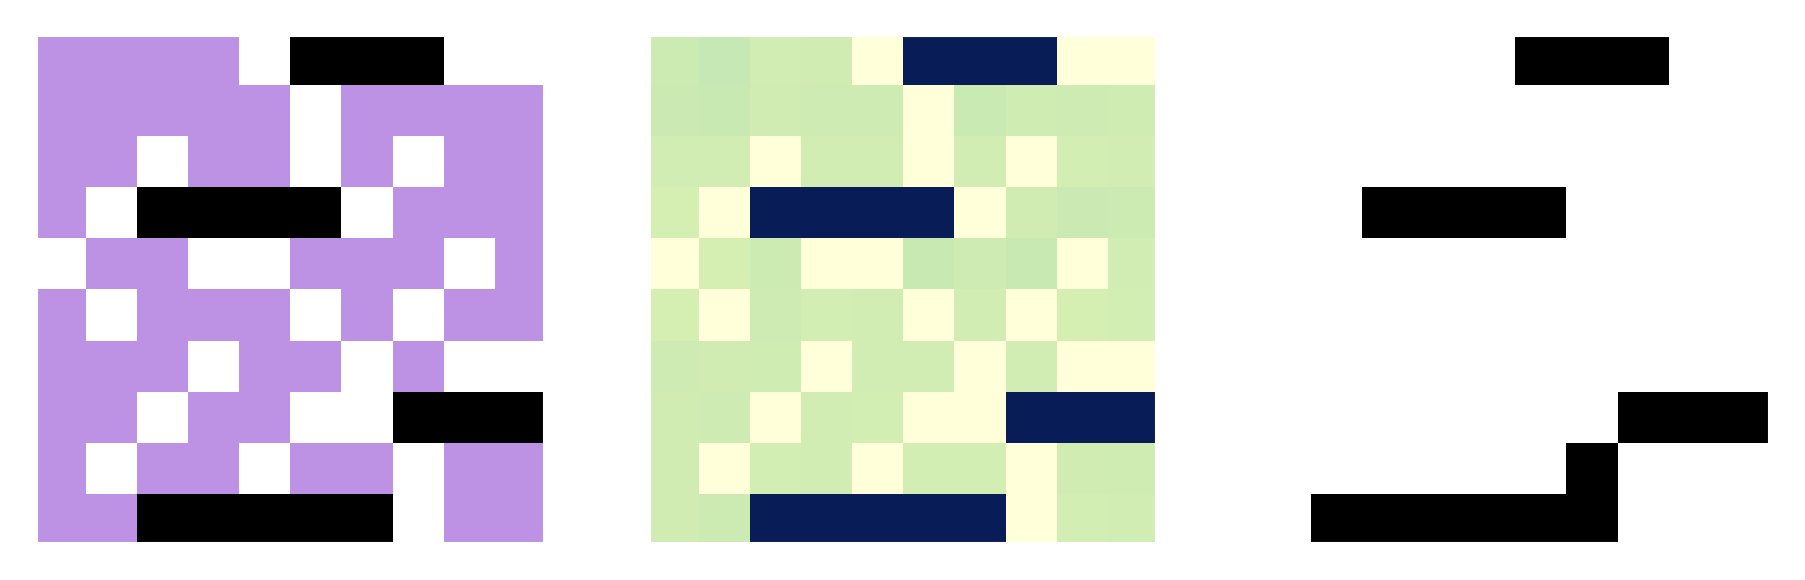

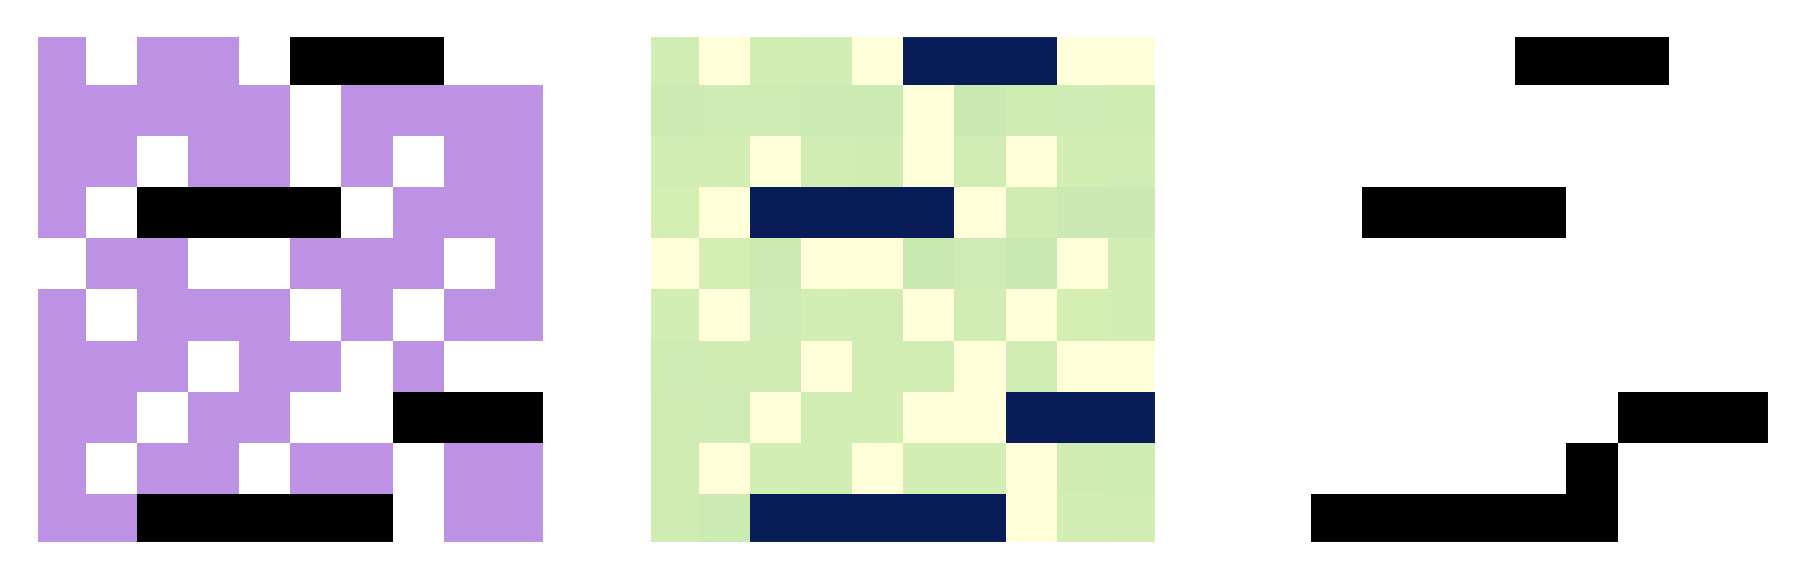

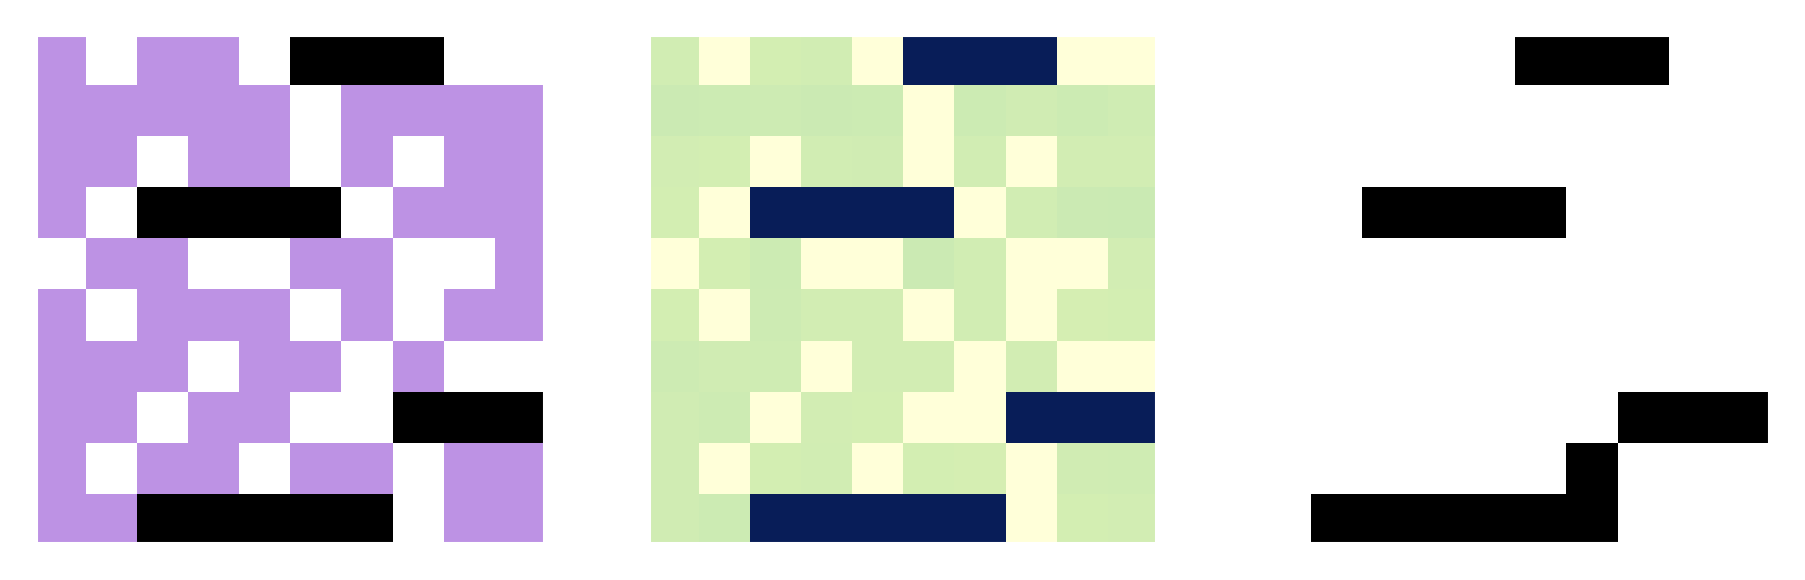

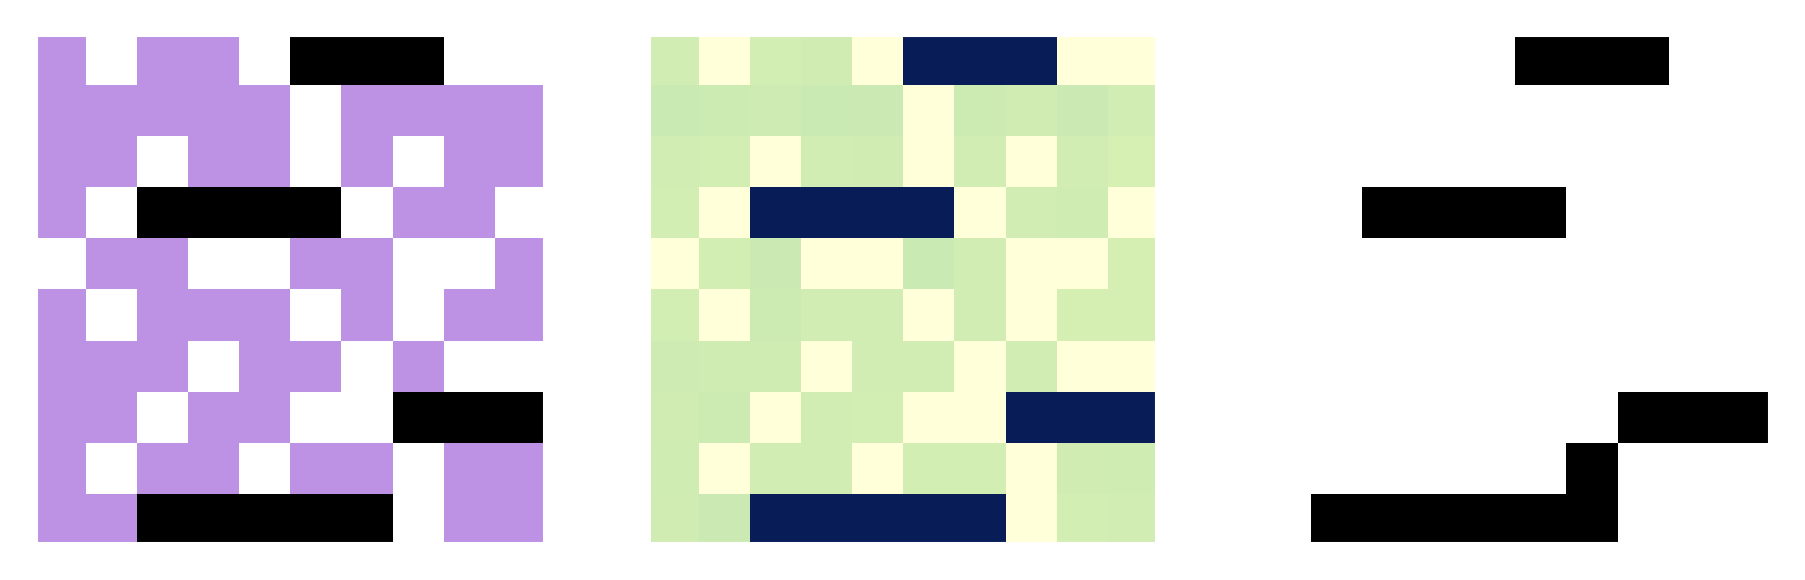

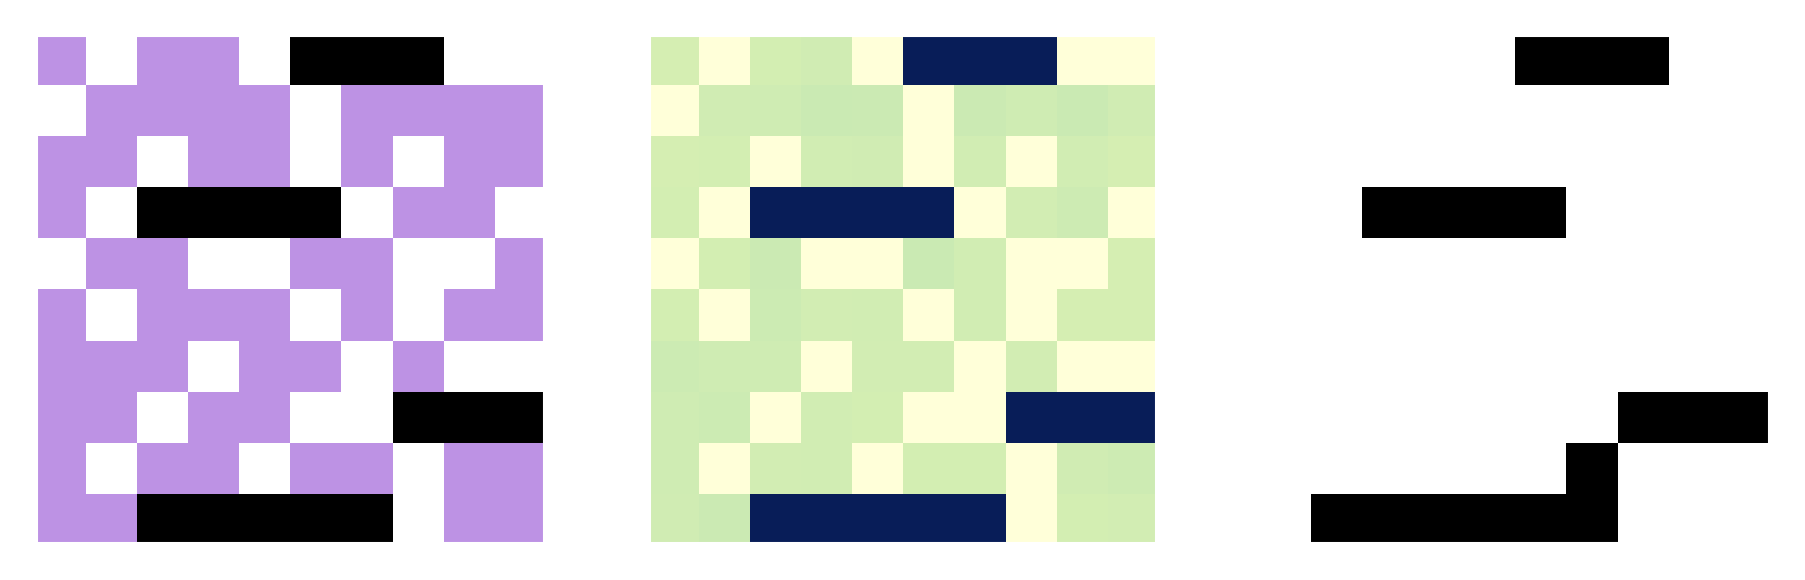

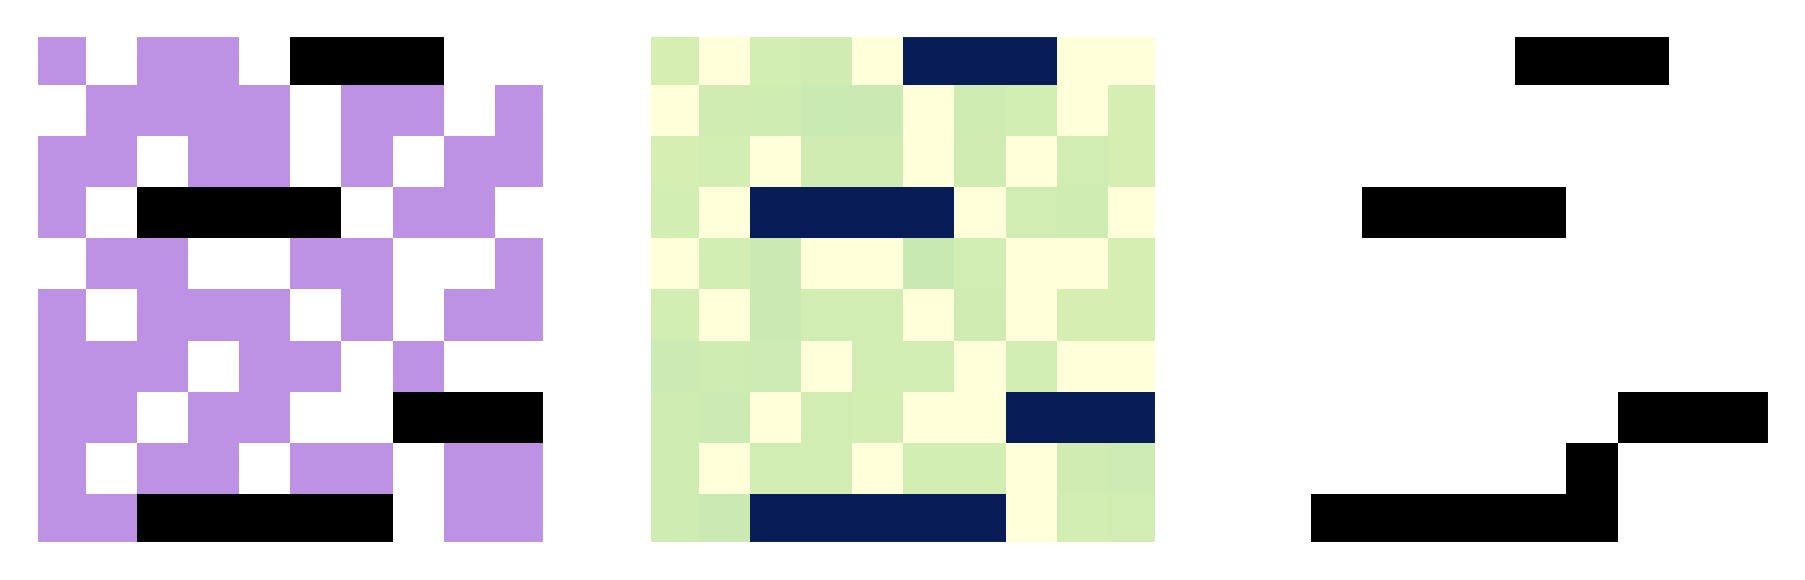

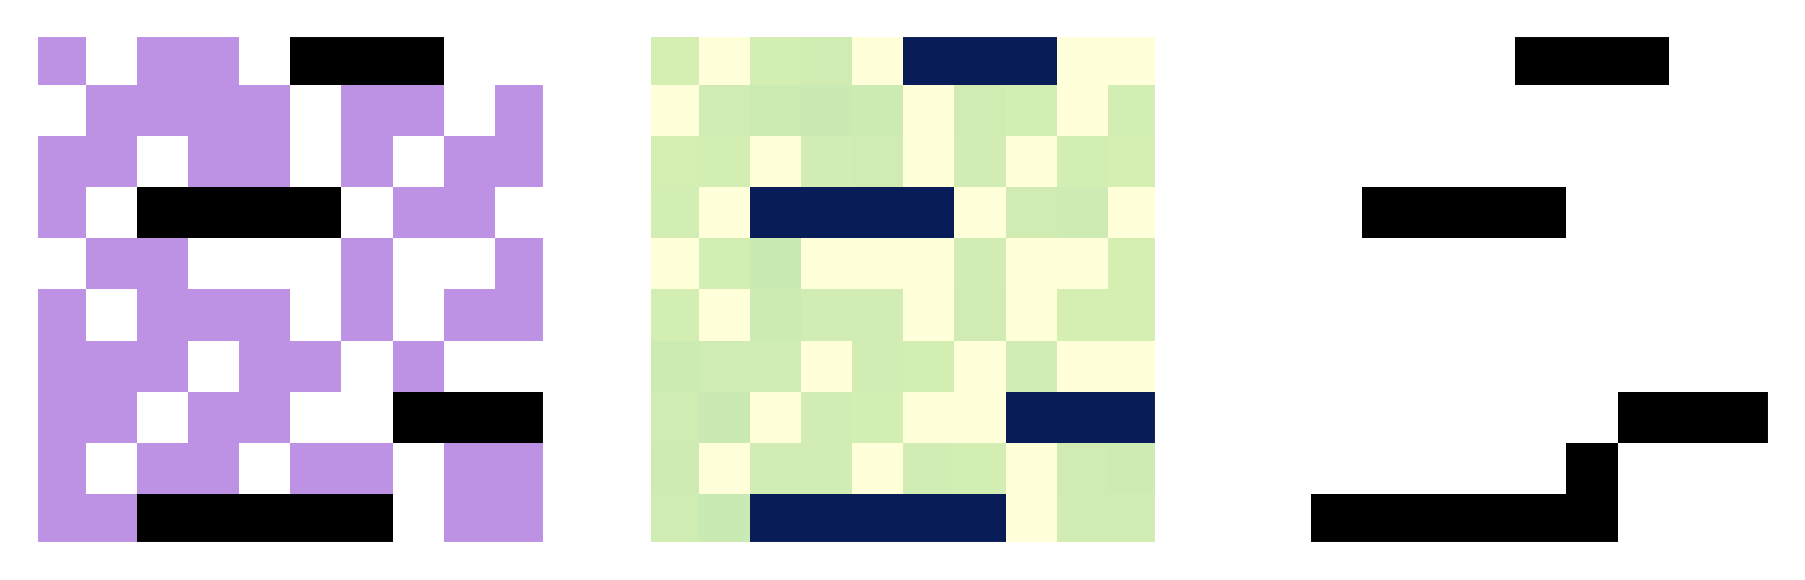

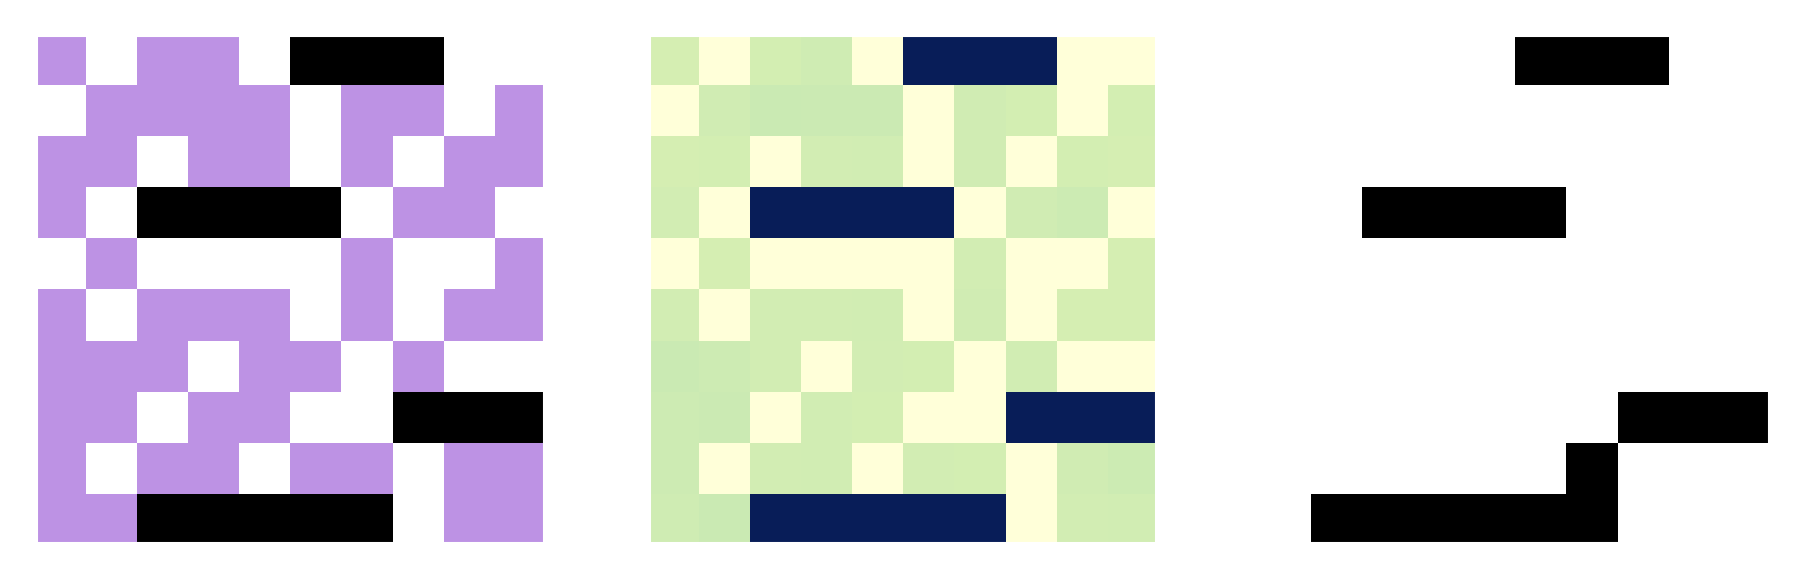

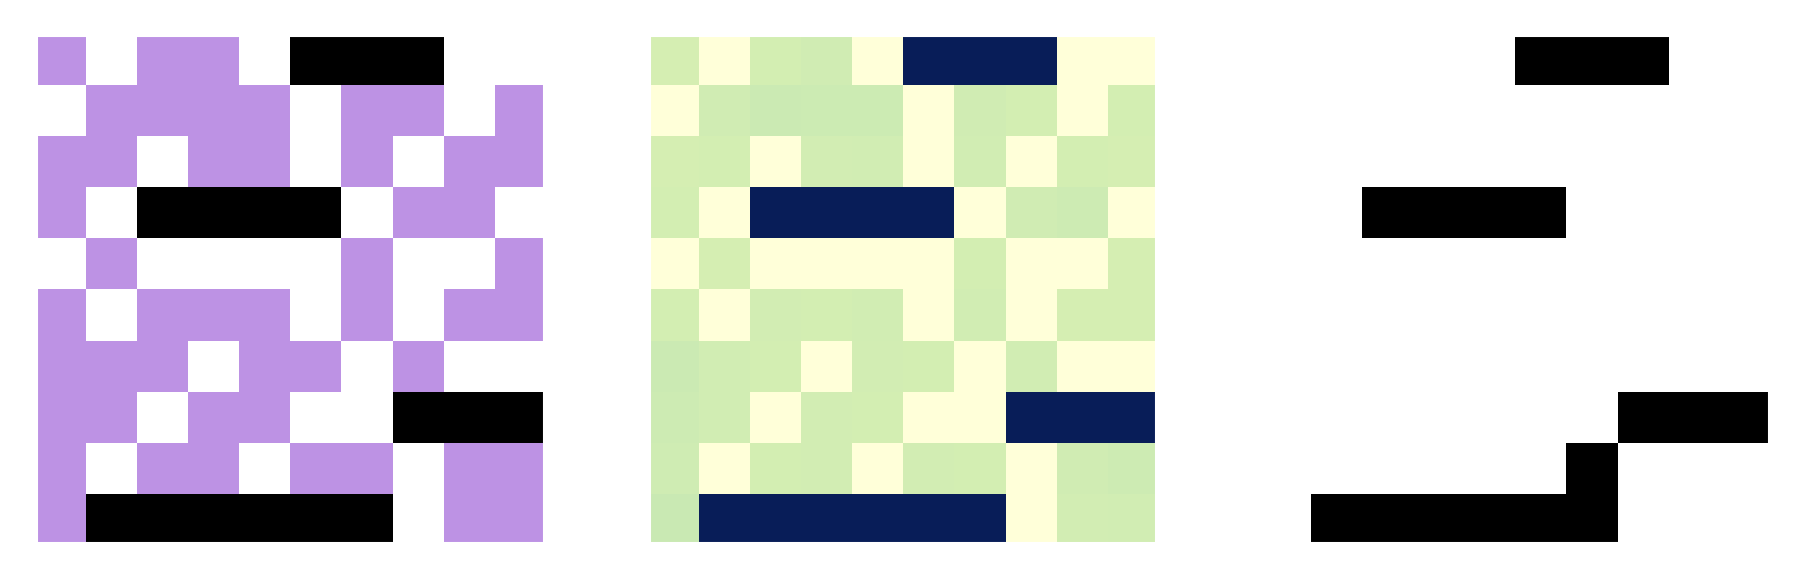

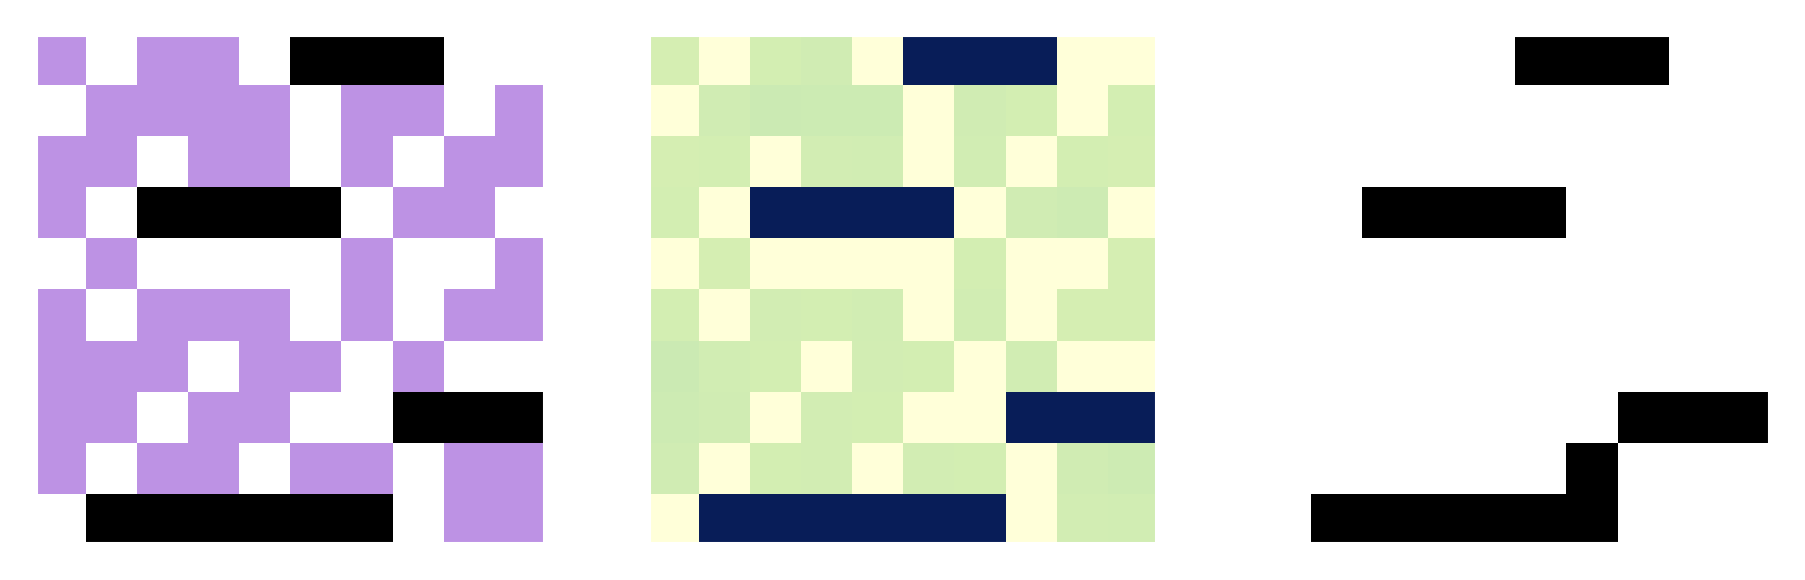

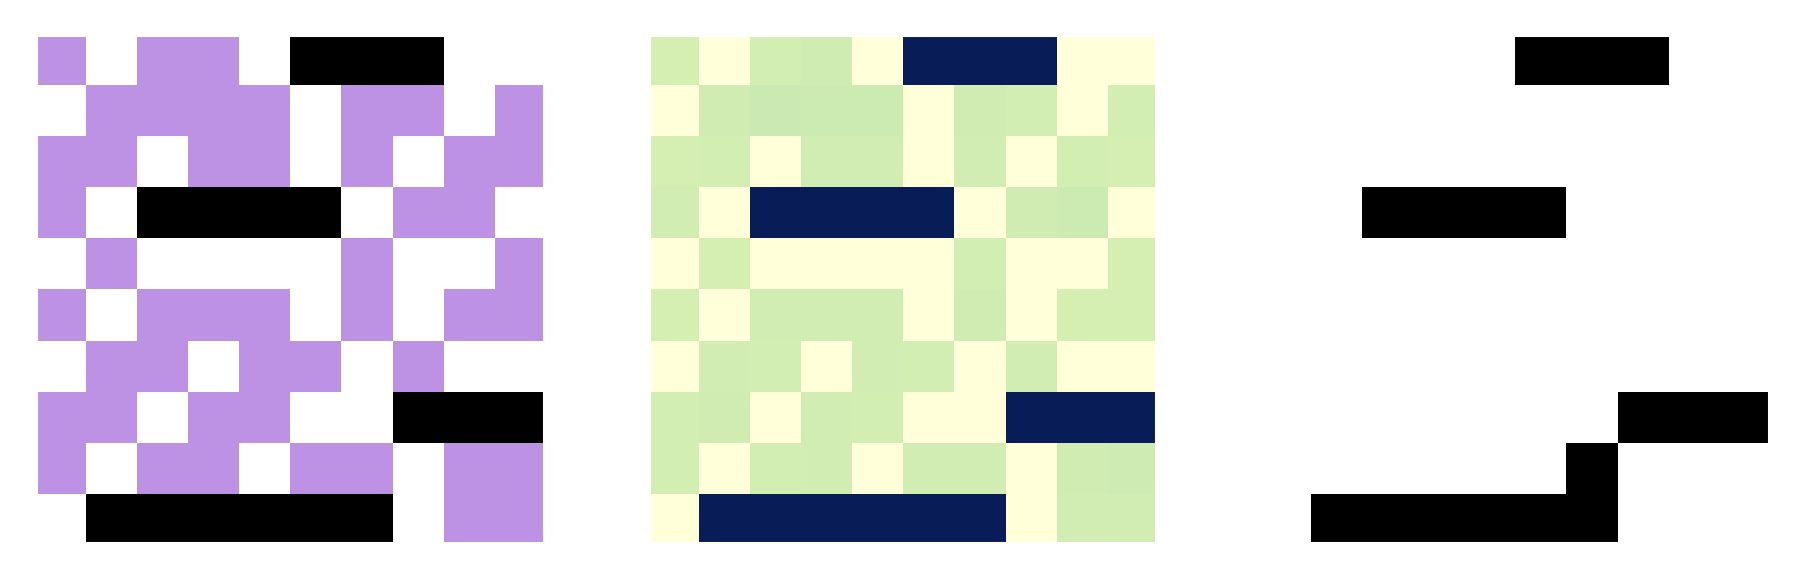

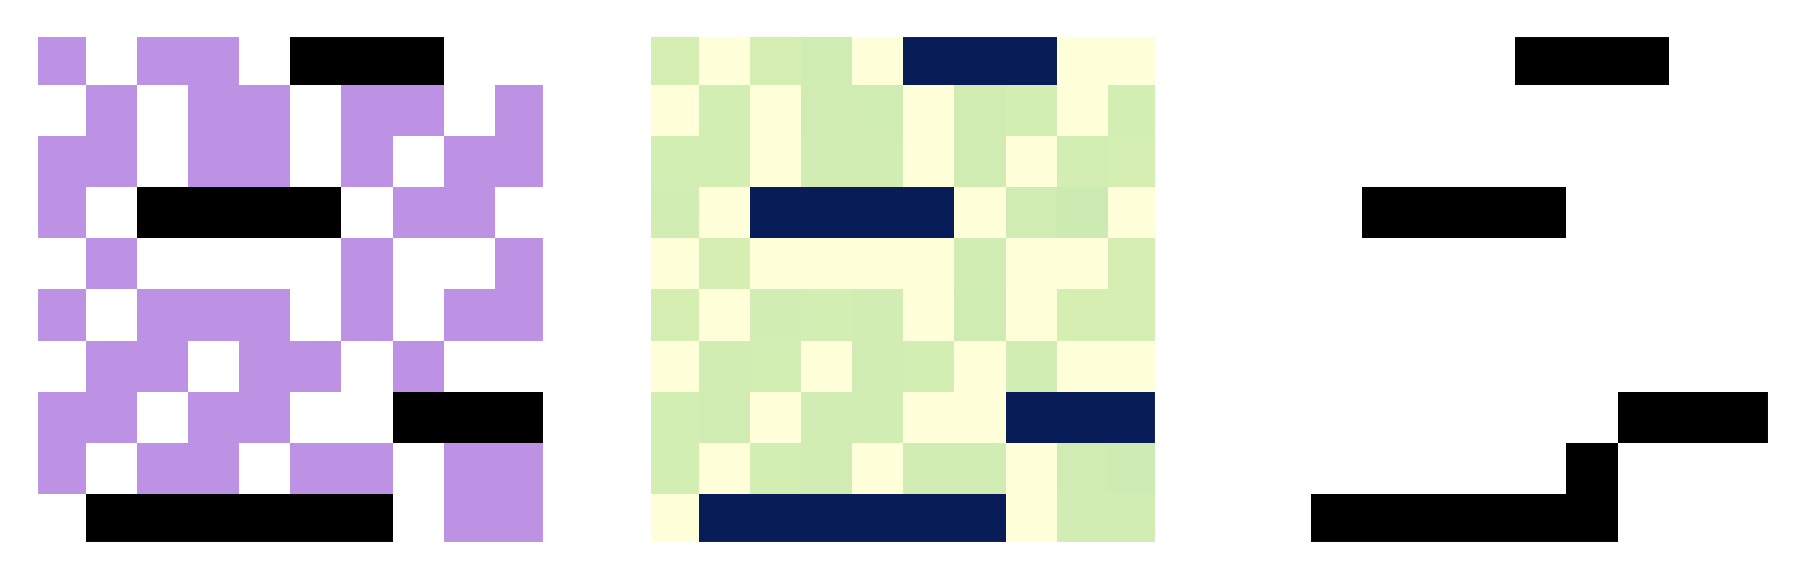

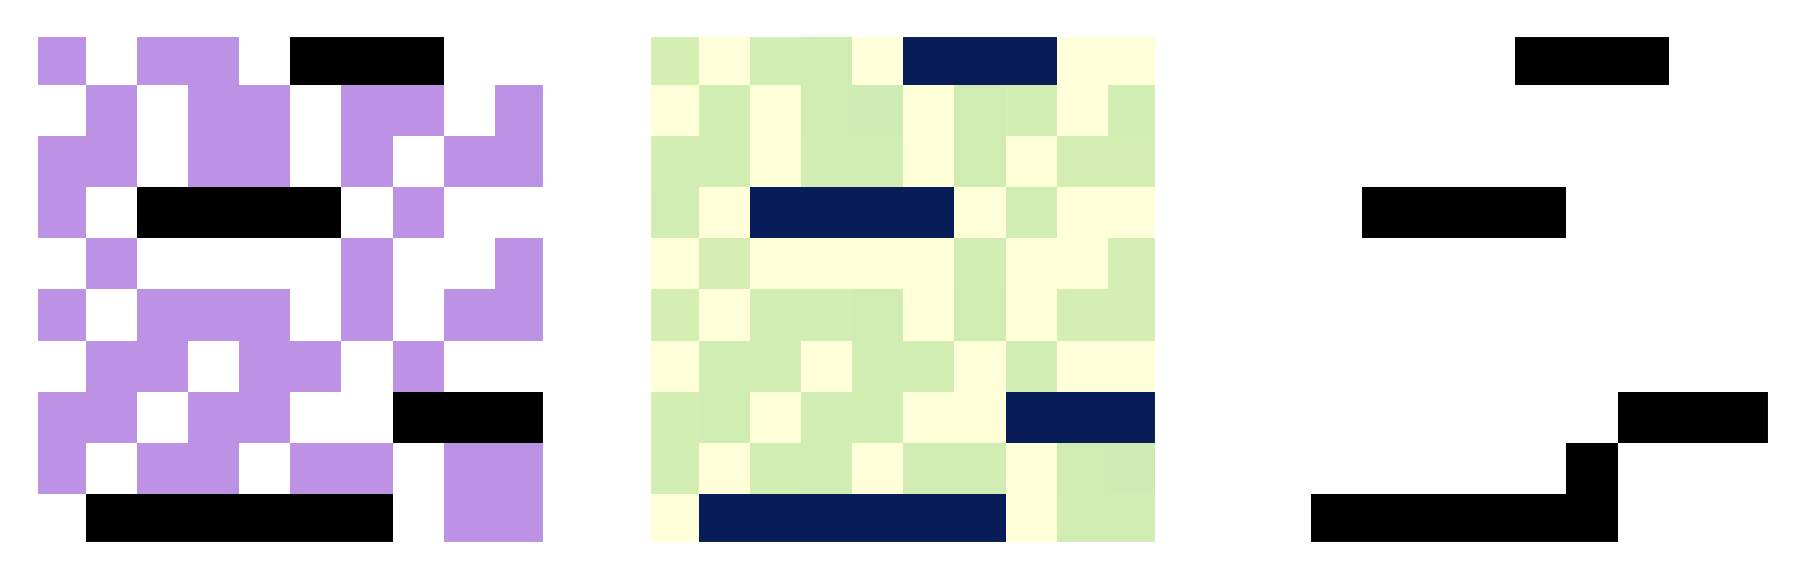

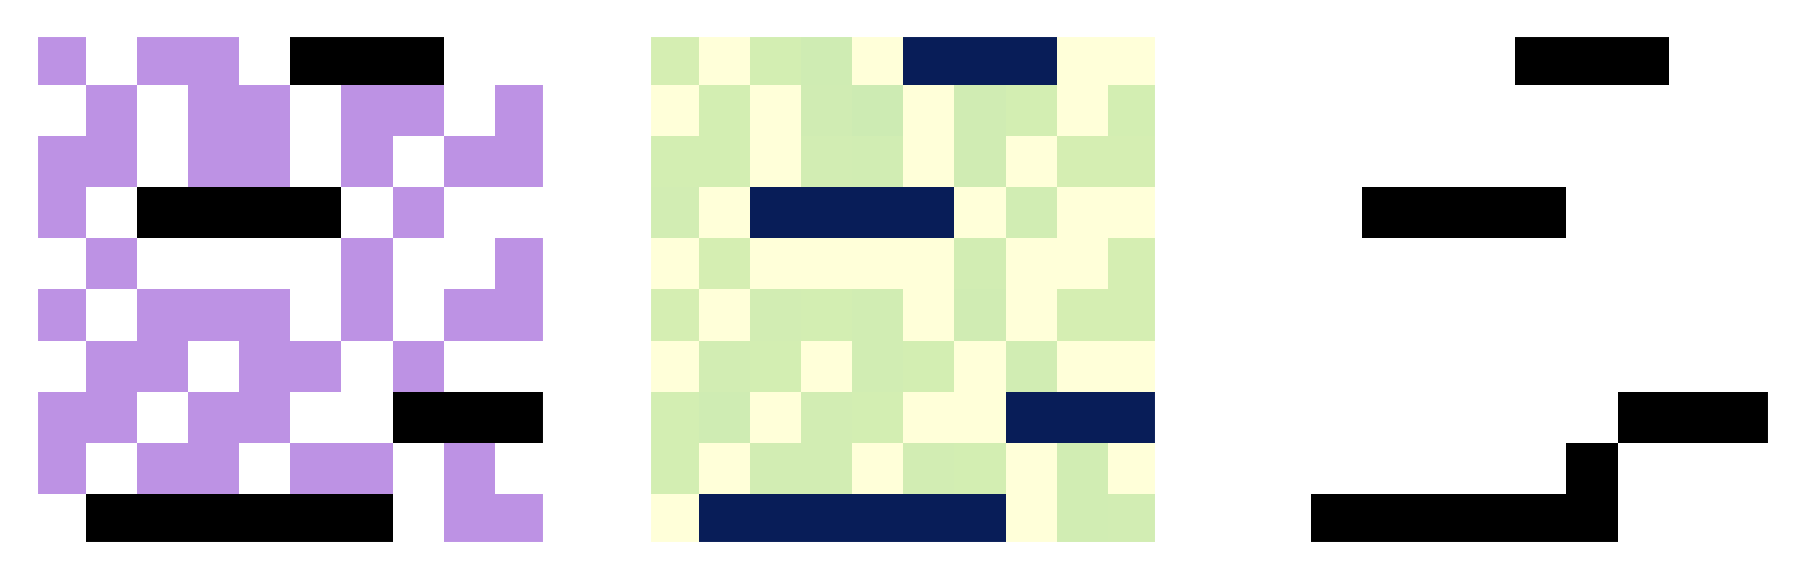

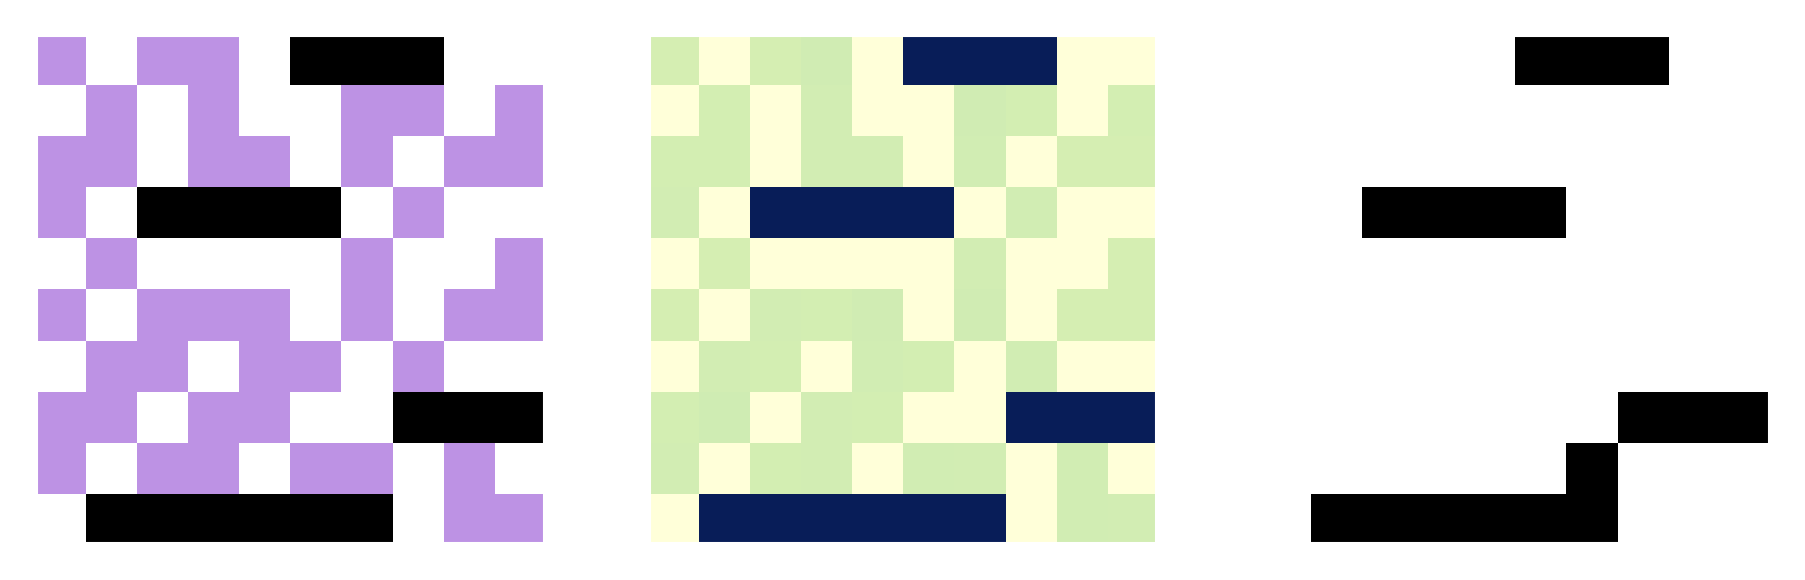

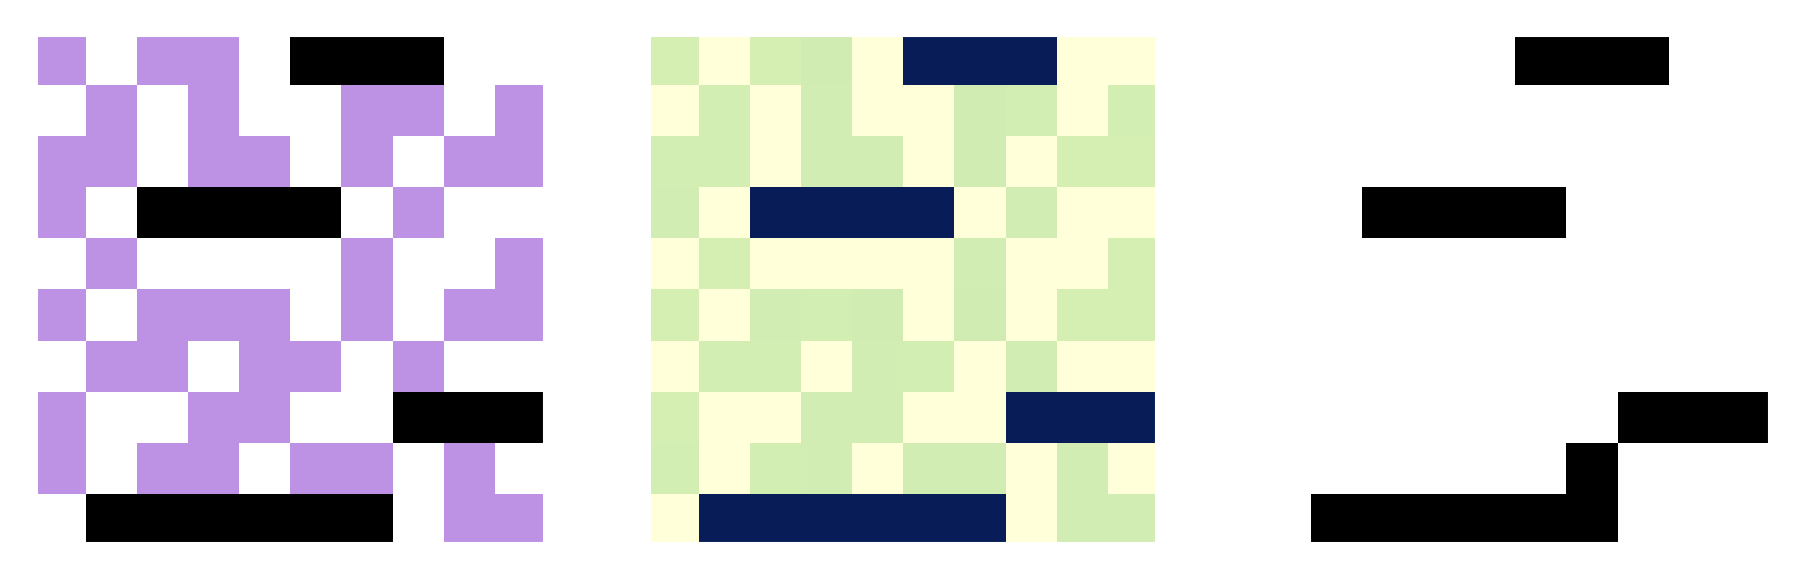

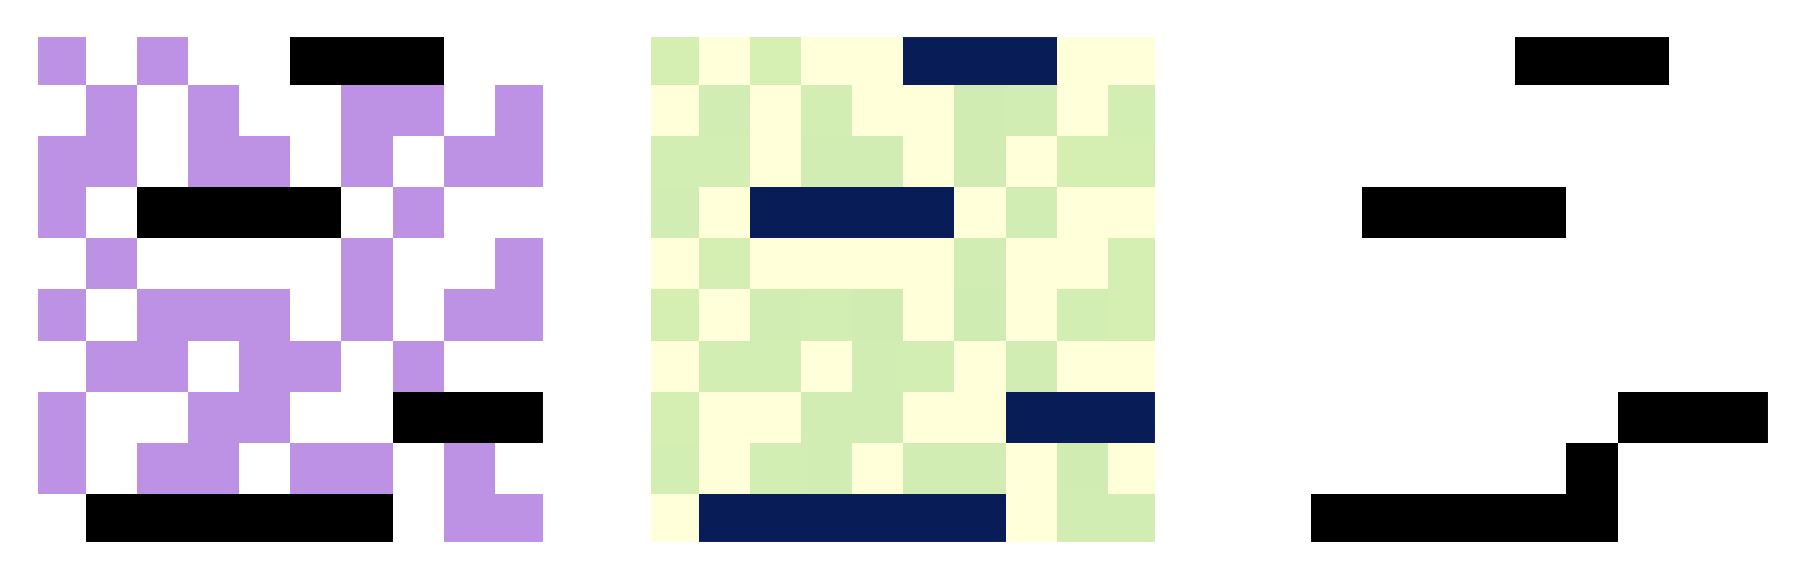

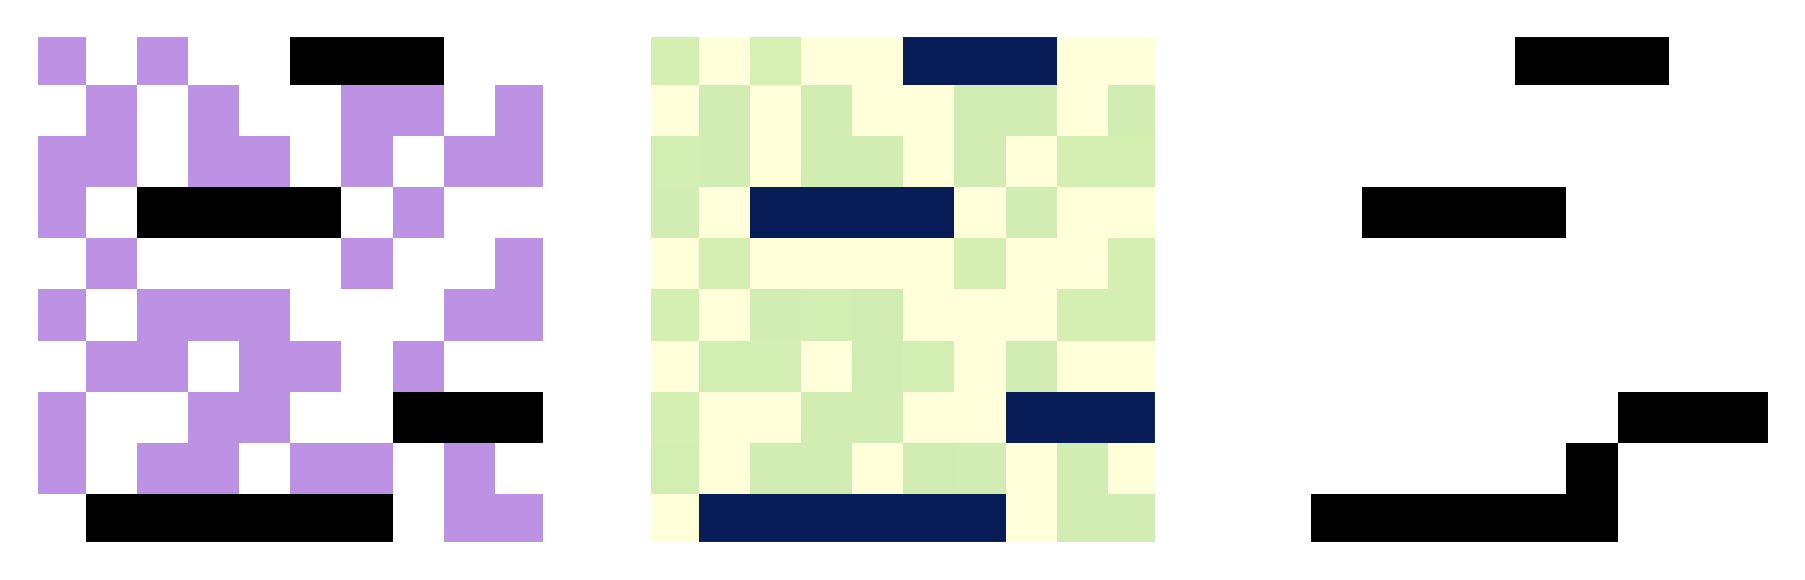

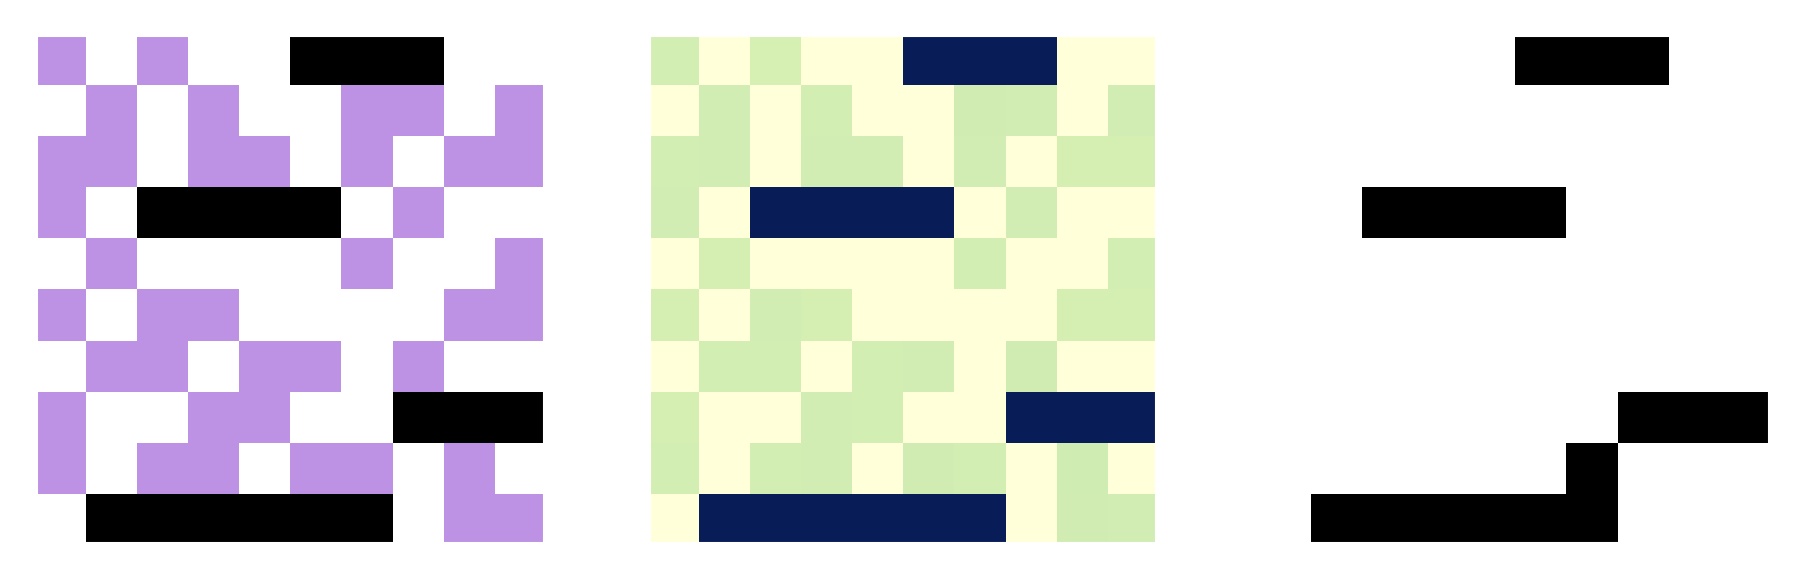

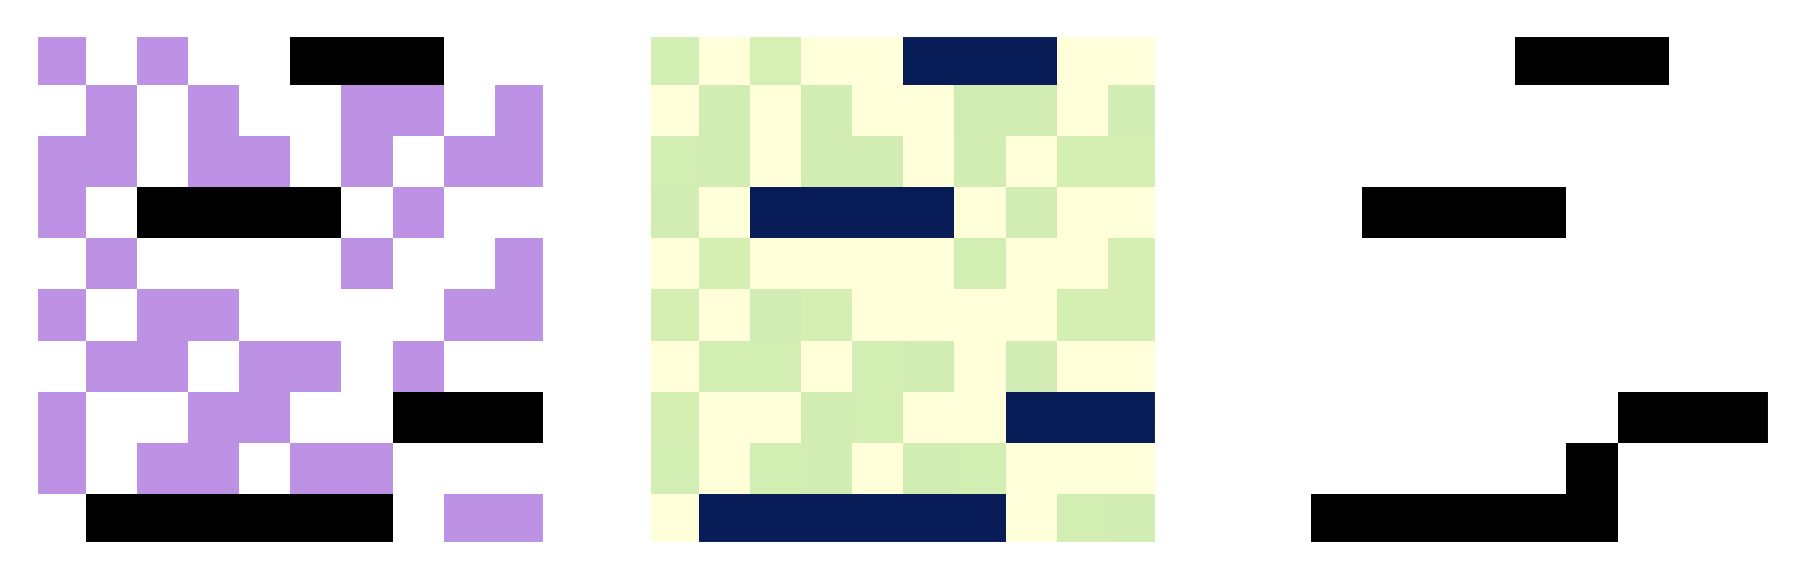

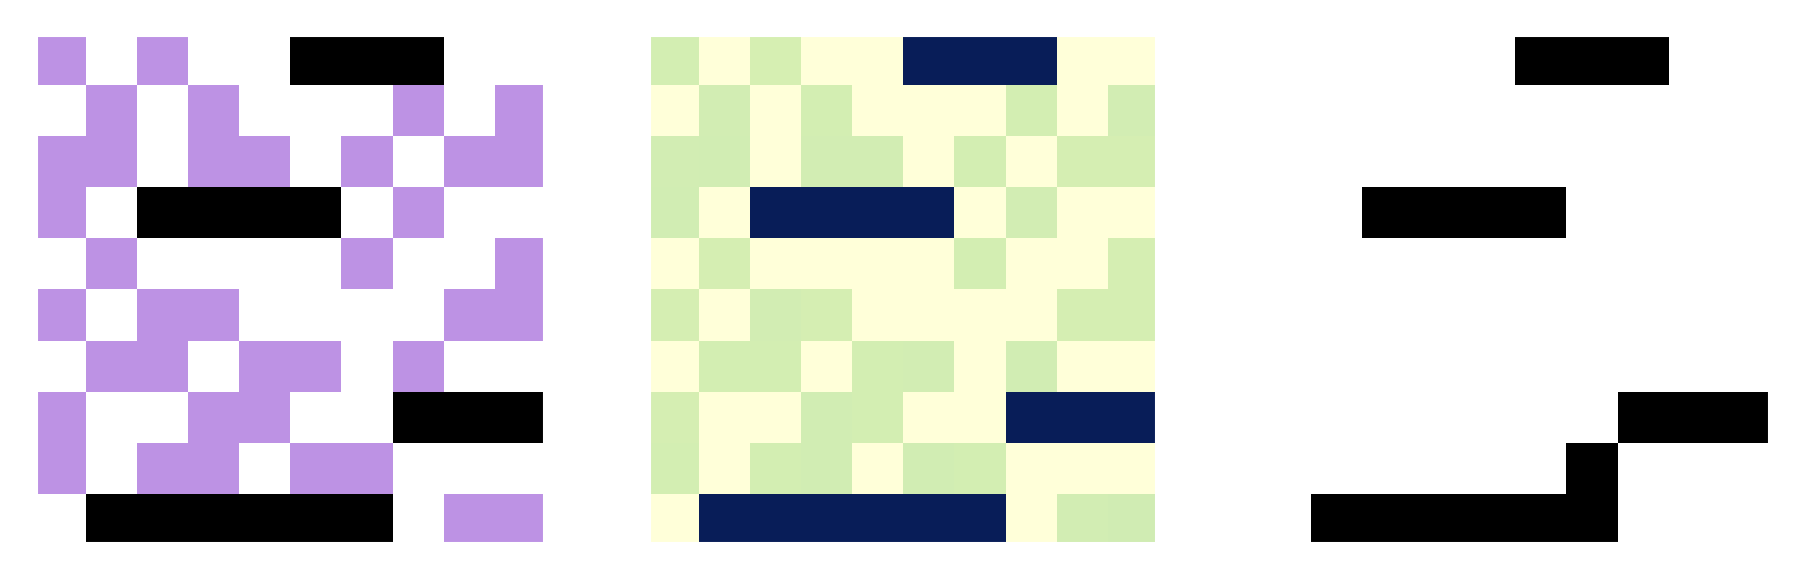

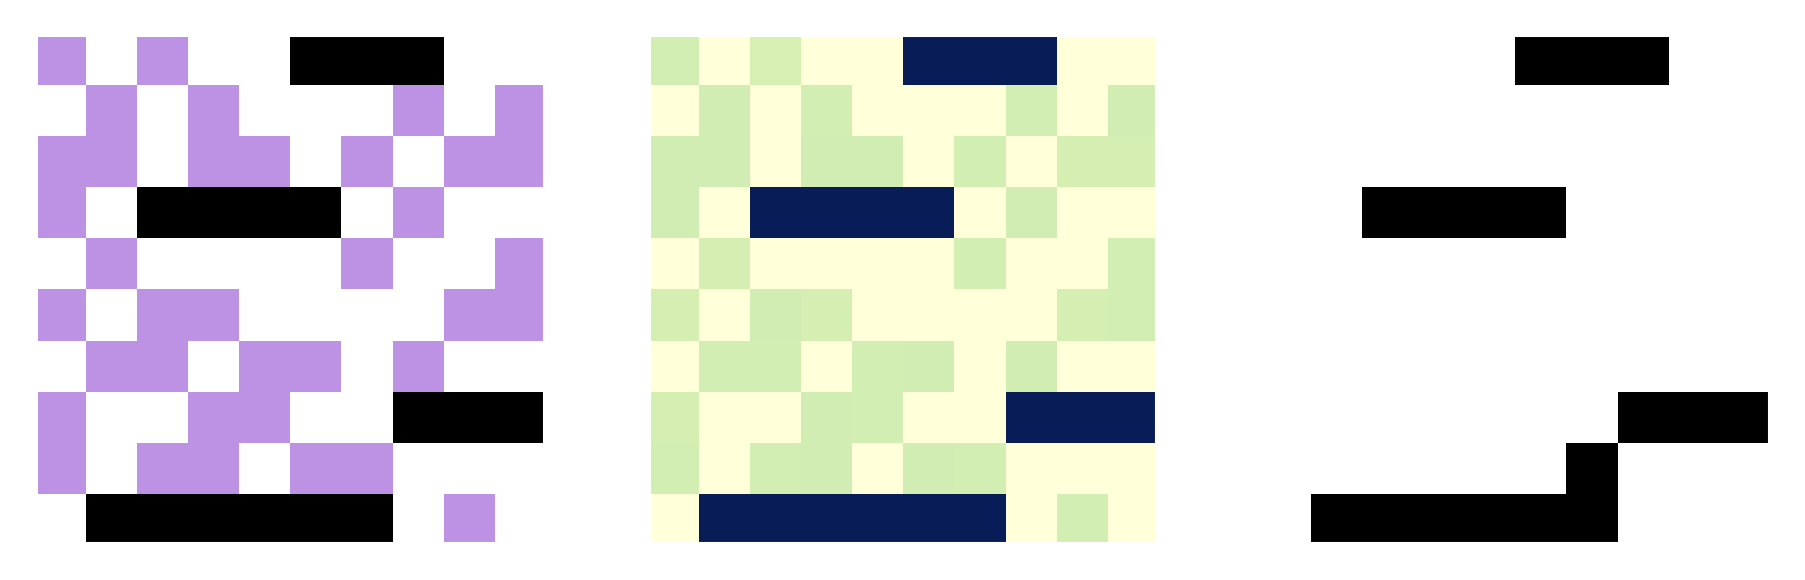

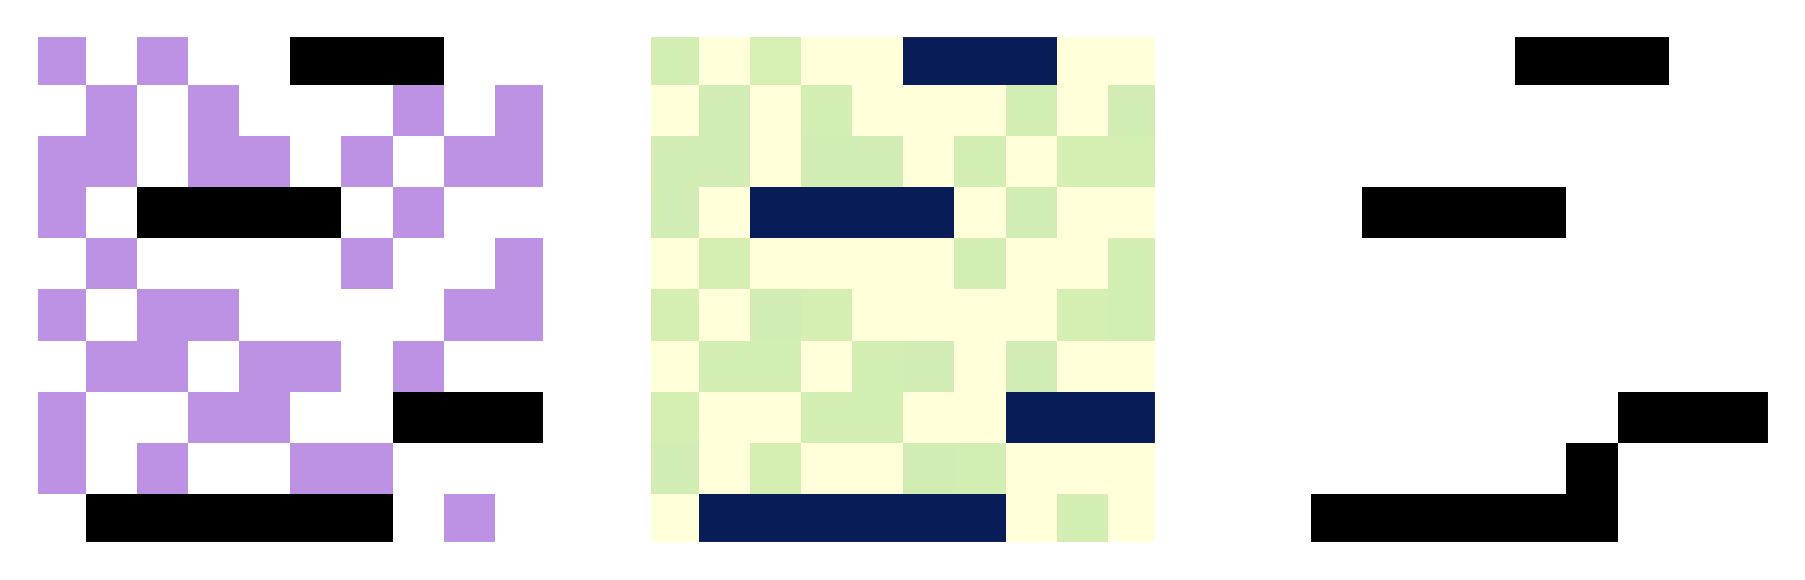

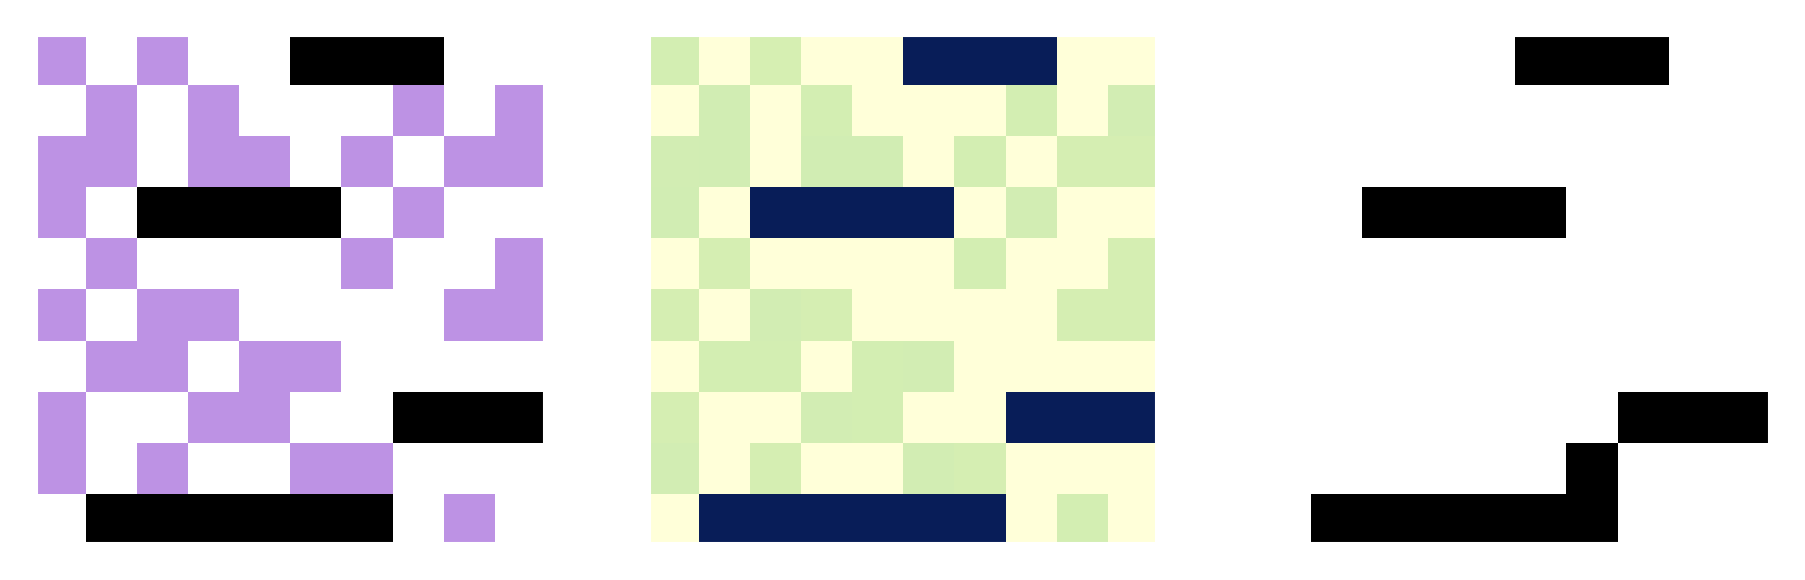

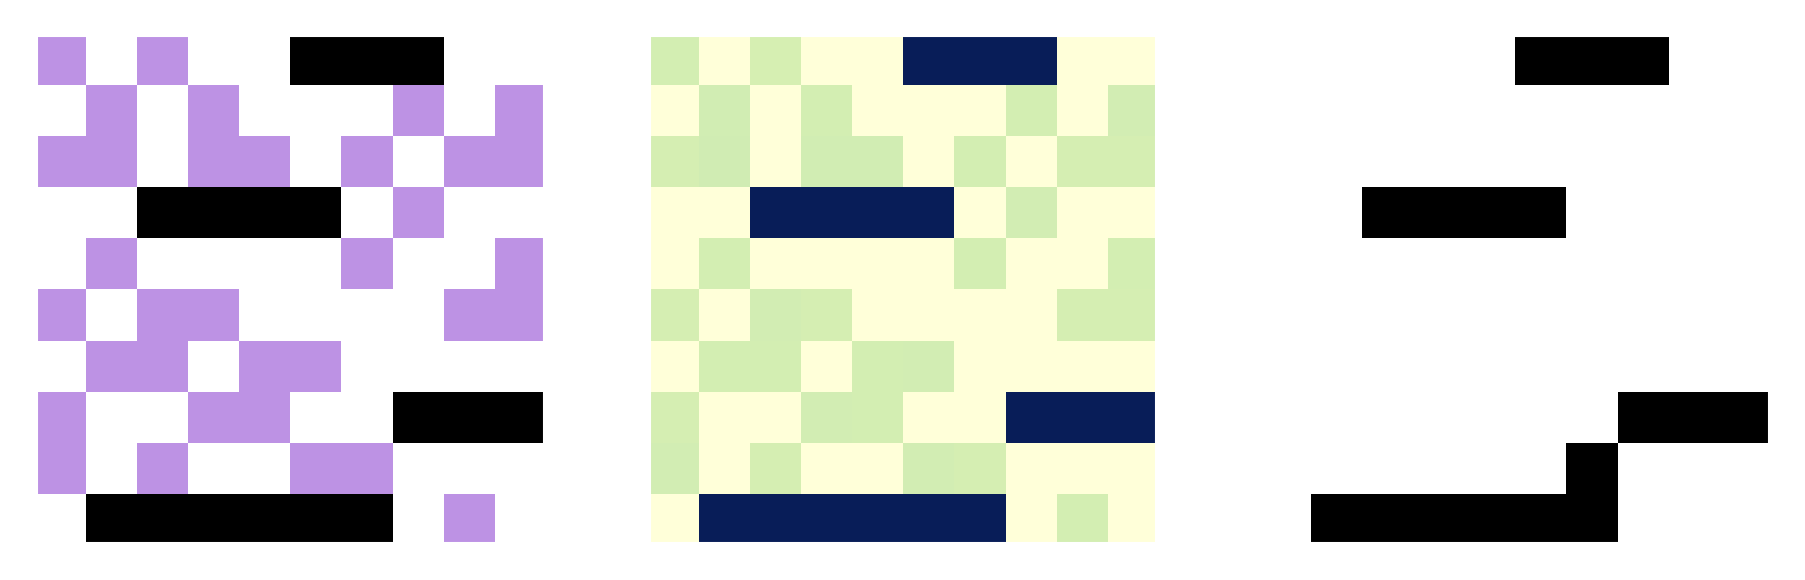

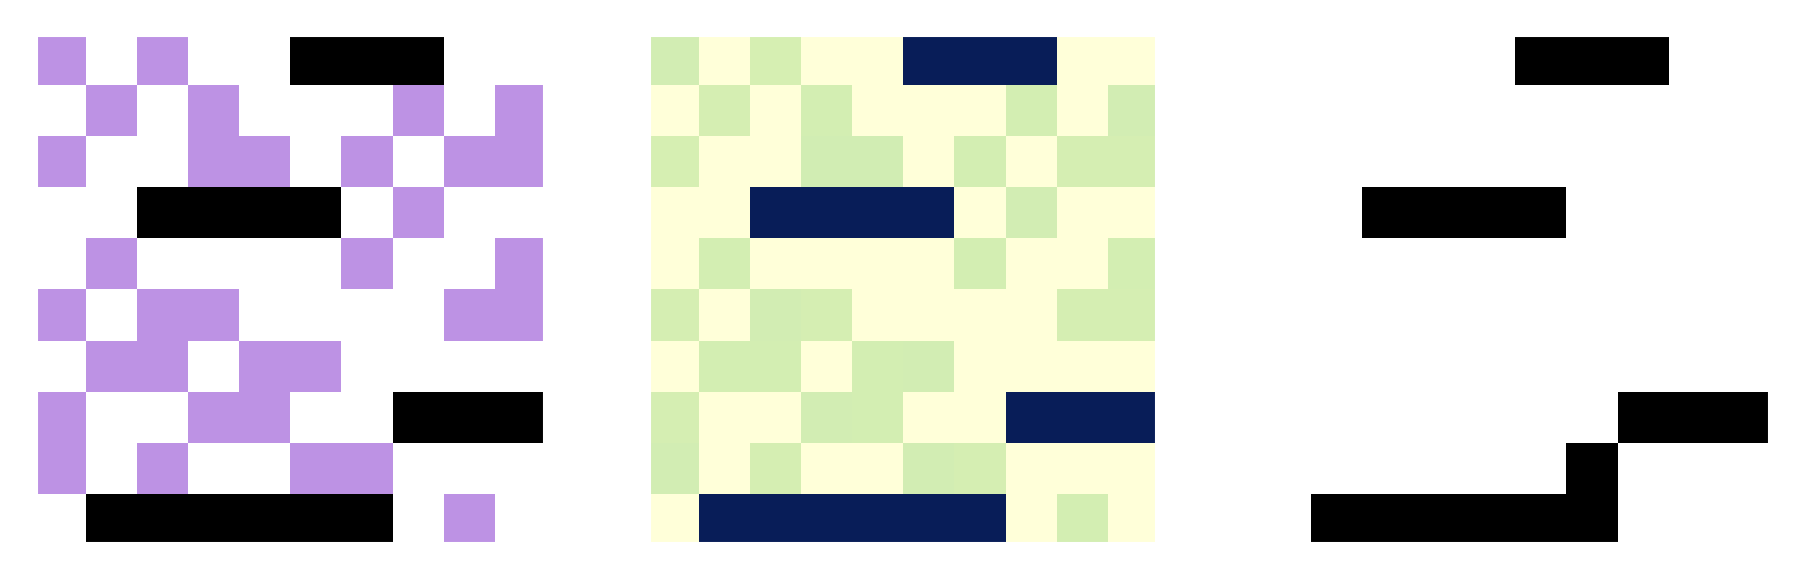

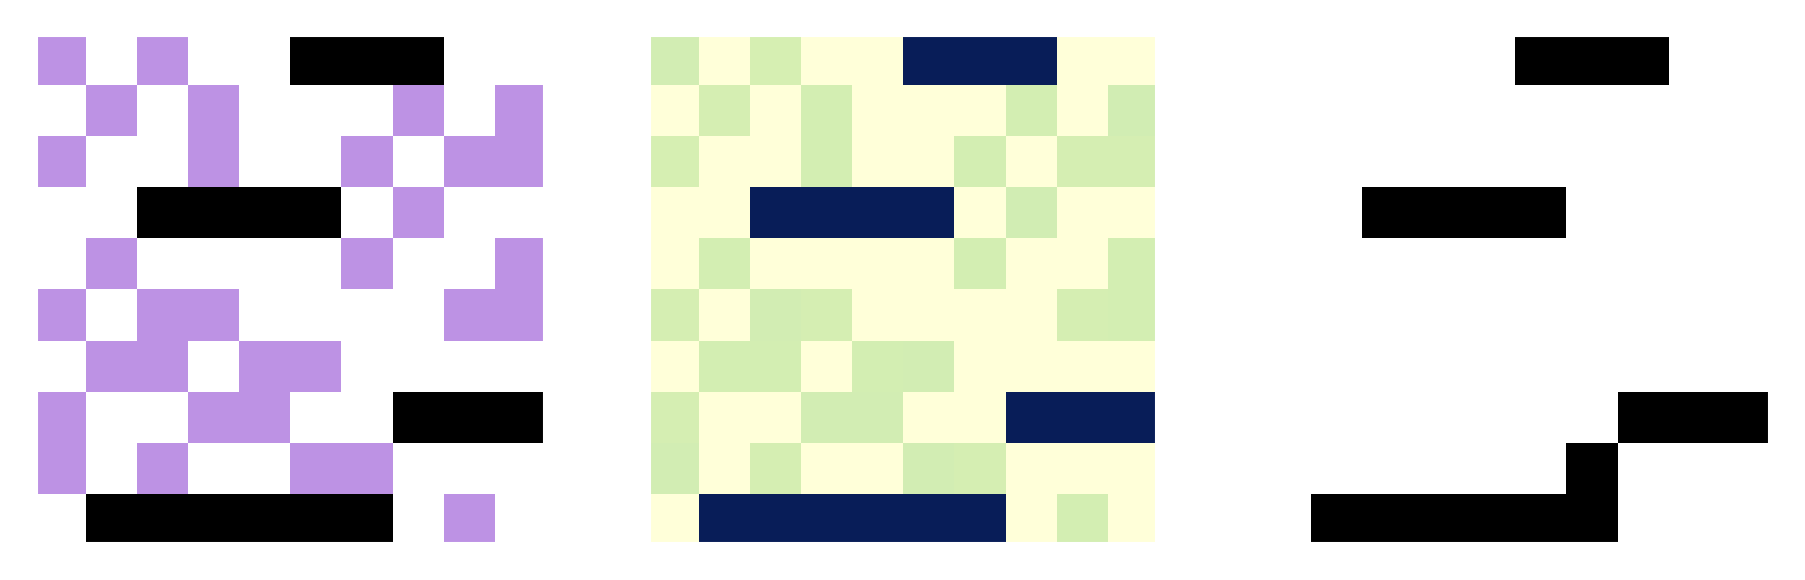

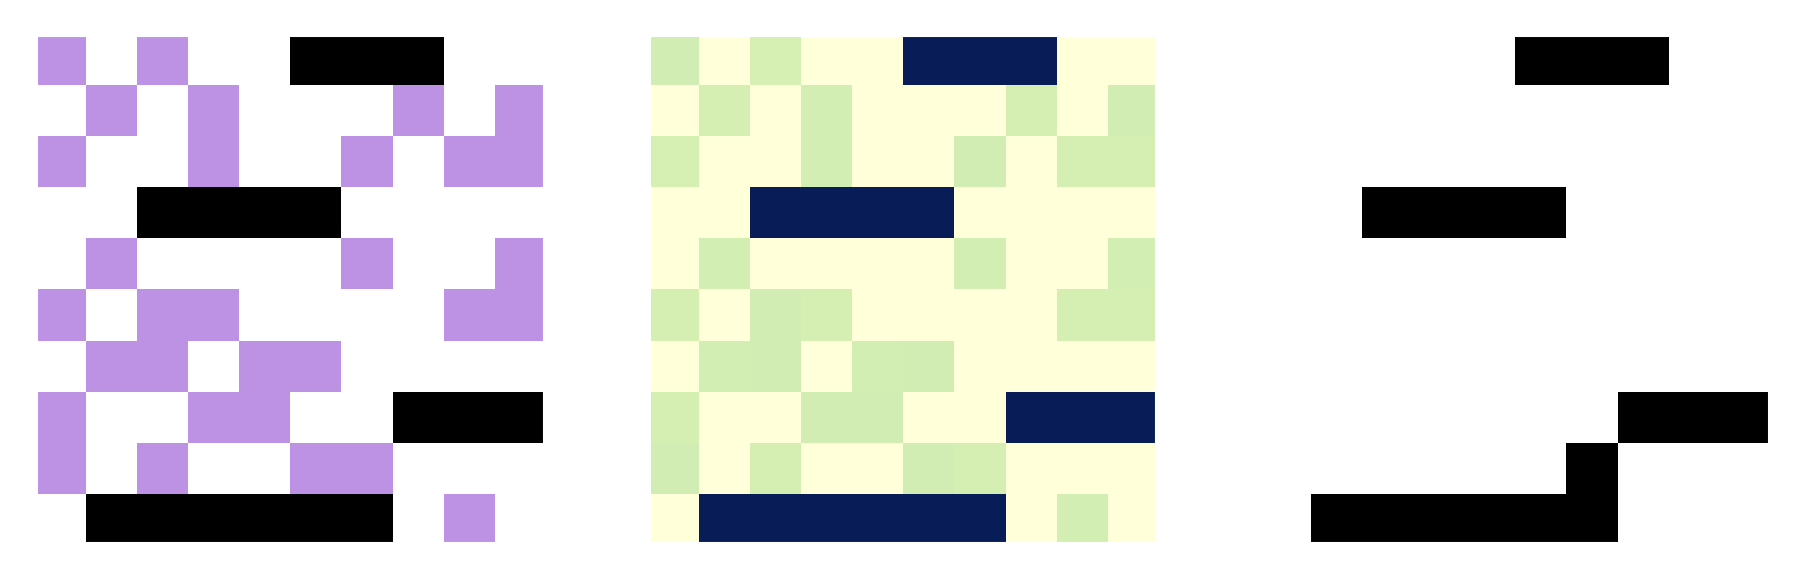

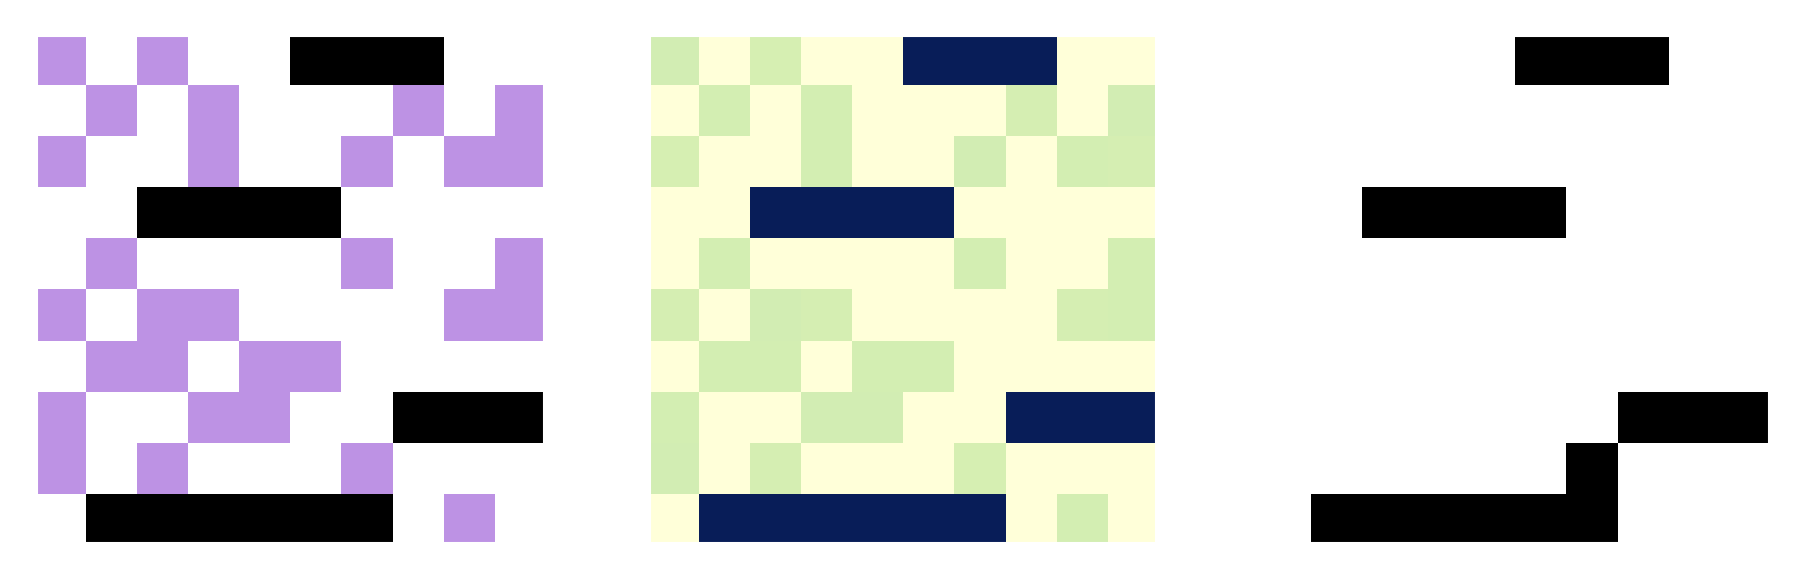

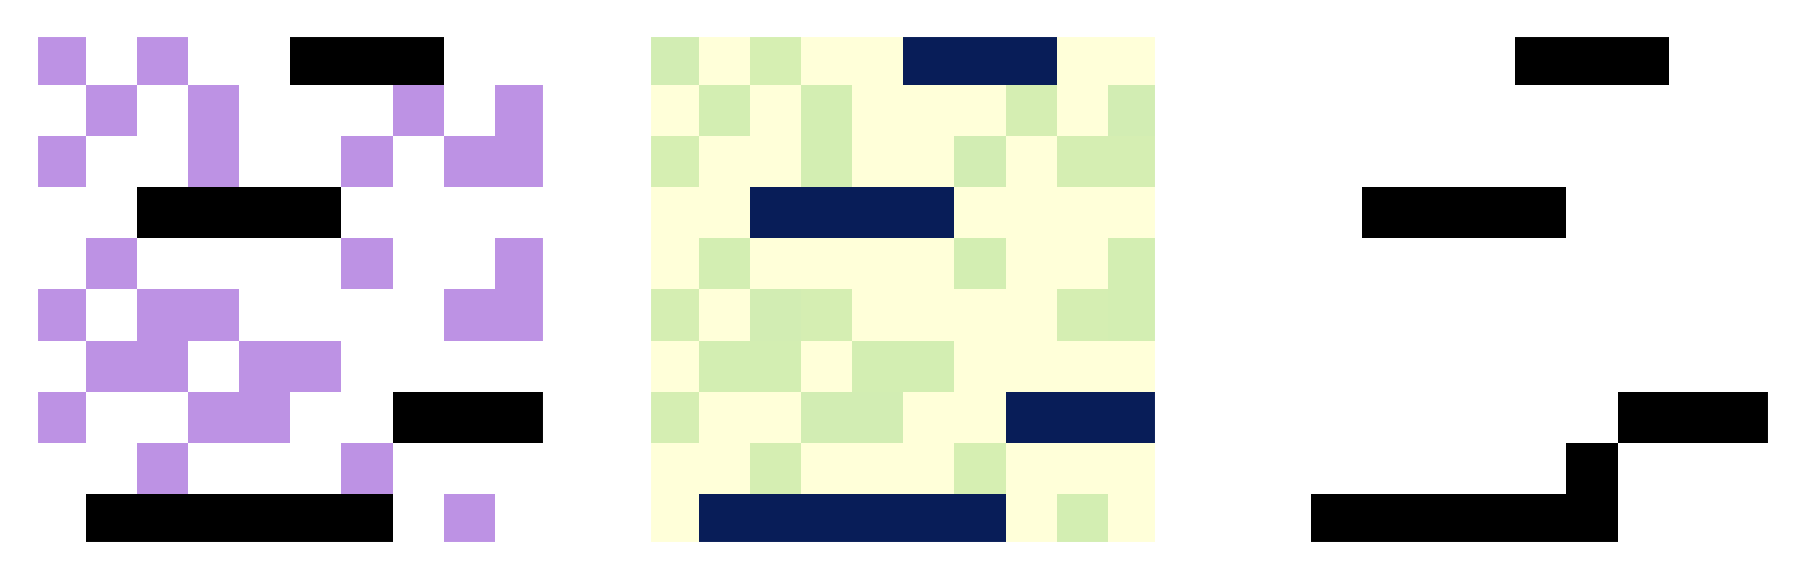

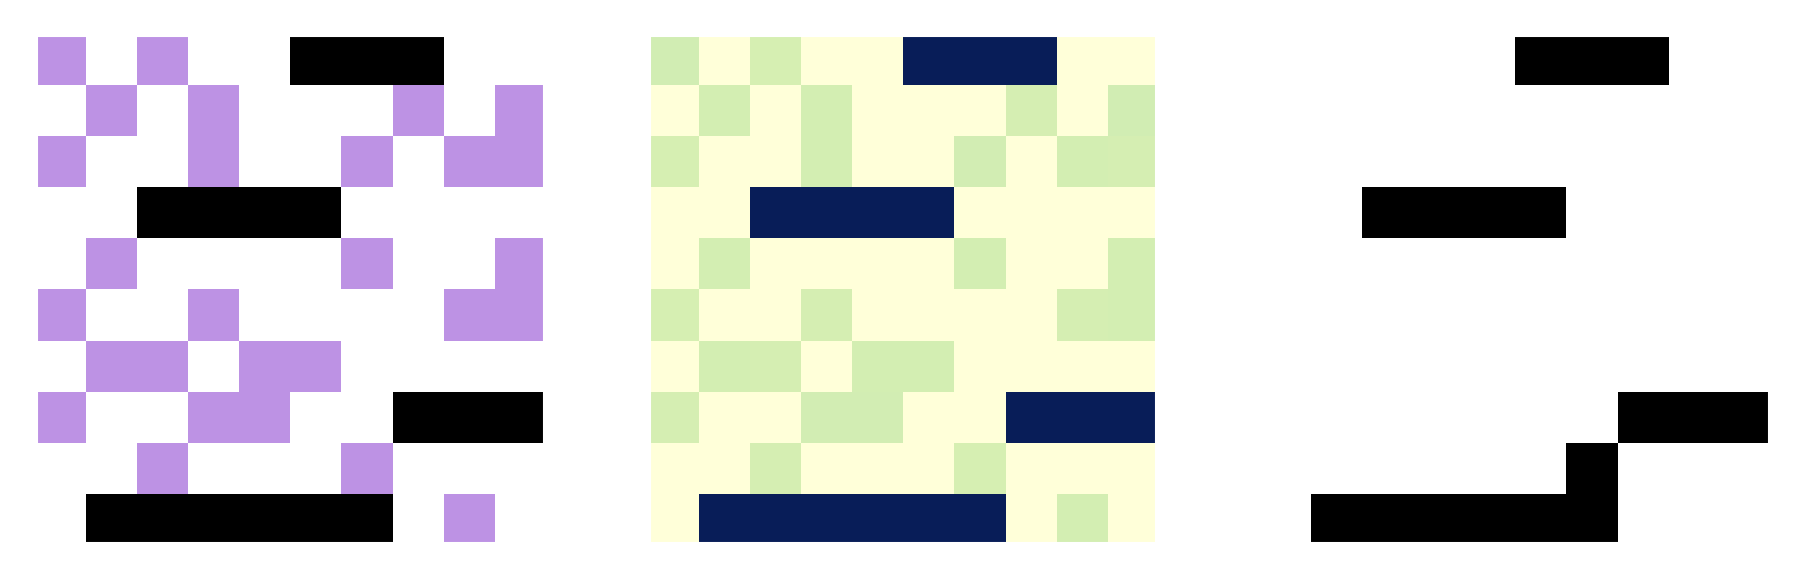

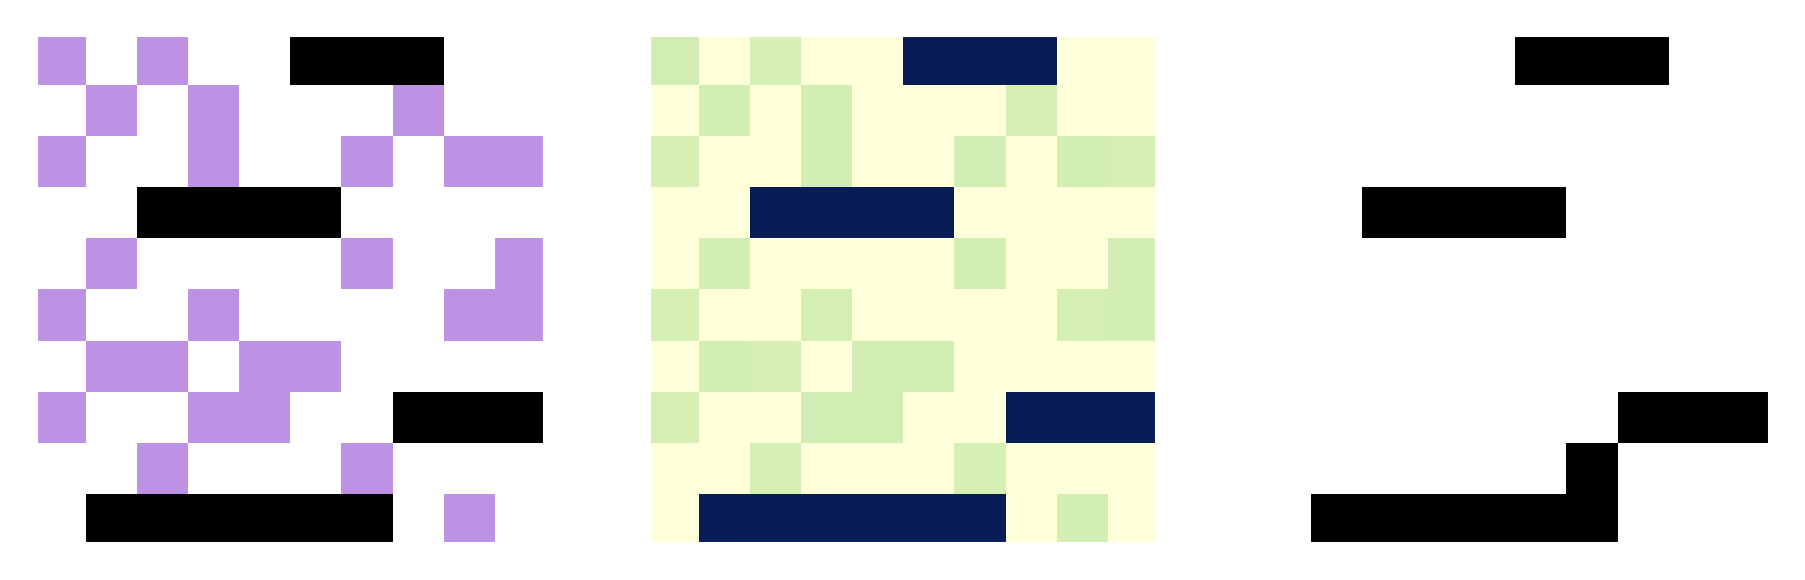

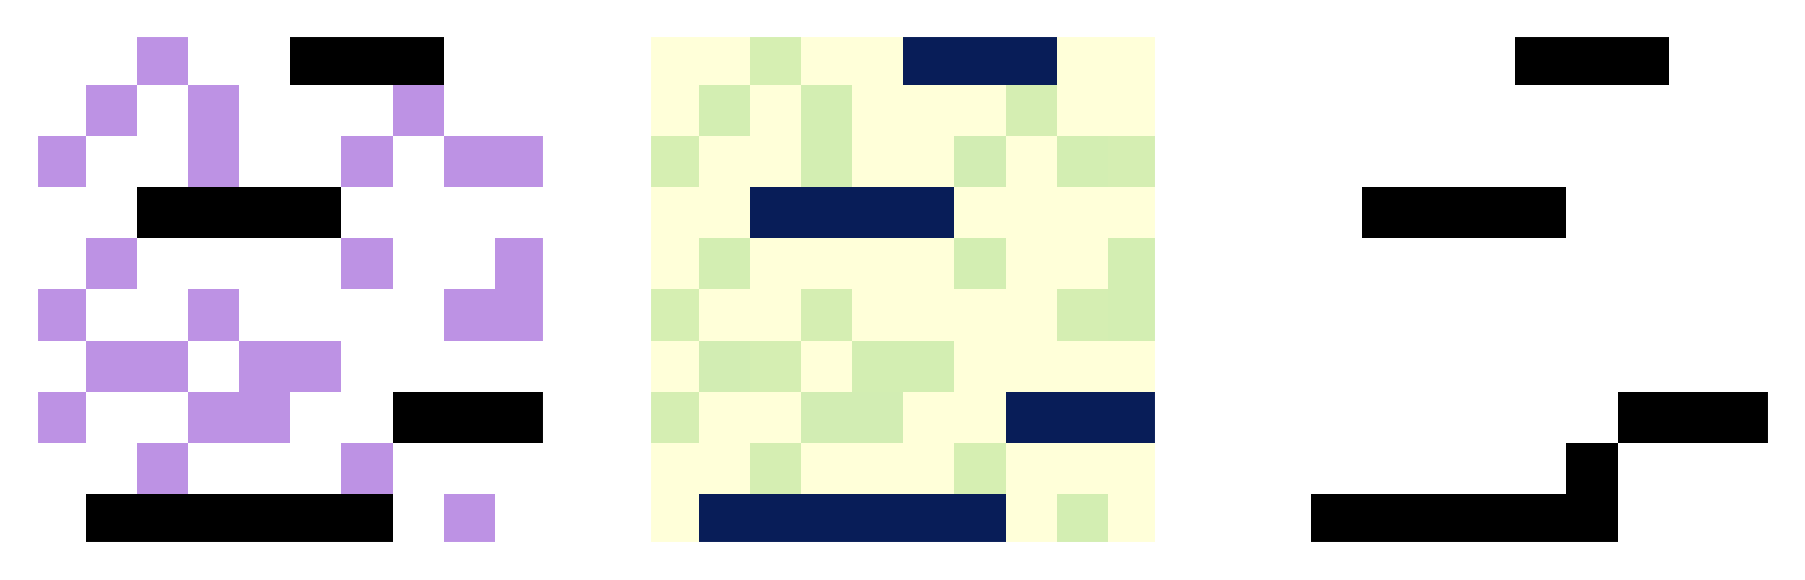

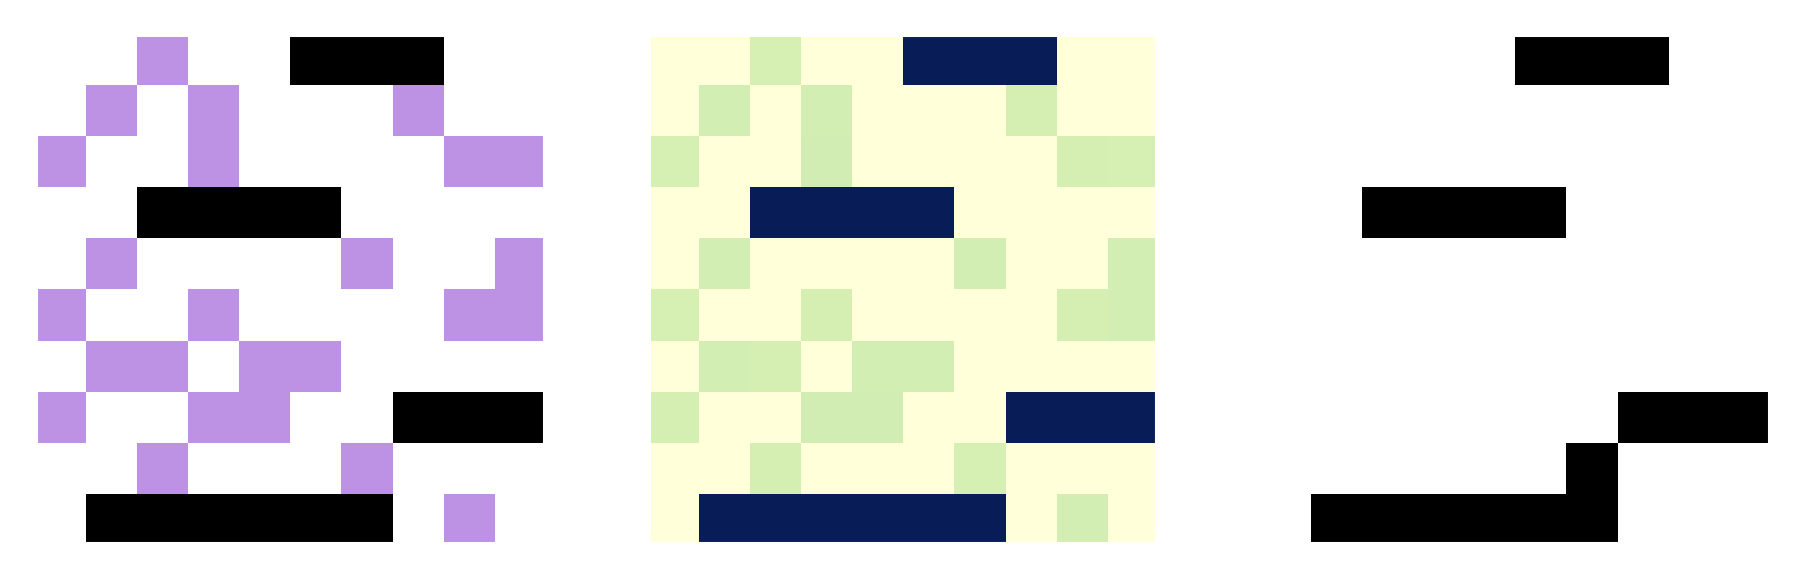

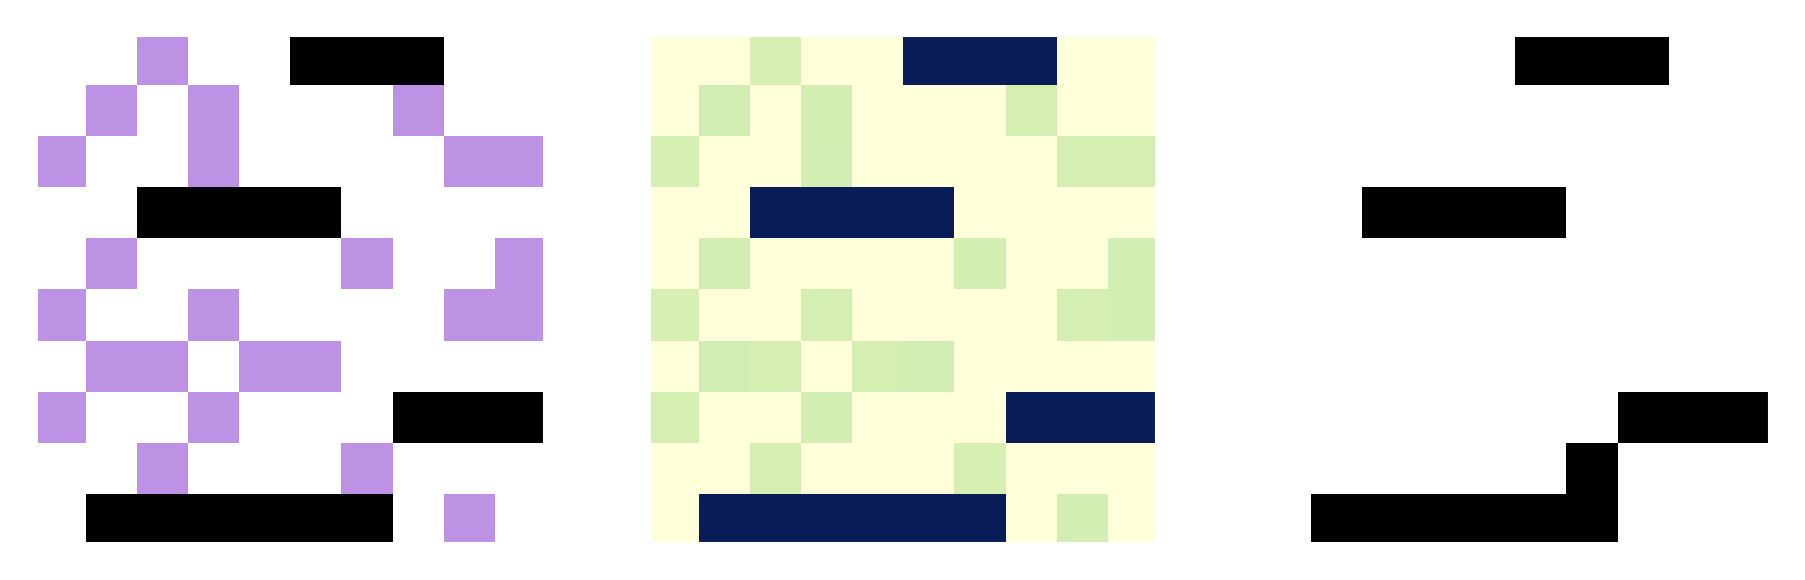

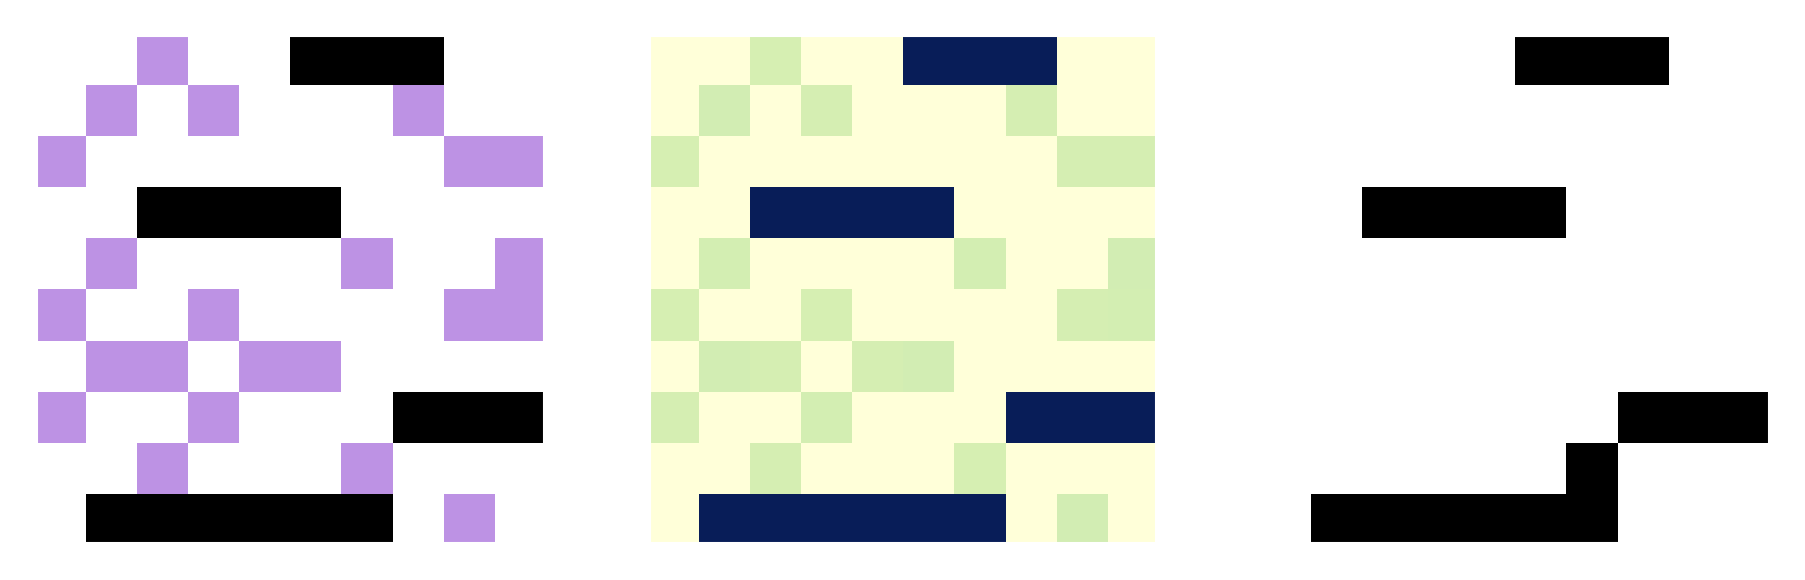

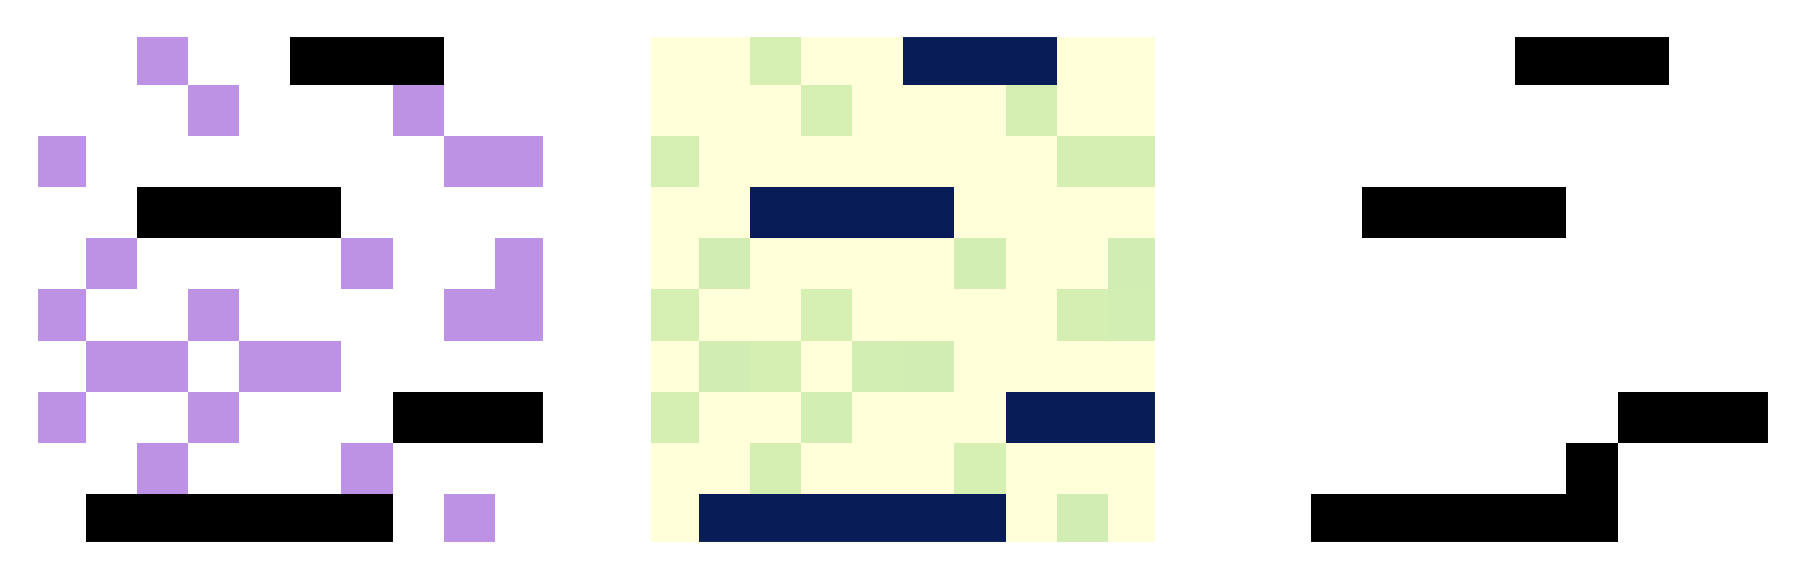

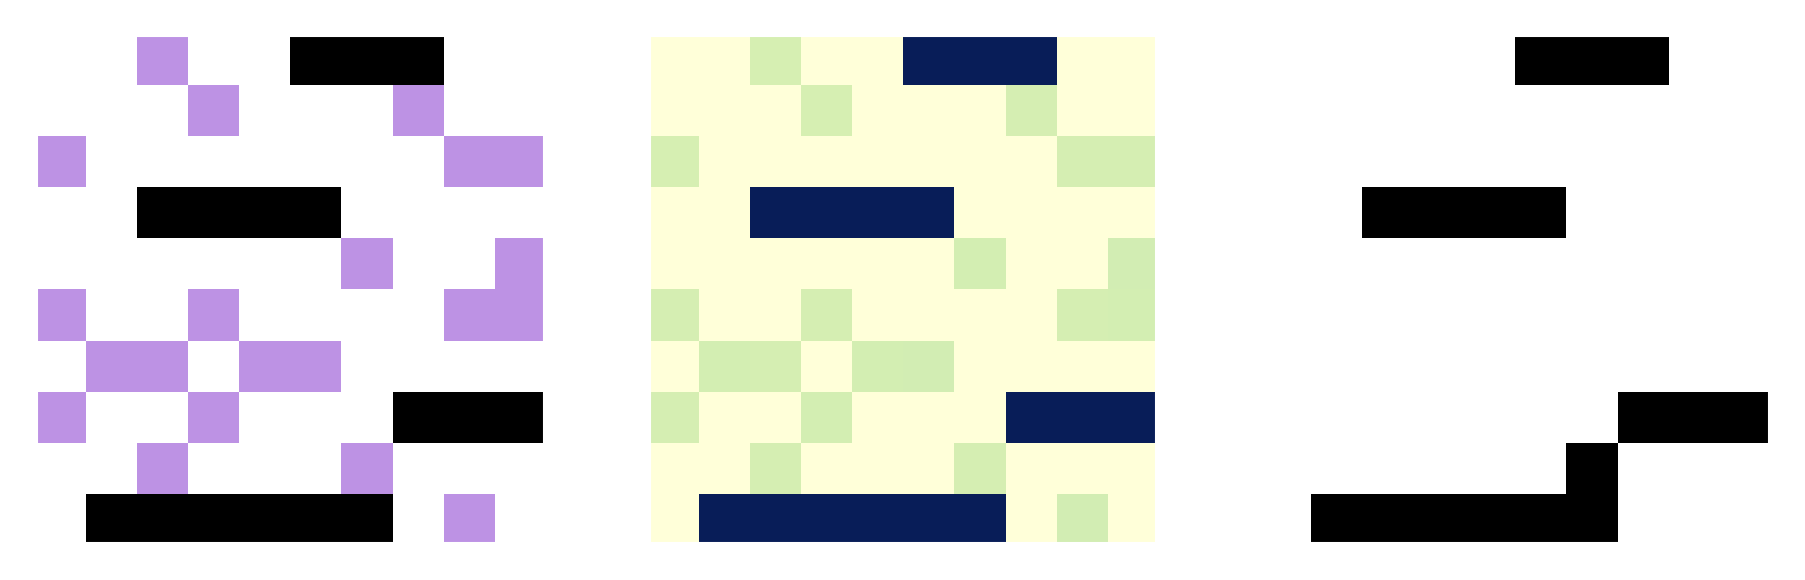

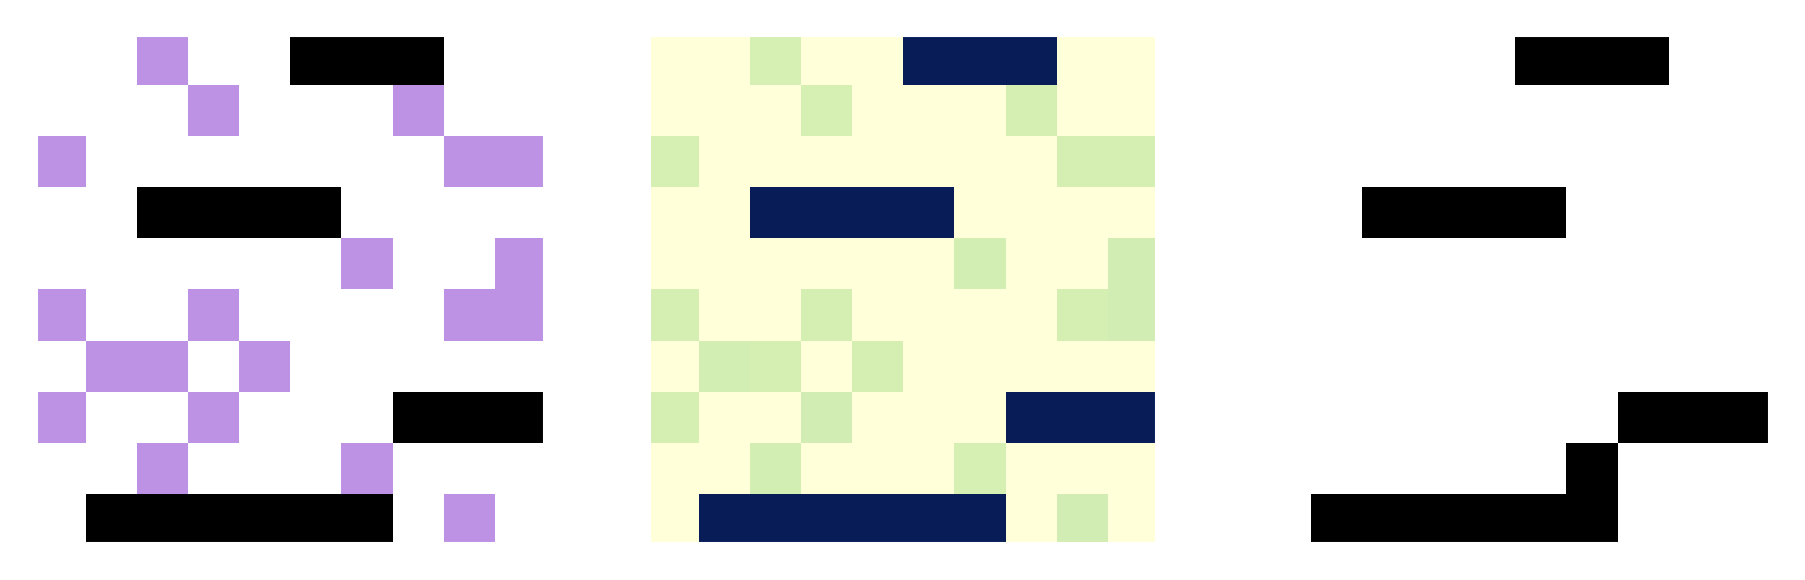

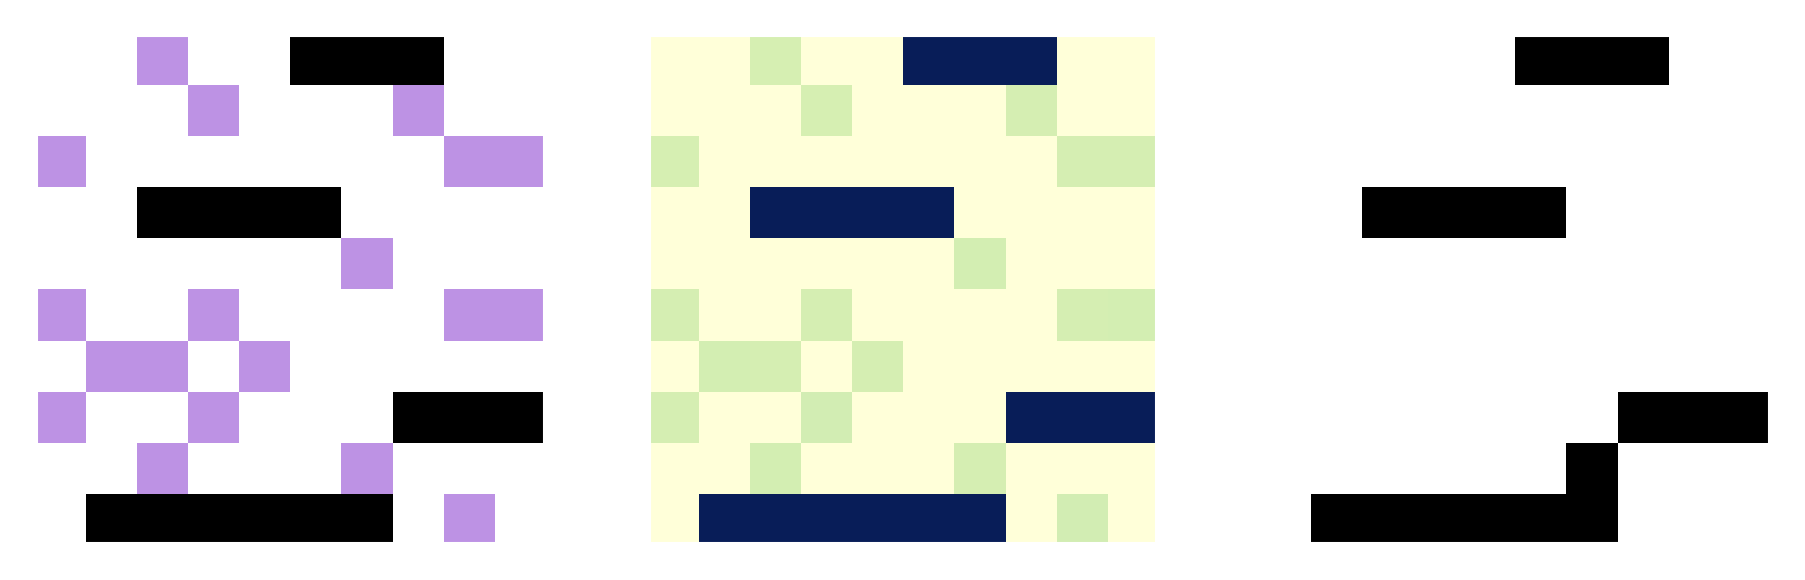

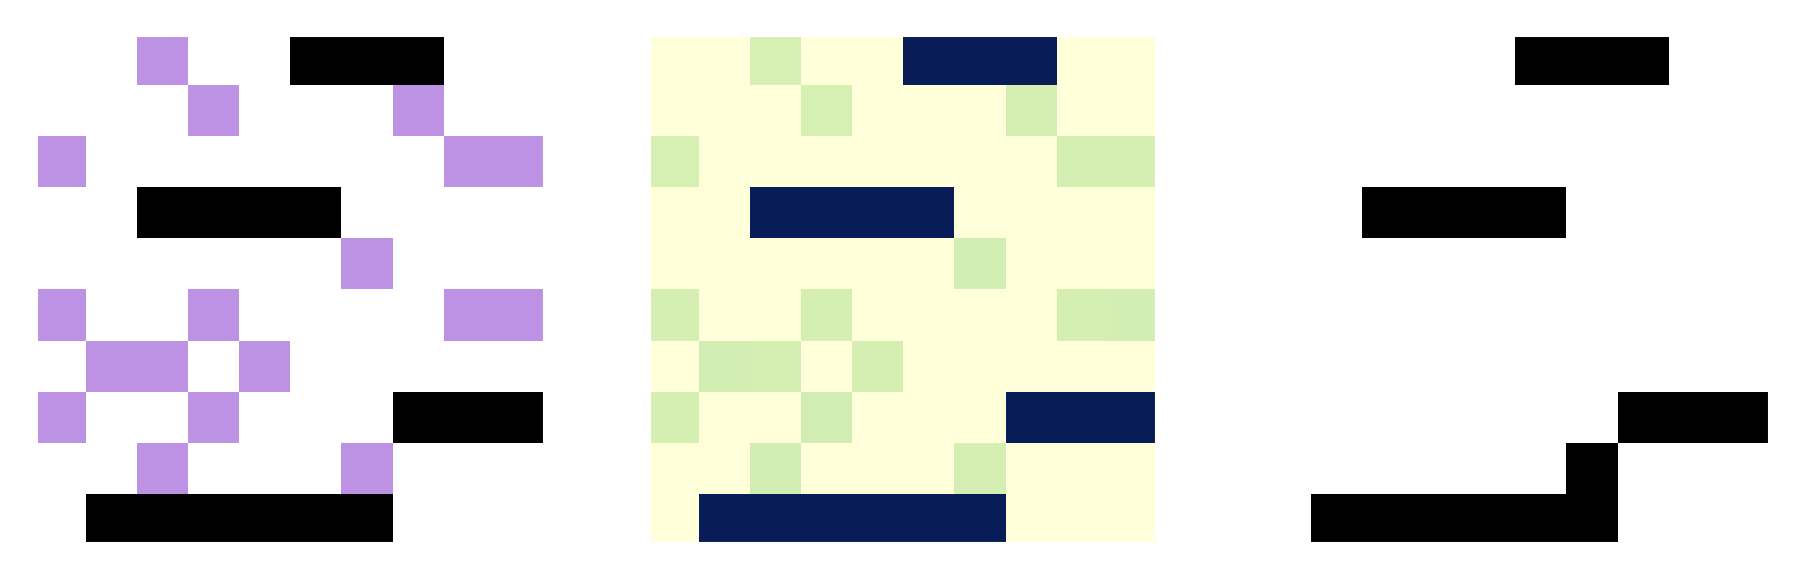

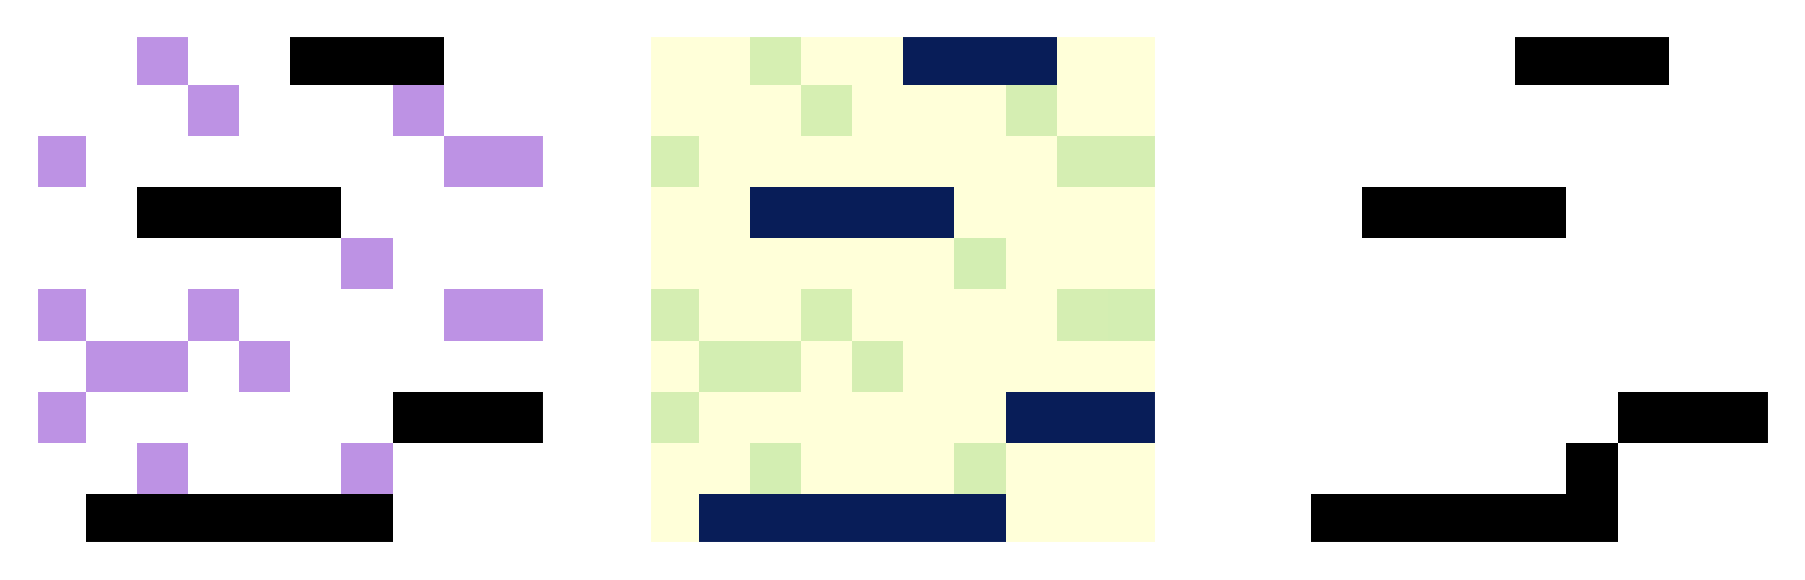

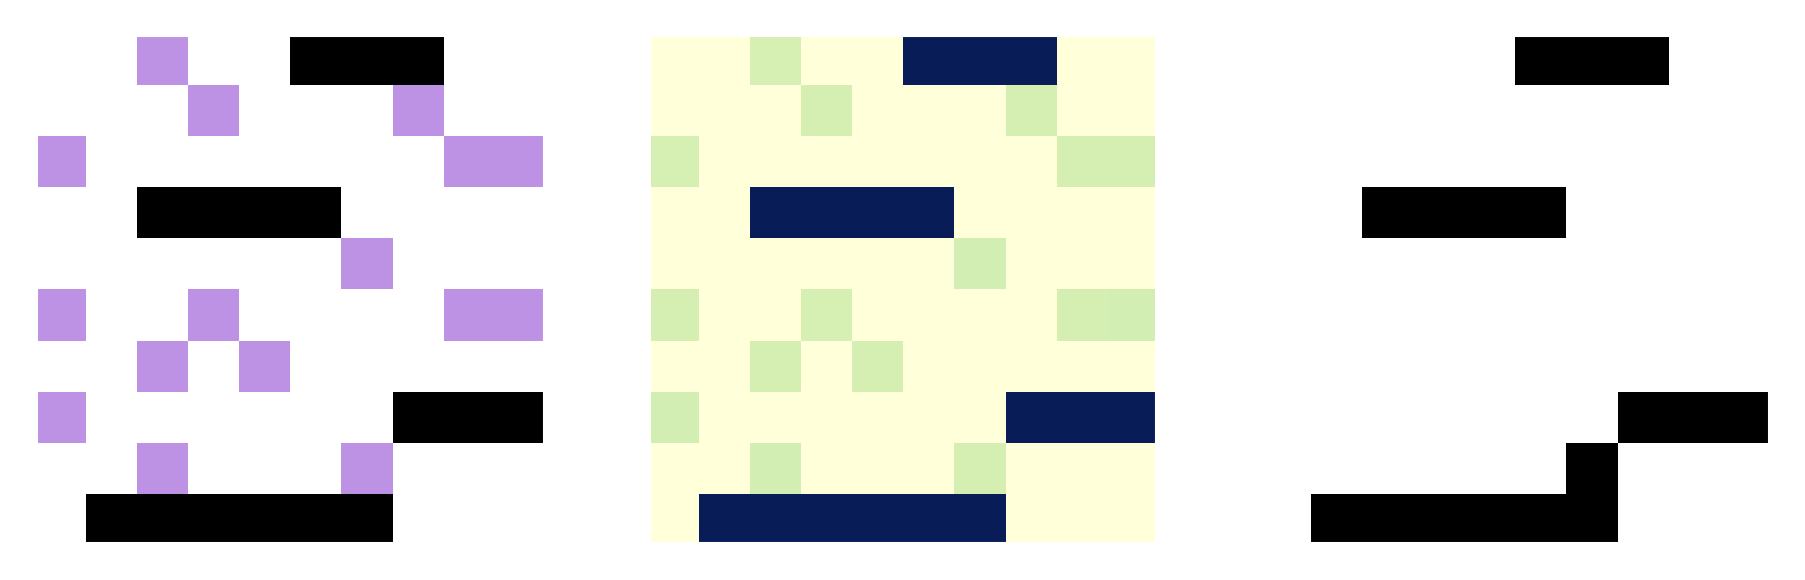

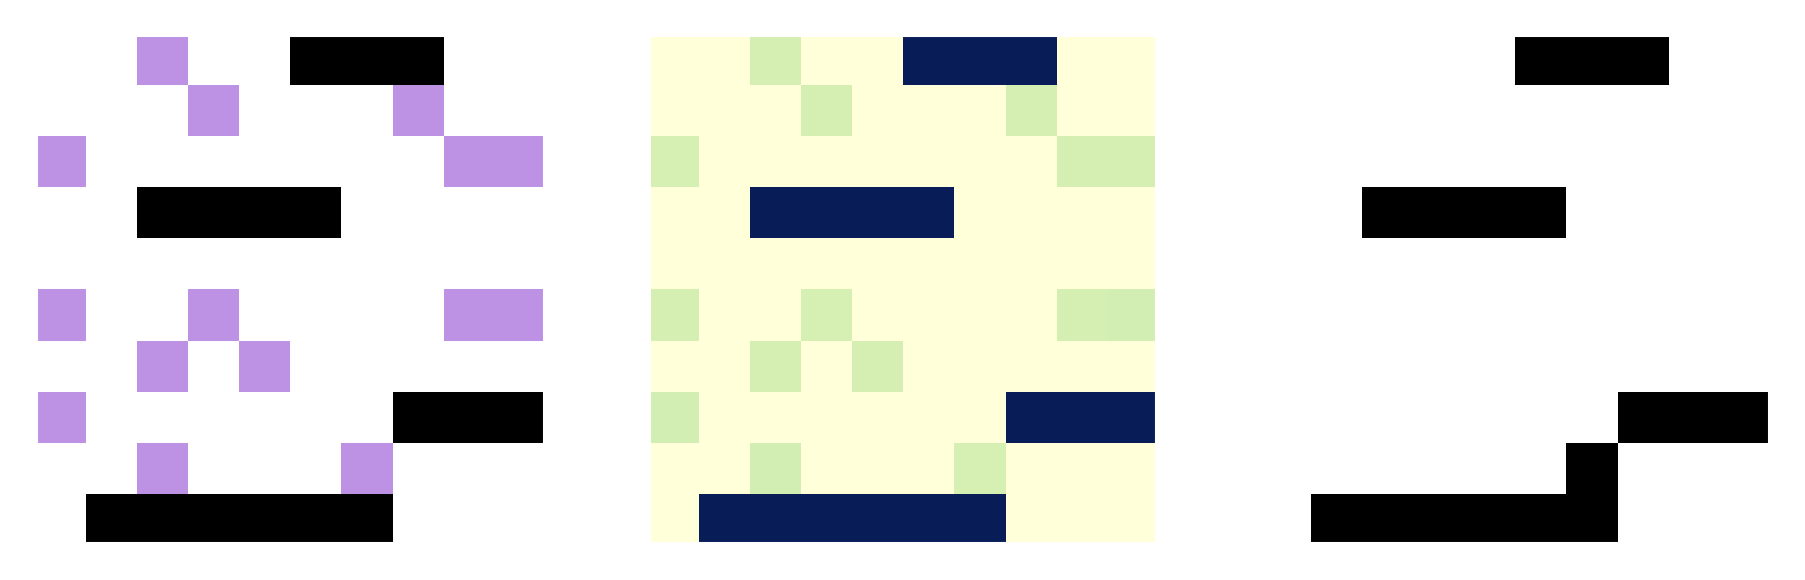

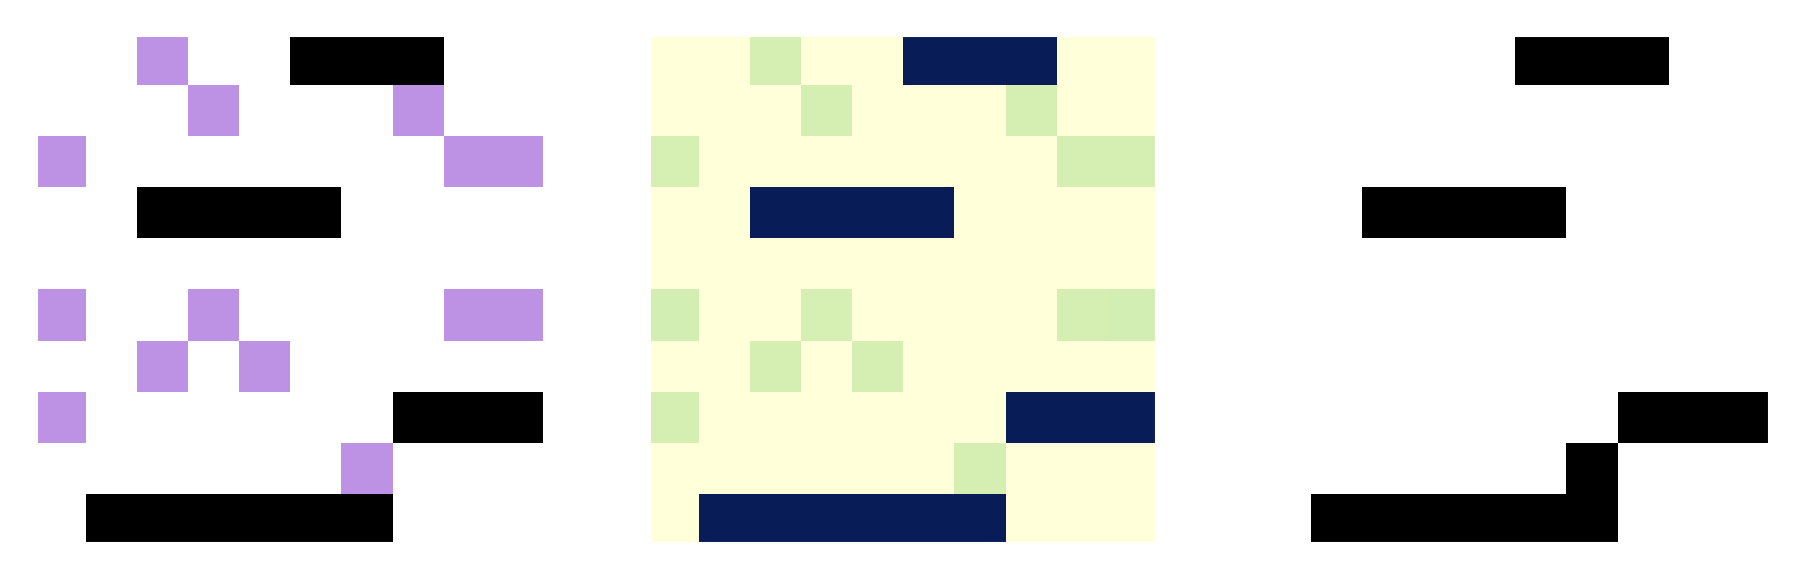

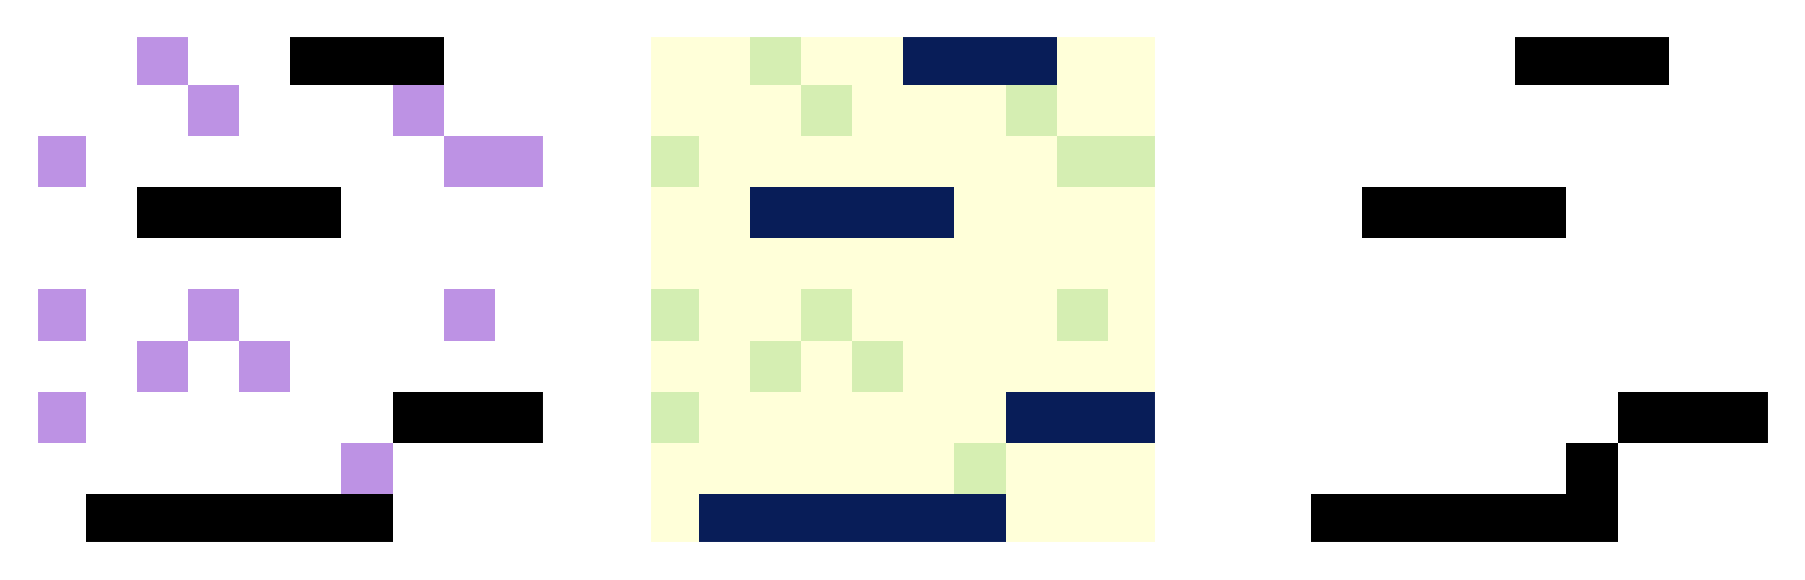

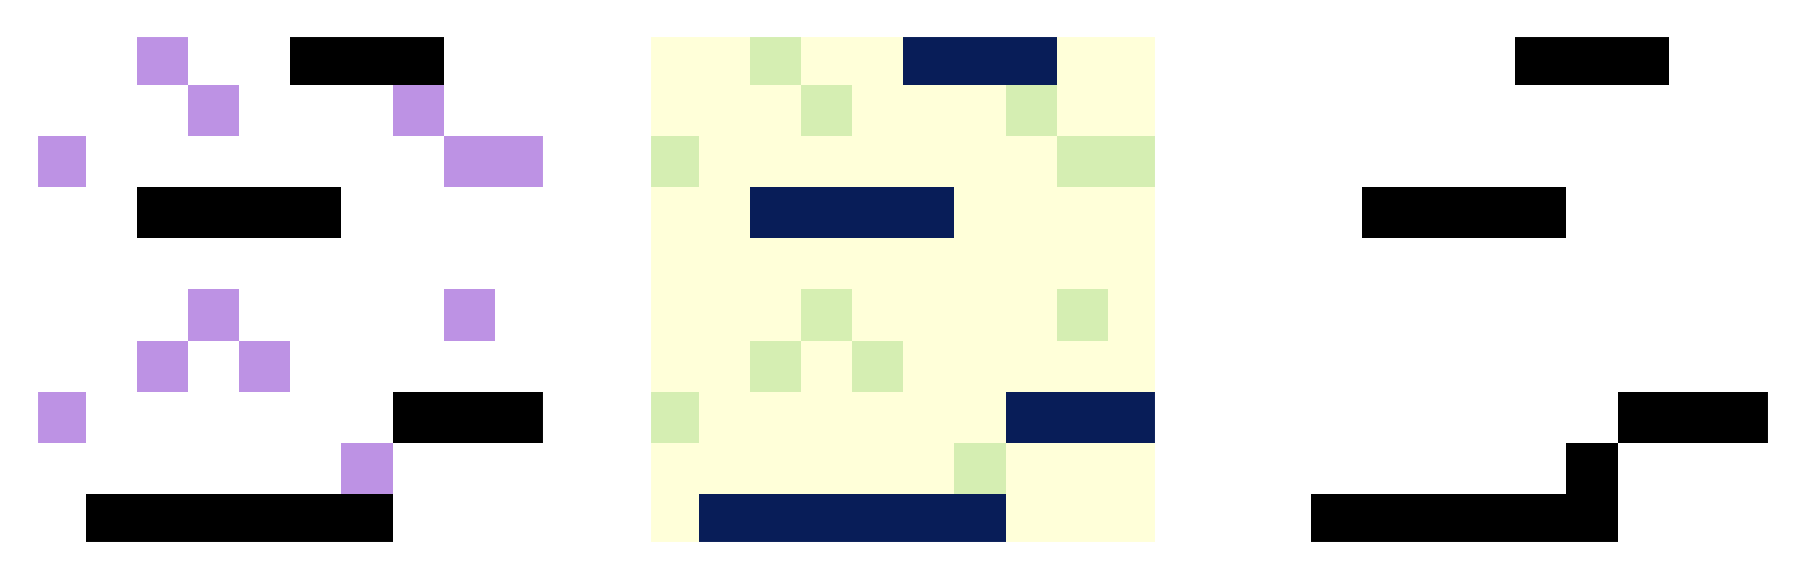

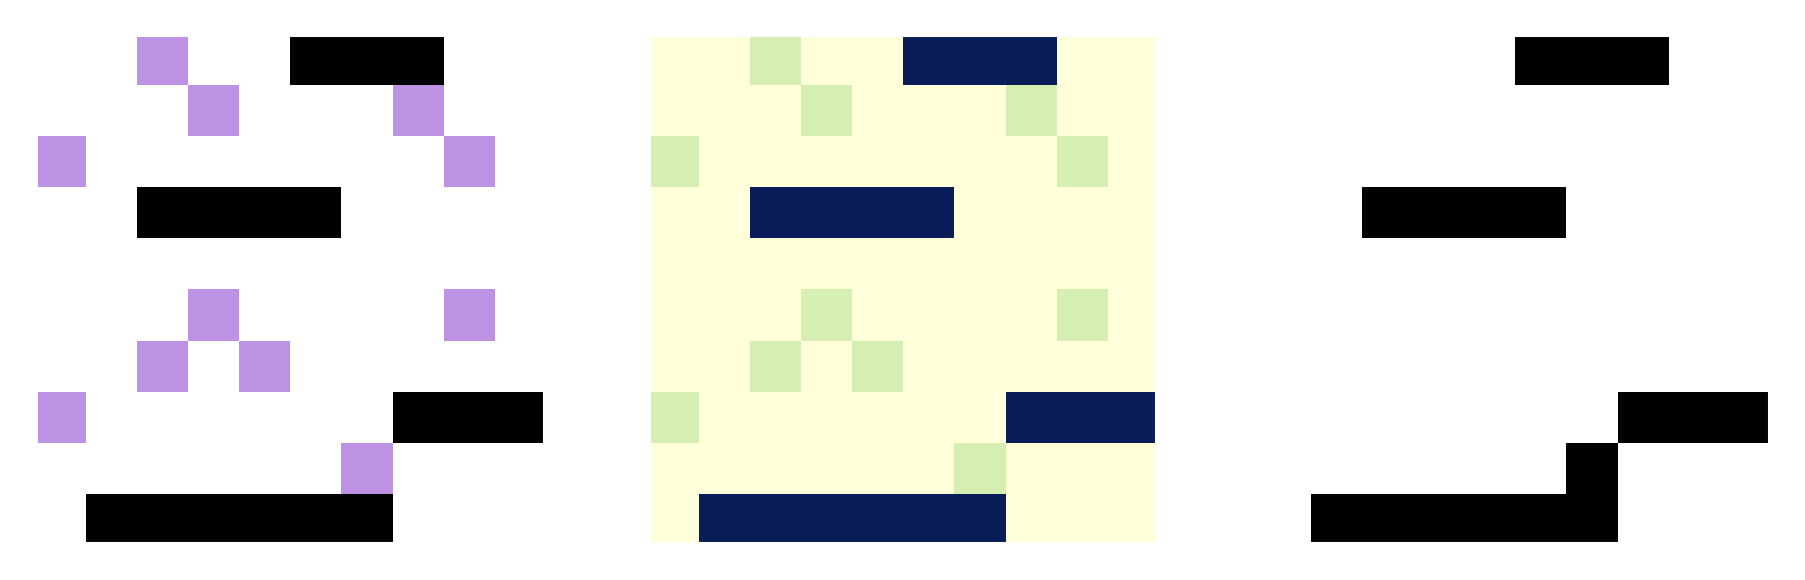

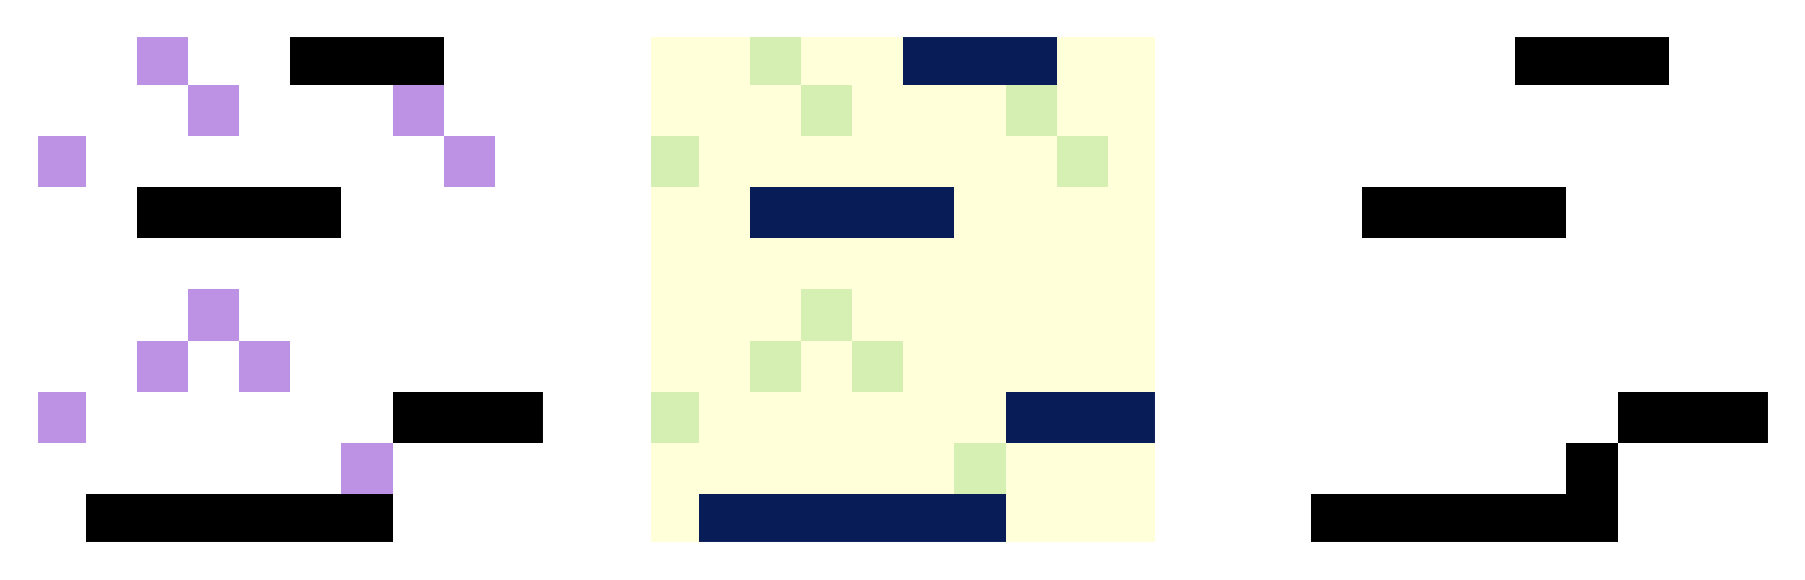

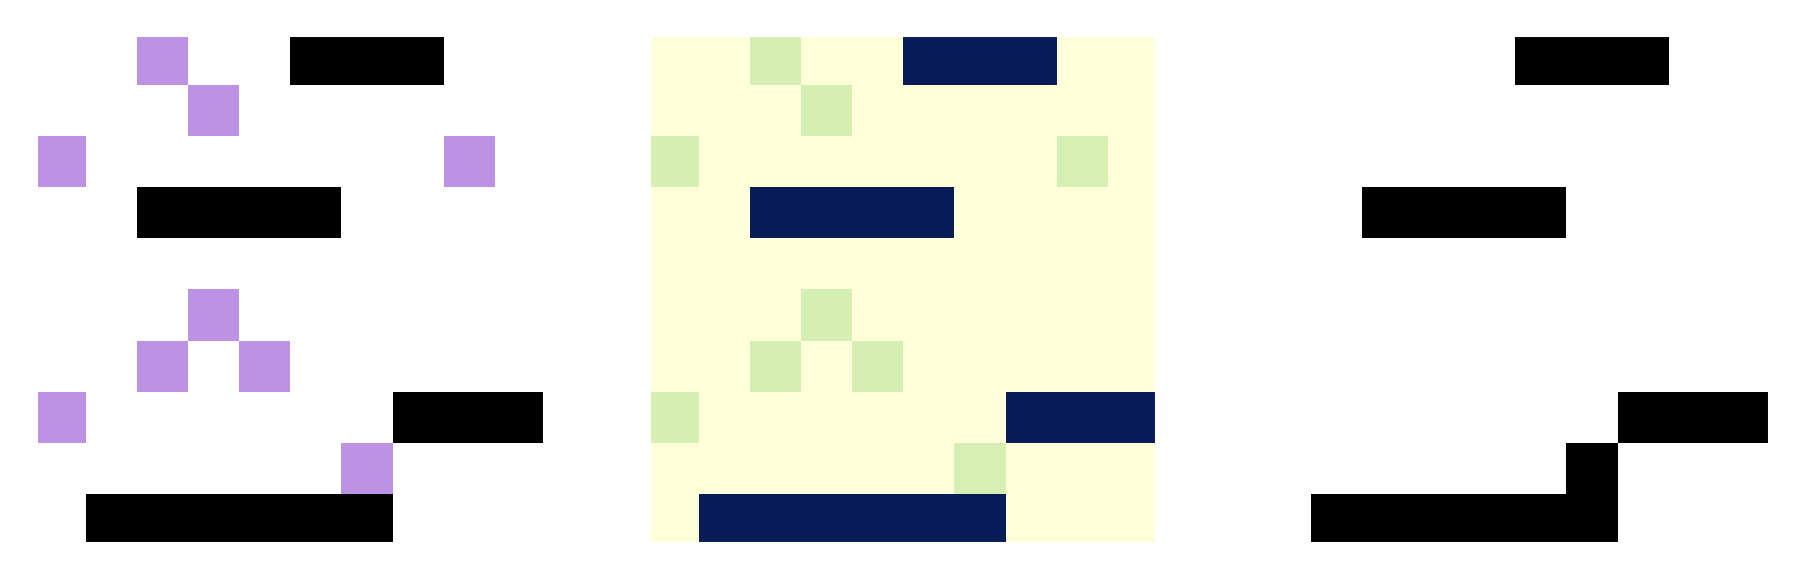

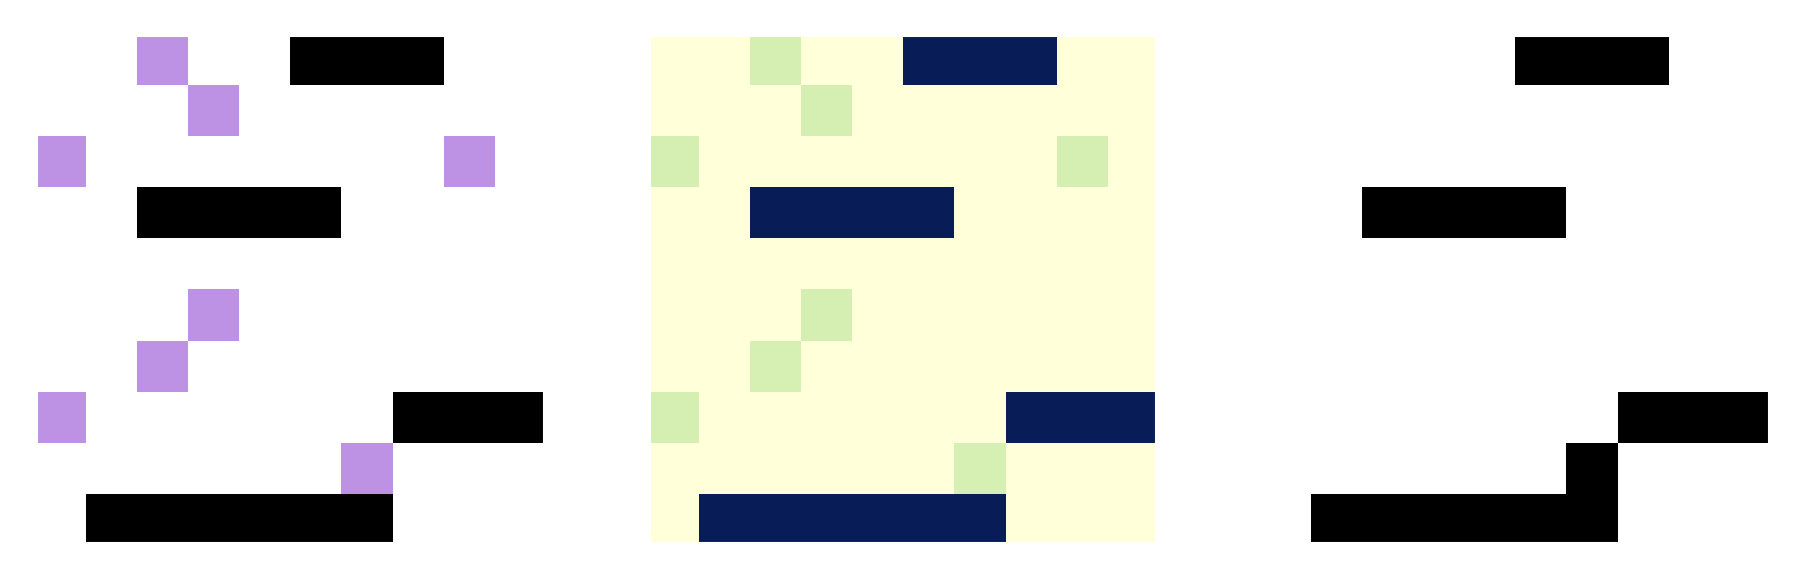

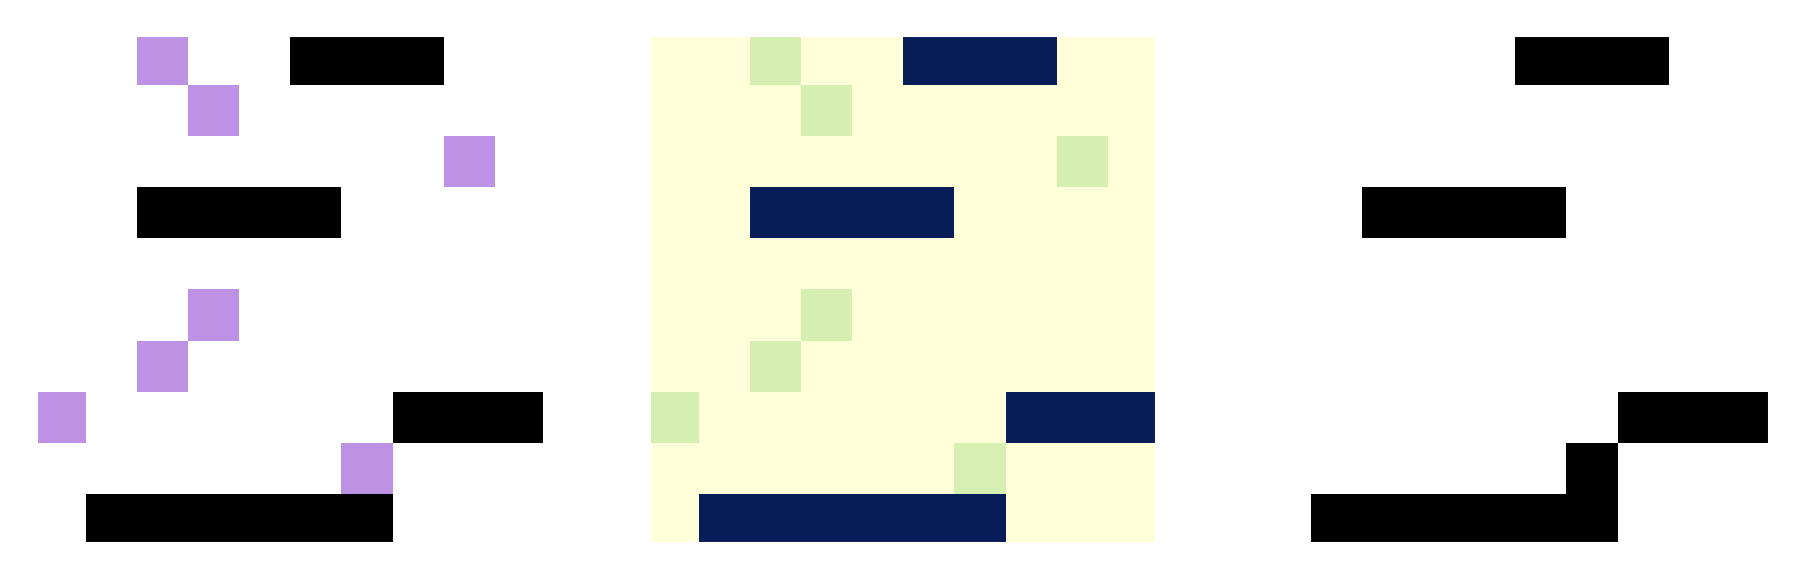

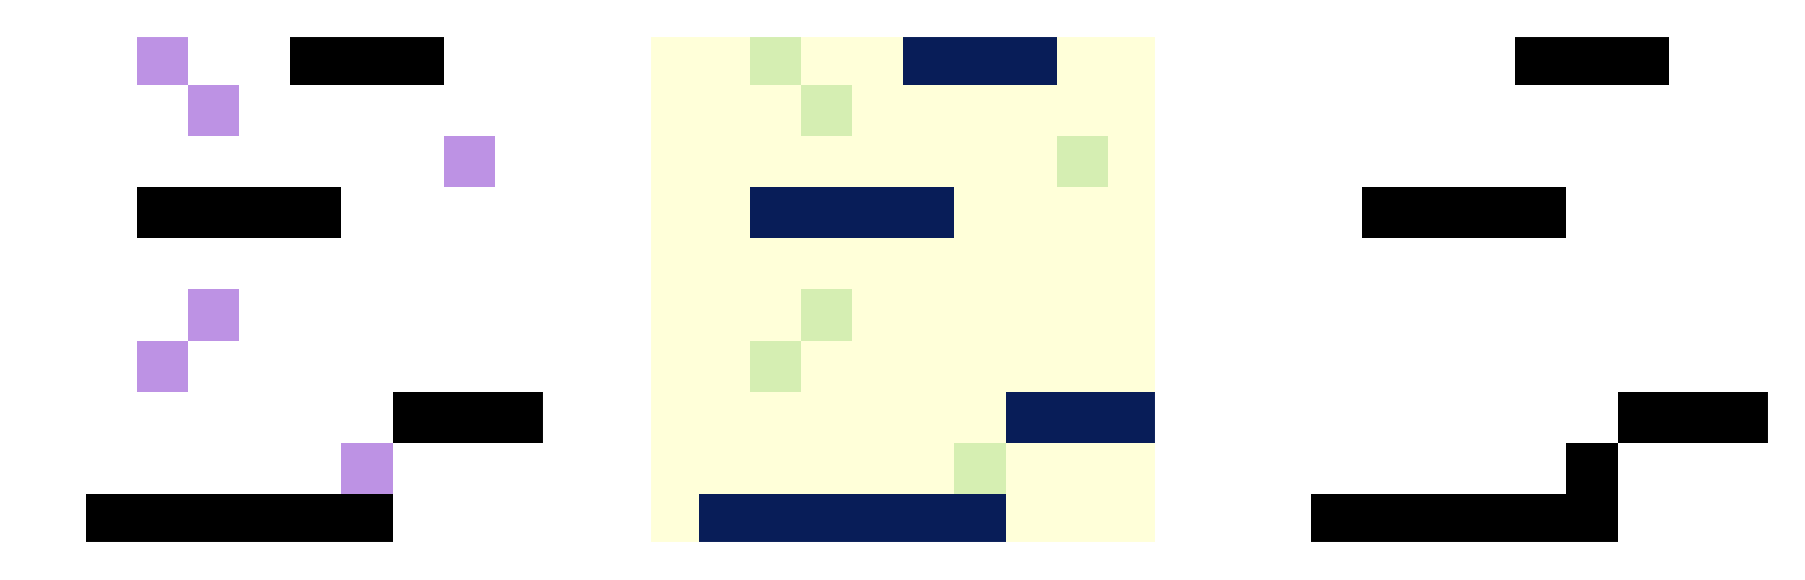

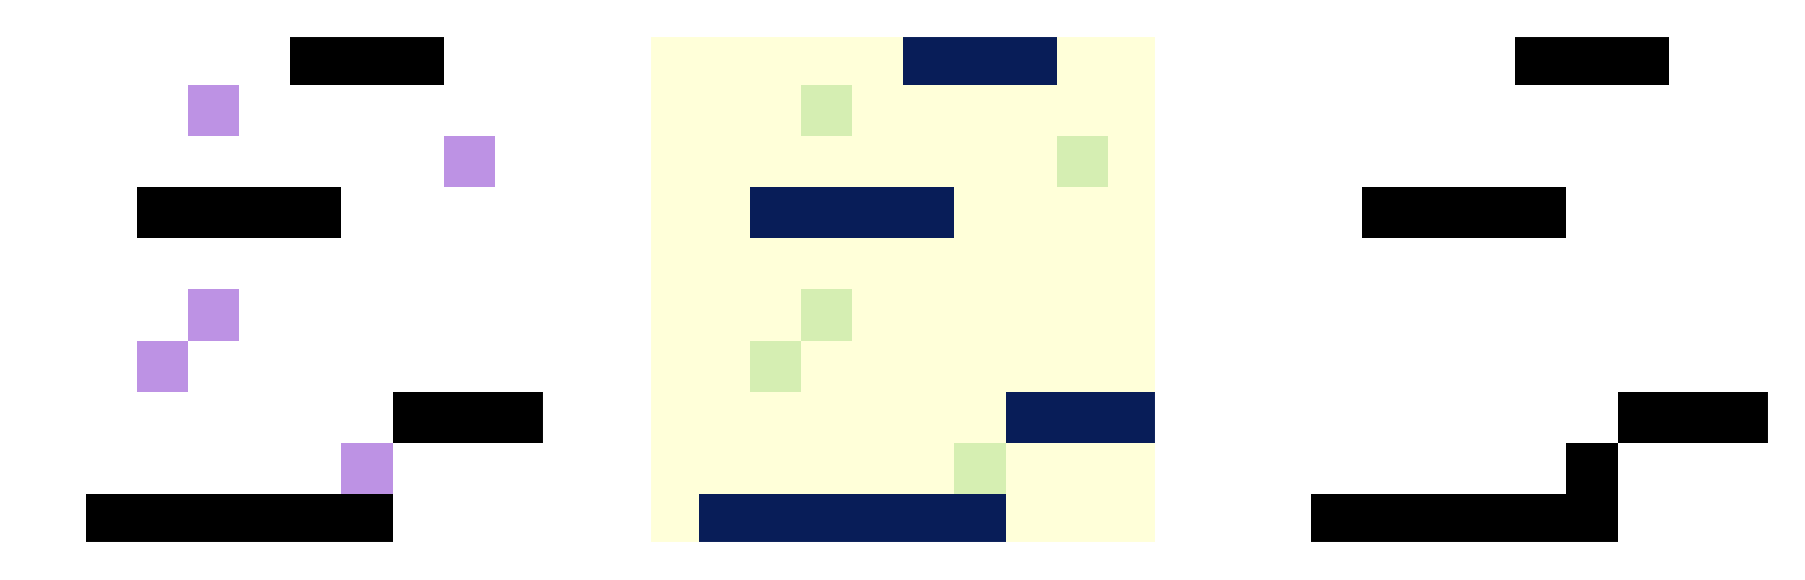

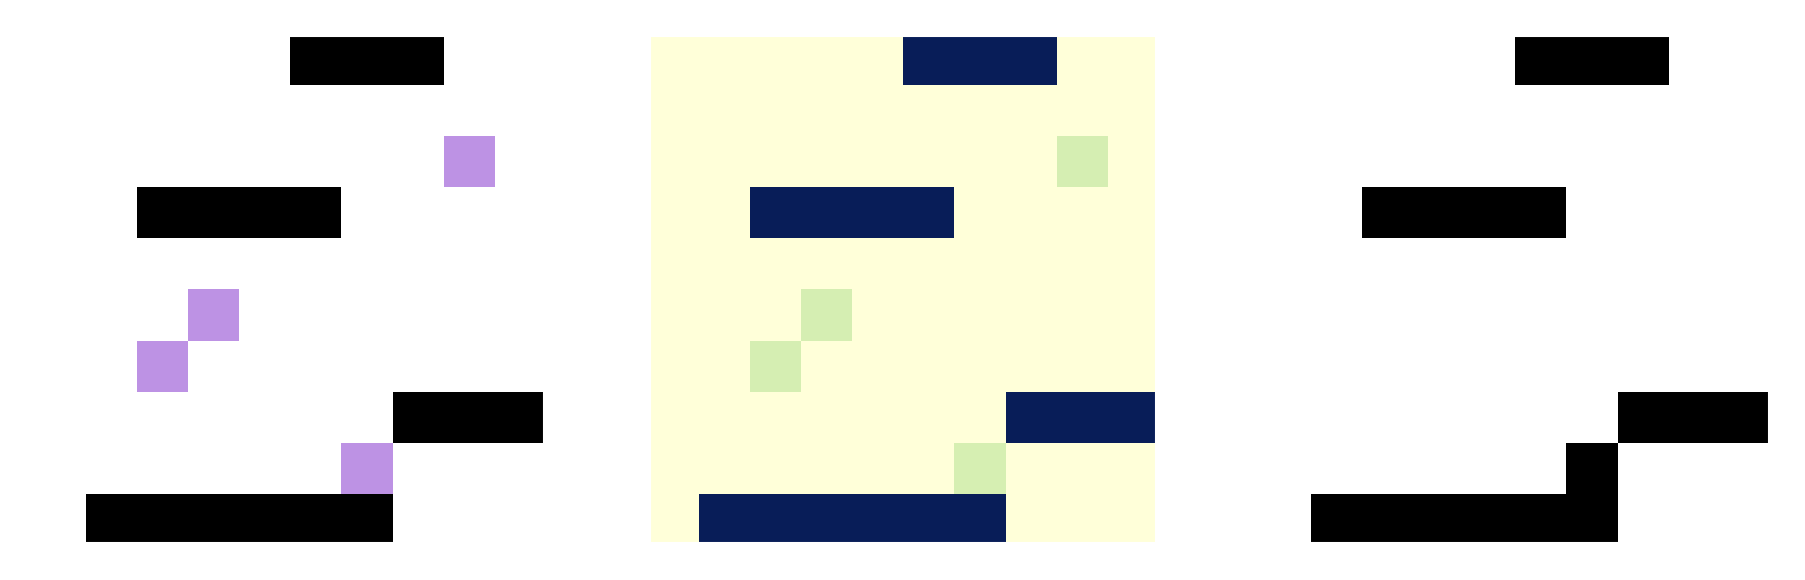

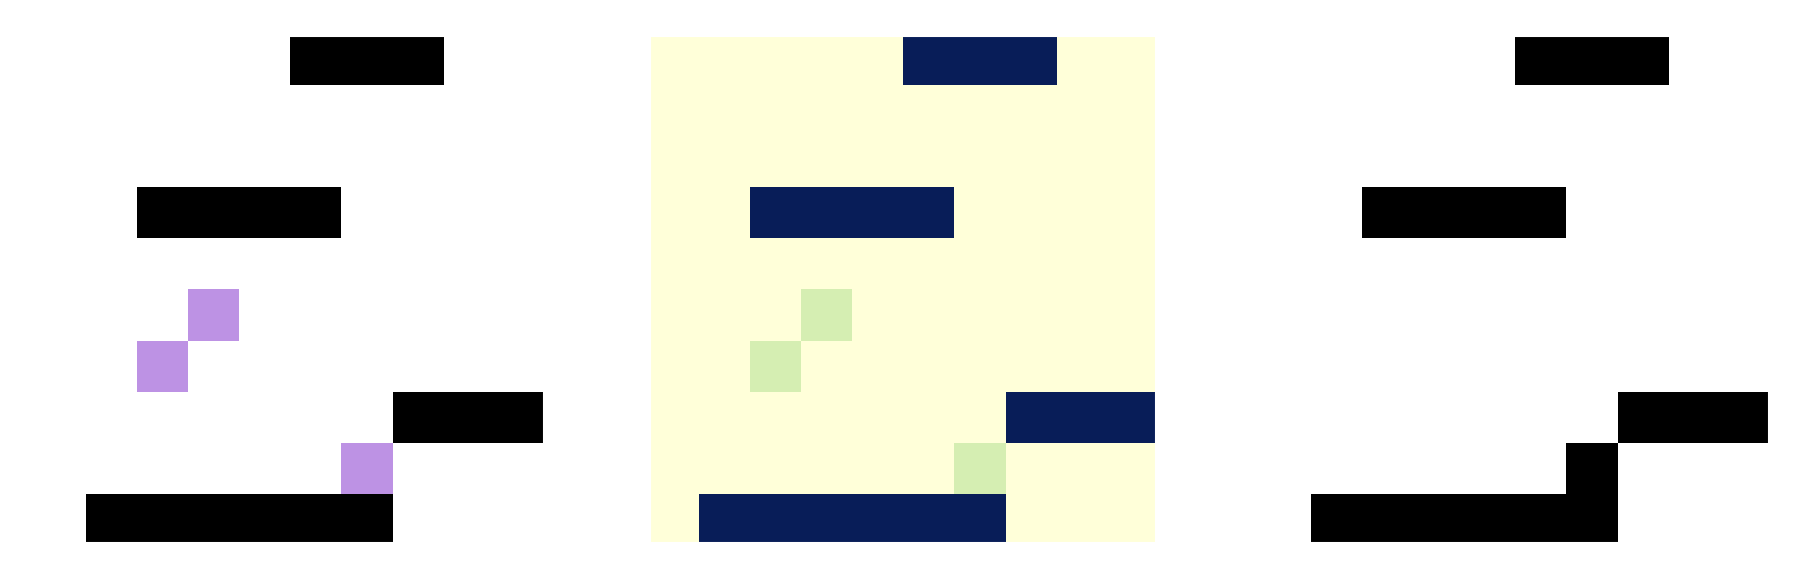

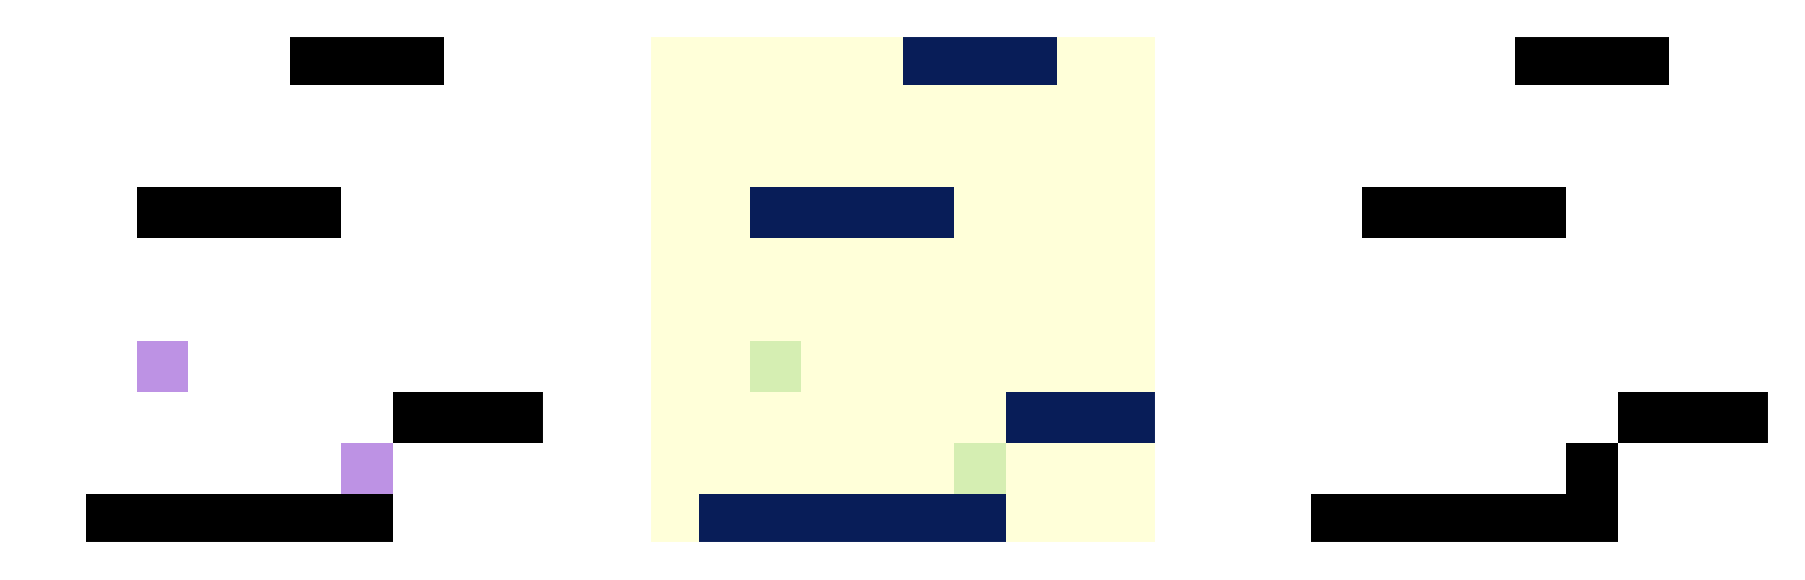

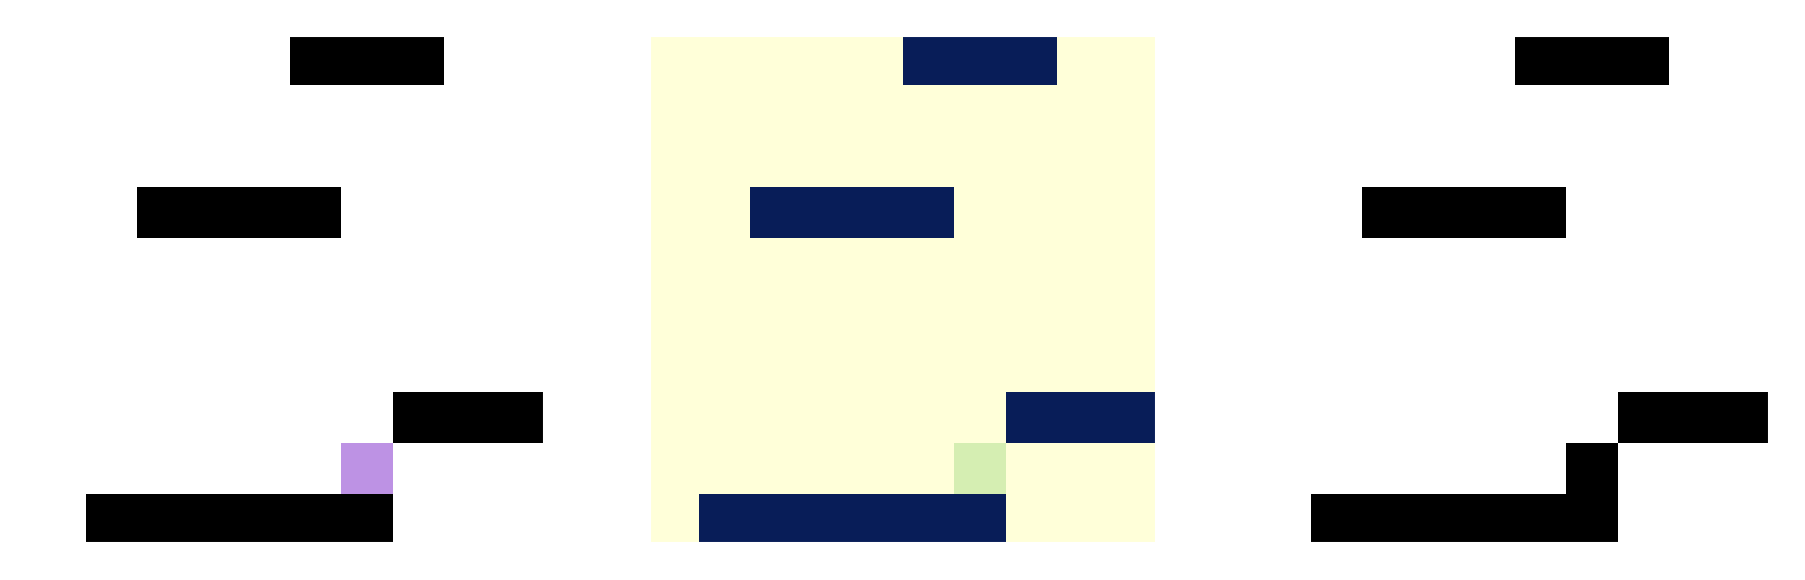

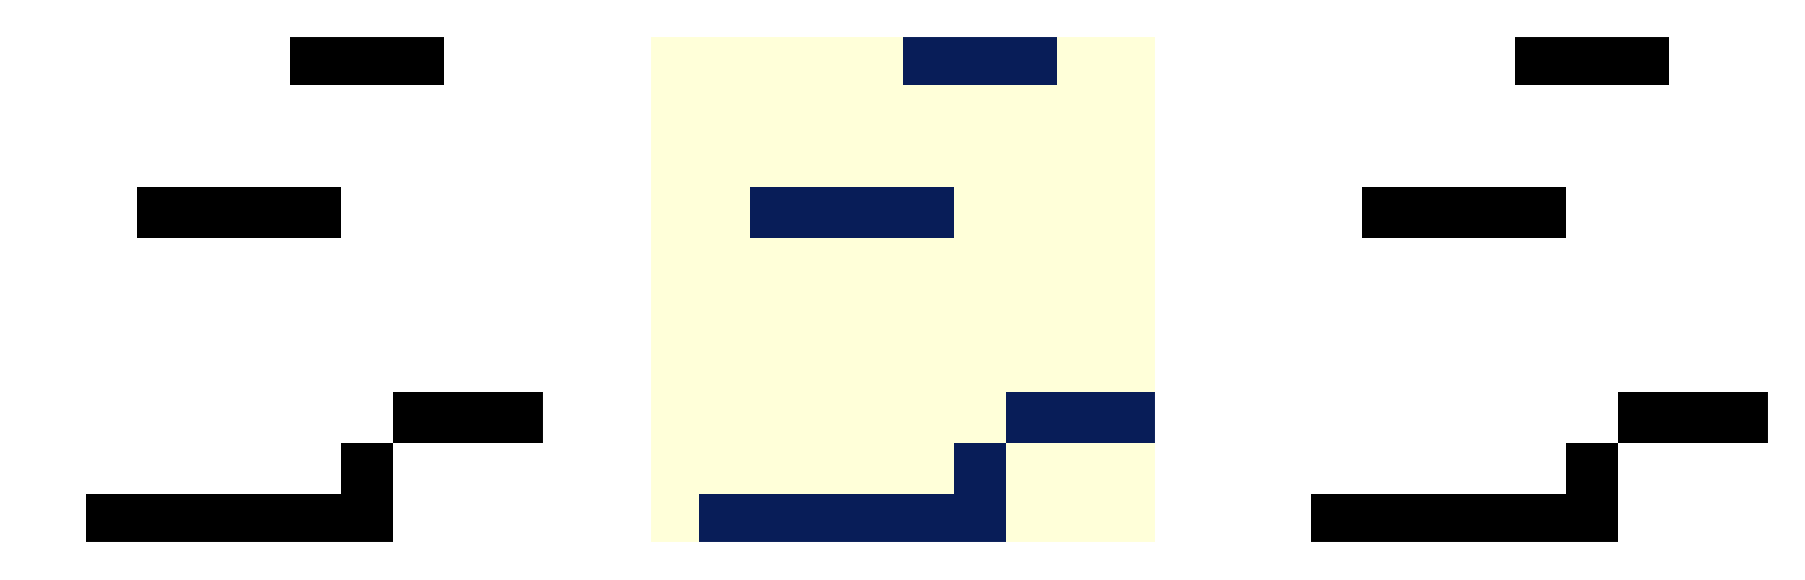

In [35]:
save_pics(model=trained_model, history=short_history, board=short_board, name="short")
save_pics(
    model=trained_model, history=median_history, board=median_board, name="median"
)
save_pics(model=trained_model, history=long_history, board=long_board, name="long")

## Make a histogram

In [57]:
game_lengths = [len(history) - 1 for history, board in histories_boards]
fractions = [0] * 100
for length in game_lengths:
    fractions[length - 1] += 1 / len(game_lengths)

cdfs = np.array([np.sum(fractions[:idx]) for idx, frac in enumerate(fractions)])
median = np.argmin((cdfs - 0.5) ** 2) + 1

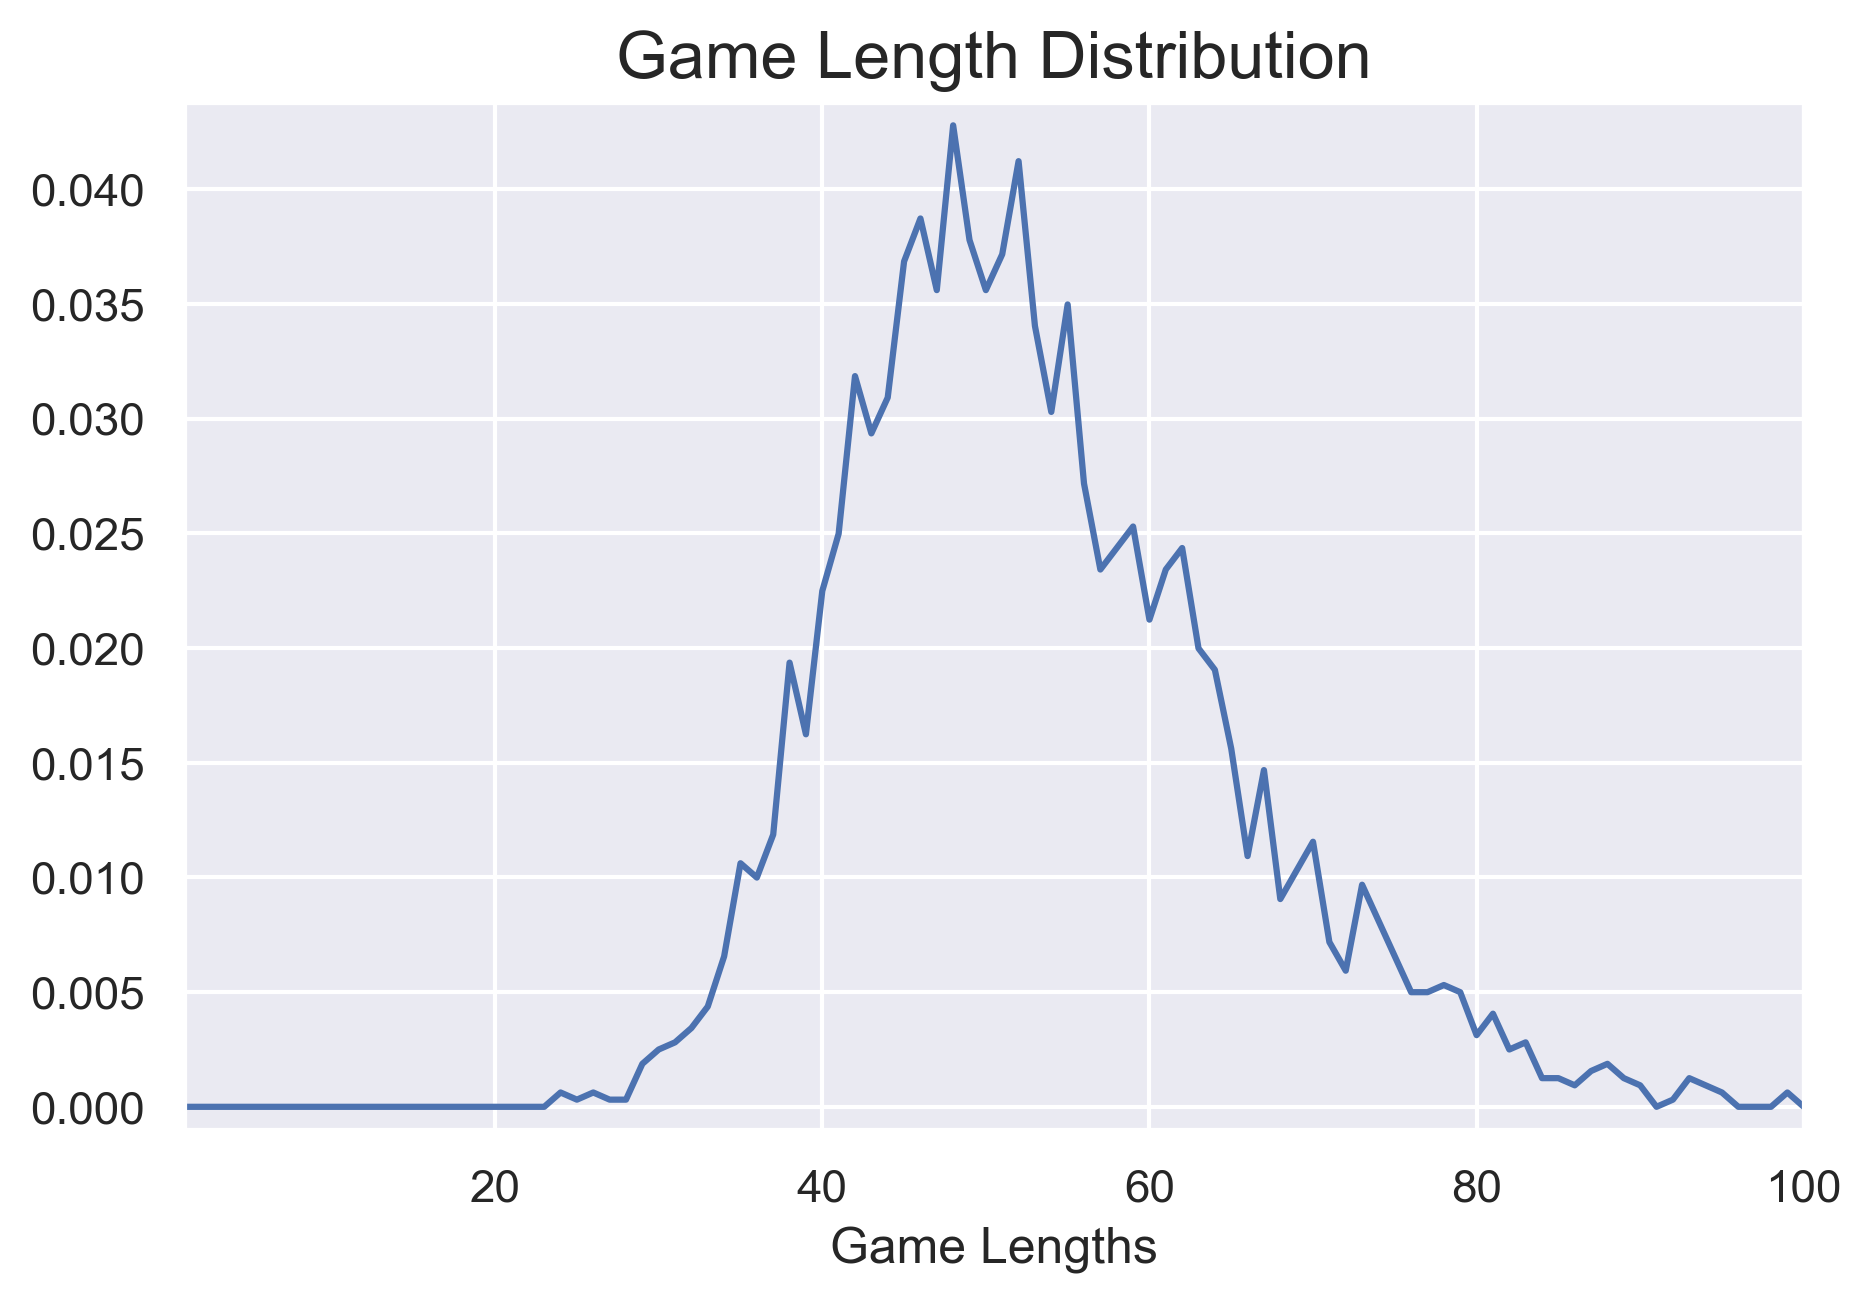

In [61]:
f, a = plt.subplots(dpi=300)
a.plot(range(1, 101), fractions)
a.set_xlim(1, 100)
a.set_title("Game Length Distribution", fontsize=16)
a.set_xlabel("Game Lengths")
a.set_ylim(-0.001, np.max(fractions) + 0.001)
a.set_aspect(60 / np.max(fractions))
plt.tight_layout()
plt.show()
f.savefig("game_length_dist.png", bbox_inches="tight")

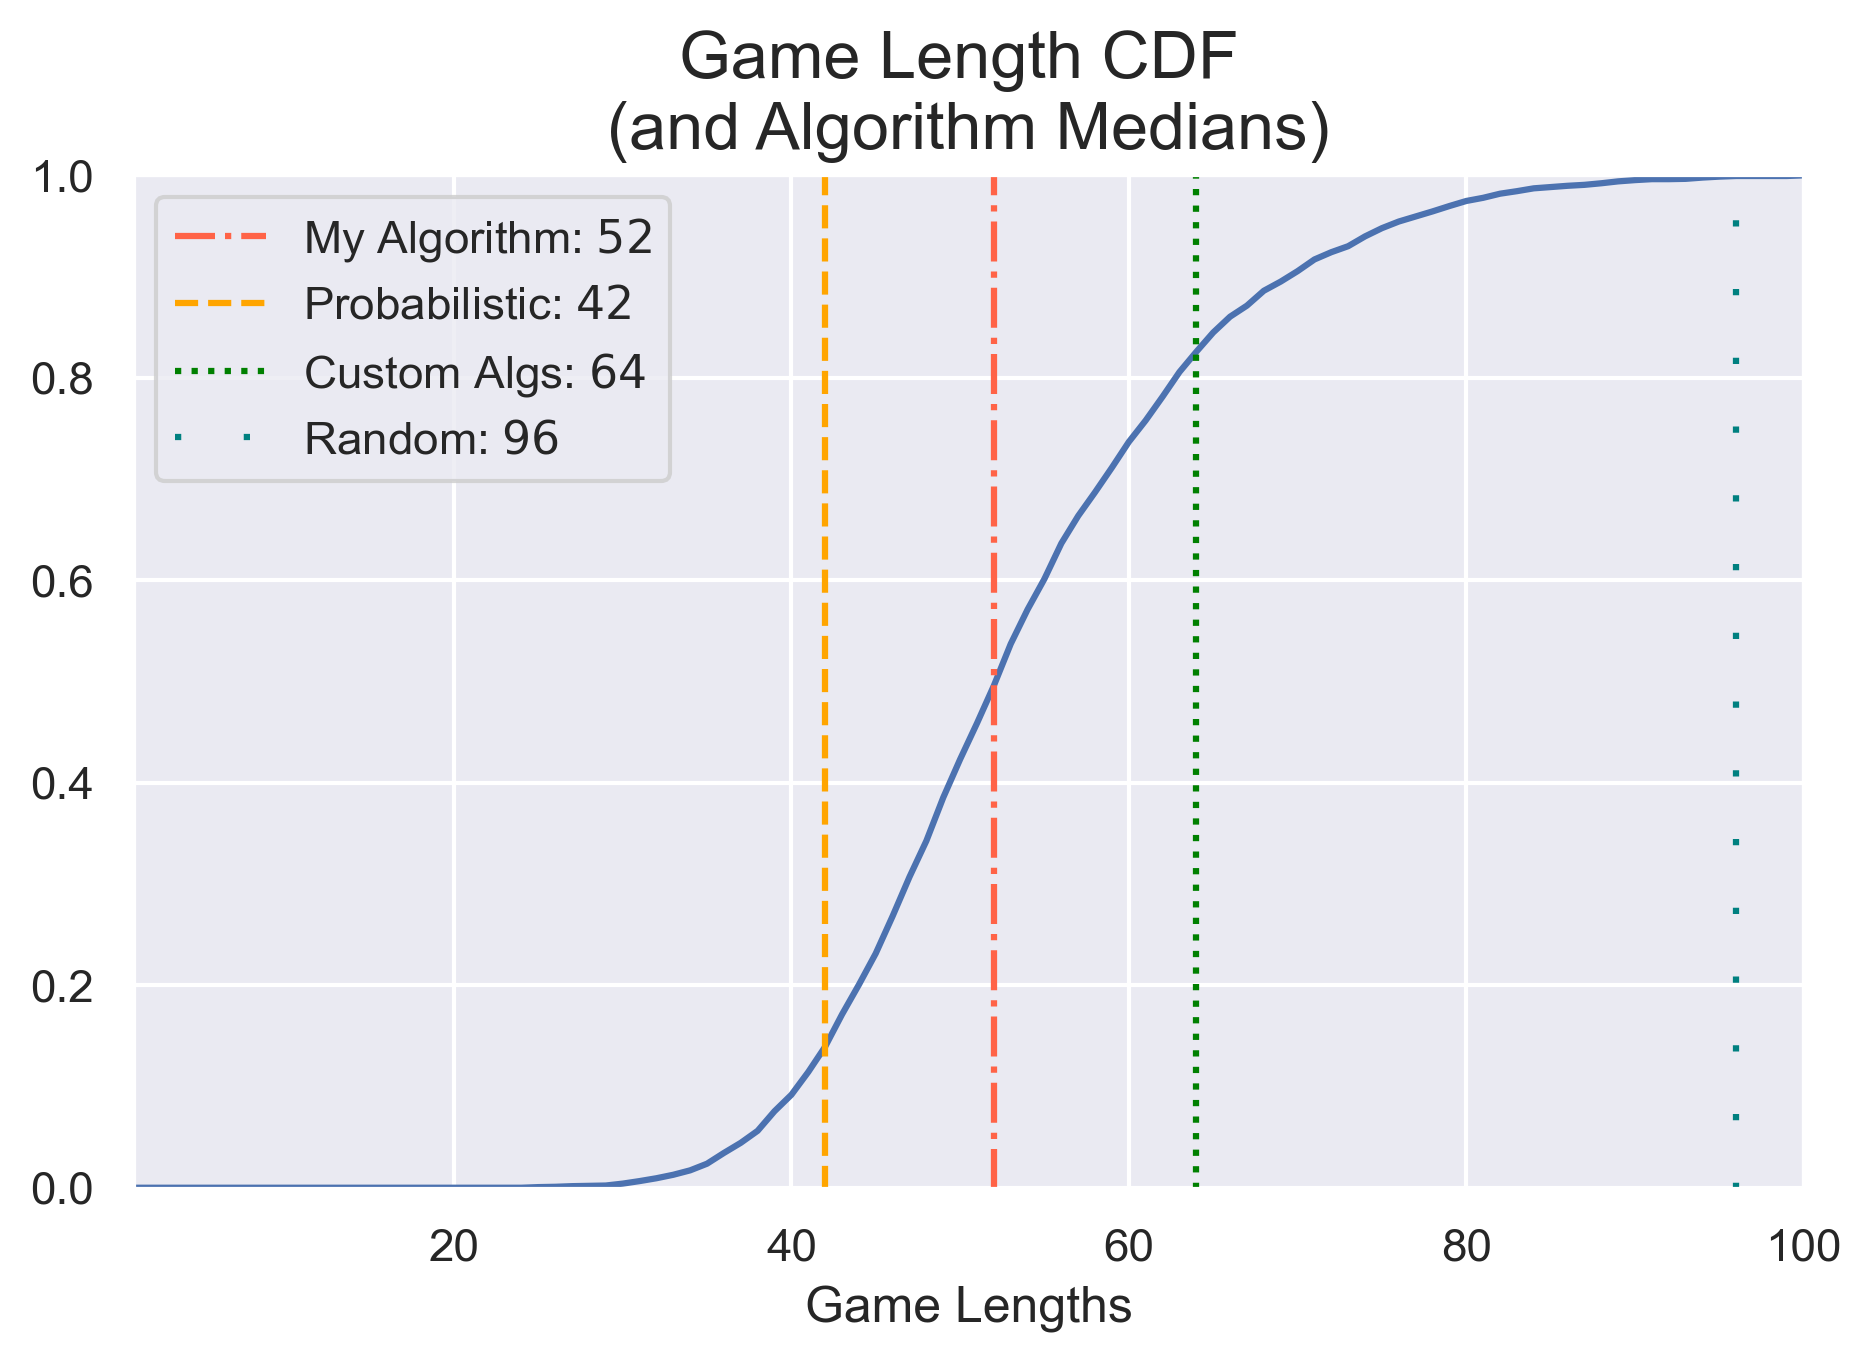

In [60]:
f, a = plt.subplots(dpi=300)
a.plot(range(1, 101), cdfs)
a.axvline(
    x=median,
    ymin=0,
    ymax=1,
    color="tomato",
    linestyle="dashdot",
    label="My Algorithm: " + f"${median}$",
)
a.axvline(
    x=42,
    ymin=0,
    ymax=1,
    color="orange",
    linestyle="dashed",
    label="Probabilistic: " + f"$42$",
)
a.axvline(
    x=64,
    ymin=0,
    ymax=1,
    color="green",
    linestyle="dotted",
    label="Custom Algs: " + f"$64$",
)
a.axvline(
    x=96,
    ymin=0,
    ymax=1,
    color="teal",
    linestyle=(0, (1, 10)),
    label="Random: " + f"$96$",
)
a.set_ylim(-0.001, 1 + 0.001)
a.set_xlim(1, 100)
a.set_title("Game Length CDF \n(and Algorithm Medians)", fontsize=16)
a.set_xlabel("Game Lengths")
a.set_aspect(60)
plt.legend()
plt.tight_layout()
plt.show()
f.savefig("game_length_cdf.png", bbox_inches="tight")

# test the model

In [64]:
batchsize = 50

sum_of_probs_data = [[] for _ in range(2 + 3 + 3 + 4 + 5 + 1)]
# The sum of probabilities on squares we know to be unoccupied

for num_revealed in range(100):
    data, labels = give_data(num_boards=batchsize, num_revealed=num_revealed)
    probs = sigmoid(trained_model(data))

    remaining = (2 + 3 + 3 + 4 + 5) - np.einsum(
        "abc->a",
        data[..., 0],
    ).astype(np.int32)

    unknown_prob = np.einsum("abc,abc->a", data[..., -1], probs)

    for r, p in zip(remaining, unknown_prob):

        sum_of_probs_data[r].append(p)

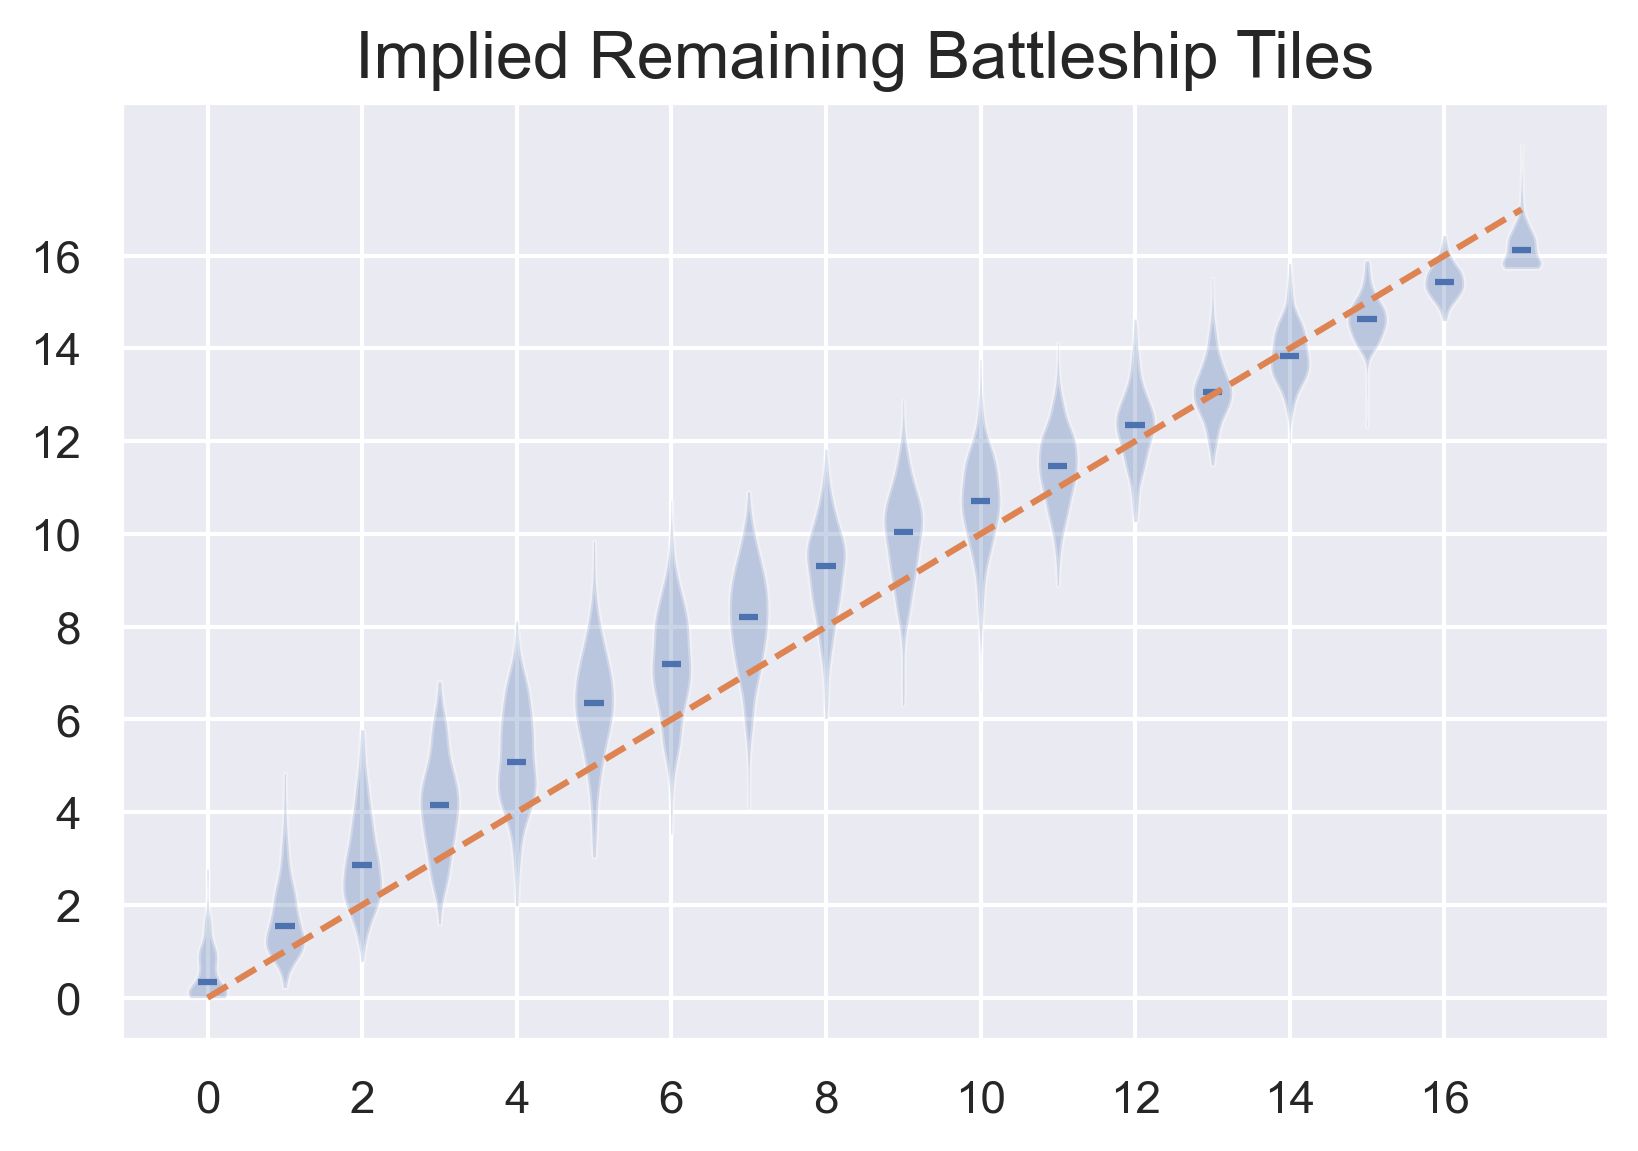

In [65]:
fig, ax = plt.subplots(dpi=300)

ax.violinplot(
    sum_of_probs_data,
    positions=range((2 + 3 + 3 + 4 + 5) + 1),
    showmedians=True,
    showmeans=False,
    showextrema=False,
)

ax.plot(
    range((2 + 3 + 3 + 4 + 5) + 1),
    range((2 + 3 + 3 + 4 + 5) + 1),
    label="Actual Remaining Tiles",
    linestyle="dashed",
)
ax.set_xticks(range(0, (2 + 3 + 3 + 4 + 5) + 1, 2))
ax.set_yticks(range(0, (2 + 3 + 3 + 4 + 5) + 1, 2))
ax.set_aspect(0.6)

ax.set_title("Implied Remaining Battleship Tiles", fontsize=16)

fig.savefig("implied_remaining_tiles.png", bbox_inches="tight")

## Making a banner 

Let's make a somewhat pretty banner for the blogpost

In [46]:
data, labels = give_data(num_boards=5, num_revealed=35)
long_data = np.reshape(data, (10, 50, 3))

In [49]:
banner_probs = np.zeros(long_data.shape[:2])

index_counts = np.zeros((1, 50))

for idx in range(41):
    index_counts[:, idx : idx + 10] += 1

    current_logits = trained_model(long_data[None, :, idx : idx + 10, :])[
        0, ...
    ].numpy()

    banner_probs[:, idx : idx + 10] += current_logits

banner_probs = banner_probs / index_counts

banner_probs = sigmoid(banner_probs)

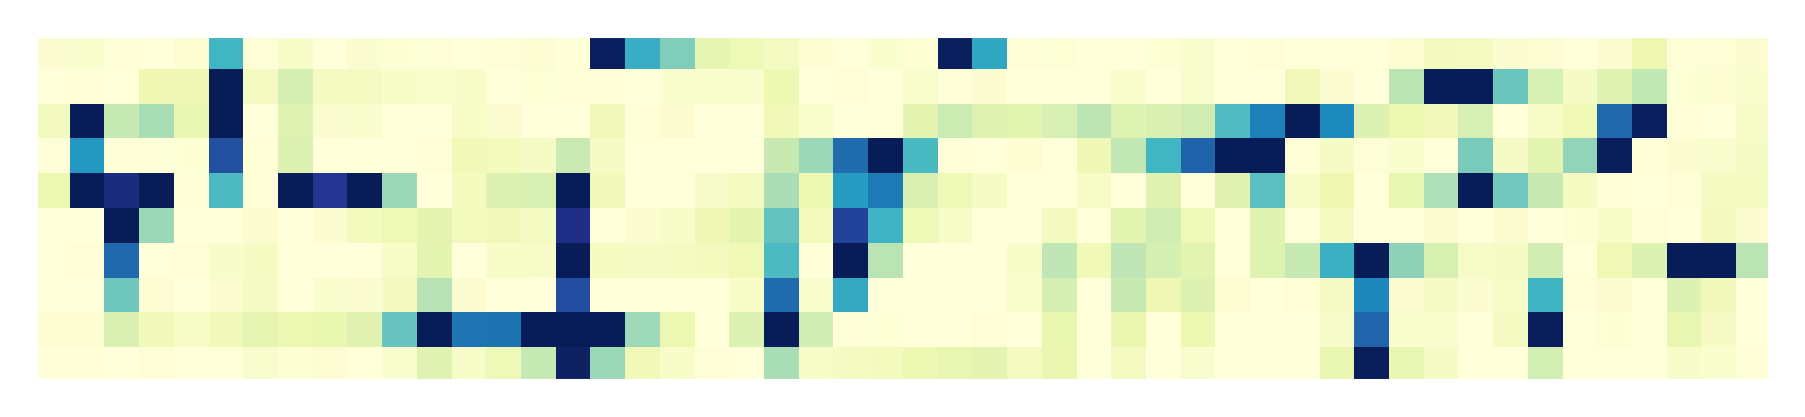

In [52]:
fig, ax = plt.subplots(dpi=350)

ax.imshow(1 / 4 + banner_probs / 2, cmap="YlGnBu")

ax.set_xticks([], [])
ax.set_yticks([], [])

fig.savefig("banner_distribution.png", bbox_inches="tight", pad_inches=0)